# Imports\


TODO:
1) check value/vat/no vat
2) check headlines, fix it


In [1]:
# !export GPN_DB_HOST=192.168.10.36


In [2]:
#!ls -la ../../work
# #!mv ../../../documents.json.zip ../../work
# # !unzip '../../work/documents.json.zip' '../../work/documents.json'
# !mv documents.json ../../work

In [3]:
IMPORT_FRESH_ONLY = True # re-import all if False

In [4]:
import logging
import platform
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print("tf",tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')

2023-02-03 16:10:31.104399: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
DEBUG - 2023-02-03 16:10:33,886 - retrain_ipynb - --=logging started=--


tf 2.5.0
Running on CPU:x86_64


In [5]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import analyser.hyperparams 


Nemoware Analyser v23.1.27.1
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')



### Imports...

In [6]:
%matplotlib inline

import pandas as pd
import numpy as np
from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.persistence import DbJsonDoc
from integration.db import get_mongodb_connection

from datetime import datetime
from math import log1p
from pandas import DataFrame
from analyser.persistence import DbJsonDoc
from colab_support.renderer import plot_embedding

from analyser.structures import DocumentState

from pathlib import Path
from bson import ObjectId

from datetime import date
from dateutil.relativedelta import relativedelta

# from tf_support.super_contract_model import seq_labels_contract, seq_labels_contract_swap_orgs
# 


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None
[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle
[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


In [7]:
# 
# !pip install transformers==4.11.3
# --force-reinstall
# !pip uninstall huggingface-hub -y


In [8]:
### Prepare workdir

In [9]:
_work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

analyser.hyperparams.work_dir = work_dir
 

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /root/artem/work


### Query DB for contact IDs

#### Load meta data CSV

In [10]:
!touch /root/artem/work/contract_trainset_meta.temp.csv

In [11]:
# stats[["user_correction_date", 'analyze_date']].max().max()

In [12]:
export_fn = str(Path(work_dir) / 'contract_trainset_meta.temp.csv')
# stats = pd.read_csv(export_fn, index_col=0)

try:
    stats = pd.read_csv(export_fn, index_col=0)
    if not 'analyze_date' in stats:
        stats['analyze_date'] = None
        
    if not 'documentType' in stats:
        stats['documentType'] = 'Unknown'
    
    stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=True)
    stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=True)

    lastdate = stats[["user_correction_date", 'analyze_date']].max().max()
    
except Exception as ex:
    print(f'ERROR: cannot load {export_fn}')
    logger.exception(ex)
    logger.error(f'cannot load {export_fn}')

    lastdate = datetime(1900, 1, 1)
    stats = DataFrame()
    
if not IMPORT_FRESH_ONLY:
    lastdate = datetime(1900, 1, 1)
    
print(lastdate, export_fn)


stats['source'] = 'db'


stats

2023-02-01 22:22:04.953000+00:00 /root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-01 17:26:52.044394,5847.0,2020-05-18 17:16:38.114000+00:00,25236322.0,17.043795,5674.0,BRL,...,ГПН,SUN,SUN,Service,1.000000,2023-01-27 10:27:22.086000+00:00,True,CONTRACT,79.0,4.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2970.0,7.996654,1364.0,RUB,...,Покупатель,Иідате. тьско-ііо. тиі рафнческое предприятие ...,Поставщик,Deal,1.000000,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,90000.0,11.407576,1834.0,RUB,...,Арендатор,"Фонд исследований, инноваций, инвестиций Тюмен...",Арендодатель,Renting,1.000000,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,Принципал,Газпромнефть-Снабжение,Агент,AgencyContract,1.000000,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,15482412.0,16.555215,699.0,RUB,...,Агент,ГазРромнефть-ГЕО,Принципал,AgencyContract,1.000000,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63ac1fa9862ea92bf713c50a,db,a6208b5f4c914b14b991ecd7ecc512e2,22.12.15.1,2023-02-02 06:15:52.410642,2782.0,2022-12-28 13:58:01.648000+00:00,785707.0,13.574341,959.0,RUB,...,Арендатор,Мю,Арендодатель,Renting,1.000000,2023-01-31 17:56:38.982000+00:00,True,CONTRACT,90.0,11.0
63ac1fac862ea92bf713c534,db,0d569631c20697de0fee0773d8f02e15,23.1.27.1,2023-02-02 06:15:53.392640,1169.0,2023-02-01 01:49:41.542000+00:00,100.0,4.615121,597.0,RUB,...,Приобретатель,NaN,Правообладатель,DealIntellectualProperty,1.000000,2023-01-31 17:52:54.143000+00:00,True,CONTRACT,69.0,12.0
63c506afe2456d59975e0fcd,db,d7b691a104ab348dd0ac843675c722cd,23.1.27.1,2023-02-02 06:15:53.345975,7524.0,2023-01-31 20:47:53.022000+00:00,10.0,2.397895,2926.0,RUB,...,Исполнитель,Ромашка,Заказчик,Service,1.000000,2023-01-31 12:49:12.534000+00:00,True,CONTRACT,38.0,16.0
62948fc7df54d406a99b15df,db,8234b52e65bbe79cb81b9b8edfd24575,23.2.1,2023-02-02 06:15:53.694656,5082.0,2023-02-01 22:13:36.858000+00:00,8098300.0,15.907165,596.0,RUB,...,Заказчик,Сибирский Научно Производственный Центр Кадаст...,Исполнитель,Service,1.000000,2023-02-01 14:15:46.652000+00:00,True,CONTRACT,36.0,18.0


In [13]:
lastdate

Timestamp('2023-02-01 22:22:04.953000+0000', tz='UTC')

# load old json

In [14]:
import json
import re
from bson import json_util
_DEBUG = False
file_data=None
try:
    fn = work_dir / 'documents.json'
    with open(fn) as file:
        file_data = json.load(file, object_hook=json_util.object_hook)

        print(f'total docs in {fn} is {len(file_data)}')    
        _DEBUG = True
except Exception as ex:
    logger.exception(ex)    




if _DEBUG:
    a_doc_from_json=DbJsonDoc(file_data[3])

    print(a_doc_from_json.get_attributes_tree())
    print(a_doc_from_json.get_version_string())

total docs in /root/artem/work/documents.json is 622
{'orgs': [{'type': {'span': [47, 48], 'span_map': 'words', 'confidence': 0.49801500000000004, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [49, 50], 'span_map': 'words', 'confidence': 0.9755, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [56, 57], 'span_map': 'words', 'confidence': 0.972, 'value': 'Арендатор'}}, {'type': {'span': [17, 18], 'span_map': 'words', 'confidence': 0.505665, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9905, 'value': 'ЭКРУСС'}, 'alias': {'span': [26, 27], 'span_map': 'words', 'confidence': 0.987, 'value': 'Арендодатель'}}], 'date': {'span': [9, 14], 'span_map': 'words', 'confidence': 1, 'value': datetime.datetime(2016, 5, 10, 0, 0, tzinfo=<bson.tz_util.FixedOffset object at 0x7f3caf2772e0>)}, 'number': {'span': [1, 4], 'span_map': 'words', 'confidence': 1, 'value': 'RP 16-06'}, 'subject': {'span': [100, 1

# functions

In [15]:

def get_amount(attr_tree):
  _value_tag = attr_tree.get('price')
  amount = None
  if _value_tag is not None:
    amount = _value_tag.get('amount_netto')
    if amount is None:
      amount = _value_tag.get('amount_brutto')
    if amount is None:
      amount = _value_tag.get('amount')
  return amount

        
    
def add_stats_record(d: DbJsonDoc, stats: DataFrame, source='db'):
  _id = str(d.get_id())
    
  attr_tree = d.get_attributes_tree()
 

  stats.at[_id, 'checksum'] = d.get_tokens_for_embedding().get_checksum()
  stats.at[_id, 'version'] = d.get_version_string()
  stats.at[_id, 'documentType'] = d.documentType
    
 
  stats.at[_id, 'source'] = source
  stats.at[_id, 'export_date'] = datetime.now()
  stats.at[_id, 'len'] = len(d)
  stats.at[_id, 'analyze_date'] = pd.to_datetime( d.analysis['analyze_timestamp'] , utc=True)


  n_headers = len(d.analysis.get('headers', []))
  stats.at[_id, 'headers'] = n_headers
    
  _value_tag = attr_tree.get('price')
  
  if _value_tag is not None:
    amount = get_amount(attr_tree) 
    if amount:
        
        stats.at[_id, 'value'] = amount.get('value') 
        stats.at[_id, 'value_log1p'] = log1p(amount.get('value') )
        stats.at[_id, 'value_span'] = amount.get('span', [0,0]) [0]
#         print( stats.at[_id, 'value'])
    
    stats.at[_id, 'currency'] = _value_tag.get('currency', {}).get('value')
  
  _orgs = attr_tree.get('orgs', [{},{}]) 
  if len(_orgs)>0:
      stats.at[_id, 'org-1-name'] = _orgs[0].get('name', {}).get('value')
      stats.at[_id, 'org-1-alias'] = _orgs[0].get('alias', {}).get('value')

      if len(_orgs)>1:
        stats.at[_id, 'org-2-name'] = _orgs[1].get('name', {}).get('value')
        stats.at[_id, 'org-2-alias'] = _orgs[1].get('alias', {}).get('value')

  stats.at[_id, 'subject'] = attr_tree.get('subject', {}).get('value')
  stats.at[_id, 'subject confidence'] = attr_tree.get('subject', {}).get('confidence')
    

  span = attr_tree.get('subject', {}).get('span',[0,0])
  subject_len = span[1] - span[0]
  stats.at[_id, 'subj_len'] = subject_len  

  if d.user is not None:
    # if 'attributes_tree' in d.user and 'creation_date' in d.user['attributes_tree']:
    # stats.at[_id, 'user_correction_date'] = d.user['attributes_tree']['creation_date']
    stats.at[_id, 'user_correction_date'] = pd.to_datetime(d.user[ 'updateDate'], utc=True)
    

    # find_in_dict('attributes_tree.creation_date', d.user)

  valid_state = (DocumentState.Excluded.value==d.state or DocumentState.Done.value==d.state)
  if not valid_state:
    print(_id, 'invalid state: ', d.state)
  valid_struct = ('contract' in jd.analysis['attributes_tree'])
  if not valid_struct:
    print(_id, 'invalid structure: ', d.state)
  stats.at[_id, 'valid'] = valid_state and valid_struct and subject_len>0 and subject_len<=300 and n_headers>0


  


d = get_doc_by_id(ObjectId('5fe34f62b770574a005553be'))
jd = DbJsonDoc(d)
add_stats_record(jd, stats)
stats.loc['5fe34f62b770574a005553be']

DB HOST IS: 192.168.10.36


/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_USER environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_PASSWORD environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_USE_MONGO_TLS environment variable! defaulting to False
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_TLS_CA environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_TLS_KEY environment varia

source                                                db
checksum                da2dd54cdcc5b4480207c9def7741d14
version                                           2.3.13
export_date                   2023-02-03 16:10:41.535884
len                                                  759
analyze_date            2020-12-23 17:14:16.727000+00:00
value                                           1.64e+06
value_log1p                                      14.3102
value_span                                           128
currency                                             RUB
org-1-name                        Газпромнефть-Снабжение
org-1-alias                               Благотворитель
org-2-name                           инициатив «Эпсилон»
org-2-alias                              Благополучатель
subject                                          Charity
subject confidence                                     1
user_correction_date    2022-12-08 19:07:01.522000+00:00
valid                          

In [16]:
# stats.loc['5fe34f62b770574a005553be']

In [17]:
# s = pd.Series()

['amount_brutto', 'amount_netto', 'vat', 'sign', 'currency', 'vat_unit']
['org-name', 'org-alias', 'org-type']


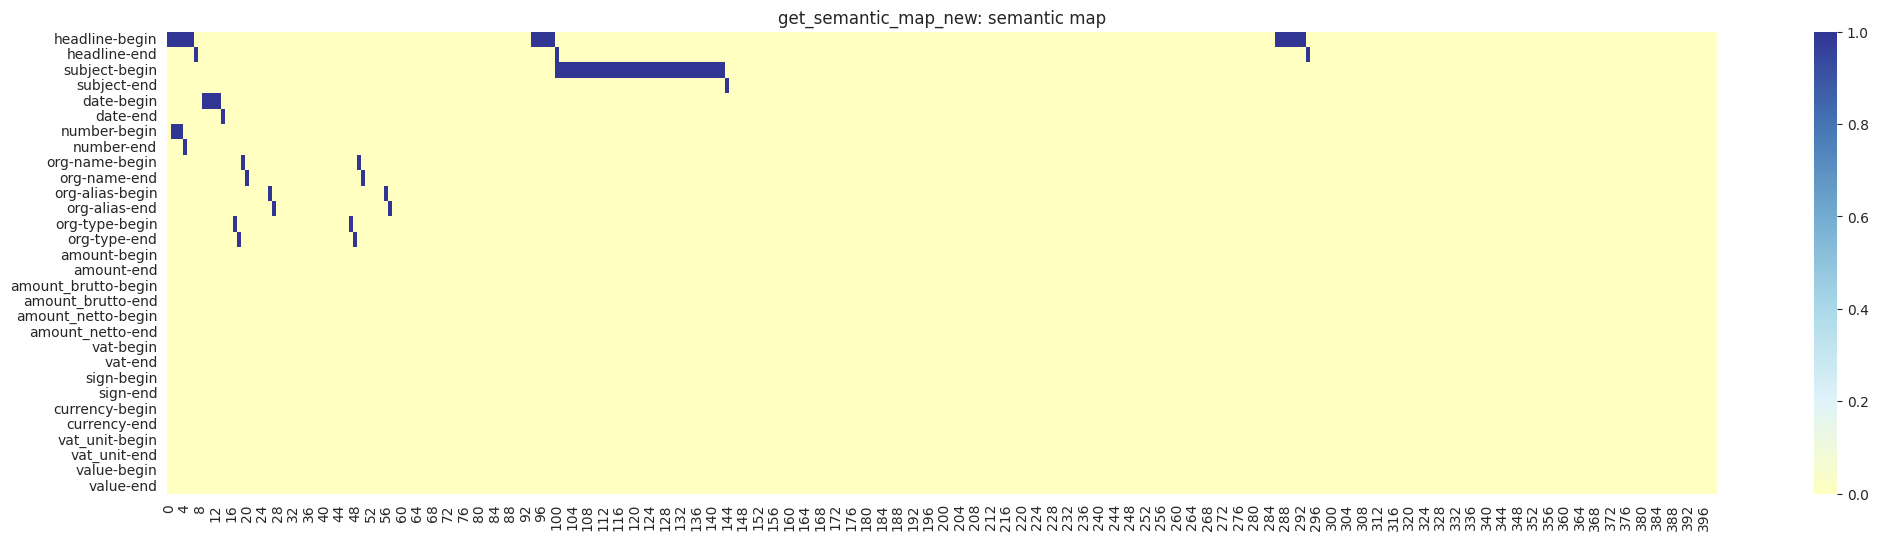

1.0
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3148    0.0
3149    0.0
3150    0.0
3151    0.0
3152    0.0
Name: date-begin, Length: 3153, dtype: float64


In [18]:
import json
 


semantic_map_keys = [
    'headline',
    'subject', 
    'date', 
    'number',
    'org-name', 
    'org-alias', 
    'org-type'
]

semantic_map_keys += ['amount', 'amount_brutto', 'amount_netto', 'vat', 'sign', 'currency', 'vat_unit', 'value']

semantic_map_keys_contract = []
for _name in semantic_map_keys:
    semantic_map_keys_contract.append(_name + "-begin")
    semantic_map_keys_contract.append(_name + "-end")

print(semantic_map_keys[8:14])
print(semantic_map_keys[4:7])

def get_semantic_map_new(doc: DbJsonDoc):
    
    _len = len(doc)
    df = DataFrame()
    
    for sl in semantic_map_keys_contract:    
        df[sl] = np.zeros(_len)
    
    attr_tree = doc.get_attributes_tree()
    
    def get_av(name):
        if name in df:
            return df[name]
        else:
            av = np.zeros(_len, np.float)
            df[name] = av
            return av

            
    def add_span_vectors(_name, span):
#         print('add_span_vectors',span)
        bn = _name + "-begin"
        en = _name + "-end"
        b = get_av(bn)
        e = get_av(en)
        if not span is None:
            df[bn][ span[0]:span[1] ]=1.
            df[en][ span[1] ]=1.
 
        

    # Headers
    headers = doc.analysis['headers']
    for h in headers:
        add_span_vectors('headline', h['span'])
 
 
    for n in semantic_map_keys[1:4]:
        span = attr_tree.get(n, {}).get('span')
        add_span_vectors(n, span)

 
    for i in [1, 2]:
        for n in semantic_map_keys[4:7]:
            try:                
                _nm = n.replace('org-', f'')
                span = attr_tree['orgs'][i-1][_nm]['span']
                add_span_vectors(n, span)
            except Exception as e:
                logger.exception(e)
                print('ERROR (sp)', e, i, n,  _nm)
                if _DEBUG:
                    try:  
                        print(json.dumps( attr_tree['orgs'][i-1], sort_keys=True, indent=4))
                    except:
                        pass
                    print('ERROR', i, n, doc.get_id(), e, attr_tree.get('orgs', None))
 

    _value_tag = attr_tree.get('price', {})
    add_span_vectors("value", _value_tag.get('span'))
 
    if _value_tag is not None:
        amount = get_amount(attr_tree) 
        if amount:
            add_span_vectors('amount', amount.get('span'))
        for n in semantic_map_keys[8:14]:
            add_span_vectors(n, _value_tag.get(n,{}).get('span'))
           
    return df[semantic_map_keys_contract]



if _DEBUG:
    sm_test = get_semantic_map_new(a_doc_from_json)
    plot_embedding(sm_test[0:400], f'get_semantic_map_new: semantic map')
    print(sm_test['date-begin'].max())
    print(sm_test['date-begin'])

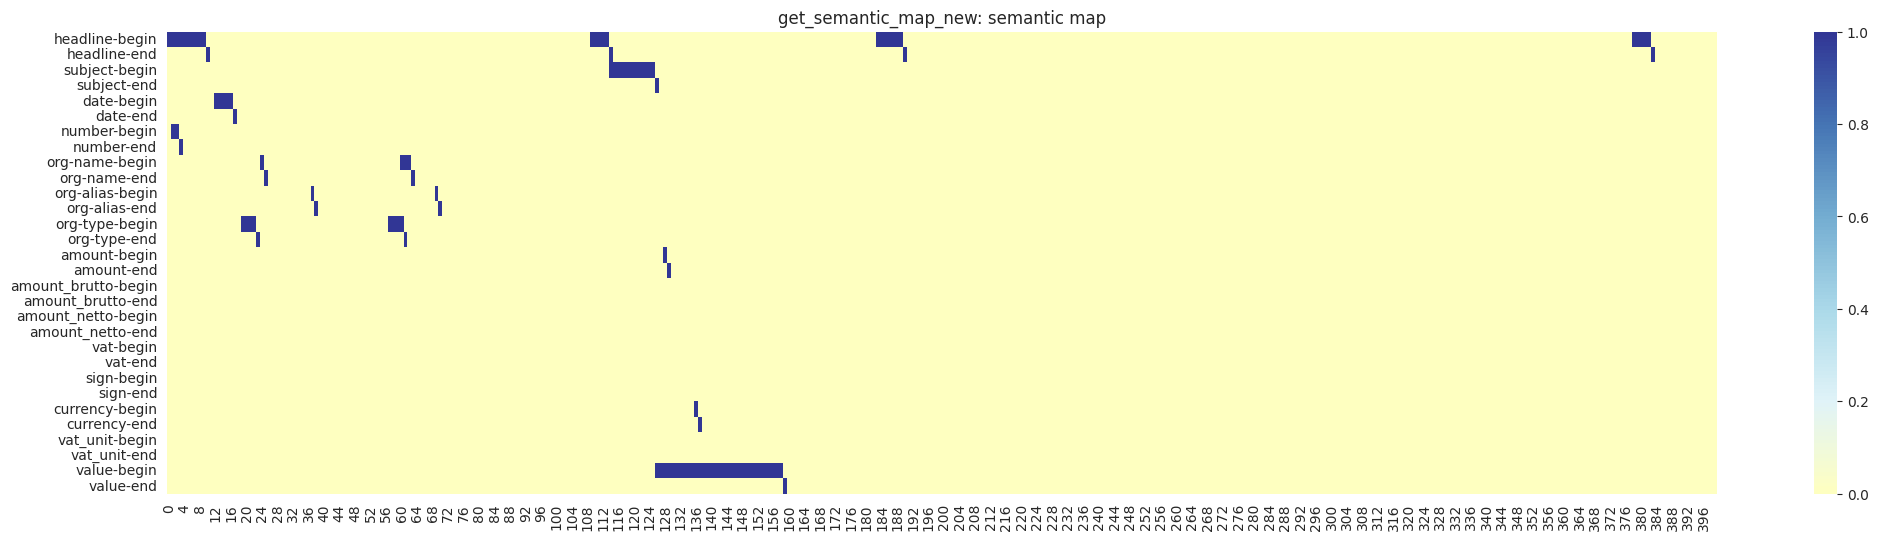

In [19]:
#test one

d = get_doc_by_id(ObjectId('5fe34f62b770574a005553be'))
jd = DbJsonDoc(d)
semantic_map: DataFrame = get_semantic_map_new(jd)
    

plot_embedding(semantic_map[0:400], f'get_semantic_map_new: semantic map')

In [20]:
# fff
files_dict = {}
if file_data:
    k=0
    for d in file_data:
        k+=1 
        jd = DbJsonDoc(d)
    #     print( jd.analysis['analyze_timestamp'])
        files_dict[jd.get_id()] = jd
        try:            
            add_stats_record(jd, stats, source = 'file')
        except Exception as e:
            print(e)
            print(jd.get_id())
#             raise (e)

        if k % 100 == 0:
#             stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=False)
#             stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=False)
#             stats['export_date'] = pd.to_datetime(stats['export_date'], utc=False)
            
    
            print(f'{k} of {len(file_data)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')

            
            
stats.to_csv(export_fn, index=True)
stats.to_csv('tmp.csv', index=True)

print(f'stats saved to {export_fn}')

# del file_data
stats




100 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
200 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
300 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
400 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv

5efdb73b777d4b67a92d533c
500 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
600 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-01 17:26:52.044394,5847.0,2020-05-18 17:16:38.114000+00:00,25236322.0,17.043795,5674.0,BRL,...,ГПН,SUN,SUN,Service,1.0,2023-01-27 10:27:22.086000+00:00,True,CONTRACT,79.0,4.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2970.0,7.996654,1364.0,RUB,...,Покупатель,Иідате. тьско-ііо. тиі рафнческое предприятие ...,Поставщик,Deal,1.0,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,90000.0,11.407576,1834.0,RUB,...,Арендатор,"Фонд исследований, инноваций, инвестиций Тюмен...",Арендодатель,Renting,1.0,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,Принципал,Газпромнефть-Снабжение,Агент,AgencyContract,1.0,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,15482412.0,16.555215,699.0,RUB,...,Агент,ГазРромнефть-ГЕО,Принципал,AgencyContract,1.0,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5ee188952281f29204c522dc,file,520bf70b9df1ee9ee999fe870d936a51,1.11.2,2023-02-03 16:10:52.989071,7298.0,2020-06-12 22:43:06.038000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,2020-06-11 08:49:53.635000+00:00,False,CONTRACT,0.0,4.0
5efe9252777d4b67a92d5621,file,ed9385088ed6d9c967a9b68a8d10ecc2,2.0.0,2023-02-03 16:11:00.777583,19504.0,2020-07-03 16:50:25.668000+00:00,65300168.0,17.994505,7412.0,RUB,...,Заказчик,Шлюмберже Лоджелко Инк.,Исполнитель,None,NaN,NaT,False,CONTRACT,0.0,26.0
5efe9280777d4b67a92d56ce,file,02a4101c17ceaa4b9d473f6840ac4d7a,2.0.0,2023-02-03 16:11:01.888273,14025.0,2020-07-03 21:47:22.279000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaT,False,CONTRACT,0.0,2.0
5efe9288777d4b67a92d56d3,file,33f326573547c95e1d381eecd79136a2,2.0.0,2023-02-03 16:11:02.134407,19219.0,2020-07-03 21:15:51.170000+00:00,NaN,NaN,NaN,NaN,...,Заказчик,Газпромнефть-Сахалин,Исполнитель,None,NaN,NaT,False,CONTRACT,0.0,25.0


In [21]:
# stats = stats.drop('63c506afe2456d59975e0fcd')
stats[stats.index.duplicated()]



,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers


In [22]:
stats[stats['valid']==False]


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers
62948131df54d406a99b15be,db,16febca47e48577b61346e86eeda0195,3.0.0,2023-01-31 18:20:55.963871,1111.0,2022-05-30 11:33:41.455000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.962318,NaT,False,SUPPLEMENTARY_AGREEMENT,0.0,2.0
629a0787d3b1c36092555a7d,db,bd9992f8adea9317932a4cff6f2d8e62,3.0.0,2023-01-31 18:20:56.279501,3232.0,2022-06-03 16:07:41.903000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.983956,NaT,False,ANNEX,0.0,3.0
629a0e79d3b1c36092555a90,db,b93f151baec5b9461cb693d4a4f1a13e,3.0.0,2023-01-31 18:20:56.317056,1750.0,2022-06-03 16:37:22.439000+00:00,NaN,NaN,NaN,NaN,...,Заказчик,Сибирский Научно Производственный Центр Кадаст...,Исполнитель,Other,0.868219,NaT,False,SUPPLEMENTARY_AGREEMENT,0.0,7.0
629dccf80806e3924ebafc6c,db,aff2eecd01d1ead8280329b62ddc5573,3.0.0,2023-01-31 18:20:56.345382,1903.0,2022-06-06 12:47:22.917000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.979086,NaT,False,ANNEX,0.0,11.0
62a995e1326a4191e5f17341,db,856d9451e7d7bf2a1535e33610f79a4d,3.0.0,2023-01-31 18:20:56.612666,1021.0,2022-06-15 11:30:07.490000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.949138,NaT,False,ANNEX,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5ee188952281f29204c522dc,file,520bf70b9df1ee9ee999fe870d936a51,1.11.2,2023-02-03 16:10:52.989071,7298.0,2020-06-12 22:43:06.038000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,2020-06-11 08:49:53.635000+00:00,False,CONTRACT,0.0,4.0
5efe9252777d4b67a92d5621,file,ed9385088ed6d9c967a9b68a8d10ecc2,2.0.0,2023-02-03 16:11:00.777583,19504.0,2020-07-03 16:50:25.668000+00:00,65300168.0,17.994505,7412.0,RUB,...,Заказчик,Шлюмберже Лоджелко Инк.,Исполнитель,None,NaN,NaT,False,CONTRACT,0.0,26.0
5efe9280777d4b67a92d56ce,file,02a4101c17ceaa4b9d473f6840ac4d7a,2.0.0,2023-02-03 16:11:01.888273,14025.0,2020-07-03 21:47:22.279000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaT,False,CONTRACT,0.0,2.0
5efe9288777d4b67a92d56d3,file,33f326573547c95e1d381eecd79136a2,2.0.0,2023-02-03 16:11:02.134407,19219.0,2020-07-03 21:15:51.170000+00:00,NaN,NaN,NaN,NaN,...,Заказчик,Газпромнефть-Сахалин,Исполнитель,None,NaN,NaT,False,CONTRACT,0.0,25.0


In [23]:
# !tail /root/artem/work/contract_trainset_meta.temp.csv

# Fetch fresh docs from Mongo DB

In [24]:


# if True:
lastdate = lastdate + relativedelta(days=-5)
#     lastdate = datetime.combine(lastdate, datetime.min.time())

lastdate = pd.to_datetime( lastdate , utc=True)
lastdate

Timestamp('2023-01-27 22:22:04.953000+0000', tz='UTC')

In [25]:
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType":{ '$in': ["AGREEMENT","CONTRACT","SUPPLEMENTARY_AGREEMENT",] }  },
      
#     {"state": 15},
    {'$or': [
          {"analysis.attributes_tree": {"$ne": None}},
          {"user.attributes_tree": {"$ne": None}}
        ]},
#       {'$and': [
#           {"user.updateDate": {"$ne": None}},
#           {'user.updateDate': {'$gt': lastdate}}
#       ]}
#     {"user.attributes_tree.contract.people": {"$ne": None}}

    #     {'$or': [
    #         {"user.attributes_tree.contract.price.amount_netto": {"$ne": None}},
    #         {"user.attributes_tree.contract.price.amount_brutto": {"$ne": None}}
    #     ]}
    {'$or': [
      {'analysis.analyze_timestamp': {'$gt': lastdate}},
      {'user.updateDate': {'$gt': lastdate}}
    ]}
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(5000)

res = list([i for i in res])
# print(res[0])
_s = f"#### Всего новых документов после {lastdate} : {len(res)}"
display(Markdown(_s))

res[:4]

/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


#### Всего новых документов после 2023-01-27 22:22:04.953000+00:00 : 178

[{'_id': ObjectId('5ec2b8d8665f7603e03b122b'),
  'parse': {'documentType': 'CONTRACT'},
  'state': 12,
  'user': {'updateDate': datetime.datetime(2023, 2, 2, 14, 26, 8, 111000)}},
 {'_id': ObjectId('5fb278c1d8c9df1ed1236d47'),
  'user': {'updateDate': datetime.datetime(2023, 2, 2, 14, 19, 22, 231000)},
  'state': 15,
  'parse': {'documentType': 'CONTRACT'}},
 {'_id': ObjectId('5fbbe467a2b4551c06107b06'),
  'user': {'updateDate': datetime.datetime(2023, 1, 31, 18, 7, 11, 55000)},
  'state': 15,
  'parse': {'documentType': 'CONTRACT'}},
 {'_id': ObjectId('5fbf668c5d05d73d0295fa46'),
  'user': {'updateDate': datetime.datetime(2023, 2, 2, 9, 39, 42, 442000)},
  'state': 15,
  'parse': {'documentType': 'CONTRACT'}}]

# Prepare training set

In [26]:
# del seq_labels_contract

In [27]:
new_docs_ids = docs_ids = [i["_id"] for i in res]
print(len(new_docs_ids))
# sample_id = ObjectId('637f7bf0e712cc2ff2e943d3')

# sample_id = docs_ids[1]
# sample_id
# d = get_doc_by_id(sample_id)

# jd = DbJsonDoc(d)
# jd.get_id()
# print(d['_id'])


#==========================Test 1 doc
    
# print(jd.get_version_string())
 
# add_stats_record(jd, stats)
# stats.loc[str(jd._id)]
 

178


In [28]:
new_docs_ids

[ObjectId('5ec2b8d8665f7603e03b122b'),
 ObjectId('5fb278c1d8c9df1ed1236d47'),
 ObjectId('5fbbe467a2b4551c06107b06'),
 ObjectId('5fbf668c5d05d73d0295fa46'),
 ObjectId('5fbf75af5d05d73d0295fa96'),
 ObjectId('5fbf75ad5d05d73d0295fa6b'),
 ObjectId('5fbf75af5d05d73d0295faa0'),
 ObjectId('5fc5eb6b1d0a1603c7a0c8b2'),
 ObjectId('5fbbe46aa2b4551c06107ba5'),
 ObjectId('5fca2aab9083b679224c75e7'),
 ObjectId('5fca2aac9083b679224c75f7'),
 ObjectId('5fca2aab9083b679224c75ea'),
 ObjectId('5fca2aac9083b679224c7600'),
 ObjectId('5fca2aac9083b679224c75f6'),
 ObjectId('5fca2ab09083b679224c7639'),
 ObjectId('5fca2ab39083b679224c7655'),
 ObjectId('5fca2ab49083b679224c7659'),
 ObjectId('5fc6452a1d0a1603c7a0c9e8'),
 ObjectId('5fdb2141542ce403c92b4576'),
 ObjectId('5fc63d611d0a1603c7a0c96b'),
 ObjectId('5fc7a038c54bc33809e2621d'),
 ObjectId('5fc7a036c54bc33809e261f7'),
 ObjectId('5fc7a037c54bc33809e26212'),
 ObjectId('5fc7a036c54bc33809e261ec'),
 ObjectId('5fc7a031c54bc33809e26180'),
 ObjectId('5fc7a034c54bc3

In [28]:
# plot_embedding(get_semantic_map_new(jd)[:300], f'semantic map')
# print(len(docs_ids))

In [29]:
def add_to_stats_list(docs_ids):
    for k, oid in enumerate(docs_ids):
        d = get_doc_by_id(ObjectId(str(oid)))
    #     print('fetching', oid)
        

        try:
            jd = DbJsonDoc(d)
            add_stats_record(jd, stats)
        except Exception as e:
            print(oid)
            print (e)
#             stats
#             raise(e)

        if k % 100 == 0:
            print(f'{k} of {len(docs_ids)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')
        
add_to_stats_list(docs_ids)        
stats.to_csv(export_fn, index=True)
print(f'stats saved to {export_fn}')
stats

0 of 66
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-01 17:26:52.044394,5847.0,2020-05-18 17:16:38.114000+00:00,25236322.0,17.043795,5674.0,BRL,...,ГПН,SUN,SUN,Service,1.000000,2023-01-27 10:27:22.086000+00:00,True,CONTRACT,79.0,4.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2970.0,7.996654,1364.0,RUB,...,Покупатель,Иідате. тьско-ііо. тиі рафнческое предприятие ...,Поставщик,Deal,1.000000,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,90000.0,11.407576,1834.0,RUB,...,Арендатор,"Фонд исследований, инноваций, инвестиций Тюмен...",Арендодатель,Renting,1.000000,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,Принципал,Газпромнефть-Снабжение,Агент,AgencyContract,1.000000,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,15482412.0,16.555215,699.0,RUB,...,Агент,ГазРромнефть-ГЕО,Принципал,AgencyContract,1.000000,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63c506e4e2456d59975e1548,db,038413ef0d9c628ae44d0b94ad0d308a,23.1.27.1,2023-02-02 06:15:53.388897,411.0,2023-01-31 22:53:07.303000+00:00,114000.0,11.643962,222.0,RUB,...,Исполнитель,Газпром нефть,Заказчик,Other,0.980911,NaT,False,SUPPLEMENTARY_AGREEMENT,0.0,1.0
629dccf80806e3924ebafc70,db,b93f151baec5b9461cb693d4a4f1a13e,23.2.1,2023-02-02 06:15:53.667505,1750.0,2023-02-01 22:09:15.569000+00:00,NaN,NaN,NaN,NaN,...,Заказчик,Сибирский Научно Производственный Центр Кадаст...,Исполнитель,None,NaN,2023-02-01 14:10:09.624000+00:00,False,SUPPLEMENTARY_AGREEMENT,0.0,7.0
6294ae67df54d406a99b1631,db,16febca47e48577b61346e86eeda0195,23.2.1,2023-02-02 06:15:53.672714,1111.0,2023-02-01 22:11:26.726000+00:00,NaN,NaN,NaN,NaN,...,Водопользователь,Министерство природных ресурсов и экологии Омс...,Уполномоченный орган,None,NaN,2023-02-01 14:12:34.471000+00:00,False,SUPPLEMENTARY_AGREEMENT,0.0,2.0
63ac1fa9862ea92bf713c509,db,6baee7dfb1c962bdc3a1ff80722c5f7f,23.2.1,2023-02-02 06:15:53.752343,7488.0,2023-02-01 22:20:56.336000+00:00,73000664.0,18.105979,2363.0,RUB,...,Принципал,Дельта,Агентство,Service,0.606797,NaT,False,SUPPLEMENTARY_AGREEMENT,0.0,20.0


In [30]:
# _ids = list(
#     stats[stats['source']=='db']
#     [stats['documentType']=='undefined'][ stats['user_correction_date'].notna()].index)


# add_to_stats_list(_ids)        
# stats.to_csv(export_fn, index=True)

s = stats[ stats['source']=='db'] 
# s = s[s['documentType']=='CONTRACT']
# s = s[s['subj_len'].isna()]
# s = s[s['user_correction_date'].notna()]
# s = s[s['value']>0]
_ids = list(s[s['headers'].isna()].index)
print(len(_ids))
add_to_stats_list(_ids)     
stats.to_csv(export_fn, index=True)

13
637397e2a8eb8dc64b37543b
'NoneType' object is not iterable
0 of 13
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
637397e2a8eb8dc64b37543c
'NoneType' object is not iterable
637397e2a8eb8dc64b37543d
'NoneType' object is not iterable
637397e2a8eb8dc64b37543f
'NoneType' object is not iterable
637397e2a8eb8dc64b375440
'NoneType' object is not iterable
637397e2a8eb8dc64b375441
'NoneType' object is not iterable
637397e2a8eb8dc64b37543a
'NoneType' object is not iterable
637397e2a8eb8dc64b37543e
'NoneType' object is not iterable
637e11d66a07f3e980b2bfbf
'NoneType' object is not iterable
637e11d76a07f3e980b2bfc0
'NoneType' object is not iterable
637f2826fe09513dc6b2bfbf
'NoneType' object is not iterable
637f2826fe09513dc6b2bfc0
'NoneType' object is not iterable
637f725ec15a83c52bb2bfc1
'NoneType' object is not iterable


/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


In [31]:
# s = stats[ stats['source']=='db'] 
# # s = s[s['documentType']=='undefined']
# s = s[s['subj_len'].isna()]
# # s = s[s['user_correction_date'].notna()]
# s.sort_values(['value'])

# stats[stats['subj_len'].isna()]


# stats[stats['subj_len']==0]

In [32]:
# stats[-1:]

In [33]:
stats = stats[stats.valid!=False]
len(stats)

7196

In [34]:
stats2 = stats.copy()
stats2['org-2-alias'] = stats2['org-2-alias'].str.lower()
stats2['org-1-alias'] = stats2['org-1-alias'].str.lower()
stats2['org-1-name'] = stats2['org-1-name'].str.lower()
stats2['org-2-name'] = stats2['org-2-name'].str.lower()
stats2

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-01 17:26:52.044394,5847.0,2020-05-18 17:16:38.114000+00:00,25236322.0,17.043795,5674.0,BRL,...,гпн,sun,sun,Service,1.000000,2023-01-27 10:27:22.086000+00:00,True,CONTRACT,79.0,4.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2970.0,7.996654,1364.0,RUB,...,покупатель,иідате. тьско-ііо. тиі рафнческое предприятие ...,поставщик,Deal,1.000000,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,90000.0,11.407576,1834.0,RUB,...,арендатор,"фонд исследований, инноваций, инвестиций тюмен...",арендодатель,Renting,1.000000,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,принципал,газпромнефть-снабжение,агент,AgencyContract,1.000000,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,15482412.0,16.555215,699.0,RUB,...,агент,газрромнефть-гео,принципал,AgencyContract,1.000000,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63ac1fa9862ea92bf713c50a,db,a6208b5f4c914b14b991ecd7ecc512e2,22.12.15.1,2023-02-02 06:15:52.410642,2782.0,2022-12-28 13:58:01.648000+00:00,785707.0,13.574341,959.0,RUB,...,арендатор,мю,арендодатель,Renting,1.000000,2023-01-31 17:56:38.982000+00:00,True,CONTRACT,90.0,11.0
63ac1fac862ea92bf713c534,db,0d569631c20697de0fee0773d8f02e15,23.1.27.1,2023-02-02 06:15:53.392640,1169.0,2023-02-01 01:49:41.542000+00:00,100.0,4.615121,597.0,RUB,...,приобретатель,None,правообладатель,DealIntellectualProperty,1.000000,2023-01-31 17:52:54.143000+00:00,True,CONTRACT,69.0,12.0
63c506afe2456d59975e0fcd,db,d7b691a104ab348dd0ac843675c722cd,23.1.27.1,2023-02-02 06:15:53.345975,7524.0,2023-01-31 20:47:53.022000+00:00,10.0,2.397895,2926.0,RUB,...,исполнитель,ромашка,заказчик,Service,1.000000,2023-01-31 12:49:12.534000+00:00,True,CONTRACT,38.0,16.0
62948fc7df54d406a99b15df,db,8234b52e65bbe79cb81b9b8edfd24575,23.2.1,2023-02-02 06:15:53.694656,5082.0,2023-02-01 22:13:36.858000+00:00,8098300.0,15.907165,596.0,RUB,...,заказчик,сибирский научно производственный центр кадаст...,исполнитель,Service,1.000000,2023-02-01 14:15:46.652000+00:00,True,CONTRACT,36.0,18.0


In [35]:
stats2['subject'].value_counts()

Other                                3010
Service                              2092
Deal                                  497
Renting                               199
Loans                                 187
GeneralContract                       182
AgencyContract                         94
DealIntellectualProperty               88
Charity                                82
Insurance                              60
RealEstate                             37
ParticipationInOtherOrganizations      24
RealEstateTransactions                 21
PledgeEncumbrance                      20
BankGuarantees                         14
SecuritiesTransactions                 11
BigDeal                                 2
EmployeeContracts                       2
DealGeneralBusiness                     1
AssetTransactions                       1
Name: subject, dtype: int64

In [36]:
stats2['org-1-alias'].value_counts()

заказчик           1500
исполнитель         616
покупатель          351
поставщик           155
продавец            138
                   ... 
ооо «ромашка»         1
благополучатель       1
издатель              1
унисит                1
аудит                 1
Name: org-1-alias, Length: 95, dtype: int64

In [37]:
stats2['org-2-alias'].value_counts()

исполнитель             1218
заказчик                 656
поставщик                295
покупатель               267
подрядчик                252
                        ... 
генеральный директор       1
«заемщик»                  1
благотворитель             1
жертвователь               1
бенефициар                 1
Name: org-2-alias, Length: 99, dtype: int64

In [38]:
score_column_name = "score"

def calc_no_value_importance(stats2, column_name, score_k=2.):
        
    for i, row in stats2.iterrows():
        if pd.isna(row[column_name]):
            stats2.at[i, score_column_name] *= score_k
                
def calc_user_importance(stats2):
        
    for i, row in stats2.iterrows():
        if not pd.isna(row['unseen']):

            if row['unseen'] == True:
                stats2.at[i, score_column_name] *= 2
                
def calc_val_importance(stats2):
 
    for i, row in stats2.iterrows():
        if not pd.isna(row['value']):
            val = row['value']
            if val >= 2000:
                stats2.at[i, score_column_name] *= 1./log1p(val)
            if val < 2000:
                stats2.at[i, score_column_name] *= 4.
        else:
            stats2.at[i, score_column_name] *= 10.0 #error
            
def calc_column_val_importance(stats2, column_name, k=1.):
    counts = stats2[column_name].value_counts()
 
        
    for i, row in stats2.iterrows():
        val = row[column_name]
        if val in counts:
            count = counts[val]
            stats2.at[i, score_column_name] *= k * log1p(count)
#             print(count, log1p(count),  1./log1p(count))
        else:
            stats2.at[i, score_column_name] *= 10.0 #error

            
for i, row in stats2.iterrows():        
  stats2.at[i, 'url'] = f'http://gpn-audit.nemosoft.ru/#/audit/edit/{i}'

    
stats2 ['unseen'] = pd.isna( stats2['user_correction_date'])

stats2[score_column_name] = 1.
 

calc_no_value_importance(stats2, 'org-1-alias', 2.)
calc_no_value_importance(stats2, 'org-2-alias', 2.)
calc_no_value_importance(stats2, 'org-1-name', 3.)
calc_no_value_importance(stats2, 'org-2-name', 3.)
calc_no_value_importance(stats2, 'user_correction_date', 10.)
calc_no_value_importance(stats2, 'subject', 4.)
calc_no_value_importance(stats2, 'value', 5.)

## calc_column_val_importance(stats2, 'org-1-name')
## calc_column_val_importance(stats2, 'org-2-name')

calc_column_val_importance(stats2, 'org-1-alias')
calc_column_val_importance(stats2, 'org-2-alias')
calc_column_val_importance(stats2, 'subject', k = 3.)

calc_user_importance(stats2)
calc_val_importance(stats2)

# drop_duplicates(subset=['checksum']).
stats2 = stats2.sort_values([score_column_name], ascending=True)
print(len(stats2))
stats2.head(40)

7196


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,url,unseen,score
6391b4771864c6df4d29f332,db,22f701119d81787cd423f79f0f9fd9db,22.12.7,2023-02-02 06:15:52.365783,1990.0,2022-12-08 22:25:50.608000+00:00,1.000000e+11,25.328436,483.0,RUB,...,BankGuarantees,1.000000,2023-01-29 10:38:27.608000+00:00,True,CONTRACT,151.0,8.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6391...,False,0.308213
6340244c9d08c565cfa12341,db,bc7d70a32aed6af4ef6c7752a1b7674d,3.0.0,2023-01-31 18:37:33.526517,6747.0,2022-10-07 16:09:15.340000+00:00,2.000000e+09,21.416413,909.0,RUB,...,Loans,1.000000,2022-10-07 13:43:21.470000+00:00,True,AGREEMENT,130.0,22.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6340...,False,0.352421
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-01 17:26:52.044394,5847.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,Service,1.000000,2023-01-27 10:27:22.086000+00:00,True,CONTRACT,79.0,4.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,0.646637
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-02-02 06:15:33.263630,1373.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,AgencyContract,0.646182,2020-07-18 12:24:26.280000+00:00,True,CONTRACT,106.0,10.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,0.650790
5ded4e284ddc27bcf92dd6ce,file,9a44591c17d2b8f34dc8f1c3600c8c3a,1.11.2,2023-02-02 06:15:29.702922,460.0,2020-06-12 21:09:19.574000+00:00,5.900000e+05,13.287880,150.0,RUB,...,Charity,0.000000,2020-06-09 00:40:54.752000+00:00,True,CONTRACT,30.0,5.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,False,0.759703
63ce49f8e83d1ee490f3f21c,db,25d924fc09b7291d964f464f9c3ec8c3,23.1.27.1,2023-02-02 06:15:52.989892,8535.0,2023-01-28 09:34:50.691000+00:00,3.000000e+09,21.821878,337.0,RUB,...,Loans,1.000000,2023-01-28 01:38:49.198000+00:00,True,CONTRACT,53.0,12.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,False,1.148964
63908ca4a1bded13e629f2eb,db,3bc04887446d02692e886db2545bba61,22.12.7,2023-01-31 18:38:08.500901,13410.0,2022-12-08 13:59:29.898000+00:00,2.000000e+10,23.718998,2572.0,RUB,...,BankGuarantees,1.000000,2022-12-08 11:04:21.263000+00:00,True,AGREEMENT,84.0,21.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,1.645631
6246a3fa25a983726c7694af,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-01-31 18:32:42.511519,5556.0,2022-04-01 10:21:21.897000+00:00,1.000000e+11,25.328436,1505.0,NaN,...,SecuritiesTransactions,1.000000,2022-04-01 07:27:01.064000+00:00,True,CONTRACT,37.0,17.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6246...,False,1.692323
6285f9c04d1bfe5e5b297ddd,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-02-01 17:26:53.153480,5556.0,2022-05-19 11:03:36.611000+00:00,1.000000e+11,25.328436,1505.0,RUB,...,SecuritiesTransactions,1.000000,2023-01-27 11:32:42.657000+00:00,True,CONTRACT,37.0,17.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6285...,False,1.692323
633fd0a69d08c565cfa1232a,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-02-01 17:26:54.225685,5556.0,2022-10-07 10:10:07.028000+00:00,1.000000e+11,25.328436,1505.0,RUB,...,SecuritiesTransactions,1.000000,2023-01-27 11:36:12.388000+00:00,True,CONTRACT,37.0,17.0,http://gpn-audit.nemosoft.ru/#/audit/edit/633f...,False,1.692323


In [39]:
# sub = stats2.sort_values(['score'], ascending=True).copy()
# sub

## Find and remove duplicates

In [40]:
stats2['len'] //= 10 #similar lens
stats2['len'] *= 10 #similar lens
stats2.sort_values(['len', 'org-1-name', 'org-2-name', 'org-1-alias','org-2-alias', 'value', 'subject'], ascending=False)

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,url,unseen,score
5fc7a047c54bc33809e26372,db,82137d4b0ded9b81b1d12f4d9e98c383,2.0.5,2023-01-31 18:21:21.813526,49340.0,2020-12-03 08:07:48.699000+00:00,90619807.0,18.322183,4503.0,RUB,...,Service,0.896091,NaT,True,CONTRACT,44.0,53.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7...,True,3.662745e+03
5fca2acd9083b679224c77da,db,6b64d52e5ecb4941696164ed4950e735,2.0.5,2023-01-31 18:21:28.019257,49040.0,2020-12-10 10:40:36.652000+00:00,90619807.0,18.322183,4207.0,RUB,...,GeneralContract,1.000000,2021-07-30 21:59:37.858000+00:00,True,CONTRACT,44.0,44.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,False,3.452060e+01
5fb3b9a800881c332b567433,db,287d93101b752b5f041d476d7196864e,2.0.5,2023-01-31 18:21:09.911469,44180.0,2020-11-17 11:54:59.086000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,True,CONTRACT,0.0,52.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,1.440000e+08
5f09a55a138e9184feef1f3d,file,1a9db8f1670e2e976b777841a0cd3412,2.0.4,2023-02-02 06:15:48.129800,39860.0,2020-10-04 10:50:52.531000+00:00,NaN,NaN,NaN,NaN,...,Service,1.000000,2020-10-04 02:48:25.763000+00:00,True,CONTRACT,118.0,4.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5f09...,False,1.908017e+05
5f09c1c7138e9184feef1f69,file,1a9db8f1670e2e976b777841a0cd3412,2.0.1,2023-02-02 06:15:49.504709,39860.0,2020-07-11 21:43:23.938000+00:00,NaN,NaN,NaN,NaN,...,Service,0.998361,NaT,True,CONTRACT,118.0,4.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5f09...,True,3.816035e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63c506bde2456d59975e1112,db,0cbc9c41015ca9671bab95c12d5760a4,23.01.04,2023-01-31 18:38:08.881351,10.0,2023-01-16 11:36:53.287000+00:00,NaN,NaN,NaN,NaN,...,Other,0.974322,NaT,True,ANNEX,0.0,1.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,8.650830e+07
638f0a7fb1363747e929f2eb,db,6ab9d3f7bc1bc9a222f4490866b01365,22.12.6,2023-01-31 18:38:07.383103,10.0,2022-12-06 12:27:52.103000+00:00,NaN,NaN,NaN,NaN,...,Other,0.984600,NaT,True,ANNEX,0.0,1.0,http://gpn-audit.nemosoft.ru/#/audit/edit/638f...,True,8.650830e+07
638f0a7fb1363747e929f2ec,db,109407c8fd295cd3e3bf6c51ae8c8c4f,22.12.6,2023-01-31 18:38:07.384039,10.0,2022-12-06 12:27:52.306000+00:00,NaN,NaN,NaN,NaN,...,Other,0.984498,NaT,True,ANNEX,0.0,1.0,http://gpn-audit.nemosoft.ru/#/audit/edit/638f...,True,8.650830e+07
638f0a7fb1363747e929f2ef,db,16bbfb78a184b3f37e6c9866aa4c94d9,22.12.6,2023-01-31 18:38:07.386171,10.0,2022-12-06 12:27:52.856000+00:00,NaN,NaN,NaN,NaN,...,Other,0.982682,NaT,True,ANNEX,0.0,1.0,http://gpn-audit.nemosoft.ru/#/audit/edit/638f...,True,8.650830e+07


In [41]:
for i, row in stats2.iterrows():
  _str = ':'.join(sorted([str(x) for x in
                          [row['len'], row['org-1-alias'], row['org-2-alias'], row['org-1-name'], row['org-2-name'],
                           row['value'], row['subject']]]))
  stats2.at[i, 'hash'] = hash(_str)

stats2 = stats2.sort_values(['hash'])
print(len(stats2))
stats2

7196


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject confidence,user_correction_date,valid,documentType,subj_len,headers,url,unseen,score,hash
5eea27b3c28b75807f3daf34,file,7511207c1dd80631f949f98b27d53a8f,2.0.1,2023-02-02 06:15:39.368354,5650.0,2020-07-11 15:45:43.080000+00:00,2.149836e+06,14.580902,479.0,RUB,...,0.998195,NaT,True,CONTRACT,127.0,16.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5eea...,True,1.635240e+03,-9.222654e+18
635fa41fbf4cb23cbb392827,db,6fc74f7f7c69004f4fc93a912979a986,3.0.0,2023-01-31 18:36:08.770341,10260.0,2022-10-31 13:47:38.210000+00:00,NaN,NaN,NaN,NaN,...,0.910670,NaT,True,CONTRACT,88.0,29.0,http://gpn-audit.nemosoft.ru/#/audit/edit/635f...,True,1.192164e+06,-9.211854e+18
637e0669c15a83c52bb2bfbf,db,078f46930725bb884e119c54a990826d,3.0.0,2023-01-31 18:32:44.319931,11590.0,2022-11-23 14:45:40.368000+00:00,1.989150e+08,19.108388,890.0,RUB,...,1.000000,2022-11-23 11:53:32.528000+00:00,True,CONTRACT,54.0,30.0,http://gpn-audit.nemosoft.ru/#/audit/edit/637e...,False,3.450842e+01,-9.204610e+18
63c506c7e2456d59975e123c,db,25f8d28a83172c3200724ac48d9883e0,23.01.04,2023-01-31 21:42:35.513133,2810.0,2023-01-16 13:30:23.478000+00:00,NaN,NaN,NaN,NaN,...,0.995647,NaT,True,CONTRACT,58.0,11.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,1.192164e+06,-9.187912e+18
6380857f6a07f3e980b2c363,db,25f8d28a83172c3200724ac48d9883e0,3.0.0,2023-01-31 18:36:11.610683,2810.0,2022-11-25 18:53:09.992000+00:00,NaN,NaN,NaN,NaN,...,0.995931,NaT,True,CONTRACT,58.0,11.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6380...,True,1.192164e+06,-9.187912e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fe48217b770574a0055557b,db,cdb47f220663f6b9cd8d9cd356e2eab1,2.3.13,2023-01-31 18:32:39.005733,2240.0,2020-12-24 15:46:23.912000+00:00,5.400000e+04,10.896758,900.0,RUB,...,0.998468,NaT,True,CONTRACT,53.0,13.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fe4...,True,2.188108e+03,9.160648e+18
5edbc66dda3678279fbcb01c,file,7b65a7b1d2d8c40624f776bd25cdd8ea,2.0.2,2023-02-02 06:15:36.376938,10390.0,2020-07-14 08:39:24.761000+00:00,NaN,NaN,NaN,NaN,...,0.000000,2020-07-13 03:31:01.730000+00:00,True,CONTRACT,45.0,22.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,5.960820e+04,9.198485e+18
5efe9250777d4b67a92d55eb,file,92ae29038922618fd20bba8a0500fddb,2.0.0,2023-02-02 06:15:43.217547,14000.0,2020-07-03 22:20:32.738000+00:00,NaN,NaN,NaN,NaN,...,0.998223,2020-07-03 14:15:33.703000+00:00,True,CONTRACT,72.0,1.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5efe...,False,5.960820e+04,9.209011e+18
5ded4e294ddc27bcf92dd6d5,file,981456fc222b317c658a30ceb3a1cb1c,1.11.2,2023-02-02 06:15:29.711932,750.0,2020-06-12 21:09:26.057000+00:00,9.509455e+05,13.765213,137.0,RUB,...,0.996381,2020-06-11 09:06:00.546000+00:00,True,CONTRACT,69.0,6.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,False,1.419910e+01,9.210529e+18


In [42]:
unks = stats2['hash'].value_counts()

for i, row in stats2.iterrows():   
    stats2.at[i, 'dups'] = unks[row['hash']]
    
dups = stats2.sort_values(['dups', 'hash'], ascending=False)
# dups.to_csv(Path(work_dir) / 'contract_trainset_meta.duplicates.csv', index=True)

# dups[40:].head(40)
len(dups)

7196

### Drop duplicates

In [43]:
dups_s = dups.sort_values([score_column_name], ascending=True).copy()

dups_s = dups_s.drop_duplicates(subset=['hash'])
dups_s = dups_s.sort_values([score_column_name], ascending=True)


dups_s = dups_s.sort_values([score_column_name], ascending=True)
# dups_s = dups_s[dups_s[score_column_name] < 5000]
print(len(dups_s))

# dups_s [dups_s['len'] > 30000].head(40)

3147


## Remove rare subjects and very long docs

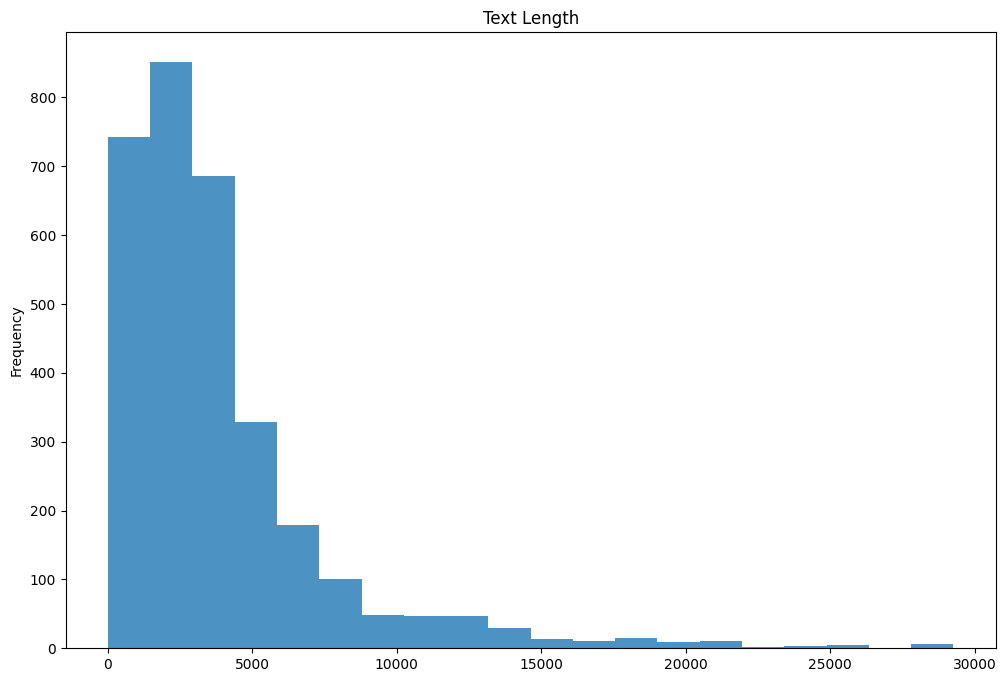

In [44]:
plt.figure(figsize=(12, 8))
ax = dups_s[dups_s['len'] < 30000] ['len'].plot.hist(bins=20, alpha=0.8)
ax.set_title('Text Length')
plt.show()

0.3082126854850533


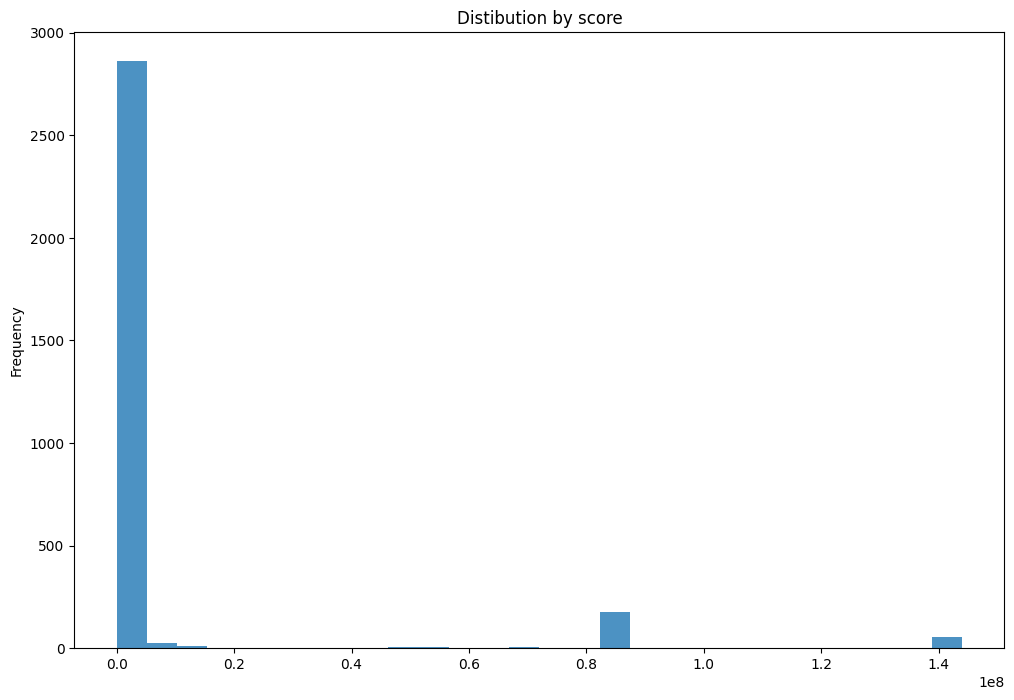

In [45]:
print(dups_s[score_column_name].min())
plt.figure(figsize=(12, 8))
ax = dups_s[score_column_name].plot.hist(bins=28, alpha=0.8)
ax.set_title('Distibution by score')
plt.show()

In [46]:

dups_s['valid'] = True

print("excluding too long docs")
for i, row in dups_s.iterrows():   
    if row['len'] > 30000:
        print ('excluding', i, row[0], row['subject'], row['len'])
        dups_s.at[i, 'valid'] = False  
        
dups_s = dups_s[dups_s['valid'] == True]

print("excluding docs with rare subj")
cnts = dups_s ['subject'].value_counts()
for i, row in dups_s.iterrows():   
    if not pd.isna(row['subject']):
        if cnts[row['subject']] < 3:
            print ('excluding', i, row[0], row['subject'])
            dups_s.at[i, 'valid'] = False

dups_s = dups_s[dups_s['valid'] == True]  

excluding too long docs
excluding 5e58df7823869ee43538823d file GeneralContract 31090.0
excluding 5fbf75c75d05d73d0295fac0 db GeneralContract 38360.0
excluding 5fca2acd9083b679224c77da db GeneralContract 49040.0
excluding 5fca2ac79083b679224c774f db GeneralContract 39310.0
excluding 5f9672f182451803b5001df7 db GeneralContract 31170.0
excluding 5ec2b8da665f7603e03b127c db GeneralContract 31090.0
excluding 5fc7a047c54bc33809e26372 db Service 49340.0
excluding 5f09a55a138e9184feef1f3d file Service 39860.0
excluding 615e9e978f3b0514f3f42413 db Loans 35800.0
excluding 6246a2d525a983726c76949d db Other 35560.0
excluding 5fb3b9a800881c332b567433 db nan 44180.0
excluding docs with rare subj
excluding 5feb3e50bd24992aa31040df db AssetTransactions
excluding 5fb6750c33c72547b7550147 db BigDeal
excluding 638085866a07f3e980b2c441 db DealGeneralBusiness
excluding 5dee80604ddc27bcf92dd88e file EmployeeContracts
excluding 610d2b0d7dfce422c4272d39 db EmployeeContracts


Service                              1567
Other                                 445
Deal                                  364
Renting                               143
GeneralContract                       129
Loans                                 103
AgencyContract                         75
DealIntellectualProperty               65
Charity                                52
Insurance                              45
RealEstate                             32
RealEstateTransactions                 16
BankGuarantees                         13
PledgeEncumbrance                      12
ParticipationInOtherOrganizations      11
SecuritiesTransactions                  8
Name: subject, dtype: int64


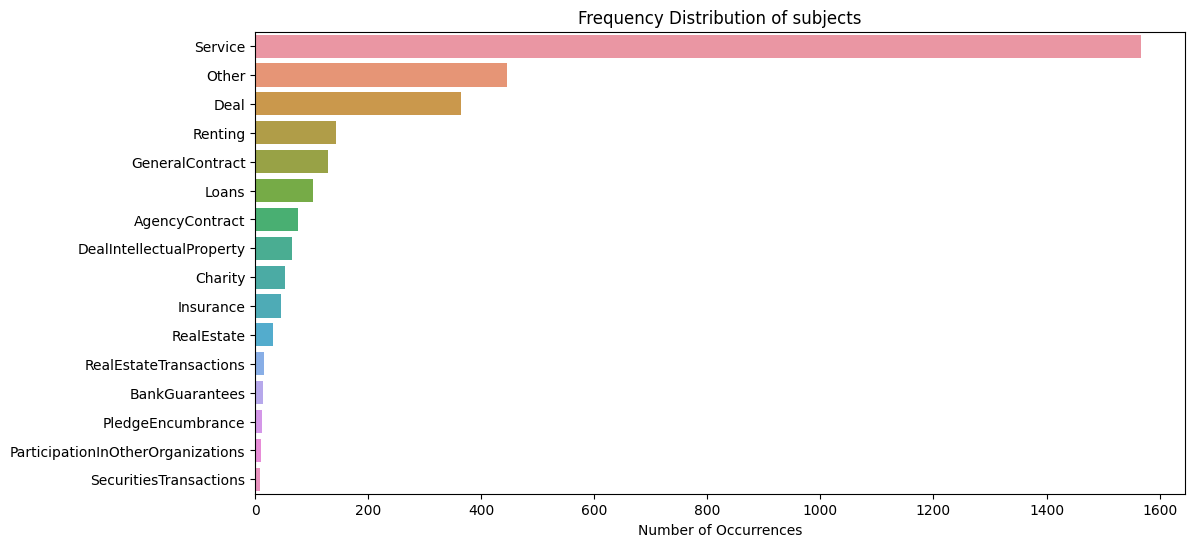

In [47]:
%matplotlib inline

cnt = dups_s['subject'].value_counts()

plt.figure(figsize=(12, 6 ))
sns.barplot(x=cnt.values, y=cnt.index)

print(  cnt )

plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


In [48]:
dups_s.index.name = '_id'
dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)


_s = f"### {len(dups_s)} - Всего новых документов в обучающем наборе на {lastdate}"
display(Markdown(_s))


dups_s

### 3131 - Всего новых документов в обучающем наборе на 2023-01-27 22:22:04.953000+00:00

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,user_correction_date,valid,documentType,subj_len,headers,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
6391b4771864c6df4d29f332,db,22f701119d81787cd423f79f0f9fd9db,22.12.7,2023-02-02 06:15:52.365783,1990.0,2022-12-08 22:25:50.608000+00:00,1.000000e+11,25.328436,483.0,RUB,...,2023-01-29 10:38:27.608000+00:00,True,CONTRACT,151.0,8.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6391...,False,3.082127e-01,-1.025325e+18,1.0
6340244c9d08c565cfa12341,db,bc7d70a32aed6af4ef6c7752a1b7674d,3.0.0,2023-01-31 18:37:33.526517,6740.0,2022-10-07 16:09:15.340000+00:00,2.000000e+09,21.416413,909.0,RUB,...,2022-10-07 13:43:21.470000+00:00,True,AGREEMENT,130.0,22.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6340...,False,3.524210e-01,7.298977e+18,1.0
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-01 17:26:52.044394,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,2023-01-27 10:27:22.086000+00:00,True,CONTRACT,79.0,4.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,6.466366e-01,-2.263661e+17,1.0
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-02-02 06:15:33.263630,1370.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,2020-07-18 12:24:26.280000+00:00,True,CONTRACT,106.0,10.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,6.507901e-01,1.802112e+18,1.0
5ded4e284ddc27bcf92dd6ce,file,9a44591c17d2b8f34dc8f1c3600c8c3a,1.11.2,2023-02-02 06:15:29.702922,460.0,2020-06-12 21:09:19.574000+00:00,5.900000e+05,13.287880,150.0,RUB,...,2020-06-09 00:40:54.752000+00:00,True,CONTRACT,30.0,5.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,False,7.597030e-01,2.138736e+18,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fb6750c33c72547b755014b,db,12455e486cd9b00e3c7162fddac1b93b,2.4.4,2023-01-31 18:37:44.282637,90.0,2021-07-28 18:20:01.448000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,ANNEX,0.0,3.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb6...,True,1.440000e+08,-7.884824e+18,17.0
5fe4821bb770574a0055567c,db,f2b79fe08d6e279df3e3d7c19f6e0809,2.3.13,2023-01-31 18:21:28.101227,470.0,2020-12-24 15:16:11.073000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,ANNEX,0.0,5.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fe4...,True,1.440000e+08,-8.599571e+18,5.0
5fb6750b33c72547b755012a,db,957cb0926333661bf3cf5dd85a725db8,2.4.4,2023-01-31 18:37:44.266127,290.0,2021-07-28 18:19:09.597000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,ANNEX,0.0,3.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb6...,True,1.440000e+08,8.739335e+18,21.0


In [49]:
dups_s[dups_s['unseen']].to_csv(Path(work_dir) / 'contract_trainset_meta.to_markup.csv', index=True)

In [50]:
dups_s[dups_s['unseen']]

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,user_correction_date,valid,documentType,subj_len,headers,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
5ec2b8d8665f7603e03b121a,db,74a7be7f14b129ce379aaa0920978a71,1.6.5,2023-01-31 18:32:27.217863,550.0,2020-05-18 16:35:16.047000+00:00,4.900000e+05,13.102163,114.0,RUB,...,NaT,True,CONTRACT,35.0,7.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,True,9.722266e+00,5.939537e+18,5.0
63c506dce2456d59975e145c,db,88a0bf0e851b84960702680c7972f090,23.01.04,2023-01-31 21:42:43.455407,3630.0,2023-01-16 14:15:20.502000+00:00,4.000000e+06,15.201805,326.0,RUB,...,NaT,True,CONTRACT,95.0,7.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,3.112603e+01,-5.692956e+18,2.0
63c506ace2456d59975e0f9f,db,2ff69a29f2a6f16826a6e68dc6cc1d22,23.01.04,2023-01-31 21:42:49.474166,430.0,2023-01-16 14:43:58.035000+00:00,5.500000e+07,17.822844,172.0,RUB,...,NaT,True,SUPPLEMENTARY_AGREEMENT,10.0,5.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,6.753949e+01,5.641448e+18,1.0
5efe924d777d4b67a92d55b0,file,c056d218b8ae1d56747afd23ac3cf10f,2.0.0,2023-02-02 06:15:42.056743,17580.0,2020-07-03 12:29:32.528000+00:00,1.865870e+08,19.044408,2372.0,RUB,...,NaT,True,CONTRACT,11.0,76.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5efe...,True,7.446948e+01,9.021964e+18,1.0
63c506c8e2456d59975e125c,db,8b9cc038759514b95b5c84b242ca539f,23.01.04,2023-01-31 21:42:35.639579,1740.0,2023-01-16 13:32:51.323000+00:00,3.950235e+07,17.491871,440.0,RUB,...,NaT,True,CONTRACT,179.0,11.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,7.860541e+01,-6.842154e+18,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fb6750c33c72547b755014b,db,12455e486cd9b00e3c7162fddac1b93b,2.4.4,2023-01-31 18:37:44.282637,90.0,2021-07-28 18:20:01.448000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,ANNEX,0.0,3.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb6...,True,1.440000e+08,-7.884824e+18,17.0
5fe4821bb770574a0055567c,db,f2b79fe08d6e279df3e3d7c19f6e0809,2.3.13,2023-01-31 18:21:28.101227,470.0,2020-12-24 15:16:11.073000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,ANNEX,0.0,5.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fe4...,True,1.440000e+08,-8.599571e+18,5.0
5fb6750b33c72547b755012a,db,957cb0926333661bf3cf5dd85a725db8,2.4.4,2023-01-31 18:37:44.266127,290.0,2021-07-28 18:19:09.597000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,ANNEX,0.0,3.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb6...,True,1.440000e+08,8.739335e+18,21.0


# Make datapoints

In [51]:
work_dir

PosixPath('/root/artem/work')

In [52]:
from analyser.headers_detector import get_tokens_features
from tf_support.embedder_elmo import ElmoEmbedder
from analyser.legal_docs import embedd_tokens
import os

embedder = ElmoEmbedder.get_instance('elmo')  # lazy init

def _dp_fn(doc_id, suffix):
    return os.path.join(work_dir, 'datasets', f'{doc_id}-datapoint-{suffix}.npy')


def save_contract_data_arrays(db_json_doc: DbJsonDoc):
    # TODO: trim long documens according to contract parser

    id_ = db_json_doc.get_id()

    tokens_map: TextMap = db_json_doc.get_tokens_for_embedding()

    # 1) EMBEDDINGS
    print(len(tokens_map))
    embeddings = embedd_tokens(tokens_map,
                               embedder,
                               log_key=f'id={id_} chs={tokens_map.get_checksum()}')

    # 2) TOKEN FEATURES
    token_features: DataFrame = get_tokens_features(db_json_doc.get_tokens_map_unchaged().tokens)

    # 3) SEMANTIC MAP
    semantic_map: DataFrame = get_semantic_map_new(db_json_doc)
    #####
 
    np.save(_dp_fn(id_, 'token_features'), token_features)
    np.save(_dp_fn(id_, 'semantic_map'), semantic_map)
    _embeddings_file = _dp_fn(id_, 'embeddings')
    np.save(_embeddings_file, embeddings)
    print(f'embeddings saved to {_embeddings_file} {embeddings.shape}')

In [53]:
_docs_ids = [str(i) for i in new_docs_ids]
intersection_set = set.intersection(set(list(dups_s.index)), set(_docs_ids)) 
len(intersection_set)
# intersection_set

51

### Trainset fixtures
#### Invalidate long subjects

In [54]:
ids = list(dups_s.index)


ids_of_long_subject_docs=[]

for k, oid in enumerate(ids):

    _id = str(oid)
    iiid= ObjectId(_id)
    
    src = dups_s.loc[_id]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state not in [15,12]:
                print(jd.state, iiid)
            
            stats.at[_id, 'documentType'] = jd.documentType
            dups_s.at[_id, 'documentType'] = jd.documentType
            
            attr_tree = jd.get_attributes_tree()  
            span = attr_tree.get('subject', {}).get('span',[0,0])
            subject_len = span[1]-span[0]
            stats.at[_id, 'subj_len'] = subject_len
            dups_s.at[_id, 'subj_len'] = subject_len            
                
            if span[0]==0:
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
            if subject_len >= 200:
                
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
                
                
                ids_of_long_subject_docs.append(oid)
                
                tm = jd.get_tokens_map_unchaged()
                quote = tm.text_range(span)
                print(k, iiid, span, span[1]-span[0])
#                 print('-'*100)
                sentence_span = tm.sentence_at_index(span[0])
                quote2 = tm.text_range(sentence_span)
                print(quote2[:50])
                print('='*100)
stats[stats['documentType']=='CONTRACT']

dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)

/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


2993 63ce4a76e83d1ee490f3f966 [72, 272] 200
1.1 РФ, 644040, г. Омск, пр. Губкина, 1, ООО «Газп
3004 63ce4a3ce83d1ee490f3f612 [0, 200] 200
Приложение № 1 к акту № Приложения № 1 к Договору 
3014 63ce4a61e83d1ee490f3f817 [0, 200] 200
Приложение № 2 к Дополнительному соглашению № 2 к 


#### Fix missing headers

In [55]:
from analyser.legal_docs import LegalDocument, PARAGRAPH_DELIMITER, GenericDocument, Paragraph
from analyser.ml_tools import SemanticTag
from integration.word_document_parser import join_paragraphs


def save_analysis(db_document: DbJsonDoc, doc_dummie: LegalDocument) -> DbJsonDoc:
  documents_collection = get_mongodb_connection()['documents']
  
  _analyse_json_obj: dict = doc_dummie.to_json_obj()
  print("--analyse_json_obj['headers'] len=", len(_analyse_json_obj['headers']))

#   to_save = db_document.as_dict()
#   to_save['headers'] = _analyse_json_obj['headers']

  documents_collection.update_one({'_id': doc_dummie.get_id()}, {'$set': {'analysis.headers': _analyse_json_obj['headers']}})
 
    
  print("updated", doc_dummie.get_id())


def restore_headers (response, oid) :
  doc = join_paragraphs(response, oid)
  return doc
   


def restore_headlines(k,oid):    

    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state in [15,12]:
                if len(jd.analysis.get('headers', [])) > 0:
                    #  all is ok
#                     print(oid)
                    pass
                else:
                     doc_with_paragraphs = restore_headers(jd.parse, iiid)
                     save_analysis(jd,  doc_with_paragraphs)
                     print ('--', k, oid, len(doc_with_paragraphs.paragraphs))

                    
for k, oid in enumerate(ids):
    restore_headlines(k,oid)


In [56]:
# restore_headlines(1,'62d149474ae369b4976e31fc'): 

In [57]:
len(ids_of_long_subject_docs)

3

In [58]:
dups_s

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,user_correction_date,valid,documentType,subj_len,headers,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
6391b4771864c6df4d29f332,db,22f701119d81787cd423f79f0f9fd9db,22.12.7,2023-02-02 06:15:52.365783,1990.0,2022-12-08 22:25:50.608000+00:00,1.000000e+11,25.328436,483.0,RUB,...,2023-01-29 10:38:27.608000+00:00,True,CONTRACT,151.0,8.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6391...,False,3.082127e-01,-1.025325e+18,1.0
6340244c9d08c565cfa12341,db,bc7d70a32aed6af4ef6c7752a1b7674d,3.0.0,2023-01-31 18:37:33.526517,6740.0,2022-10-07 16:09:15.340000+00:00,2.000000e+09,21.416413,909.0,RUB,...,2022-10-07 13:43:21.470000+00:00,True,AGREEMENT,130.0,22.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6340...,False,3.524210e-01,7.298977e+18,1.0
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-01 17:26:52.044394,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,2023-01-27 10:27:22.086000+00:00,True,CONTRACT,79.0,4.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,6.466366e-01,-2.263661e+17,1.0
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-02-02 06:15:33.263630,1370.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,2020-07-18 12:24:26.280000+00:00,True,CONTRACT,106.0,10.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,6.507901e-01,1.802112e+18,1.0
5ded4e284ddc27bcf92dd6ce,file,9a44591c17d2b8f34dc8f1c3600c8c3a,1.11.2,2023-02-02 06:15:29.702922,460.0,2020-06-12 21:09:19.574000+00:00,5.900000e+05,13.287880,150.0,RUB,...,2020-06-09 00:40:54.752000+00:00,True,CONTRACT,30.0,5.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,False,7.597030e-01,2.138736e+18,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fb6750c33c72547b755014b,db,12455e486cd9b00e3c7162fddac1b93b,2.4.4,2023-01-31 18:37:44.282637,90.0,2021-07-28 18:20:01.448000+00:00,NaN,NaN,NaN,NaN,...,NaT,False,ANNEX,0.0,3.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb6...,True,1.440000e+08,-7.884824e+18,17.0
5fe4821bb770574a0055567c,db,f2b79fe08d6e279df3e3d7c19f6e0809,2.3.13,2023-01-31 18:21:28.101227,470.0,2020-12-24 15:16:11.073000+00:00,NaN,NaN,NaN,NaN,...,NaT,False,ANNEX,0.0,5.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fe4...,True,1.440000e+08,-8.599571e+18,5.0
5fb6750b33c72547b755012a,db,957cb0926333661bf3cf5dd85a725db8,2.4.4,2023-01-31 18:37:44.266127,290.0,2021-07-28 18:19:09.597000+00:00,NaN,NaN,NaN,NaN,...,NaT,False,ANNEX,0.0,3.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb6...,True,1.440000e+08,8.739335e+18,21.0


In [59]:
stats.to_csv(export_fn, index=True)

In [ ]:


for k, oid in enumerate(ids):
    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
          jd = DbJsonDoc(d)
    else:
#         if False:
        print(oid, k, 'of', len(ids), src)
        jd = files_dict[iiid]
        
    print(oid, k, 'of', len(ids), src)

    if jd is not None:
        if jd.state in [15,12]:                
            save_contract_data_arrays(jd)


/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


6391b4771864c6df4d29f332 0 of 3131 db
1990
embeddings saved to /root/artem/work/datasets/6391b4771864c6df4d29f332-datapoint-embeddings.npy (1990, 1024)
6340244c9d08c565cfa12341 1 of 3131 db
6747
embeddings saved to /root/artem/work/datasets/6340244c9d08c565cfa12341-datapoint-embeddings.npy (6747, 1024)
5ec2b8da665f7603e03b1255 2 of 3131 db
5847
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1255-datapoint-embeddings.npy (5847, 1024)
5edbc62eda3678279fbcadf3 3 of 3131 file
5edbc62eda3678279fbcadf3 3 of 3131 file
1373
embeddings saved to /root/artem/work/datasets/5edbc62eda3678279fbcadf3-datapoint-embeddings.npy (1373, 1024)
5ded4e284ddc27bcf92dd6ce 4 of 3131 file
5ded4e284ddc27bcf92dd6ce 4 of 3131 file
460
embeddings saved to /root/artem/work/datasets/5ded4e284ddc27bcf92dd6ce-datapoint-embeddings.npy (460, 1024)
63ce49f8e83d1ee490f3f21c 5 of 3131 db
8535
embeddings saved to /root/artem/work/datasets/63ce49f8e83d1ee490f3f21c-datapoint-embeddings.npy (8535, 1024)
63908c

ERROR - 2023-02-02 06:16:21,678 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            108,
            112
        ],
        "span_map": "words",
        "value": "\u0433\u043b\u0430\u0432\u043d\u044b\u0439 \u0440\u0430\u0441\u043f\u043e\u0440\u044f\u0434\u0438\u0442\u0435\u043b\u044c \u0431\u044e\u0434\u0436\u0435\u0442\u043d\u044b\u0445 \u0441\u0440\u0435\u0434\u0441\u0442\u0432"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            38,
            44
        ],
        "span_map": "words",
        "value": "\u0414\u0435\u043f\u0430\u0440\u0442\u0430\u043c\u0435\u043d\u0442 \u0432\u043d\u0443\u0442\u0440\u0435\u043d\u043d\u0435\u0439 \u043f\u043e\u043b\u0438\u0442\u0438\u043a\u0438 \u042f\u043c\u0430\u043b\u043e-\u041d\u0435\u043d\u0435\u0446\u043a\u043e\u0433\u043e \u0430\u043

ERROR - 2023-02-02 06:16:22,631 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:16:22,834 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            186,
            187
        ],
        "span_map": "words",
        "value": "\u041a\u0440\u0435\u0434\u0438\u0442\u043e\u0440"
    },
    "alt_name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alt_name",
        "kind": "org-2-alt_name",
        "parent": "",
        "span": [
            190,
            191
        ],
        "span_map": "words",
        "value": "\u0421\u0411\u041b"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            119,
            121
        ],
        "span_map": "words",
        "value": "\u0421\u0431\u0435\u0440\u0431\u0430\u043d\u043a \u041b\u0438\u0437\u0438\u043d\u0433"
    }
}
ERROR 2 org-type 63908ca3a1bded13e629f2de 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'ke

ERROR - 2023-02-02 06:16:24,428 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5f0bb4bd138e9184feef1fa9-datapoint-embeddings.npy (2171, 1024)
63ac1fab862ea92bf713c51e 44 of 3131 db
1511
embeddings saved to /root/artem/work/datasets/63ac1fab862ea92bf713c51e-datapoint-embeddings.npy (1511, 1024)
5f0bb4bd138e9184feef1fab 45 of 3131 file
5f0bb4bd138e9184feef1fab 45 of 3131 file
2125
embeddings saved to /root/artem/work/datasets/5f0bb4bd138e9184feef1fab-datapoint-embeddings.npy (2125, 1024)
63907f841864c6df4d29f303 46 of 3131 db
2869
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            186,
            187
        ],
        "span_map": "words",
        "value": "\u041a\u0440\u0435\u0434\u0438\u0442\u043e\u0440"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            119,
            121
        ],
        "span_map": "words",
      

ERROR - 2023-02-02 06:16:26,424 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "alt_name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alt_name",
        "kind": "org-2-alt_name",
        "parent": "",
        "span": [
            268,
            269
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            229,
            230
        ],
        "span_map": "words",
        "value": "\u041d\u041e\u0420\u0414"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            226,
            228
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0433\u043e \u043e\u0431

ERROR - 2023-02-02 06:16:27,494 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:16:27,495 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5edbc60bda3678279fbcadad-datapoint-embeddings.npy (17500, 1024)
638085a26a07f3e980b2c5fd 71 of 3131 db
4508
embeddings saved to /root/artem/work/datasets/638085a26a07f3e980b2c5fd-datapoint-embeddings.npy (4508, 1024)
5ec2b8d8665f7603e03b121a 72 of 3131 db
556
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b121a-datapoint-embeddings.npy (556, 1024)
63468d42172785f510f15e21 73 of 3131 db
2216
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "parent": "",
        "span": [
            127,
            128
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-name",
        "kind": "org-1-name",
        "parent": "",
        "span": [
            79,
 

ERROR - 2023-02-02 06:16:29,482 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/5fca2ab49083b679224c7659-datapoint-embeddings.npy (3885, 1024)
613899e89c553fc1207fb534 103 of 3131 db
534
embeddings saved to /root/artem/work/datasets/613899e89c553fc1207fb534-datapoint-embeddings.npy (534, 1024)
635fa41fbf4cb23cbb39282c 104 of 3131 db
3515
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            73,
            74
        ],
        "span_map": "words",
        "value": "\u0420-\u0424\u0430\u0440\u043c"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            70,
            72
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u

ERROR - 2023-02-02 06:16:32,058 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/6256844aa45b04eaf98b4155-datapoint-embeddings.npy (15713, 1024)
5ebaa582665f7603e03b11ab 139 of 3131 db
562
embeddings saved to /root/artem/work/datasets/5ebaa582665f7603e03b11ab-datapoint-embeddings.npy (562, 1024)
5df79e92200a3f4d0fad7855 140 of 3131 file
5df79e92200a3f4d0fad7855 140 of 3131 file
556
embeddings saved to /root/artem/work/datasets/5df79e92200a3f4d0fad7855-datapoint-embeddings.npy (556, 1024)
6380858a6a07f3e980b2c4aa 141 of 3131 db
7533
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            80,
            83
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c \u0438\u043b\u0438 \u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "name": {
        "changed": true,
        "confidenc

ERROR - 2023-02-02 06:16:37,893 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            59,
            61
        ],
        "span_map": "words",
        "value": "Columb PETROLEUM"
    }
}
ERROR 2 org-type 6380856f6a07f3e980b2c1d3 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [14, 18], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [19, 20], 'span_map': 'words', 'value': 'Христофор'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-a

ERROR - 2023-02-02 06:16:39,232 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            83,
            84
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            77,
            78
        ],
        "span_map": "words",
        "value": "STREET"
    }
}
ERROR 2 org-type 638085756a07f3e980b2c26c 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [32, 36], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [37, 38], 'span_map': 'words', 'value': 'Широкая'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span

ERROR - 2023-02-02 06:16:39,626 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


embeddings saved to /root/artem/work/datasets/5fe34f64b770574a005553ef-datapoint-embeddings.npy (4589, 1024)
5fdb2145542ce403c92b460c 217 of 3131 db
4826
embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b460c-datapoint-embeddings.npy (4826, 1024)
5ee191e12281f29204c52303 218 of 3131 file
5ee191e12281f29204c52303 218 of 3131 file
2359
embeddings saved to /root/artem/work/datasets/5ee191e12281f29204c52303-datapoint-embeddings.npy (2359, 1024)
63985d0f4b01c8adaa5a4efa 219 of 3131 db
2425
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u041a\u0440\u0435\u0434\u0438\u0442\u043e\u0440"
    },
    "type": {
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "span": [
            40,
            44
        ],
        "span_map": "words",
      

ERROR - 2023-02-02 06:16:40,494 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:16:40,562 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:16:40,628 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fca2ab19083b679224c7646-datapoint-embeddings.npy (4015, 1024)
5fb399db39d5e82e90818463 233 of 3131 db
2984
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            132,
            133
        ],
        "span_map": "words",
        "value": "\u0410\u0420\u0415\u041d\u0414\u041e\u0414\u0410\u0422\u0415\u041b\u042c"
    },
    "alt_name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alt_name",
        "kind": "org-2-alt_name",
        "parent": "",
        "span": [
            59,
            62
        ],
        "span_map": "words",
        "value": "\u041c\u0435\u0436\u0440\u0435\u0433\u0438\u043e\u043d\u0430\u043b\u044c\u043d\u043e\u0435 \u0442\u0435\u0440\u0440\u0438\u0442\u043e\u0440\u0438\u0430\u043b\u044c\u043d\u043e\u0435 \u0443\u043f\u0440\u0430\u

ERROR - 2023-02-02 06:16:40,752 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


5fbf75ad5d05d73d0295fa70 236 of 3131 db
2911
embeddings saved to /root/artem/work/datasets/5fbf75ad5d05d73d0295fa70-datapoint-embeddings.npy (2911, 1024)
5fb399db39d5e82e90818467 237 of 3131 db
2921
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            132,
            133
        ],
        "span_map": "words",
        "value": "\u0410\u0420\u0415\u041d\u0414\u041e\u0414\u0410\u0422\u0415\u041b\u042c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            32,
            54
        ],
        "span_map": "words",
        "value": "\u041c\u0435\u0436\u0440\u0435\u0433\u0438\u043e\u043d\u0430\u043b\u044c\u043d\u043e\u0435 \u0442\u0435\u0440\u0440\u0438\u0442\u043e\u0440\u0438\u0430\u043b\u044c\u043d\u043e

ERROR - 2023-02-02 06:16:41,255 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/60002adfb08473039387bcb8-datapoint-embeddings.npy (2779, 1024)
5fb3b97f00881c332b5672d6 244 of 3131 db
4279
embeddings saved to /root/artem/work/datasets/5fb3b97f00881c332b5672d6-datapoint-embeddings.npy (4279, 1024)
5ec2b8d9665f7603e03b122e 245 of 3131 db
4921
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            17,
            18
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0434\u0430\u0432\u0435\u0446"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            12,
            13
        ],
        "span_map": "words",
        "value": "DRAP"
    }
}
ERROR 2 org-type 5ec2b8d9665f7603e03b122e 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [35, 37], 'span_map': 'words', 'value': 'Акц

ERROR - 2023-02-02 06:16:45,989 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/6131e8984f22ff1b7e02fd3f-datapoint-embeddings.npy (25026, 1024)
5ec2b8d9665f7603e03b1241 260 of 3131 db
2647
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1241-datapoint-embeddings.npy (2647, 1024)
5fbf75ae5d05d73d0295fa77 261 of 3131 db
3742
embeddings saved to /root/artem/work/datasets/5fbf75ae5d05d73d0295fa77-datapoint-embeddings.npy (3742, 1024)
638085ac6a07f3e980b2c737 262 of 3131 db
1702
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            65,
            66
        ],
        "span_map": "words",
        "value": "\u0410\u0420\u0415\u041d\u0414\u041e\u0414\u0410\u0422\u0415\u041b\u042c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            57,
            60
        ],
       

ERROR - 2023-02-02 06:16:47,534 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5edbc667da3678279fbcaf65-datapoint-embeddings.npy (16857, 1024)
5edbc666da3678279fbcaf3d 273 of 3131 file
5edbc666da3678279fbcaf3d 273 of 3131 file
6816
embeddings saved to /root/artem/work/datasets/5edbc666da3678279fbcaf3d-datapoint-embeddings.npy (6816, 1024)
5edbadd1da3678279fbcaa61 274 of 3131 file
5edbadd1da3678279fbcaa61 274 of 3131 file
3725
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0,
        "span": [
            80,
            81
        ],
        "span_map": "words",
        "value": "\u041e\u0440\u0433\u0430\u043d\u0438\u0437\u0430\u0442\u043e\u0440"
    },
    "name": {
        "confidence": 0,
        "span": [
            50,
            61
        ],
        "span_map": "words",
        "value": "\u0410\u0434\u043c\u0438\u0440\u0430\u043b\u0442\u0435\u0439\u0441\u043a\u043e\u0435 \u043e\u0442\u0434\u0435\u043b\u0435\u043d\u0438\u0435 \u0421\u0430\u043d\u043a\u0442-\u041f\u0435\u0442\u0435\u04

ERROR - 2023-02-02 06:16:51,542 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0,
        "span": [
            78,
            79
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0434\u0430\u0432\u0435\u0446"
    },
    "alt_name": {
        "confidence": 0,
        "span": [
            68,
            72
        ],
        "span_map": "words",
        "value": "\u00abTGS\u00bb \u0423\u0440\u0443\u0433\u0432\u0430\u0439"
    },
    "name": {
        "confidence": 0,
        "span": [
            61,
            66
        ],
        "span_map": "words",
        "value": "Tenaris Global Services S. A."
    }
}
ERROR 2 org-type 5ee188952281f29204c522de 'type' [{'type': {'span': [25, 29], 'span_map': 'words', 'confidence': 0.9875, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [30, 31], 'span_map': 'words', 'confidence': 0.985, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [37, 38], 'span_map': 'words', 'confidence': 0.9815, 'value': 

ERROR - 2023-02-02 06:16:52,543 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:16:52,544 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:16:52,657 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


embeddings saved to /root/artem/work/datasets/5fca2abf9083b679224c76d7-datapoint-embeddings.npy (11994, 1024)
639308b91002115a6029f3c2 308 of 3131 db
1261
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            50,
            51
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0435\u043d\u0434\u0430\u0442\u043e\u0440"
    }
}
ERROR 2 org-name 639308b91002115a6029f3c2 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [38, 42], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [43, 44], 'span_map': 'words', 'value': 'ГПН-Инвест'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [24, 25], 'span_map': 'words', 'value': 'Арендодатель'}}, {'alias': {'confidence': 1, 'kind': 'org-2-alias', 'ke

ERROR - 2023-02-02 06:16:53,210 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            30,
            31
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            18,
            25
        ],
        "span_map": "words",
        "value": "\u0423\u043f\u0440\u0430\u0432\u043b\u0435\u043d\u0438\u0435 \u0441\u043e\u0446\u0438\u0430\u043b\u044c\u043d\u043e\u0439 \u0437\u0430\u0449\u0438\u0442\u044b \u043d\u0430\u0441\u0435\u043b\u0435\u043d\u0438\u044f \u0410\u0434\u043c\u0438\u043d\u0438\u0441\u0442\u0440\u0430\u0446\u0438\u0438 \u0433\u043e\u0440\u043e\u0434\u0430 \u041c\u0443\u0440\u0430\u0432\u043b\u0435\u043d\u043a\u043e"
    }
}
ERROR 2 org-type 5fe4821db770574a005556be 'type' [{'type': {'confidence': 1, 'kind': 'org-1-ty

ERROR - 2023-02-02 06:16:53,752 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:16:53,752 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fbf668c5d05d73d0295fa50-datapoint-embeddings.npy (12794, 1024)
5ded4e294ddc27bcf92dd6d4 322 of 3131 file
5ded4e294ddc27bcf92dd6d4 322 of 3131 file
3094
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0,
        "span": [
            69,
            70
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-name 5ded4e294ddc27bcf92dd6d4 'name' [{'type': {'span': [18, 20], 'span_map': 'words', 'confidence': 0.991, 'value': 'Акционерное общество'}, 'name': {'span': [21, 25], 'span_map': 'words', 'confidence': 0.9796050000000001, 'value': 'Газпромнефть-МНПЗ'}, 'alias': {'span': [38, 39], 'span_map': 'words', 'confidence': 0.981, 'value': 'Продавец'}, 'alt_name': {'span': [26, 33], 'span_map': 'words', 'confidence': 0.987, 'value': '(АО «Газпромнефть – МНПЗ)'}}, {'alias': {'span': [69, 70], 'span_map': 'words', 'confidence': 0, 'value': 

ERROR - 2023-02-02 06:16:54,261 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/6380859e6a07f3e980b2c5c4-datapoint-embeddings.npy (4183, 1024)
5fb6750b33c72547b7550129 328 of 3131 db
5614
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "span": [
            2369,
            2370
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "span": [
            20,
            21
        ],
        "span_map": "words",
        "value": "\u041d\u0430\u0432\u0438\u0433\u0430\u0442\u043e\u0440"
    }
}
ERROR 2 org-type 5fb6750b33c72547b7550129 'type' [{'type': {'confidence': 1, 'span': [46, 48], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'span': [48, 51], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 1, 'span': [57, 58], 'span_map': 'words', 'value': 'Покупатель'}, 'alt_name': {'confidence': 1, 'span': [15, 19], 'span_

ERROR - 2023-02-02 06:16:56,382 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            26,
            27
        ],
        "span_map": "words",
        "value": "\u0421\u041e\u0413\u0410\u0417"
    },
    "type": {
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "span": [
            21,
            24
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-alias 5fbbbd1da2b4551c06107a7d 'alias' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [56, 58], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [59, 61], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {

ERROR - 2023-02-02 06:17:01,878 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:17:01,954 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


6380859c6a07f3e980b2c5a2 383 of 3131 db
2523
embeddings saved to /root/artem/work/datasets/6380859c6a07f3e980b2c5a2-datapoint-embeddings.npy (2523, 1024)
5fe48219b770574a005555fe 384 of 3131 db
1731
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            80,
            81
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            67,
            70
        ],
        "span_map": "words",
        "value": "\u0422\u0438\u043c\u043e\u043d\u0438\u043d \u0418\u0432\u0430\u043d \u041f\u0435\u0442\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5fe48219b770574a005555fe 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-typ

ERROR - 2023-02-02 06:17:04,968 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fe4821bb770574a00555679-datapoint-embeddings.npy (2834, 1024)
63ce4a69e83d1ee490f3f899 410 of 3131 db
5315
embeddings saved to /root/artem/work/datasets/63ce4a69e83d1ee490f3f899-datapoint-embeddings.npy (5315, 1024)
63a54a94000d2a35955ecafe 411 of 3131 db
1238
embeddings saved to /root/artem/work/datasets/63a54a94000d2a35955ecafe-datapoint-embeddings.npy (1238, 1024)
5fe34f63b770574a005553c3 412 of 3131 db
1243
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            54,
            55
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            45,
            48
        ],
        "span_map": "words",
        "value": "\u0413\u0410\u041c\u041c\u

ERROR - 2023-02-02 06:17:06,189 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fe48220b770574a005557af-datapoint-embeddings.npy (4818, 1024)
5fbbbd1aa2b4551c061079d9 425 of 3131 db
2184
embeddings saved to /root/artem/work/datasets/5fbbbd1aa2b4551c061079d9-datapoint-embeddings.npy (2184, 1024)
5fe4821eb770574a00555701 426 of 3131 db
2768
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555701-datapoint-embeddings.npy (2768, 1024)
5fb3d79f78df3635f5441d3a 427 of 3131 db
1574
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "span": [
            60,
            61
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-name",
        "kind": "org-1-name",
        "parent": "",
        "span": [
            50,
            55
        ],
        "span_map": 

ERROR - 2023-02-02 06:17:06,855 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:17:06,955 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555708-datapoint-embeddings.npy (1515, 1024)
5fbbe46aa2b4551c06107b95 435 of 3131 db
5181
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            45,
            46
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            37,
            40
        ],
        "span_map": "words",
        "value": "\u0410\u0434\u043c\u0438\u043d\u0438\u0441\u0442\u0440\u0430\u0446\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u0430"
    }
}
ERROR 2 org-type 5fbbe46aa2b4551c06107b95 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-

ERROR - 2023-02-02 06:17:07,130 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


5854
embeddings saved to /root/artem/work/datasets/5edbadd9da3678279fbcab16-datapoint-embeddings.npy (5854, 1024)
5fb3d7a678df3635f5441e35 438 of 3131 db
3736
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            41,
            42
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            24,
            36
        ],
        "span_map": "words",
        "value": "\u0423\u043f\u0440\u0430\u0432\u043b\u0435\u043d\u0438\u0435 \u0436\u0438\u043b\u0438\u0449\u043d\u043e-\u043a\u043e\u043c\u043c\u0443\u043d\u0430\u043b\u044c\u043d\u043e\u0433\u043e \u0445\u043e\u0437\u044f\u0439\u0441\u0442\u0432\u0430, \u0442\u0440\u0430\u043d\u0441\u043f\

ERROR - 2023-02-02 06:17:07,253 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:17:07,392 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            38,
            39
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            21,
            33
        ],
        "span_map": "words",
        "value": "\u0423\u043f\u0440\u0430\u0432\u043b\u0435\u043d\u0438\u0435 \u0436\u0438\u043b\u0438\u0449\u043d\u043e-\u043a\u043e\u043c\u043c\u0443\u043d\u0430\u043b\u044c\u043d\u043e\u0433\u043e \u0445\u043e\u0437\u044f\u0439\u0441\u0442\u0432\u0430, \u0442\u0440\u0430\u043d\u0441\u043f\u043e\u0440\u0442\u0430, \u044d\u043d\u0435\u0440\u0433\u0435\u0442\u0438\u043a\u0438 \u0438 \u0441\u0432\u044f\u0437\u0438 \u0410\u0434\u043c\u0438\u043d\u0438\u0441\u0442\u0440\u0430\u0446\u0438\u0438 \u0

ERROR - 2023-02-02 06:17:09,009 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5edbc633da3678279fbcae0c-datapoint-embeddings.npy (5954, 1024)
5fe48220b770574a00555790 456 of 3131 db
5364
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            23,
            24
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            15,
            18
        ],
        "span_map": "words",
        "value": "\u0410\u0434\u043c\u0438\u043d\u0438\u0441\u0442\u0440\u0430\u0446\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u0430"
    }
}
ERROR 2 org-type 5fe48220b770574a00555790 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [67, 71], 'span_map': 'words', '

ERROR - 2023-02-02 06:17:09,404 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            34,
            35
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            17,
            29
        ],
        "span_map": "words",
        "value": "\u0423\u043f\u0440\u0430\u0432\u043b\u0435\u043d\u0438\u0435 \u0436\u0438\u043b\u0438\u0449\u043d\u043e-\u043a\u043e\u043c\u043c\u0443\u043d\u0430\u043b\u044c\u043d\u043e\u0433\u043e \u0445\u043e\u0437\u044f\u0439\u0441\u0442\u0432\u0430, \u0442\u0440\u0430\u043d\u0441\u043f\u043e\u0440\u0442\u0430, \u044d\u043d\u0435\u0440\u0433\u0435\u0442\u0438\u043a\u0438 \u0438 \u0441\u0432\u044f\u0437\u0438 \u0410\u0434\u043c\u0438\u043d\u0438\u0441\u0442\u0440\u0430\u0446\u0438\u0438 \u0433\u043e\u0

ERROR - 2023-02-02 06:17:10,718 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:17:10,791 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:17:10,865 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


4355
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0,
        "span": [
            54,
            55
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0,
        "span": [
            46,
            49
        ],
        "span_map": "words",
        "value": "\u041f\u0435\u0442\u0440\u043e\u0432 \u041f\u0435\u0442\u0440 \u0421\u0435\u0440\u0433\u0435\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5df79e92200a3f4d0fad7856 'type' [{'type': {'span': [15, 16], 'span_map': 'words', 'confidence': 0.5082433983926521, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [17, 19], 'span_map': 'words', 'confidence': 0.9960964408725603, 'value': 'Газпромнефть-Корпоративные продажи'}, 'alias': {'span': [25, 26], 'span_map': 'words', 'confidence': 0.9942594718714122, 'value': 'Заказчик'}}, {'name': {'span': [46, 49], 'span_map': 'w

ERROR - 2023-02-02 06:17:12,791 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/638085686a07f3e980b2c124-datapoint-embeddings.npy (2971, 1024)
6380855c6a07f3e980b2c061 490 of 3131 db
1953
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            82,
            83
        ],
        "span_map": "words",
        "value": "\u041a\u043b\u0443\u0431"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            72,
            78
        ],
        "span_map": "words",
        "value": "\u0410\u0441\u0441\u043e\u0446\u0438\u0430\u0446\u0438\u044f \u00ab\u041a\u043b\u0443\u0431 \u00ab\u041b\u044e\u0442\u0438\u043a\u00bb"
    }
}
ERROR 2 org-type 6380855c6a07f3e980b2c061 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span'

ERROR - 2023-02-02 06:17:14,247 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:17:14,315 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:17:14,438 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            25,
            28
        ],
        "span_map": "words",
        "value": "\u0421\u041e\u0413\u0410\u0417"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            21,
            23
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-alias 5fbbe46ea2b4551c06107c9e 'alias' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [56, 58], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [59, 61], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {

ERROR - 2023-02-02 06:17:14,485 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


5fe48219b770574a00555601 504 of 3131 db
1840
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            27,
            28
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            19,
            22
        ],
        "span_map": "words",
        "value": "\u0410\u0434\u043c\u0438\u043d\u0438\u0441\u0442\u0440\u0430\u0446\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u0430"
    }
}
ERROR 2 org-type 5fe48219b770574a00555601 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [71, 75], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': '

ERROR - 2023-02-02 06:17:16,038 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            33,
            34
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            25,
            28
        ],
        "span_map": "words",
        "value": "\u0410\u0434\u043c\u0438\u043d\u0438\u0441\u0442\u0440\u0430\u0446\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u0430"
    }
}
ERROR 2 org-type 5fe4821fb770574a0055574b 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [77, 81], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [82, 87], 'span_map': 'w

ERROR - 2023-02-02 06:17:17,228 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5edbc662da3678279fbcaee1-datapoint-embeddings.npy (6351, 1024)
6380858a6a07f3e980b2c4b1 530 of 3131 db
6710
embeddings saved to /root/artem/work/datasets/6380858a6a07f3e980b2c4b1-datapoint-embeddings.npy (6710, 1024)
5fdb2145542ce403c92b45e9 531 of 3131 db
3111
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "span": [
            48,
            49
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "span": [
            40,
            43
        ],
        "span_map": "words",
        "value": "\u0413\u043e\u0440\u0434\u0438\u0435\u043d\u043a\u043e \u0412\u0438\u043a\u0442\u043e\u0440 \u041a\u043e\u043d\u0441\u0442\u0430\u043d\u0442\u0438\u043d\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5fdb2145542ce403c92b45e9 'type' [{'type': {'confidence': 1, 'span': [126, 130], 'span_map': 'words', 'v

ERROR - 2023-02-02 06:17:17,409 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b45e9-datapoint-embeddings.npy (3111, 1024)
638085746a07f3e980b2c254 532 of 3131 db
9658
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            48,
            52
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 638085746a07f3e980b2c254 'nam

ERROR - 2023-02-02 06:17:18,581 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fe34f64b770574a005553f1-datapoint-embeddings.npy (6540, 1024)
5edbc5aada3678279fbcad32 544 of 3131 file
5edbc5aada3678279fbcad32 544 of 3131 file
2688
embeddings saved to /root/artem/work/datasets/5edbc5aada3678279fbcad32-datapoint-embeddings.npy (2688, 1024)
5fe4821fb770574a00555752 545 of 3131 db
4633
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "span": [
            49,
            54
        ],
        "span_map": "words",
        "value": "\u0422\u0435\u0440\u0440\u0438\u0442\u043e\u0440\u0438\u0430\u043b\u044c\u043d\u0430\u044f \u0438\u0437\u0431\u0438\u0440\u0430\u0442\u0435\u043b\u044c\u043d\u0430\u044f \u043a\u043e\u043c\u0438\u0441\u0441\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d

ERROR - 2023-02-02 06:17:18,670 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "span": [
            50,
            51
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "span": [
            40,
            45
        ],
        "span_map": "words",
        "value": "\u0422\u0435\u0440\u0440\u0438\u0442\u043e\u0440\u0438\u0430\u043b\u044c\u043d\u0430\u044f \u0438\u0437\u0431\u0438\u0440\u0430\u0442\u0435\u043b\u044c\u043d\u0430\u044f \u043a\u043e\u043c\u0438\u0441\u0441\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u0430"
    }
}
ERROR 2 org-type 5fe48220b770574a00555760 'type' [{'type': {'confidence': 1, 'span': [106, 110], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'span': [111, 116], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Маст

ERROR - 2023-02-02 06:17:19,474 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5edbc665da3678279fbcaf1d-datapoint-embeddings.npy (6336, 1024)
5fe48218b770574a005555b7 550 of 3131 db
1283
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            43,
            44
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            27,
            39
        ],
        "span_map": "words",
        "value": "\u0423\u043f\u0440\u0430\u0432\u043b\u0435\u043d\u0438\u0435 \u0436\u0438\u043b\u0438\u0449\u043d\u043e-\u043a\u043e\u043c\u043c\u0443\u043d\u0430\u043b\u044c\u043d\u043e\u0433\u043e \u0445\u043e\u0437\u044f\u0439\u0441\u0442\u0432\u0430, \u0442\u0440\u0430\u043d\u0441\u043f\u043e\u0440\u0442\u0430, \u044d\u043d\u0435\u0440\u0433\u0435\u0

ERROR - 2023-02-02 06:17:20,169 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:17:20,215 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/638085916a07f3e980b2c51e-datapoint-embeddings.npy (7618, 1024)
5fe4821ab770574a00555618 558 of 3131 db
1637
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            23,
            24
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            15,
            18
        ],
        "span_map": "words",
        "value": "\u0410\u0434\u043c\u0438\u043d\u0438\u0441\u0442\u0440\u0430\u0446\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u0430"
    }
}
ERROR 2 org-type 5fe4821ab770574a00555618 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [59, 63], 'span_map': 'words', '

ERROR - 2023-02-02 06:17:20,670 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:17:20,750 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/6380855d6a07f3e980b2c07b-datapoint-embeddings.npy (2961, 1024)
5fdb2143542ce403c92b45b6 564 of 3131 db
4361
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "span": [
            54,
            55
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "span": [
            44,
            49
        ],
        "span_map": "words",
        "value": "\u0422\u0435\u0440\u0440\u0438\u0442\u043e\u0440\u0438\u0430\u043b\u044c\u043d\u0430\u044f \u0438\u0437\u0431\u0438\u0440\u0430\u0442\u0435\u043b\u044c\u043d\u0430\u044f \u043a\u043e\u043c\u0438\u0441\u0441\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u0430"
    }
}
ERROR 2 org-type 5fdb2143542ce403c92b45b6 'type' [{'type': {'confidence': 1, 'span': [109, 113], 'span_map': 'words', 'value': 'Общество с о

ERROR - 2023-02-02 06:17:21,045 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63ce4b18e83d1ee490f4017c-datapoint-embeddings.npy (5716, 1024)
5edbadd5da3678279fbcaaa5 568 of 3131 file
5edbadd5da3678279fbcaaa5 568 of 3131 file
2135
embeddings saved to /root/artem/work/datasets/5edbadd5da3678279fbcaaa5-datapoint-embeddings.npy (2135, 1024)
5fbbe46ba2b4551c06107bd3 569 of 3131 db
2910
embeddings saved to /root/artem/work/datasets/5fbbe46ba2b4551c06107bd3-datapoint-embeddings.npy (2910, 1024)
5fbbe468a2b4551c06107b31 570 of 3131 db
4198
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            27,
            28
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            19,
            22
        ],
        "span_map": "words",
      

ERROR - 2023-02-02 06:17:22,138 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "span": [
            47,
            48
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "span": [
            37,
            42
        ],
        "span_map": "words",
        "value": "\u0422\u0435\u0440\u0440\u0438\u0442\u043e\u0440\u0438\u0430\u043b\u044c\u043d\u0430\u044f \u0438\u0437\u0431\u0438\u0440\u0430\u0442\u0435\u043b\u044c\u043d\u0430\u044f \u043a\u043e\u043c\u0438\u0441\u0441\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u0430"
    }
}
ERROR 2 org-type 5fdb2143542ce403c92b45c0 'type' [{'type': {'confidence': 1, 'span': [102, 106], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'span': [107, 111], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»'}, 

ERROR - 2023-02-02 06:17:22,610 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:17:22,725 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


5fbbbd1ca2b4551c06107a58 585 of 3131 db
4198
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            27,
            28
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            19,
            22
        ],
        "span_map": "words",
        "value": "\u0410\u0434\u043c\u0438\u043d\u0438\u0441\u0442\u0440\u0430\u0446\u0438\u044f \u0433\u043e\u0440\u043e\u0434\u0430 \u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u0430"
    }
}
ERROR 2 org-type 5fbbbd1ca2b4551c06107a58 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [57, 59], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'ki

ERROR - 2023-02-02 06:17:23,163 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:17:23,195 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/638085676a07f3e980b2c11e-datapoint-embeddings.npy (5856, 1024)
638085856a07f3e980b2c412 589 of 3131 db
3793
embeddings saved to /root/artem/work/datasets/638085856a07f3e980b2c412-datapoint-embeddings.npy (3793, 1024)
5edbc599da3678279fbcac69 590 of 3131 file
5edbc599da3678279fbcac69 590 of 3131 file
1417
embeddings saved to /root/artem/work/datasets/5edbc599da3678279fbcac69-datapoint-embeddings.npy (1417, 1024)
5edbc59fda3678279fbcaccb 591 of 3131 file
5edbc59fda3678279fbcaccb 591 of 3131 file
1430
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8219156265258789,
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7726204991340637,
        "span": [
            56,
            59
        ],
        "span_map": "words",
        "value": "\u0412\u043e

ERROR - 2023-02-02 06:17:23,282 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:17:23,319 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:17:23,356 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b85-datapoint-embeddings.npy (2278, 1024)
5ded07184ddc27bcf92dd4ec 594 of 3131 file
5ded07184ddc27bcf92dd4ec 594 of 3131 file
1624
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0,
        "span": [
            53,
            56
        ],
        "span_map": "words",
        "value": "\u0410\u043b\u0444\u0435\u0440\u043e\u0432 \u0410\u043b\u0435\u043a\u0441\u0435\u0439 \u0421\u0435\u0440\u0433\u0435\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5ded07184ddc27bcf92dd4ec 'type' [{'type': {'span': [13, 17], 'span_map': 'words', 'confidence': 0, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [18, 19], 'span_map': 'words', 'confidence': 0, 'value': 'Газ

ERROR - 2023-02-02 06:17:23,499 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/638085876a07f3e980b2c458-datapoint-embeddings.npy (5544, 1024)
5edbc5aeda3678279fbcad65 598 of 3131 file
5edbc5aeda3678279fbcad65 598 of 3131 file
1405
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8316706418991089,
        "span": [
            73,
            74
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6881823539733887,
        "span": [
            55,
            58
        ],
        "span_map": "words",
        "value": "\u041c\u0438\u043a\u0440\u044e\u043a\u043e\u0432 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5edbc5aeda3678279fbcad65 'type' [{'type': {'span': [15, 19], 'span_map': 'words', 'confidence': 0.9752147793769836, 'value': 'Общество с ограниченной ответственностью'

ERROR - 2023-02-02 06:17:25,336 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/638085896a07f3e980b2c48b-datapoint-embeddings.npy (3354, 1024)
638085886a07f3e980b2c480 618 of 3131 db
5236
embeddings saved to /root/artem/work/datasets/638085886a07f3e980b2c480-datapoint-embeddings.npy (5236, 1024)
5edbc65eda3678279fbcae82 619 of 3131 file
5edbc65eda3678279fbcae82 619 of 3131 file
5144
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8875266313552856,
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0,
        "span": [
            54,
            61
        ],
        "span_map": "words",
        "value": "\u0410\u0441\u0441\u043e\u0446\u0438\u0430\u0446\u0438\u044f \u043f\u043e \u0441\u0435\u0440\u0442\u0438\u0444\u0438\u043a\u0430\u0446\u0438\u0438 \u00ab\u0420\u0443\u0441\u0441\u043a\u0438\u0439 \u0420\u0435\u0433\u0438\u0441\

ERROR - 2023-02-02 06:17:25,389 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:17:25,389 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9874768257141113,
        "kind": "org-alias",
        "span": [
            124,
            125
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043b\u043e\u0433\u043e\u0434\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085b06a07f3e980b2c7c6 'name' [{'type': {'confidence': 0.9548326134681702, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [25, 29], 'span_map': 'words'}, 'name': {'confidence': 0.7681894302368164, 'value': 'Газпромнефть-Региональные продажи', 'kind': 'org-name', 'span': [30, 32], 'span_map': 'words'}, 'alias': {'confidence': 0.9748927354812622, 'value': 'Залогодержатель', 'kind': 'org-alias', 'span': [59, 60], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9874768257141113, 'value': 'Залогодатель', 'kind': 'org-alias', 'span': [124, 125], 'span_map': 'words'}, '

ERROR - 2023-02-02 06:17:25,768 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63ce4a8de83d1ee490f3fa6b-datapoint-embeddings.npy (2435, 1024)
5ef8a144035e9a6d6a886044 624 of 3131 file
5ef8a144035e9a6d6a886044 624 of 3131 file
1787
embeddings saved to /root/artem/work/datasets/5ef8a144035e9a6d6a886044-datapoint-embeddings.npy (1787, 1024)
5ef8a143035e9a6d6a886027 625 of 3131 file
5ef8a143035e9a6d6a886027 625 of 3131 file
1759
embeddings saved to /root/artem/work/datasets/5ef8a143035e9a6d6a886027-datapoint-embeddings.npy (1759, 1024)
62d149474ae369b4976e31f5 626 of 3131 db
1787
embeddings saved to /root/artem/work/datasets/62d149474ae369b4976e31f5-datapoint-embeddings.npy (1787, 1024)
5edbc667da3678279fbcaf54 627 of 3131 file
5edbc667da3678279fbcaf54 627 of 3131 file
1439
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.7939320206642151,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u04

ERROR - 2023-02-02 06:17:25,978 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae66-datapoint-embeddings.npy (3334, 1024)
638085af6a07f3e980b2c79c 629 of 3131 db
1326
embeddings saved to /root/artem/work/datasets/638085af6a07f3e980b2c79c-datapoint-embeddings.npy (1326, 1024)
6380857d6a07f3e980b2c32e 630 of 3131 db
1194
embeddings saved to /root/artem/work/datasets/6380857d6a07f3e980b2c32e-datapoint-embeddings.npy (1194, 1024)
5fb3d7a578df3635f5441de1 631 of 3131 db
4339
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            49,
            50
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            39,
            44
        ],
        "span_map": "words",
   

ERROR - 2023-02-02 06:17:26,855 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/638085656a07f3e980b2c0f4-datapoint-embeddings.npy (23624, 1024)
5ed2fce99305fa48fa28b359 635 of 3131 file
5ed2fce99305fa48fa28b359 635 of 3131 file
1642
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.956969696969697,
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.9678787878787879,
        "span": [
            53,
            56
        ],
        "span_map": "words",
        "value": "\u041c\u0430\u0440\u0438\u043d\u0435\u0432\u0438\u0447 \u041d\u0430\u0442\u0430\u043b\u044c\u044f \u0411\u043e\u0433\u0434\u0430\u043d\u043e\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 5ed2fce99305fa48fa28b359 'type' [{'type': {'span': [13, 17], 'span_map': 'words', 'confidence': 0.9921212121212121, 'value': 'Общество с ограниченной ответственностью'}, 'name': {

ERROR - 2023-02-02 06:17:27,593 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:17:27,594 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9685884714126587,
        "kind": "org-alias",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0442\u0440\u0435\u0431\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506d3e2456d59975e1378 'name' [{'type': {'confidence': 0.9548164010047913, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [56, 58], 'span_map': 'words'}, 'name': {'confidence': 0.9623854756355286, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [59, 60], 'span_map': 'words'}, 'alias': {'confidence': 0.9151350259780884, 'value': 'ТЗК', 'kind': 'org-alias', 'span': [32, 33], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9685884714126587, 'value': 'Потребитель', 'kind': 'org-alias', 'span': [66, 67], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type 

ERROR - 2023-02-02 06:17:28,332 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0,
        "span": [
            62,
            63
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u0422\u0440\u0443\u0448\u0438\u043d\u0430 \u0410\u043d\u0430\u0441\u0442\u0430\u0441\u0438\u044f \u041e\u043b\u0435\u0433\u043e\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 5dece9bf4ddc27bcf92dd41a 'type' [{'type': {'span': [23, 27], 'span_map': 'words', 'confidence': 0.9885, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [28, 29], 'span_map': 'words', 'confidence': 0.986, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [49, 50], 'span_map': 'words', 'confidence': 0.9755, 'value': 'Заказчик'}}, {'name': {'span': [54, 57], 'span_map': 'words', 'confidence': 0, 'v

ERROR - 2023-02-02 06:17:28,823 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:17:28,872 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:17:28,919 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5edbadd2da3678279fbcaa6d-datapoint-embeddings.npy (3238, 1024)
5edbc5b0da3678279fbcad7c 653 of 3131 file
5edbc5b0da3678279fbcad7c 653 of 3131 file
1440
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8317774534225464,
        "span": [
            73,
            74
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6869756579399109,
        "span": [
            55,
            58
        ],
        "span_map": "words",
        "value": "\u041c\u0438\u043a\u0440\u044e\u043a\u043e\u0432 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5edbc5b0da3678279fbcad7c 'type' [{'type': {'span': [15, 19], 'span_map': 'words', 'confidence': 0.9759171009063721, 'value': 'Общество с ограниченной ответственностью'

ERROR - 2023-02-02 06:17:31,071 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:17:31,119 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8290519118309021,
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7591862678527832,
        "span": [
            53,
            56
        ],
        "span_map": "words",
        "value": "\u041a\u0438\u0440\u0438\u043b\u043b\u043e\u0432\u0430 \u0414\u0430\u0440\u044c\u044f \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440\u043e\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 5edbc660da3678279fbcaeae 'type' [{'type': {'span': [13, 17], 'span_map': 'words', 'confidence': 0.9786954522132874, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [18, 19], 'span_map': 'words', 'confidence': 0.949769914150238, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [31, 32], 'span_map': 'words', 'confidence': 0.939123272895813, 'value': '

ERROR - 2023-02-02 06:17:31,628 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:17:31,629 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/638085a36a07f3e980b2c623-datapoint-embeddings.npy (4093, 1024)
6391a7481864c6df4d29f30b 682 of 3131 db
7230
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9095737338066101,
        "kind": "org-alias",
        "span": [
            86,
            87
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u0435\u043c\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6391a7481864c6df4d29f30b 'name' [{'type': {'confidence': 0.842413067817688, 'value': 'Публичное акционерное общество', 'kind': 'org-type', 'span': [74, 77], 'span_map': 'words'}, 'name': {'confidence': 0.8691281676292419, 'value': 'Газпром нефть', 'kind': 'org-name', 'span': [78, 80], 'span_map': 'words'}, 'alias': {'confidence': 0.7433667182922363, 'value': 'Кредитор» или «', 'kind': 'org-alias', 'span': [44, 48], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9095737338066101

ERROR - 2023-02-02 06:17:34,117 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            79,
            83
        ],
        "span_map": "words",
        "value": "Avantium Chemicals B.V."
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            77,
            78
        ],
        "span_map": "words",
        "value": "\u041a\u043e\u043c\u043f\u0430\u043d\u0438\u044f"
    }
}
ERROR 2 org-alias 612de89f4f22ff1b7e02fcd7 'alias' [{'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [17, 21], 'span_map': 'words', 'value': 'Газпромнефть-\nКаталитические системы', 'changed': True, 'parent': ''}, 'alt_name': {'confidence': 1, 'kind': 'org-1-alt_name', 'key': 'org-1-alt_name', 'span': [59, 62], 'span_map': 'words', 'val

ERROR - 2023-02-02 06:17:35,055 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:17:35,055 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:17:35,056 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5eea27afc28b75807f3dae8b-datapoint-embeddings.npy (4523, 1024)
63ce4a50e83d1ee490f3f717 722 of 3131 db
2400
embeddings saved to /root/artem/work/datasets/63ce4a50e83d1ee490f3f717-datapoint-embeddings.npy (2400, 1024)
638085a86a07f3e980b2c6b8 723 of 3131 db
1744
embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c6b8-datapoint-embeddings.npy (1744, 1024)
63a43056beaa9eeec65ecafb 724 of 3131 db
7230
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 1,
        "key": "org-1-name",
        "kind": "org-1-name",
        "span": [
            78,
            80
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c \u043d\u0435\u0444\u0442\u044c"
    },
    "type": {
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "span": [
            74,
            77
        ],
        "span_map": "words",
        "value": "\u041f\

ERROR - 2023-02-02 06:17:35,230 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


embeddings saved to /root/artem/work/datasets/5eea27aac28b75807f3dae06-datapoint-embeddings.npy (3034, 1024)
5ec2b8da665f7603e03b1268 726 of 3131 db
5333
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "span": [
            34,
            35
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "alt_name": {
        "confidence": 1,
        "key": "org-1-alt_name",
        "kind": "org-1-alt_name",
        "span": [
            20,
            24
        ],
        "span_map": "words",
        "value": "\u0410\u041e \u00ab\u042d\u043d\u0435\u0440\u0433\u0435\u0442\u0438\u043a\u00bb"
    },
    "type": {
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "span": [
            17,
            19
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043

ERROR - 2023-02-02 06:17:36,644 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:17:36,645 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/6391ccbb1864c6df4d29f336-datapoint-embeddings.npy (1498, 1024)
63c506e5e2456d59975e1564 741 of 3131 db
2568
embeddings saved to /root/artem/work/datasets/63c506e5e2456d59975e1564-datapoint-embeddings.npy (2568, 1024)
634546a6172785f510f15e1f 742 of 3131 db
1267
embeddings saved to /root/artem/work/datasets/634546a6172785f510f15e1f-datapoint-embeddings.npy (1267, 1024)
5fbbe466a2b4551c06107ade 743 of 3131 db
1801
embeddings saved to /root/artem/work/datasets/5fbbe466a2b4551c06107ade-datapoint-embeddings.npy (1801, 1024)
63907eb41864c6df4d29f301 744 of 3131 db
3139
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8067519664764404,
        "kind": "org-alias",
        "span": [
            85,
            86
        ],
        "span_map": "words",
        "value": "\u041f\u041e\u0420\u0423\u0427\u0418\u0422\u0415\u041b\u042c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63907eb41864c6df4d29f301 'name' [{

ERROR - 2023-02-02 06:17:36,814 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/6294b59bdf54d406a99b1671-datapoint-embeddings.npy (317, 1024)
638f0a84b1363747e929f31c 746 of 3131 db
8210
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 1,
        "key": "org-1-name",
        "kind": "org-1-name",
        "span": [
            64,
            66
        ],
        "span_map": "words",
        "value": "\u041c\u0438\u0434\u043b \u0418\u0441\u0442"
    },
    "type": {
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "span": [
            58,
            63
        ],
        "span_map": "words",
        "value": "\u0427\u0430\u0441\u0442\u043d\u0430\u044f \u043a\u043e\u043c\u043f\u0430\u043d\u0438\u044f c \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 638f0a84b1363747e929f31c 'alias' [{'type': {'confidence

ERROR - 2023-02-02 06:17:37,024 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


embeddings saved to /root/artem/work/datasets/63c506aee2456d59975e0fba-datapoint-embeddings.npy (2450, 1024)
63ce4aeee83d1ee490f3fe85 749 of 3131 db
1441
embeddings saved to /root/artem/work/datasets/63ce4aeee83d1ee490f3fe85-datapoint-embeddings.npy (1441, 1024)
5fdb2144542ce403c92b45c8 750 of 3131 db
4422
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "span": [
            50,
            51
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "type": {
        "confidence": 1,
        "span": [
            40,
            41
        ],
        "span_map": "words",
        "value": "\u0422\u0435\u0440\u0440\u0438\u0442\u043e\u0440\u0438\u0430\u043b\u044c\u043d\u0430\u044f"
    }
}
ERROR 2 org-name 5fdb2144542ce403c92b45c8 'name' [{'type': {'confidence': 1, 'span': [143, 147], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'span': 

ERROR - 2023-02-02 06:17:37,305 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


4574
embeddings saved to /root/artem/work/datasets/5fb2796ed8c9df1ed1236db0-datapoint-embeddings.npy (4574, 1024)
5ec2b8d8665f7603e03b1221 753 of 3131 db
1132
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b1221-datapoint-embeddings.npy (1132, 1024)
60d1bbffc07bc76a2196cb47 754 of 3131 db
2492
embeddings saved to /root/artem/work/datasets/60d1bbffc07bc76a2196cb47-datapoint-embeddings.npy (2492, 1024)
5efe920e777d4b67a92d5455 755 of 3131 file
5efe920e777d4b67a92d5455 755 of 3131 file
2572
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.6069871783256531,
        "span": [
            20,
            24
        ],
        "span_map": "words",
        "value": "\u00ab\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0421\u0430\u0445\u0430\u043b\u0438\u043d\u00bb\u0015,"
    },
    "type": {
        "confidence": 0.41304209232330324,
        "span": [
            18,
            19
        ],
        "span_map": "words"

ERROR - 2023-02-02 06:17:37,496 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:17:37,497 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fc5eb6b1d0a1603c7a0c8aa-datapoint-embeddings.npy (951, 1024)
5fb278c1d8c9df1ed1236d3d 757 of 3131 db
945
embeddings saved to /root/artem/work/datasets/5fb278c1d8c9df1ed1236d3d-datapoint-embeddings.npy (945, 1024)
5df8db67fd0198a0617a2882 758 of 3131 file
5df8db67fd0198a0617a2882 758 of 3131 file
807
embeddings saved to /root/artem/work/datasets/5df8db67fd0198a0617a2882-datapoint-embeddings.npy (807, 1024)
63ce49f7e83d1ee490f3f20d 759 of 3131 db
1473
embeddings saved to /root/artem/work/datasets/63ce49f7e83d1ee490f3f20d-datapoint-embeddings.npy (1473, 1024)
60d1bbfdc07bc76a2196cb41 760 of 3131 db
1629
embeddings saved to /root/artem/work/datasets/60d1bbfdc07bc76a2196cb41-datapoint-embeddings.npy (1629, 1024)
638085b66a07f3e980b2c814 761 of 3131 db
1083
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            76,
            77
     

ERROR - 2023-02-02 06:17:37,672 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b124b-datapoint-embeddings.npy (2479, 1024)
5fe4821ab770574a00555658 763 of 3131 db
1396
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555658-datapoint-embeddings.npy (1396, 1024)
5fb3d49f78df3635f5441bed 764 of 3131 db
1390
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441bed-datapoint-embeddings.npy (1390, 1024)
5f9294dcdfd773336e13fd9d 765 of 3131 db
2957
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.883886456489563,
        "span": [
            55,
            56
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6127220988273621,
        "span": [
            47,
            49
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u043c\u0430\u0448\u043a\u0430"
    }
}
ERROR 2 org-type 5f9294dcdfd773336e13fd9d 'type' [{'typ

ERROR - 2023-02-02 06:17:38,230 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/63c506dce2456d59975e145e-datapoint-embeddings.npy (3172, 1024)
62d149474ae369b4976e31fd 772 of 3131 db
1199
embeddings saved to /root/artem/work/datasets/62d149474ae369b4976e31fd-datapoint-embeddings.npy (1199, 1024)
5ec2b8d9665f7603e03b123e 773 of 3131 db
1490
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b123e-datapoint-embeddings.npy (1490, 1024)
5e257bb473698e191112be80 774 of 3131 db
1207
embeddings saved to /root/artem/work/datasets/5e257bb473698e191112be80-datapoint-embeddings.npy (1207, 1024)
5ded07184ddc27bcf92dd50e 775 of 3131 file
5ded07184ddc27bcf92dd50e 775 of 3131 file
3338
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.971,
        "span": [
            58,
            62
        ],
        "span_map": "words",
        "value": "\u042e\u0440\u0438\u0434\u0438\u0447\u0435\u0441\u043a\u0438\u0439 \u0438\u043d\u0441\u0442\u0438\u0442\u0443\u0442 \u00ab\u041c-\u041b\u043e\u0433\u04

ERROR - 2023-02-02 06:17:38,472 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5e21826bf9721f1cbeaa01dd-datapoint-embeddings.npy (2957, 1024)
5e257bb473698e191112be7e 777 of 3131 db
1650
embeddings saved to /root/artem/work/datasets/5e257bb473698e191112be7e-datapoint-embeddings.npy (1650, 1024)
5ec2b8d9665f7603e03b1247 778 of 3131 db
1706
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1247-datapoint-embeddings.npy (1706, 1024)
5ef8ae16035e9a6d6a8861ba 779 of 3131 file
5ef8ae16035e9a6d6a8861ba 779 of 3131 file
2767
embeddings saved to /root/artem/work/datasets/5ef8ae16035e9a6d6a8861ba-datapoint-embeddings.npy (2767, 1024)
62d149464ae369b4976e31f2 780 of 3131 db
1422
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9756196141242981,
        "kind": "org-alias",
        "span": [
            54,
            55
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "nam

ERROR - 2023-02-02 06:17:39,299 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63ce4a66e83d1ee490f3f85a-datapoint-embeddings.npy (3240, 1024)
5fb674fb33c72547b754ffad 793 of 3131 db
3401
embeddings saved to /root/artem/work/datasets/5fb674fb33c72547b754ffad-datapoint-embeddings.npy (3401, 1024)
5ec2b8d8665f7603e03b121e 794 of 3131 db
1601
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b121e-datapoint-embeddings.npy (1601, 1024)
63c506c9e2456d59975e1277 795 of 3131 db
1391
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            24,
            25
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u0430\u0432\u0438\u0442\u0435\u043b\u044c\u0441\u0442\u0432\u043e"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span":

ERROR - 2023-02-02 06:17:39,841 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:17:39,841 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:17:39,842 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63c506e1e2456d59975e14e4-datapoint-embeddings.npy (3687, 1024)
5ec2b8da665f7603e03b1269 799 of 3131 db
4059
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1269-datapoint-embeddings.npy (4059, 1024)
638085546a07f3e980b2bfc3 800 of 3131 db
937
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9677076935768127,
        "kind": "org-alias",
        "span": [
            100,
            101
        ],
        "span_map": "words",
        "value": "\u041a\u043b\u0438\u0435\u043d\u0442"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.5401516556739807,
        "kind": "org-name",
        "span": [
            33,
            35
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c \u043d\u0435\u0444\u0442\u044c"
    }
}
ERROR 1 org-type 638085546a07f3e980b2bfc3 'type' [{'name': {'confidence': 0.5401516556739807, 'value': 'Газпро

ERROR - 2023-02-02 06:17:40,001 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/638085546a07f3e980b2bfc3-datapoint-embeddings.npy (937, 1024)
638085a86a07f3e980b2c699 801 of 3131 db
2564
embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c699-datapoint-embeddings.npy (2564, 1024)
63ce4a7ce83d1ee490f3f9d0 802 of 3131 db
2222
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9213628172874451,
        "kind": "org-alias",
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u0438\u043d\u0446\u0438\u043f\u0430\u043b"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7235188484191895,
        "kind": "org-name",
        "span": [
            65,
            66
        ],
        "span_map": "words",
        "value": "\u041d\u041d\u0413\u0421"
    }
}
ERROR 2 org-type 63ce4a7ce83d1ee490f3f9d0 'type' [{'type': {'confidence': 0.42644752979278566, 'value': 'Общество с ограниченной ответственнос

ERROR - 2023-02-02 06:17:42,014 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:17:42,014 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:17:42,014 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range


embeddings saved to /root/artem/work/datasets/63ac1faa862ea92bf713c50d-datapoint-embeddings.npy (1695, 1024)
5ee8c456c28b75807f3dabe3 818 of 3131 file
5ee8c456c28b75807f3dabe3 818 of 3131 file
6814
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5ee8c456c28b75807f3dabe3 list index out of range [{'type': {'span': [13, 15], 'span_map': 'words', 'confidence': 0.9935, 'value': 'Акционерное общество'}, 'name': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.98208, 'value': 'Газпромнефть-МНПЗ'}, 'alias': {'span': [35, 36], 'span_map': 'words', 'confidence': 0.9825, 'value': 'Заказчик'}, 'alt_name': {'span': [22, 30], 'span_map': 'words', 'confidence': 0.989, 'value': '(АО «Газпромнефть - МНПЗ»)'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5ee8c456c28b75807f3dabe3 list index out of range [{'type': {'span': [13, 15], 'span_map': 'words', 'confidence': 0.9935, 'value': 'Акционерное общество'}, 'name': {'span': [16, 20], 'span_map': 'word

ERROR - 2023-02-02 06:17:42,142 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:17:42,143 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9762406945228577,
        "kind": "org-alias",
        "span": [
            105,
            106
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u0440\u0430\u0445\u043e\u0432\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506d5e2456d59975e138f 'name' [{'type': {'confidence': 0.8544198274612427, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [87, 91], 'span_map': 'words'}, 'name': {'confidence': 0.9626719355583191, 'value': 'ГПН-Аэро', 'kind': 'org-name', 'span': [92, 93], 'span_map': 'words'}, 'alias': {'confidence': 0.90816330909729, 'value': 'Страховщик', 'kind': 'org-alias', 'span': [70, 71], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9762406945228577, 'value': 'Страхователь', 'kind': 'org-alias', 'span': [105, 106], 'span_map': 'words'}, 'is_known_subsidiary': False}]
E

ERROR - 2023-02-02 06:17:43,446 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:17:43,447 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:17:43,501 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "parent": "",
        "span": [
            136,
            137
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "alt_name": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-alt_name",
        "kind": "org-1-alt_name",
        "parent": "",
        "span": [
            118,
            119
        ],
        "span_map": "words",
        "value": "\u041f"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "parent": "",
        "span": [
            110,
            114
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u044

ERROR - 2023-02-02 06:17:44,765 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:17:44,765 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:17:44,765 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/638085786a07f3e980b2c2b5-datapoint-embeddings.npy (4382, 1024)
5fb3d4a078df3635f5441c49 844 of 3131 db
3050
ERROR (sp) 'name' 2 org-name name
{}
ERROR 2 org-name 5fb3d4a078df3635f5441c49 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [28, 32], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью', 'changed': True, 'parent': ''}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [33, 38], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»', 'changed': True, 'parent': ''}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [43, 44], 'span_map': 'words', 'value': 'Исполнитель', 'changed': True, 'parent': ''}}, {}]
ERROR (sp) 'alias' 2 org-alias alias
{}
ERROR 2 org-alias 5fb3d4a078df3635f5441c49 'alias' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [28, 32], 'span_map': 'words'

ERROR - 2023-02-02 06:17:45,763 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.4802302420139313,
        "span": [
            38,
            39
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0434\u0430\u0432\u0435\u0446"
    },
    "name": {
        "confidence": 0.6214987635612488,
        "span": [
            27,
            29
        ],
        "span_map": "words",
        "value": "Bunker Balkan"
    }
}
ERROR 1 org-type 5efe924b777d4b67a92d5599 'type' [{'name': {'span': [27, 29], 'span_map': 'words', 'confidence': 0.6214987635612488, 'value': 'Bunker Balkan'}, 'alias': {'span': [38, 39], 'span_map': 'words', 'confidence': 0.4802302420139313, 'value': 'Продавец'}}, {'type': {'span': [114, 115], 'span_map': 'words', 'confidence': 0.4502063781023026, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [116, 117], 'span_map': 'words', 'confidence': 0.8781457543373108, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [123, 124], 'spa

ERROR - 2023-02-02 06:17:46,120 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:17:46,120 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63ce4aa3e83d1ee490f3fb56-datapoint-embeddings.npy (481, 1024)
63c506eae2456d59975e1587 851 of 3131 db
7533
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9826053380966187,
        "kind": "org-alias",
        "span": [
            80,
            83
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c \u0438\u043b\u0438 \u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506eae2456d59975e1587 'name' [{'type': {'confidence': 0.9696371555328369, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [15, 19], 'span_map': 'words'}, 'name': {'confidence': 0.9449871182441711, 'value': 'Газпромнефть НТЦ', 'kind': 'org-name', 'span': [20, 24], 'span_map': 'words'}, 'alias': {'confidence': 0.9799947738647461, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [

ERROR - 2023-02-02 06:17:46,351 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            68,
            69
        ],
        "span_map": "words",
        "value": "\u0411\u043b\u0430\u0433\u043e\u043f\u043e\u043b\u0443\u0447\u0430\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            61,
            62
        ],
        "span_map": "words",
        "value": "\u041b\u044e\u0442\u0438\u043a"
    }
}
ERROR 2 org-type 638085556a07f3e980b2bfc9 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [24, 28], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [29, 30], 'span_map': 'words', 'value': 'Ромашка'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias'

ERROR - 2023-02-02 06:17:49,782 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:17:49,783 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5eea27a9c28b75807f3dadda-datapoint-embeddings.npy (3371, 1024)
63ac1fa9862ea92bf713c504 861 of 3131 db
1599
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9795578718185425,
        "kind": "org-alias",
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u0411\u043b\u0430\u0433\u043e\u043f\u043e\u043b\u0443\u0447\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ac1fa9862ea92bf713c504 'name' [{'type': {'confidence': 0.9700066447257996, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [18, 22], 'span_map': 'words'}, 'name': {'confidence': 0.9835702180862427, 'value': 'Газпромнефть-Снабжение', 'kind': 'org-name', 'span': [23, 24], 'span_map': 'words'}, 'alias': {'confidence': 0.9608299136161804, 'value': 'Благотворитель', 'kind': 'org-alias', 'span': [36, 37], 'span_map': 'words'}, 'is_kn

ERROR - 2023-02-02 06:18:00,082 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8871801495552063,
        "span": [
            96,
            97
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 0.8050284385681152,
        "span": [
            79,
            84
        ],
        "span_map": "words",
        "value": "\u041c\u043e\u0440\u0441\u043a\u0430\u044f \u0430\u0440\u043a\u0442\u0438\u0447\u0435\u0441\u043a\u0430\u044f \u0433\u0435\u043e\u043b\u043e\u0433\u043e\u0440\u0430\u0437\u0432\u0435\u0434\u043e\u0447\u043d\u0430\u044f \u044d\u043a\u0441\u043f\u0435\u0434\u0438\u0446\u0438\u044f"
    }
}
ERROR 2 org-type 5efe924c777d4b67a92d55a4 'type' [{'type': {'span': [42, 43], 'span_map': 'words', 'confidence': 0.49061970233917235, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [44, 45], 'span_map': 'words', 'confidence': 0.9051252603530884, 'value': 'Газпр

ERROR - 2023-02-02 06:18:07,721 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.6562532186508179,
        "span": [
            69,
            70
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "name": {
        "confidence": 0.5945873856544495,
        "span": [
            58,
            63
        ],
        "span_map": "words",
        "value": "\u0418\u0437\u0434\u0430\u0442\u0435\u043b\u044c\u0441\u043a\u043e-\u043f\u043e\u043b\u0438\u0433\u0440\u0430\u0444\u0438\u0447\u0435\u0441\u043a\u043e\u0435 \u043f\u0440\u0435\u0434\u043f\u0440\u0438\u044f\u0442\u0438\u0435 \u00ab\u041c\u0430\u0441\u0442\u0435\u0440\u0441\u043a\u0430\u044f \u043f\u0435\u0447\u0430\u0442\u0438\u00bb"
    }
}
ERROR 1 org-type 5fb3d7a978df3635f5441ea8 'type' [{'name': {'confidence': 0.5945873856544495, 'span': [58, 63], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 

ERROR - 2023-02-02 06:18:20,065 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


embeddings saved to /root/artem/work/datasets/5efe924a777d4b67a92d558f-datapoint-embeddings.npy (16921, 1024)
63ce4a84e83d1ee490f3fa1f 965 of 3131 db
669
embeddings saved to /root/artem/work/datasets/63ce4a84e83d1ee490f3fa1f-datapoint-embeddings.npy (669, 1024)
63ce4a84e83d1ee490f3fa24 966 of 3131 db
541
embeddings saved to /root/artem/work/datasets/63ce4a84e83d1ee490f3fa24-datapoint-embeddings.npy (541, 1024)
638085b66a07f3e980b2c7f9 967 of 3131 db
3891
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9850332140922546,
        "kind": "org-alias",
        "span": [
            67,
            68
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0435\u043d\u0434\u0430\u0442\u043e\u0440"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.9362725615501404,
        "kind": "org-type",
        "span": [
            49,
            53
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435

ERROR - 2023-02-02 06:18:20,267 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/63c506bce2456d59975e10f9-datapoint-embeddings.npy (3318, 1024)
5fbbbd1ba2b4551c06107a46 969 of 3131 db
9704
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.7911956310272217,
        "span": [
            23,
            33
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u0440\u0430\u0445\u043e\u0432\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0433\u0430\u0437\u043e\u0432\u043e\u0439 \u043f\u0440\u043e\u043c\u044b\u0448\u043b\u0435\u043d\u043d\u043e\u0441\u0442\u0438\" (\u0410\u041e \"\u0421\u041e\u0413\u0410\u0417\""
    },
    "type": {
        "confidence": 0.9992380738258362,
        "span": [
            20,
            22
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-alias 5fbbbd1ba2b4551c06107a46 'alias' [{'type': {'co

ERROR - 2023-02-02 06:18:21,603 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


19406
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9830043911933899,
        "kind": "org-alias",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6983287930488586,
        "kind": "org-name",
        "span": [
            64,
            65
        ],
        "span_map": "words",
        "value": "\u0418\u043d\u0436\u0435\u043d\u0435\u0440"
    }
}
ERROR 2 org-type 63c506bae2456d59975e10c1 'type' [{'type': {'confidence': 0.9679829478263855, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [12, 16], 'span_map': 'words'}, 'name': {'confidence': 0.9848616123199463, 'value': 'Газпромнефть-Север', 'kind': 'org-name', 'span': [17, 18], 'span_map': 'words'}, 'alias': {'confidence': 0.9905983805656433, 'value': 'Заказчик', 'kind': 'org-alias'

ERROR - 2023-02-02 06:18:24,624 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fb3d7a978df3635f5441ed4-datapoint-embeddings.npy (4753, 1024)
62c58a4ce599c73b751b7a9c 991 of 3131 db
1583
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9837623238563538,
        "kind": "org-alias",
        "span": [
            98,
            99
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7310593724250793,
        "kind": "org-name",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u041c\u0443\u0440\u0430\u0432\u0435\u0439"
    }
}
ERROR 2 org-type 62c58a4ce599c73b751b7a9c 'type' [{'type': {'confidence': 0.402431298494339, 'value': 'Физическое лицо', 'kind': 'org-type', 'span': [41, 42], 'span_map': 'words'}, 'name': {'confidence': 0.8350045084953308, 'value': 'ГПН-БТ Юг', 'kind': 'org-name',

ERROR - 2023-02-02 06:18:26,976 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.7804338932037354,
        "span": [
            52,
            53
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6274881958961487,
        "span": [
            44,
            47
        ],
        "span_map": "words",
        "value": "\u041f\u0435\u0442\u0440\u043e\u0432 \u041f\u0435\u0442\u0440 \u041f\u0435\u0442\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5f9294dcdfd773336e13fd9f 'type' [{'type': {'confidence': 0.5097822260856628, 'span': [14, 15], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9873986840248108, 'span': [16, 17], 'span_map': 'words', 'value': 'Газпромнефть-Терминал'}, 'alias': {'confidence': 0.9999752640724182, 'span': [23, 24], 'span_map': 'words', 'value': 'Заказчик'}}, {'name': {'confidence': 0.627488

ERROR - 2023-02-02 06:18:29,794 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


13249
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8161470293998718,
        "span": [
            80,
            81
        ],
        "span_map": "words",
        "value": "\u0418\u0421\u041f\u041e\u041b\u041d\u0418\u0422\u0415\u041b\u042c"
    },
    "name": {
        "confidence": 0.5448423027992249,
        "span": [
            73,
            74
        ],
        "span_map": "words",
        "value": "\u0421\u043f\u0435\u0446\u041c\u0430\u0448\u0421\u0435\u0440\u0432\u0438\u0441"
    }
}
ERROR 2 org-type 5efe924b777d4b67a92d55a2 'type' [{'type': {'span': [41, 42], 'span_map': 'words', 'confidence': 0.48322964608669283, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [43, 44], 'span_map': 'words', 'confidence': 0.9119277596473694, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [50, 51], 'span_map': 'words', 'confidence': 0.7639910578727722, 'value': 'ЗАКАЗЧИК'}}, {'name': {'span': [73, 74], 'span_map': 'words', 'confiden

ERROR - 2023-02-02 06:18:33,895 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8807320594787598,
        "kind": "org-alias",
        "span": [
            92,
            93
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.9007436633110046,
        "kind": "org-name",
        "span": [
            63,
            69
        ],
        "span_map": "words",
        "value": "\u0412\u0441\u0435\u0440\u043e\u0441\u0441\u0438\u0439\u0441\u043a\u0438\u0439 \u043d\u0430\u0443\u0447\u043d\u043e-\u0438\u0441\u0441\u043b\u0435\u0434\u043e\u0432\u0430\u0442\u0435\u043b\u044c\u0441\u043a\u0438\u0439 \u0433\u0435\u043e\u043b\u043e\u0433\u0438\u0447\u0435\u0441\u043a\u0438\u0439 \u043d\u0435\u0444\u0442\u044f\u043d\u043e\u0439 \u0438\u043d\u0441\u0442\u0438\u0442\u0443\u0442"
    }
}
ERROR 2 org-type 63ce4a92e83d1ee490f3fad3 'type' [{'type': {'confi

ERROR - 2023-02-02 06:18:39,168 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63ce4a85e83d1ee490f3fa31-datapoint-embeddings.npy (3854, 1024)
63ce4a0ee83d1ee490f3f378 1072 of 3131 db
5258
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8868929147720337,
        "kind": "org-alias",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.5218838453292847,
        "kind": "org-name",
        "span": [
            62,
            64
        ],
        "span_map": "words",
        "value": "\u0421\u0438\u0441\u0442\u0435\u043c\u044b \u0443\u043f\u0440\u0430\u0432\u043b\u0435\u043d\u0438\u044f"
    }
}
ERROR 2 org-type 63ce4a0ee83d1ee490f3f378 'type' [{'type': {'confidence': 0.8921902775764465, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [15, 19], 'span_map': 'words

ERROR - 2023-02-02 06:18:39,942 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63ce4a66e83d1ee490f3f85e-datapoint-embeddings.npy (4206, 1024)
63ce4af3e83d1ee490f3fef6 1078 of 3131 db
5263
embeddings saved to /root/artem/work/datasets/63ce4af3e83d1ee490f3fef6-datapoint-embeddings.npy (5263, 1024)
63c506b5e2456d59975e1047 1079 of 3131 db
1583
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9868611097335815,
        "kind": "org-alias",
        "span": [
            78,
            79
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6466875076293945,
        "kind": "org-name",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u041c\u0443\u0440\u0430\u0432\u0435\u0439"
    }
}
ERROR 2 org-type 63c506b5e2456d59975e1047 'type' [{'type': {'confidence': 0.30302911877632144, 'value': 'Обще

ERROR - 2023-02-02 06:18:41,076 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9286214113235474,
        "kind": "org-alias",
        "span": [
            62,
            63
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7217132449150085,
        "kind": "org-name",
        "span": [
            54,
            56
        ],
        "span_map": "words",
        "value": "\u0418\u043d\u043d\u043e\u0432\u0430\u0446\u0438\u0438 \u0441\u0435\u0440\u0432\u0438\u0441\u0430"
    }
}
ERROR 2 org-type 63ce4b0ce83d1ee490f400a6 'type' [{'type': {'confidence': 0.7530327439308167, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [9, 13], 'span_map': 'words'}, 'name': {'confidence': 0.7668021321296692, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [14, 18], 'span_map': 'words'}, 'alias'

ERROR - 2023-02-02 06:18:48,136 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5eea27a9c28b75807f3daddb-datapoint-embeddings.npy (2757, 1024)
63ce4a05e83d1ee490f3f2fc 1113 of 3131 db
5260
embeddings saved to /root/artem/work/datasets/63ce4a05e83d1ee490f3f2fc-datapoint-embeddings.npy (5260, 1024)
63ce49f4e83d1ee490f3f1c6 1114 of 3131 db
2639
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9109750390052795,
        "kind": "org-alias",
        "span": [
            68,
            69
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7866034507751465,
        "kind": "org-name",
        "span": [
            59,
            62
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0421"
    }
}
ERROR 2 org-type 63ce49f4e83d1ee490f3f1c6 'type' [{'type': {'confidence': 0.42140891

ERROR - 2023-02-02 06:18:49,669 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:18:49,669 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/61715dc88fd5658689eb2bc8-datapoint-embeddings.npy (4346, 1024)
638085716a07f3e980b2c1f6 1128 of 3131 db
4190
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9409589171409607,
        "kind": "org-alias",
        "span": [
            55,
            56
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085716a07f3e980b2c1f6 'name' [{'type': {'confidence': 0.4055404132604599, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [18, 19], 'span_map': 'words'}, 'name': {'confidence': 0.7116236686706543, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [20, 23], 'span_map': 'words'}, 'alias': {'confidence': 0.9824299216270447, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [29, 30], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'

ERROR - 2023-02-02 06:18:55,200 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9220300912857056,
        "kind": "org-alias",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7416174411773682,
        "kind": "org-name",
        "span": [
            57,
            60
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0421"
    }
}
ERROR 2 org-type 63ce49f4e83d1ee490f3f1c4 'type' [{'type': {'confidence': 0.3450948429107666, 'value': 'Федеральное государственное бюджетное учреждение', 'kind': 'org-type', 'span': [13, 14], 'span_map': 'words'}, 'name': {'confidence': 0.830184280872345, 'value': 'Редакция «Российской газеты»', 'kind': 'org-name', 'span': [15, 19], 'span_map': 'words'}, 'alias': {'confidence': 0.9462603926

ERROR - 2023-02-02 06:18:58,333 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8632909655570984,
        "kind": "org-alias",
        "span": [
            96,
            97
        ],
        "span_map": "words",
        "value": "\u0417\u0410\u041a\u0410\u0417\u0427\u0418\u041a"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.864520251750946,
        "kind": "org-name",
        "span": [
            86,
            90
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    }
}
ERROR 2 org-type 63ce4b18e83d1ee490f4017b 'type' [{'type': {'confidence': 0.8632485866546631, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [81, 85], 'span_map': 'words'}, 'name': {'confidence': 0.5735338926315308, 'value': 'Центр охраны труда', 

ERROR - 2023-02-02 06:18:59,735 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:18:59,736 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/633aa36c44d039a7bea12314-datapoint-embeddings.npy (2713, 1024)
6380856e6a07f3e980b2c1cf 1160 of 3131 db
3098
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9841309785842896,
        "kind": "org-alias",
        "span": [
            54,
            55
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380856e6a07f3e980b2c1cf 'name' [{'type': {'confidence': 0.9324434399604797, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [12, 14], 'span_map': 'words'}, 'name': {'confidence': 0.9346252679824829, 'value': 'Газпромнефть-ННГ', 'kind': 'org-name', 'span': [15, 16], 'span_map': 'words'}, 'alias': {'confidence': 0.9921395182609558, 'value': 'Продавец', 'kind': 'org-alias', 'span': [28, 29], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9841309785

ERROR - 2023-02-02 06:19:00,342 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.7235546112060547,
        "kind": "org-name",
        "span": [
            66,
            70
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    },
    "type": {
        "confidence": 0.8518345355987549,
        "kind": "org-type",
        "span": [
            61,
            65
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4a4ee83d1ee490f3f6fb 'alias' [{'type': {'confidence': 0.4792207950353622, 'value

ERROR - 2023-02-02 06:19:02,124 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63ce4a64e83d1ee490f3f82c-datapoint-embeddings.npy (5638, 1024)
5edbc660da3678279fbcaea8 1166 of 3131 file
5edbc660da3678279fbcaea8 1166 of 3131 file
1543
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.788667619228363,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.8187162280082703,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u042d\u0441\u0430\u0443\u043b\u043e\u0432 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440 \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5edbc660da3678279fbcaea8 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9786956310272217, 'value': 'Общество с ограниченной ответственностью

ERROR - 2023-02-02 06:19:02,458 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9486813970064149,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.9615110477548111,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u0411\u0430\u0435\u0432 \u0421\u0435\u0440\u0433\u0435\u0439 \u0410\u043d\u0430\u0442\u043e\u043b\u044c\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5edbadd2da3678279fbcaa70 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9900213827512473, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9864575908766928, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [32, 33], 'span_map': 'words', 'confidence': 0.977191732002851, 'value': 'Заказчик'}}, {'name': {'span'

ERROR - 2023-02-02 06:19:02,832 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8396814465522766,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6824202537536621,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u0411\u0443\u0440\u0446\u0435\u0432 \u0421\u0435\u0440\u0433\u0435\u0439 \u0421\u0435\u0440\u0433\u0435\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe921c777d4b67a92d5523 'type' [{'type': {'span': [15, 19], 'span_map': 'words', 'confidence': 0.976242184638977, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [20, 21], 'span_map': 'words', 'confidence': 0.9398491978645325, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [33, 34], 'span_map': 'words', 'confidence': 0.7849387526512146, 'value': 'Заказчик'}}, {'name': {'span'

ERROR - 2023-02-02 06:19:03,322 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.834035336971283,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6741493344306946,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u0412\u043e\u0440\u043e\u0436\u0446\u043e\u0432 \u041f\u0430\u0432\u0435\u043b \u0421\u0435\u0440\u0433\u0435\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe9213777d4b67a92d54b3 'type' [{'type': {'span': [15, 19], 'span_map': 'words', 'confidence': 0.9761508107185364, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [20, 21], 'span_map': 'words', 'confidence': 0.937853217124939, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [33, 34], 'span_map': 'words', 'confidence': 0.7734832167625427, 'value': 'Заказчик'}}, {'name': {'

ERROR - 2023-02-02 06:19:06,348 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5eea27b1c28b75807f3daecc-datapoint-embeddings.npy (3807, 1024)
63c506e2e2456d59975e1509 1175 of 3131 db
954
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9866049289703369,
        "kind": "org-alias",
        "span": [
            75,
            76
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8329394459724426,
        "kind": "org-name",
        "span": [
            68,
            69
        ],
        "span_map": "words",
        "value": "\u0411\u0438-\u0421\u0438-\u042d\u0439"
    }
}
ERROR 2 org-type 63c506e2e2456d59975e1509 'type' [{'type': {'confidence': 0.4542521578073502, 'value': 'Публичное акционерное общество', 'kind': 'org-type', 'span': [29, 30], 'span_map': 'words'}, 'name': {'confidence': 0.8751984238624573, 'value': 'Газпром нефть', 'ki

ERROR - 2023-02-02 06:19:06,587 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63c506e2e2456d59975e1509-datapoint-embeddings.npy (954, 1024)
63c506b7e2456d59975e107c 1176 of 3131 db
813
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9868508577346802,
        "kind": "org-alias",
        "span": [
            75,
            76
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8219428062438965,
        "kind": "org-name",
        "span": [
            68,
            69
        ],
        "span_map": "words",
        "value": "\u0411\u0438-\u0421\u0438-\u042d\u0439"
    }
}
ERROR 2 org-type 63c506b7e2456d59975e107c 'type' [{'type': {'confidence': 0.45388537108898164, 'value': 'Публичное акционерное общество', 'kind': 'org-type', 'span': [29, 30], 'span_map': 'words'}, 'name': {'confidence': 0.8788813948631287, 'value': 'Газпром нефть', 'ki

ERROR - 2023-02-02 06:19:07,054 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8513286113739014,
        "span": [
            81,
            82
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6215177178382874,
        "span": [
            63,
            66
        ],
        "span_map": "words",
        "value": "\u041f\u044f\u0442\u0435\u0440\u043d\u0435\u0432 \u0410\u043b\u0435\u043a\u0441\u0435\u0439 \u0412\u0438\u043a\u0442\u043e\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe924f777d4b67a92d55e3 'type' [{'type': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.9765986204147339, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [21, 22], 'span_map': 'words', 'confidence': 0.9399173259735107, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [34, 35], 'span_map': 'words', 'confidence': 0.7803131937980652, 'value': 'Зака

ERROR - 2023-02-02 06:19:08,351 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8529461026191711,
        "span": [
            79,
            80
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.4413725435733795,
        "span": [
            61,
            64
        ],
        "span_map": "words",
        "value": "\u0412\u0430\u043b\u0438\u043d\u0443\u0440\u043e\u0432\u0430 \u041b\u0435\u043d\u0430 \u0424\u0430\u0433\u0438\u043b\u044c\u0435\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 5efe924c777d4b67a92d55ab 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9764872193336487, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9350491762161255, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [32, 33], 'span_map': 'words', 'confidence': 0.7755342125892639, 'value': 'Заказчик'}

ERROR - 2023-02-02 06:19:08,703 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8665958046913147,
        "span": [
            73,
            74
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6369956135749817,
        "span": [
            55,
            58
        ],
        "span_map": "words",
        "value": "\u0411\u0443\u043b\u044b\u0431\u0435\u043d\u043a\u043e \u041f\u0435\u0442\u0440 \u041f\u0435\u0442\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe921a777d4b67a92d5510 'type' [{'type': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.9772081971168518, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [21, 22], 'span_map': 'words', 'confidence': 0.9385734796524048, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [34, 35], 'span_map': 'words', 'confidence': 0.7821980714797974, 'value': 'Заказчик'}}, {'name': {'span

ERROR - 2023-02-02 06:19:11,884 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b45f3-datapoint-embeddings.npy (2228, 1024)
5efe924b777d4b67a92d5597 1190 of 3131 file
5efe924b777d4b67a92d5597 1190 of 3131 file
3087
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.7844903469085693,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.8152491450309753,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u042d\u0441\u0430\u0443\u043b\u043e\u0432 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440 \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe924b777d4b67a92d5597 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9787210822105408, 'value': 'Общество с ограниченной ответственность

ERROR - 2023-02-02 06:19:12,066 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8528100848197937,
        "span": [
            77,
            78
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6121317744255066,
        "span": [
            59,
            62
        ],
        "span_map": "words",
        "value": "\u041a\u0440\u0443\u0442\u043e\u0432 \u0410\u043d\u0434\u0440\u0435\u0439 \u041d\u0438\u043a\u043e\u043b\u0430\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe924c777d4b67a92d55af 'type' [{'type': {'span': [12, 16], 'span_map': 'words', 'confidence': 0.9766210317611694, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [17, 18], 'span_map': 'words', 'confidence': 0.9349278807640076, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [30, 31], 'span_map': 'words', 'confidence': 0.7760504484176636, 'value': 'Заказчик'}}, {'name': 

ERROR - 2023-02-02 06:19:12,559 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63ce4a22e83d1ee490f3f494-datapoint-embeddings.npy (1089, 1024)
5efe921e777d4b67a92d5532 1196 of 3131 file
5efe921e777d4b67a92d5532 1196 of 3131 file
2867
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8245486617088318,
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6188130378723145,
        "span": [
            56,
            59
        ],
        "span_map": "words",
        "value": "\u041a\u0438\u043c \u0414\u043c\u0438\u0442\u0440\u0438\u0439 \u0414\u0443\u043a\u0438\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe921e777d4b67a92d5532 'type' [{'type': {'span': [17, 21], 'span_map': 'words', 'confidence': 0.977262556552887, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [22, 23], 'span_map': 'words', 'c

ERROR - 2023-02-02 06:19:12,731 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8104515075683594,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7767081260681152,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u0412\u043e\u043b\u043a\u043e\u0432 \u041c\u0430\u043a\u0441\u0438\u043c \u041e\u043b\u0435\u0433\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe9210777d4b67a92d5462 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9786791205406189, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9489761590957642, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [32, 33], 'span_map': 'words', 'confidence': 0.9397743940353394, 'value': 'Заказчик'}}, {'name': {'span': [54

ERROR - 2023-02-02 06:19:13,032 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63c506cde2456d59975e12e4-datapoint-embeddings.npy (1574, 1024)
5edbc65dda3678279fbcae6d 1200 of 3131 file
5edbc65dda3678279fbcae6d 1200 of 3131 file
1443
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.7887344360351562,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.8199674487113953,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u042d\u0441\u0430\u0443\u043b\u043e\u0432 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440 \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5edbc65dda3678279fbcae6d 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9791621565818787, 'value': 'Общество с ограниченной ответственность

ERROR - 2023-02-02 06:19:14,798 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


5067
embeddings saved to /root/artem/work/datasets/63ce4af5e83d1ee490f3ff2d-datapoint-embeddings.npy (5067, 1024)
5eea2799c28b75807f3dac73 1214 of 3131 file
5eea2799c28b75807f3dac73 1214 of 3131 file
1681
embeddings saved to /root/artem/work/datasets/5eea2799c28b75807f3dac73-datapoint-embeddings.npy (1681, 1024)
5eea2799c28b75807f3dac7c 1215 of 3131 file
5eea2799c28b75807f3dac7c 1215 of 3131 file
1508
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8363556265830994,
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6781052947044373,
        "span": [
            53,
            56
        ],
        "span_map": "words",
        "value": "\u0421\u043a\u0430\u0442\u0430\u0440\u043e\u0432 \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440\u043

ERROR - 2023-02-02 06:19:20,316 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8601632714271545,
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.5811138153076172,
        "span": [
            47,
            51
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0432\u0430 \u0431\u0443\u0442\u0438\u043a"
    }
}
ERROR 2 org-type 5efe924f777d4b67a92d55e4 'type' [{'type': {'span': [17, 18], 'span_map': 'words', 'confidence': 0.48545252680778506, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9072710275650024, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [26, 27], 'span_map': 'words', 'confidence': 0.7804911732673645, 'value': 'Заказчик'}}, {'name': {'span': [47, 51], 'span_map': 'words', 'confidence': 0.5811138153076172, 'val

ERROR - 2023-02-02 06:19:21,709 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8155163526535034,
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7474681735038757,
        "span": [
            56,
            59
        ],
        "span_map": "words",
        "value": "\u0421\u0438\u043d \u0412\u044f\u0447\u0435\u0441\u043b\u0430\u0432 \u0415\u043d\u0447\u0443\u043b\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5edbc621da3678279fbcaddc 'type' [{'type': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.9757552146911621, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [21, 22], 'span_map': 'words', 'confidence': 0.9509265422821045, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [34, 35], 'span_map': 'words', 'confidence': 0.9372938871383667, 'value': 'Заказчик'}}, {'name': {'span': [56

ERROR - 2023-02-02 06:19:22,920 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8322887420654297,
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7267446517944336,
        "span": [
            56,
            59
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0437\u0434\u043d\u0438\u0439 \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440 \u041c\u0438\u0445\u0430\u0439\u043b\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5edbc63ada3678279fbcae28 'type' [{'type': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.9760487675666809, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [21, 22], 'span_map': 'words', 'confidence': 0.9508922100067139, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [34, 35], 'span_map': 'words', 'confidence': 0.9378618597984314, 'value':

ERROR - 2023-02-02 06:19:24,961 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8182283043861389,
        "span": [
            73,
            74
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7731521725654602,
        "span": [
            55,
            58
        ],
        "span_map": "words",
        "value": "\u0422\u0430\u0448\u043c\u0430\u0442\u043e\u0432\u0430 \u041b\u0438\u043b\u0438\u044f \u0411\u043e\u0442\u0438\u0440\u0431\u0435\u043a\u043e\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 5efe920a777d4b67a92d541d 'type' [{'type': {'span': [15, 19], 'span_map': 'words', 'confidence': 0.9789537191390991, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [20, 21], 'span_map': 'words', 'confidence': 0.951885461807251, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [33, 34], 'span_map': 'words', 'confidence': 0.9430390000343323, 'value': 

ERROR - 2023-02-02 06:19:25,868 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5efe923d777d4b67a92d556d-datapoint-embeddings.npy (3322, 1024)
5efe923c777d4b67a92d554b 1264 of 3131 file
5efe923c777d4b67a92d554b 1264 of 3131 file
3608
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8274459838867188,
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.5316266417503357,
        "span": [
            53,
            56
        ],
        "span_map": "words",
        "value": "\u0411\u0443\u043b\u044b\u0431\u0435\u043d\u043a\u043e \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440 \u041f\u0435\u0442\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe923c777d4b67a92d554b 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9784040451049805, 'value': 'Общество с ограниченной ответственностью'}, 'name':

ERROR - 2023-02-02 06:19:26,190 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63c506d2e2456d59975e1349-datapoint-embeddings.npy (2091, 1024)
5efe921b777d4b67a92d5517 1266 of 3131 file
5efe921b777d4b67a92d5517 1266 of 3131 file
1654
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.824277400970459,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7535608410835266,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u041c\u0430\u0440\u0438\u043d\u0435\u0432\u0438\u0447 \u041d\u0430\u0442\u0430\u043b\u044c\u044f \u0411\u043e\u0433\u0434\u0430\u043d\u043e\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 5efe921b777d4b67a92d5517 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.978858470916748, 'value': 'Общество с ограниченной ответственностью'}, 'name': {

ERROR - 2023-02-02 06:19:26,283 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:19:26,392 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.824659526348114,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7537493705749512,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u041c\u0430\u0440\u0438\u043d\u0435\u0432\u0438\u0447 \u041d\u0430\u0442\u0430\u043b\u044c\u044f \u0411\u043e\u0433\u0434\u0430\u043d\u043e\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 5efe9248777d4b67a92d5581 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9787676334381104, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9539145231246948, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [32, 33], 'span_map': 'words', 'confidence': 0.939346432685852, 'value': '

ERROR - 2023-02-02 06:19:26,693 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63ce4af3e83d1ee490f3fefb-datapoint-embeddings.npy (5581, 1024)
63ce4af6e83d1ee490f3ff35 1270 of 3131 db
5577
embeddings saved to /root/artem/work/datasets/63ce4af6e83d1ee490f3ff35-datapoint-embeddings.npy (5577, 1024)
5efe924a777d4b67a92d558d 1271 of 3131 file
5efe924a777d4b67a92d558d 1271 of 3131 file
3496
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8249711394309998,
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.5997441411018372,
        "span": [
            53,
            56
        ],
        "span_map": "words",
        "value": "\u0421\u0438\u043c\u0443\u0445\u043e\u0432 \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440 \u041d\u0438\u043a\u043e\u043b\u0430\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe924a777d4b67a92d55

ERROR - 2023-02-02 06:19:26,882 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:19:27,055 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8339768648147583,
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.607354462146759,
        "span": [
            53,
            56
        ],
        "span_map": "words",
        "value": "\u0413\u0443\u0434\u044b\u043b\u0435\u0432 \u0421\u0435\u0440\u0433\u0435\u0439 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe924a777d4b67a92d558c 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9786376357078552, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9285264611244202, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [32, 33], 'span_map': 'words', 'confidence': 0.7731144428253174, 'value': 'Заказ

ERROR - 2023-02-02 06:19:27,230 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63c506d7e2456d59975e13d6-datapoint-embeddings.npy (2592, 1024)
5dece9bf4ddc27bcf92dd417 1275 of 3131 file
5dece9bf4ddc27bcf92dd417 1275 of 3131 file
1488
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9495967741935484,
        "span": [
            75,
            76
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.9637096774193549,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u041a\u0430\u0440\u0430\u043a\u0443\u043b\u0438\u043d \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440 \u0410\u043d\u0434\u0440\u0435\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5dece9bf4ddc27bcf92dd417 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9905913978494624, 'value': 'Общество с ограниченной ответственностью'}, '

ERROR - 2023-02-02 06:19:27,327 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9500665778961385,
        "span": [
            75,
            76
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.9640479360852197,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u041a\u0430\u0440\u0430\u043a\u0443\u043b\u0438\u043d \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440 \u0410\u043d\u0434\u0440\u0435\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5edbadd3da3678279fbcaa9b 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9906790945406125, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9873501997336884, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [32, 33], 'span_map': 'words', 'confidence': 0.9786950732356857, 'v

ERROR - 2023-02-02 06:19:30,056 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.7858667969703674,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.8174757361412048,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u042d\u0441\u0430\u0443\u043b\u043e\u0432 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440 \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe923d777d4b67a92d556a 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9786365032196045, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9511651992797852, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [32, 33], 'span_map': 'words', 'confidence': 0.93879121541976

ERROR - 2023-02-02 06:19:30,492 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9325584769248962,
        "kind": "org-alias",
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6792815327644348,
        "kind": "org-name",
        "span": [
            48,
            51
        ],
        "span_map": "words",
        "value": "\u0421\u0435\u0440\u0432\u0438\u0441 \u044d\u043b\u0435\u043a\u0442\u0440\u043e\u043f\u043e\u0433\u0440\u0443\u0436\u043d\u044b\u0445 \u0443\u0441\u0442\u0430\u043d\u043e\u0432\u043e\u043a"
    }
}
ERROR 2 org-type 63ce4af8e83d1ee490f3ff64 'type' [{'type': {'confidence': 0.42157071948051456, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [18, 19], 'span_map': 'words'}, 'name': {'confidence': 0.9097412824630737, 'value': 'Энерком', 'k

ERROR - 2023-02-02 06:19:31,822 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:19:31,907 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8530216813087463,
        "span": [
            78,
            79
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6102641224861145,
        "span": [
            60,
            63
        ],
        "span_map": "words",
        "value": "\u041a\u0440\u0430\u043b\u044c\u043a\u0438\u043d \u0410\u043b\u0435\u043a\u0441\u0435\u0439 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe924f777d4b67a92d55e1 'type' [{'type': {'span': [13, 17], 'span_map': 'words', 'confidence': 0.9742248058319092, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [18, 19], 'span_map': 'words', 'confidence': 0.9368221759796143, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [31, 32], 'span_map': 'words', 'confidence': 0.7742828130722046, 'v

ERROR - 2023-02-02 06:19:32,101 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:19:32,250 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8469699025154114,
        "span": [
            73,
            74
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.6817317605018616,
        "span": [
            55,
            58
        ],
        "span_map": "words",
        "value": "\u0416\u0438\u0433\u0443\u043b\u0435\u0432\u0438\u0447 \u041f\u0430\u0432\u0435\u043b \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe923b777d4b67a92d553c 'type' [{'type': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.9793496131896973, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [21, 22], 'span_map': 'words', 'confidence': 0.931861937046051, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [34, 35], 'span_map': 'words', 'confidence': 0.7786683440208435, 'va

ERROR - 2023-02-02 06:19:32,438 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:19:32,438 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.7726863622665405,
        "kind": "org-name",
        "span": [
            41,
            45
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    }
}
ERROR 2 org-alias 63ce4a4de83d1ee490f3f6f6 'alias' [{'type': {'confidence': 0.7161183953285217, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [36, 40], 'span_map': 'words'}, 'name': {'confidence': 0.5600761771202087, 'value': 'ДХЛ Интернешнл', 'kind': 'org-name', 'span': [2, 4], 'span_map': 'words'}, 'alias': {'confidence': 0.9088089466094971, 'value': 'Клиент', 'kind': 'org-alias', 'span': [59, 60], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'name': {'confidence': 0.772686362

ERROR - 2023-02-02 06:19:33,349 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5ee372b62281f29204c52566-datapoint-embeddings.npy (4159, 1024)
5edbadd8da3678279fbcaaf6 1315 of 3131 file
5edbadd8da3678279fbcaaf6 1315 of 3131 file
1583
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9545167403663929,
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.9658875552747948,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u041b\u0443\u043a\u0438\u043d\u0430 \u0422\u0430\u0442\u044c\u044f\u043d\u0430 \u042e\u0440\u044c\u0435\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 5edbadd8da3678279fbcaaf6 'type' [{'type': {'span': [15, 19], 'span_map': 'words', 'confidence': 0.9905243209096652, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [20, 21], 'span_map': 'wor

ERROR - 2023-02-02 06:19:34,046 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8612484335899353,
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7024044394493103,
        "span": [
            53,
            56
        ],
        "span_map": "words",
        "value": "\u0416\u0438\u0433\u0443\u043b\u0435\u0432\u0438\u0447 \u041f\u0430\u0432\u0435\u043b \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5efe9214777d4b67a92d54c9 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9787105321884155, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9385191798210144, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [32, 33], 'span_map': 'words', 'confidence': 0.7832992672920227, 'v

ERROR - 2023-02-02 06:19:34,430 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:19:34,430 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


5fb279b4d8c9df1ed1236dcf 1323 of 3131 db
4161
embeddings saved to /root/artem/work/datasets/5fb279b4d8c9df1ed1236dcf-datapoint-embeddings.npy (4161, 1024)
63c506b8e2456d59975e10a1 1324 of 3131 db
5119
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.986212432384491,
        "kind": "org-alias",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506b8e2456d59975e10a1 'name' [{'type': {'confidence': 0.9706011414527893, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [14, 18], 'span_map': 'words'}, 'name': {'confidence': 0.9812986254692078, 'value': 'Христофор', 'kind': 'org-name', 'span': [19, 20], 'span_map': 'words'}, 'alias': {'confidence': 0.9870879650115967, 'value': 'Продавец', 'kind': 'org-alias', 'span': [32, 33], 'span_map': 'words'}, 'is_known

ERROR - 2023-02-02 06:19:34,784 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:19:34,785 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9902753829956055,
        "kind": "org-alias",
        "span": [
            58,
            59
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0435\u043d\u0434\u0430\u0442\u043e\u0440"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085b26a07f3e980b2c7ee 'name' [{'type': {'confidence': 0.9706420302391052, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [38, 42], 'span_map': 'words'}, 'name': {'confidence': 0.9508857727050781, 'value': 'Газпромнефть-Оренбург', 'kind': 'org-name', 'span': [43, 44], 'span_map': 'words'}, 'alias': {'confidence': 0.9903717637062073, 'value': 'Арендодатель', 'kind': 'org-alias', 'span': [29, 30], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9902753829956055, 'value': 'Арендатор', 'kind': 'org-alias', 'span': [58, 59], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp)

ERROR - 2023-02-02 06:19:35,506 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:19:35,590 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63ce4b15e83d1ee490f40146-datapoint-embeddings.npy (6101, 1024)
5edbc5acda3678279fbcad40 1331 of 3131 file
5edbc5acda3678279fbcad40 1331 of 3131 file
1419
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8158532977104187,
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7478961944580078,
        "span": [
            56,
            59
        ],
        "span_map": "words",
        "value": "\u0421\u0438\u043d \u0412\u044f\u0447\u0435\u0441\u043b\u0430\u0432 \u0415\u043d\u0447\u0443\u043b\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5edbc5acda3678279fbcad40 'type' [{'type': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.9753322005271912, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [21, 22], 'span_map': 'wor

ERROR - 2023-02-02 06:19:37,010 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63ce4a2de83d1ee490f3f4f4-datapoint-embeddings.npy (1348, 1024)
63ce4b02e83d1ee490f40020 1342 of 3131 db
1637
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9288931488990784,
        "kind": "org-alias",
        "span": [
            53,
            54
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6940168738365173,
        "kind": "org-name",
        "span": [
            46,
            47
        ],
        "span_map": "words",
        "value": "\u0418\u041a\u041c\u0426-1"
    }
}
ERROR 2 org-type 63ce4b02e83d1ee490f40020 'type' [{'type': {'confidence': 0.39940273940563203, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [14, 15], 'span_map': 'words'}, 'name': {'confidence': 0.9011352062225342, 'value': 'Газпромнефть-КС', 'kind': 'org-

ERROR - 2023-02-02 06:19:38,600 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:19:38,601 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:19:38,601 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.8313030004501343,
        "kind": "org-alias",
        "span": [
            24,
            25
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0434\u0430\u0432\u0435\u0446"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.7787919044494629,
        "kind": "org-name",
        "span": [
            45,
            49
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    }
}
ERROR 1 org-type 63ce4af7e83d1ee490f3ff4f 'type' [{'name': {'confidence': 0.7787919044494629, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [45, 49], 'span_map': 'words'}, 'alias': {'confidence': 0.8313030004501343, 'value': 'Продавец', 'kind': 'org-

ERROR - 2023-02-02 06:19:39,218 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9827942252159119,
        "kind": "org-alias",
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6285862922668457,
        "kind": "org-name",
        "span": [
            65,
            66
        ],
        "span_map": "words",
        "value": "\u0410\u0433\u0440\u043e\u0445\u0438\u043c"
    }
}
ERROR 2 org-type 63c506b4e2456d59975e1038 'type' [{'type': {'confidence': 0.9681457877159119, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [26, 30], 'span_map': 'words'}, 'name': {'confidence': 0.9800217747688293, 'value': 'Кратер', 'kind': 'org-name', 'span': [31, 32], 'span_map': 'words'}, 'alias': {'confidence': 0.987316370010376, 'value': 'Заказчик', 'kind': 'org-alias', 'span

ERROR - 2023-02-02 06:19:39,692 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:19:39,693 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:19:39,750 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9897538423538208,
        "kind": "org-alias",
        "span": [
            34,
            35
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 6194ec044c38e8943cca19be 'name' [{'alias': {'confidence': 0.9897538423538208, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [34, 35], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'type': {'confidence': 0.9437263011932373, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [57, 61], 'span_map': 'words'}, 'name': {'confidence': 0.9499160051345825, 'value': 'Автоматика', 'kind': 'org-name', 'span': [62, 63], 'span_map': 'words'}, 'alias': {'confidence': 0.9907982349395752, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [75, 76], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type

ERROR - 2023-02-02 06:19:40,224 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.7364079356193542,
        "span": [
            83,
            84
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.5618210434913635,
        "span": [
            59,
            65
        ],
        "span_map": "words",
        "value": "\u041d\u041e\u0427\u0423 \u0414\u041f\u041e \u00ab\u0410\u043a\u0430\u0434\u0435\u043c\u0438\u044f \u0443\u0441\u043f\u0435\u0448\u043d\u043e\u0433\u043e \u0431\u0438\u0437\u043d\u0435\u0441\u0430\u00bb"
    }
}
ERROR 2 org-type 5efe923c777d4b67a92d554a 'type' [{'type': {'span': [17, 21], 'span_map': 'words', 'confidence': 0.9770451188087463, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [22, 23], 'span_map': 'words', 'confidence': 0.9584812521934509, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [54, 55], 'span_map': 'words'

ERROR - 2023-02-02 06:19:42,418 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:19:42,419 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:19:42,496 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5efe9273777d4b67a92d5692-datapoint-embeddings.npy (4710, 1024)
62c54895e599c73b751b7974 1380 of 3131 db
1953
ERROR (sp) 'alias' 1 org-alias alias
{
    "alt_name": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-alt_name",
        "kind": "org-1-alt_name",
        "parent": "",
        "span": [
            44,
            45
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u043c\u0430\u0448\u043a\u0430"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-name",
        "kind": "org-1-name",
        "parent": "",
        "span": [
            36,
            37
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u043c\u0430\u0448\u043a\u0430"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "parent": "",
        "span": [
            31,
         

ERROR - 2023-02-02 06:19:46,488 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8393325209617615,
        "span": [
            70,
            71
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.7107554078102112,
        "span": [
            52,
            55
        ],
        "span_map": "words",
        "value": "\u0410\u043b\u0444\u0435\u0440\u043e\u0432 \u0410\u043b\u0435\u043a\u0441\u0435\u0439 \u0421\u0435\u0440\u0433\u0435\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5eea279bc28b75807f3dac9d 'type' [{'type': {'span': [13, 17], 'span_map': 'words', 'confidence': 0.9782356023788452, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [18, 19], 'span_map': 'words', 'confidence': 0.9313204884529114, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [31, 32], 'span_map': 'words', 'confidence': 0.7776886820793152, 'value': 'Заказчик'}}, {'n

ERROR - 2023-02-02 06:19:49,678 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


7173
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9853867292404175,
        "kind": "org-alias",
        "span": [
            70,
            71
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.9578508138656616,
        "kind": "org-type",
        "span": [
            54,
            56
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-name 63c506c1e2456d59975e119b 'name' [{'type': {'confidence': 0.9505187273025513, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [12, 14], 'span_map': 'words'}, 'name': {'confidence': 0.9606955051422119, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [57, 58], 'span_map': 'words'}, 'alias': {'confidence': 0.9820700

ERROR - 2023-02-02 06:19:51,519 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:19:51,519 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/638f0a81b1363747e929f303-datapoint-embeddings.npy (19510, 1024)
63ce4a79e83d1ee490f3f99a 1423 of 3131 db
1085
embeddings saved to /root/artem/work/datasets/63ce4a79e83d1ee490f3f99a-datapoint-embeddings.npy (1085, 1024)
5fbbad2ba2b4551c0610782c 1424 of 3131 db
623
embeddings saved to /root/artem/work/datasets/5fbbad2ba2b4551c0610782c-datapoint-embeddings.npy (623, 1024)
5edbc663da3678279fbcaef6 1425 of 3131 file
5edbc663da3678279fbcaef6 1425 of 3131 file
3268
embeddings saved to /root/artem/work/datasets/5edbc663da3678279fbcaef6-datapoint-embeddings.npy (3268, 1024)
5fbbbd13a2b4551c061078d5 1426 of 3131 db
1076
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8949968814849854,
        "span": [
            45,
            46
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0435\u043d\u0434\u0430\u0442\u043e\u0440"
    }
}
ERROR 2 org-name 5fbbbd13a2b4551c061078d5 'name' [{'type': {'confidence'

ERROR - 2023-02-02 06:19:52,515 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5b5-datapoint-embeddings.npy (3886, 1024)
5eea27b2c28b75807f3daf00 1437 of 3131 file
5eea27b2c28b75807f3daf00 1437 of 3131 file
3871
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.4380698502063751,
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.34747424721717834,
        "span": [
            49,
            53
        ],
        "span_map": "words",
        "value": "\u041c\u041e\u0421\u041a\u041e\u0412\u0421\u041a\u0410\u042f \u0411\u0418\u0417\u041d\u0415\u0421 \u0428\u041a\u041e\u041b\u0410-"
    }
}
ERROR 2 org-type 5eea27b2c28b75807f3daf00 'type' [{'type': {'span': [13, 17], 'span_map': 'words', 'confidence': 0.9726126194000244, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [18, 19], 'span_ma

ERROR - 2023-02-02 06:19:54,931 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:19:54,932 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5efe9287777d4b67a92d56cf-datapoint-embeddings.npy (4026, 1024)
634e5a5261d29d0c233eeca3 1450 of 3131 db
1238
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9798519015312195,
        "kind": "org-alias",
        "span": [
            20,
            21
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 634e5a5261d29d0c233eeca3 'name' [{'type': {'confidence': 0.4328046190738678, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [11, 12], 'span_map': 'words'}, 'name': {'confidence': 0.8394409418106079, 'value': 'Газпромнефть-Снабжение', 'kind': 'org-name', 'span': [13, 14], 'span_map': 'words'}, 'alias': {'confidence': 0.9844467639923096, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [49, 50], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence

ERROR - 2023-02-02 06:19:56,513 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63ce4af1e83d1ee490f3fed1-datapoint-embeddings.npy (1484, 1024)
5fe4821ab770574a00555637 1459 of 3131 db
2618
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "span": [
            25,
            26
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 1,
        "span": [
            15,
            20
        ],
        "span_map": "words",
        "value": "\u041d\u043e\u0442\u0430\u0440\u0438\u0430\u043b\u044c\u043d\u0430\u044f \u043f\u0430\u043b\u0430\u0442\u0430 \u042f\u043c\u0430\u043b\u043e-\u041d\u0435\u043d\u0435\u0446\u043a\u043e\u0433\u043e \u0430\u0432\u0442\u043e\u043d\u043e\u043c\u043d\u043e\u0433\u043e \u043e\u043a\u0440\u0443\u0433\u0430"
    }
}
ERROR 2 org-type 5fe4821ab770574a00555637 'type' [{'type': {'confidence': 1, 'span': [45, 49], 'span_map': 'words', 'value': 'Общество с ограниченной 

ERROR - 2023-02-02 06:19:57,362 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:19:57,363 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553d2-datapoint-embeddings.npy (2673, 1024)
6380856f6a07f3e980b2c1d7 1465 of 3131 db
4027
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9493991136550903,
        "kind": "org-alias",
        "span": [
            51,
            52
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380856f6a07f3e980b2c1d7 'name' [{'type': {'confidence': 0.9556894302368164, 'value': 'Физическое лицо', 'kind': 'org-type', 'span': [15, 17], 'span_map': 'words'}, 'name': {'confidence': 0.8874735236167908, 'value': 'Газпромнефть-Аэро Новосибирск', 'kind': 'org-name', 'span': [18, 20], 'span_map': 'words'}, 'alias': {'confidence': 0.979826033115387, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [26, 27], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9

ERROR - 2023-02-02 06:19:57,574 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:19:57,575 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fbbbd1aa2b4551c061079ef-datapoint-embeddings.npy (970, 1024)
63ce49fbe83d1ee490f3f252 1467 of 3131 db
2933
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9423336982727051,
        "kind": "org-alias",
        "span": [
            91,
            92
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce49fbe83d1ee490f3f252 'name' [{'type': {'confidence': 0.834483802318573, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [18, 22], 'span_map': 'words'}, 'name': {'confidence': 0.6004131436347961, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [23, 27], 'span_map': 'words'}, 'alias': {'confidence': 0.9354120492935181, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [41, 42], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'al

ERROR - 2023-02-02 06:19:57,737 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9485480785369873,
        "kind": "org-alias",
        "span": [
            91,
            92
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.5449939370155334,
        "kind": "org-type",
        "span": [
            71,
            75
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 63ce49fbe83d1ee490f3f256 'name' [{'type': {'confidence': 0.8318074941635132, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [18, 22], 'span_map': 'words'}, 'name': {'confidence': 0.6037170886993408

ERROR - 2023-02-02 06:19:58,840 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/638085676a07f3e980b2c11c-datapoint-embeddings.npy (1434, 1024)
638085746a07f3e980b2c246 1477 of 3131 db
8827
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            90,
            91
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            42,
            46
        ],
        "span_map": "words",
        "value": "\u041c\u0438\u043d\u0438\u0441\u0442\u0435\u0440\u0441\u0442\u0432\u043e \u043e\u0431\u043e\u0440\u043e\u043d\u044b \u0420\u043e\u0441\u0441\u0438\u0439\u0441\u043a\u043e\u0439 \u0424\u0435\u0434\u0435\u0440\u0430\u0446\u0438\u0438"
    }
}
ERROR 2 org-type 638085746a07f3e980b2c246 'ty

ERROR - 2023-02-02 06:19:58,929 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:19:59,096 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9333591461181641,
        "kind": "org-alias",
        "span": [
            87,
            88
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.8634230494499207,
        "kind": "org-type",
        "span": [
            71,
            73
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-name 63ce4a95e83d1ee490f3fb16 'name' [{'type': {'confidence': 0.8058581352233887, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [18, 22], 'span_map': 'words'}, 'name': {'confidence': 0.8933905959129333, 'value': 'Энергомаш', 'kind': 'org-name', 'span': [74, 75], 'span_map': 'words'}, 'alias': {'confidence': 0.

ERROR - 2023-02-02 06:19:59,325 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:19:59,325 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:19:59,326 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


11765
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.827377438545227,
        "kind": "org-alias",
        "span": [
            21,
            22
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0434\u0430\u0432\u0435\u0446"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.7553077340126038,
        "kind": "org-name",
        "span": [
            43,
            47
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    }
}
ERROR 1 org-type 63ce4a28e83d1ee490f3f4af 'type' [{'name': {'confidence': 0.7553077340126038, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [43, 47], 'span_map': 'words'}, 'alias': {'confidence': 0.827377438545227, 'value': 'Продавец', 'kind': '

ERROR - 2023-02-02 06:19:59,582 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:19:59,582 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:19:59,583 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


11458
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.8203012943267822,
        "kind": "org-alias",
        "span": [
            21,
            22
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0434\u0430\u0432\u0435\u0446"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.7602424621582031,
        "kind": "org-name",
        "span": [
            42,
            46
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    }
}
ERROR 1 org-type 63ce4a0be83d1ee490f3f35a 'type' [{'name': {'confidence': 0.7602424621582031, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [42, 46], 'span_map': 'words'}, 'alias': {'confidence': 0.8203012943267822, 'value': 'Продавец', 'kind':

ERROR - 2023-02-02 06:19:59,870 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


embeddings saved to /root/artem/work/datasets/615452ad71e303050700bd6f-datapoint-embeddings.npy (2526, 1024)
63c506c8e2456d59975e124b 1483 of 3131 db
934
embeddings saved to /root/artem/work/datasets/63c506c8e2456d59975e124b-datapoint-embeddings.npy (934, 1024)
63ce4a95e83d1ee490f3fb14 1484 of 3131 db
2327
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9402469396591187,
        "kind": "org-alias",
        "span": [
            87,
            88
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.862389326095581,
        "kind": "org-type",
        "span": [
            71,
            73
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-name 63ce4a95e83d1ee490f3fb14 'name' [{

ERROR - 2023-02-02 06:19:59,973 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


embeddings saved to /root/artem/work/datasets/63ce4a95e83d1ee490f3fb14-datapoint-embeddings.npy (2327, 1024)
63ce49fbe83d1ee490f3f251 1485 of 3131 db
699
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9471158981323242,
        "kind": "org-alias",
        "span": [
            91,
            92
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.5290285348892212,
        "kind": "org-type",
        "span": [
            71,
            75
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 63ce49fbe83d1ee490f3f251 'name' [{'type': {'confidence': 0.8164790868759155, 

ERROR - 2023-02-02 06:20:00,144 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:00,144 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


3642
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8417955636978149,
        "kind": "org-alias",
        "span": [
            314,
            315
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce4a90e83d1ee490f3fab6 'name' [{'type': {'confidence': 0.8786675930023193, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [241, 245], 'span_map': 'words'}, 'name': {'confidence': 0.7165905833244324, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [246, 250], 'span_map': 'words'}, 'alias': {'confidence': 0.8581503033638, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [256, 257], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.8417955636978149, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [314, 315], 'span_map': 'words'}, 'is_known_subsidiar

ERROR - 2023-02-02 06:20:00,617 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:00,618 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/636cb443f67f84810526f916-datapoint-embeddings.npy (11364, 1024)
5ed2fce89305fa48fa28b352 1489 of 3131 file
5ed2fce89305fa48fa28b352 1489 of 3131 file
3640
embeddings saved to /root/artem/work/datasets/5ed2fce89305fa48fa28b352-datapoint-embeddings.npy (3640, 1024)
63ce4a29e83d1ee490f3f4c3 1490 of 3131 db
3327
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8647087216377258,
        "kind": "org-alias",
        "span": [
            114,
            115
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce4a29e83d1ee490f3f4c3 'name' [{'type': {'confidence': 0.9007790684700012, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [51, 55], 'span_map': 'words'}, 'name': {'confidence': 0.7788615822792053, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name

ERROR - 2023-02-02 06:20:00,730 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


embeddings saved to /root/artem/work/datasets/63ce4a29e83d1ee490f3f4c3-datapoint-embeddings.npy (3327, 1024)
63c506e0e2456d59975e14e2 1491 of 3131 db
3679
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9858951568603516,
        "kind": "org-alias",
        "span": [
            76,
            77
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.9690654277801514,
        "kind": "org-type",
        "span": [
            59,
            63
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 63c506e0e2456d59975e14e2 'name' [{'type': {'confidence': 0.9702360033988953, 'valu

ERROR - 2023-02-02 06:20:01,505 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:01,506 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:01,507 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.7703906297683716,
        "kind": "org-alias",
        "span": [
            31,
            32
        ],
        "span_map": "words",
        "value": "\u041f\u0420\u041e\u0414\u0410\u0412\u0415\u0426"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.7933407425880432,
        "kind": "org-name",
        "span": [
            49,
            53
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    }
}
ERROR 1 org-type 63ce4a18e83d1ee490f3f429 'type' [{'name': {'confidence': 0.7933407425880432, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [49, 53], 'span_map': 'words'}, 'alias': {'confidence': 0.7703906297683716, 'value': 'ПРОДАВЕЦ', 'kind': 'org-

ERROR - 2023-02-02 06:20:02,168 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:02,168 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9116737842559814,
        "kind": "org-alias",
        "span": [
            65,
            66
        ],
        "span_map": "words",
        "value": "\u041f\u041e\u041a\u0423\u041f\u0410\u0422\u0415\u041b\u042c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce4a0be83d1ee490f3f350 'name' [{'type': {'confidence': 0.3206608295440674, 'value': 'Компания', 'kind': 'org-type', 'span': [21, 22], 'span_map': 'words'}, 'name': {'confidence': 0.7689290046691895, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [55, 59], 'span_map': 'words'}, 'alias': {'confidence': 0.7866613268852234, 'value': 'ПРОДАВЕЦ', 'kind': 'org-alias', 'span': [37, 38], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9116737842559814, 'value': 'ПОКУПАТЕЛЬ', 'kind': 'org-alias', 'span': [65, 66], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-t

ERROR - 2023-02-02 06:20:02,579 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:02,580 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:02,581 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.6120452880859375,
        "kind": "org-alias",
        "span": [
            26,
            27
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.7241032719612122,
        "kind": "org-name",
        "span": [
            56,
            60
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    }
}
ERROR 1 org-type 63ce4af8e83d1ee490f3ff76 'type' [{'name': {'confidence': 0.7241032719612122, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [56, 60], 'span_map': 'words'}, 'alias': {'confidence': 0.6120452880859375, 'value': 'Исполн

ERROR - 2023-02-02 06:20:02,971 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:03,104 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8690455555915833,
        "kind": "org-name",
        "span": [
            58,
            59
        ],
        "span_map": "words",
        "value": "\u0410\u043d\u0442\u0435"
    },
    "type": {
        "confidence": 0.8159927129745483,
        "kind": "org-type",
        "span": [
            53,
            57
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce49f8e83d1ee490f3f219 'alias' [{'type': {'confidence': 0.7553794980049133, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [17, 21], 'span_map': 'words'}, 'name': {'confidence': 0.7190986275672913, 'value': 'Газпромнефть-Ка

ERROR - 2023-02-02 06:20:03,555 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:03,612 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:03,613 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/6380858c6a07f3e980b2c4d5-datapoint-embeddings.npy (6234, 1024)
6380857a6a07f3e980b2c2d9 1500 of 3131 db
4161
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            106,
            107
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            62,
            66
        ],
        "span_map": "words",
        "value": "\u0433\u0440. \u041f\u0435\u0442\u0440\u043e\u0432 \u041f\u0435\u0442\u0440 \u041f\u0435\u0442\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 6380857a6a07f3e980b2c2d9 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [15, 19], 'span_map': 

ERROR - 2023-02-02 06:20:04,588 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:04,667 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/6380855c6a07f3e980b2c06e-datapoint-embeddings.npy (5232, 1024)
5feb3e50bd24992aa31040e2 1510 of 3131 db
1169
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            39,
            40
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u0430\u0432\u043e\u043e\u0431\u043b\u0430\u0434\u0430\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            27,
            34
        ],
        "span_map": "words",
        "value": "\u0424\u0435\u0434\u0435\u0440\u0430\u043b\u044c\u043d\u043e\u0435 \u0431\u044e\u0434\u0436\u0435\u0442\u043d\u043e\u0435 \u0443\u0447\u0440\u0435\u0436\u0434\u0435\u043d\u0438\u0435 \u0438\u043c. \u0412. \u0418. \u041b\u0435\u043d\u0438\u043d\u0430"

ERROR - 2023-02-02 06:20:05,851 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:05,851 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5f0bb4bd138e9184feef1faa-datapoint-embeddings.npy (2210, 1024)
5fb3d7a878df3635f5441e9d 1520 of 3131 db
5429
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.6158354878425598,
        "span": [
            14,
            15
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5fb3d7a878df3635f5441e9d 'name' [{'type': {'confidence': 0.6552774906158447, 'span': [58, 62], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.4621010422706604, 'span': [63, 68], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.8453474640846252, 'span': [74, 75], 'span_map': 'words', 'value': 'Подрядчик'}}, {'alias': {'confidence': 0.6158354878425598, 'span': [14, 15], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) 'type' 2 org-type ty

ERROR - 2023-02-02 06:20:06,285 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:06,286 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:06,305 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:06,306 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:06,323 - retrain_ipynb - list index

embeddings saved to /root/artem/work/datasets/5edbc662da3678279fbcaee3-datapoint-embeddings.npy (6015, 1024)
638085b86a07f3e980b2c860 1524 of 3131 db
3317
embeddings saved to /root/artem/work/datasets/638085b86a07f3e980b2c860-datapoint-embeddings.npy (3317, 1024)
62c549a9e599c73b751b79bc 1525 of 3131 db
813
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9811498522758484,
        "kind": "org-alias",
        "span": [
            39,
            40
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 62c549a9e599c73b751b79bc 'name' [{'type': {'confidence': 0.46882264316082, 'value': 'Публичное акционерное общество', 'kind': 'org-type', 'span': [29, 30], 'span_map': 'words'}, 'name': {'confidence': 0.8888834118843079, 'value': 'Газпром нефть', 'kind': 'org-name', 'span': [31, 33], 'span_map': 'words'}, 'alias': {'confidence': 0.9845767021179199, 'v

ERROR - 2023-02-02 06:20:06,450 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:06,585 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:20:06,586 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:20:06,586 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1]

ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.6421154737472534,
        "kind": "org-name",
        "span": [
            260,
            264
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    },
    "type": {
        "confidence": 0.8884727358818054,
        "kind": "org-type",
        "span": [
            255,
            259
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4a79e83d1ee490f3f99b 'alias' [{'type': {'confidence': 0.930404007434845, 'va

ERROR - 2023-02-02 06:20:06,965 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:06,966 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:07,010 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:07,010 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:07,059 - retrain_ipynb - 'n

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.987,
        "span": [
            26,
            27
        ],
        "span_map": "words",
        "value": "\u041d\u0435\u0444\u0442\u0435\u043f\u043e\u0442\u043e\u043a"
    },
    "type": {
        "confidence": 0.9895,
        "span": [
            21,
            25
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5ec2b8da665f7603e03b1259 'alias' [{'type': {'confidence': 0.9895, 'span': [21, 25], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.987, 'span': [26, 27], 'span_map': 'words', 'value': 'Нефтепоток'}}, {'type': {'confidence': 0.9545, 'span': [91, 95], 'span_map': 'words', 'value': 'Обще

ERROR - 2023-02-02 06:20:07,864 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:07,865 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9252447485923767,
        "kind": "org-alias",
        "span": [
            123,
            124
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380857f6a07f3e980b2c368 'name' [{'type': {'confidence': 0.9455252885818481, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [103, 107], 'span_map': 'words'}, 'name': {'confidence': 0.9105373620986938, 'value': 'Информационно-Технологический оператор', 'kind': 'org-name', 'span': [108, 110], 'span_map': 'words'}, 'alias': {'confidence': 0.9689326286315918, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [72, 73], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9252447485923767, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [123, 124], 'span_map': 'words'}, 'is_known_subsidiary': 

ERROR - 2023-02-02 06:20:10,607 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:10,607 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9732221364974976,
        "kind": "org-alias",
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u041f\u041e\u0414\u0420\u042f\u0414\u0427\u0418\u041a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506d4e2456d59975e1385 'name' [{'type': {'confidence': 0.934401273727417, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [21, 23], 'span_map': 'words'}, 'name': {'confidence': 0.885008692741394, 'value': 'Газпромнефть-ОНПЗ', 'kind': 'org-name', 'span': [24, 28], 'span_map': 'words'}, 'alias': {'confidence': 0.9770679473876953, 'value': 'ЗАКАЗЧИК', 'kind': 'org-alias', 'span': [49, 50], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9732221364974976, 'value': 'ПОДРЯДЧИК', 'kind': 'org-alias', 'span': [74, 75], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    

ERROR - 2023-02-02 06:20:12,065 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:12,066 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9729855060577393,
        "kind": "org-alias",
        "span": [
            76,
            77
        ],
        "span_map": "words",
        "value": "\u041f\u041e\u0414\u0420\u042f\u0414\u0427\u0418\u041a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506d1e2456d59975e1331 'name' [{'type': {'confidence': 0.935420572757721, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [23, 25], 'span_map': 'words'}, 'name': {'confidence': 0.8833078145980835, 'value': 'Газпромнефть-ОНПЗ', 'kind': 'org-name', 'span': [26, 30], 'span_map': 'words'}, 'alias': {'confidence': 0.9766601920127869, 'value': 'ЗАКАЗЧИК', 'kind': 'org-alias', 'span': [51, 52], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9729855060577393, 'value': 'ПОДРЯДЧИК', 'kind': 'org-alias', 'span': [76, 77], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
   

ERROR - 2023-02-02 06:20:13,360 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:13,361 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9728190898895264,
        "kind": "org-alias",
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u041f\u041e\u0414\u0420\u042f\u0414\u0427\u0418\u041a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506ebe2456d59975e15a1 'name' [{'type': {'confidence': 0.9348501563072205, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [21, 23], 'span_map': 'words'}, 'name': {'confidence': 0.8845962285995483, 'value': 'Газпромнефть-ОНПЗ', 'kind': 'org-name', 'span': [24, 28], 'span_map': 'words'}, 'alias': {'confidence': 0.977002739906311, 'value': 'ЗАКАЗЧИК', 'kind': 'org-alias', 'span': [49, 50], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9728190898895264, 'value': 'ПОДРЯДЧИК', 'kind': 'org-alias', 'span': [74, 75], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
   

ERROR - 2023-02-02 06:20:13,934 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:13,935 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9696193337440491,
        "kind": "org-alias",
        "span": [
            79,
            80
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085b76a07f3e980b2c833 'name' [{'type': {'confidence': 0.9632521867752075, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [37, 41], 'span_map': 'words'}, 'name': {'confidence': 0.8709579110145569, 'value': 'Газпромнефть-Региональные продажи', 'kind': 'org-name', 'span': [42, 44], 'span_map': 'words'}, 'alias': {'confidence': 0.9863318204879761, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [50, 51], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9696193337440491, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [79, 80], 'span_map': 'words'}, 'is_known_subsidiar

ERROR - 2023-02-02 06:20:14,331 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8938301205635071,
        "kind": "org-alias",
        "span": [
            85,
            86
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.7263458371162415,
        "kind": "org-type",
        "span": [
            71,
            75
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 63ce4a07e83d1ee490f3f30d 'name' [{'type': {'confidence': 0.7943754196166992, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [22, 26], 'span_map': 'words'}, 'name': {'confidence': 0.6268

ERROR - 2023-02-02 06:20:14,756 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8892213106155396,
        "kind": "org-alias",
        "span": [
            82,
            83
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.6354681253433228,
        "kind": "org-type",
        "span": [
            68,
            72
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 63ce4af4e83d1ee490f3ff13 'name' [{'type': {'confidence': 0.8201877474784851, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [19, 23], 'span_map': 'words'}, 'name': {'confidence': 0.6334

ERROR - 2023-02-02 06:20:15,596 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.6336353421211243,
        "span": [
            57,
            61
        ],
        "span_map": "words",
        "value": "\u0418\u043d\u0444\u043e\u0442\u0435\u043a \u0411\u0430\u043b\u0442\u0438\u043a\u0430"
    },
    "type": {
        "confidence": 0.8739667534828186,
        "span": [
            55,
            57
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-alias 5efe9252777d4b67a92d561c 'alias' [{'type': {'span': [17, 21], 'span_map': 'words', 'confidence': 0.9764285087585449, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [22, 23], 'span_map': 'words', 'confidence': 0.9585607647895813, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [49, 50], 'span_map': 'words', 'confidence': 0.54954993724823, 'value': 'Заказчик'}}, {'type'

ERROR - 2023-02-02 06:20:16,039 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:16,040 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9848533272743225,
        "kind": "org-alias",
        "span": [
            77,
            78
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085936a07f3e980b2c526 'name' [{'type': {'confidence': 0.9615776538848877, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [12, 16], 'span_map': 'words'}, 'name': {'confidence': 0.9657310843467712, 'value': 'Газпромнефть-Центр', 'kind': 'org-name', 'span': [17, 18], 'span_map': 'words'}, 'alias': {'confidence': 0.9897723197937012, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [50, 51], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9848533272743225, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [77, 78], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type'

ERROR - 2023-02-02 06:20:16,325 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


4925
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.9585,
        "span": [
            83,
            88
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u043a\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0439 \u0438 \u0430\u043d\u0442\u0430\u0440\u043a\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0439 \u043d\u0430\u0443\u0447\u043d\u043e-\u0438\u0441\u0441\u043b\u0435\u0434\u043e\u0432\u0430\u0442\u0435\u043b\u044c\u0441\u043a\u0438\u0439 \u0438\u043d\u0441\u0442\u0438\u0442\u0443\u0442"
    },
    "type": {
        "confidence": 0.961,
        "span": [
            78,
            82
        ],
        "span_map": "words",
        "value": "\u0424\u0435\u0434\u0435\u0440\u0430\u043b\u044c\u043d\u043e\u0435 \u0433\u043e\u0441\u0443\u0434\u0430\u0440\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0435 \u0431\u044e\u0434\u0436\u0435\u0442\u043d\u043e\u0435 \u0443\u0447\u0440\u0435\u0436\u0434\u0435\u043d\u0438\u0435"
    }
}
ERROR 2 org-alia

ERROR - 2023-02-02 06:20:16,717 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:16,717 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:16,916 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:16,916 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.36998265981674194,
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5fdb2144542ce403c92b45d2 'name' [{'type': {'confidence': 0.9523019790649414, 'span': [134, 138], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9419603943824768, 'span': [139, 143], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»'}, 'alias': {'confidence': 0.9196537733078003, 'span': [149, 150], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.36998265981674194, 'span': [57, 58], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.36998265981674194,
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "va

ERROR - 2023-02-02 06:20:17,382 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            60,
            61
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            53,
            54
        ],
        "span_map": "words",
        "value": "\u041b\u044e\u0442\u0438\u043a"
    }
}
ERROR 2 org-type 638085556a07f3e980b2bfc5 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [14, 15], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [16, 17], 'span_map': 'words', 'value': 'Ромашка'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [43, 44], 'spa

ERROR - 2023-02-02 06:20:19,354 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:19,355 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63ce4b15e83d1ee490f4014c-datapoint-embeddings.npy (2328, 1024)
63ce4a1be83d1ee490f3f459 1572 of 3131 db
1931
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8838573098182678,
        "kind": "org-alias",
        "span": [
            1531,
            1532
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce4a1be83d1ee490f3f459 'name' [{'type': {'confidence': 0.6852484345436096, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [1483, 1487], 'span_map': 'words'}, 'name': {'confidence': 0.8262764811515808, 'value': 'ИМПЕКСКОНСАЛТ', 'kind': 'org-name', 'span': [407, 408], 'span_map': 'words'}, 'alias': {'confidence': 0.8993651270866394, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [414, 415], 'span_map': 'words'}, 'is_known_subsidiary': False}

ERROR - 2023-02-02 06:20:19,611 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:19,612 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:19,785 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8981054425239563,
        "kind": "org-alias",
        "span": [
            92,
            93
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce4a90e83d1ee490f3fabb 'name' [{'type': {'confidence': 0.9298284649848938, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [25, 29], 'span_map': 'words'}, 'name': {'confidence': 0.7922826409339905, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [30, 34], 'span_map': 'words'}, 'alias': {'confidence': 0.9012175798416138, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [40, 41], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.8981054425239563, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [92, 93], 'span_map': 'words'}, 'is_known_subsidi

ERROR - 2023-02-02 06:20:19,870 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:19,870 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:19,871 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:19,872 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


3926
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "parent": "",
        "span": [
            78,
            79
        ],
        "span_map": "words",
        "value": "\u0420\u0415\u0413\u0418\u0421\u0422\u0420\u0410\u0422\u041e\u0420"
    }
}
ERROR 1 org-name 6152e3a38558145da68d878d 'name' [{'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [78, 79], 'span_map': 'words', 'value': 'РЕГИСТРАТОР', 'changed': True, 'parent': ''}}, {'alias': {'confidence': 1, 'kind': 'org-2-alias', 'key': 'org-2-alias', 'span': [37, 38], 'span_map': 'words', 'value': 'ЭМИТЕНТ', 'changed': True, 'parent': ''}}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "parent": "",
        "span": [
            78,
            79
        ],


ERROR - 2023-02-02 06:20:20,075 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:20,076 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:20,132 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.6129705905914307,
        "span": [
            31,
            32
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5fb3d7a478df3635f5441da6 'name' [{'type': {'confidence': 0.9864755272865295, 'span': [75, 79], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.8742712140083313, 'span': [80, 85], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.7720715999603271, 'span': [91, 92], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.6129705905914307, 'span': [31, 32], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.6129705905914307,
        "span": [
            31,
            32
        ],
        "span_map": "words",
  

ERROR - 2023-02-02 06:20:20,453 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:20,454 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


5fb27c60d8c9df1ed1236ec3 1581 of 3131 db
4195
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8010286092758179,
        "span": [
            24,
            25
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5fb27c60d8c9df1ed1236ec3 'name' [{'type': {'confidence': 0.9776319861412048, 'span': [54, 56], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.8065301179885864, 'span': [57, 59], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.43990635871887207, 'span': [65, 66], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.8010286092758179, 'span': [24, 25], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8010286092758179,
        "span": [
            24,
            25
        ],
        "span_map": "words",
        "value": "\u0

ERROR - 2023-02-02 06:20:20,540 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:20,573 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:20,650 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.9715,
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "value": "\u041c\u0410\u0422\u042d\u041a"
    },
    "type": {
        "confidence": 0.974,
        "span": [
            52,
            56
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 5ded07184ddc27bcf92dd56c 'alias' [{'type': {'span': [21, 25], 'span_map': 'words', 'confidence': 0.9895, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [26, 27], 'span_map': 'words', 'confidence': 0.987, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [47, 48], 'span_map': 'words', 'confidence': 0.9765, 'value': 'Заказчик'}}, {'type': {'s

ERROR - 2023-02-02 06:20:20,751 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:20,752 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:20,888 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:20,931 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9240495562553406,
        "kind": "org-alias",
        "span": [
            264,
            265
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce4a90e83d1ee490f3faae 'name' [{'type': {'confidence': 0.8688011765480042, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [193, 197], 'span_map': 'words'}, 'name': {'confidence': 0.7731332182884216, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [198, 200], 'span_map': 'words'}, 'alias': {'confidence': 0.8947732448577881, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [206, 207], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9240495562553406, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [264, 265], 'span_map': 'words'}, 'is_kno

ERROR - 2023-02-02 06:20:21,038 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:21,039 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9785176515579224,
        "kind": "org-alias",
        "span": [
            56,
            57
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506b8e2456d59975e109a 'name' [{'type': {'confidence': 0.966071367263794, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [12, 16], 'span_map': 'words'}, 'name': {'confidence': 0.8737146258354187, 'value': 'Марин Бункер', 'kind': 'org-name', 'span': [17, 19], 'span_map': 'words'}, 'alias': {'confidence': 0.9280468225479126, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [25, 26], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9785176515579224, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [56, 57], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp

ERROR - 2023-02-02 06:20:21,489 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:21,573 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:21,574 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:21,662 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0,
        "span": [
            255,
            256
        ],
        "span_map": "words",
        "value": "\u041a\u043e\u043d\u0441\u0443\u043b\u044c\u0442\u0430\u043d\u0442"
    },
    "name": {
        "confidence": 0,
        "span": [
            222,
            225
        ],
        "span_map": "words",
        "value": "DIETSWELL Abu Dhabi"
    }
}
ERROR 2 org-type 5efe9253777d4b67a92d5640 'type' [{'type': {'span': [123, 124], 'span_map': 'words', 'confidence': 0.3504306024312973, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [125, 126], 'span_map': 'words', 'confidence': 0.8324936032295227, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [159, 160], 'span_map': 'words', 'confidence': 0.5613226294517517, 'value': 'Клиент'}}, {'name': {'span': [222, 225], 'span_map': 'words', 'confidence': 0, 'value': 'DIETSWELL Abu Dhabi'}, 'alias': {'span': [255, 256], 'span_map': 'words'

ERROR - 2023-02-02 06:20:21,817 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/63c506bde2456d59975e111b-datapoint-embeddings.npy (1993, 1024)
5edbadd7da3678279fbcaadb 1592 of 3131 file
5edbadd7da3678279fbcaadb 1592 of 3131 file
3556
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.973,
        "span": [
            54,
            59
        ],
        "span_map": "words",
        "value": "\u041b\u0438\u043d\u0433\u0432\u0438\u0441\u0442\u0438\u0447\u0435\u0441\u043a\u0430\u044f \u0448\u043a\u043e\u043b\u0430 \u00ab\u0421\u0432\u043e\u0431\u043e\u0434\u0430 \u0421\u043b\u043e\u0432\u0430\u00bb"
    },
    "type": {
        "confidence": 0.488,
        "span": [
            48,
            50
        ],
        "span_map": "words",
        "value": "\u0427\u0430\u0441\u0442\u043d\u043e\u0435 \u0443\u0447\u0440\u0435\u0436\u0434\u0435\u043d\u0438\u0435"
    }
}
ERROR 2 org-alias 5edbadd7da3678279fbcaadb 'alias' [{'type': {'span': [17, 21], 'span_map': 'words', 'confidence': 0.9915, 'value': 

ERROR - 2023-02-02 06:20:21,999 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:22,060 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:22,061 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.971,
        "span": [
            58,
            63
        ],
        "span_map": "words",
        "value": "\u041b\u0438\u043d\u0433\u0432\u0438\u0441\u0442\u0438\u0447\u0435\u0441\u043a\u0430\u044f \u0448\u043a\u043e\u043b\u0430 \u00ab\u0421\u0432\u043e\u0431\u043e\u0434\u0430 \u0421\u043b\u043e\u0432\u0430\u00bb"
    },
    "type": {
        "confidence": 0.487,
        "span": [
            52,
            54
        ],
        "span_map": "words",
        "value": "\u0427\u0430\u0441\u0442\u043d\u043e\u0435 \u0443\u0447\u0440\u0435\u0436\u0434\u0435\u043d\u0438\u0435"
    }
}
ERROR 2 org-alias 5ded07184ddc27bcf92dd561 'alias' [{'type': {'span': [21, 25], 'span_map': 'words', 'confidence': 0.9895, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [26, 27], 'span_map': 'words', 'confidence': 0.987, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [47, 48], 'span_map': 'words', 'co

ERROR - 2023-02-02 06:20:22,449 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:22,450 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:22,451 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


17496
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.8710646629333496,
        "kind": "org-alias",
        "span": [
            37,
            38
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.8399950265884399,
        "kind": "org-type",
        "span": [
            21,
            25
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-name 63ce4a73e83d1ee490f3f91f 'name' [{'type': {'confidence': 0.8399950265884399, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [21, 25], 'span_map': 'words'}, 'alias': {'confidence': 0.871

ERROR - 2023-02-02 06:20:22,566 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:22,615 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/63ce4a73e83d1ee490f3f91f-datapoint-embeddings.npy (17496, 1024)
5fb3d49f78df3635f5441c27 1596 of 3131 db
4285
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.6788179278373718,
        "span": [
            47,
            48
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "type": {
        "confidence": 0.21266210079193115,
        "span": [
            37,
            38
        ],
        "span_map": "words",
        "value": "\u0422\u0435\u0440\u0440\u0438\u0442\u043e\u0440\u0438\u0430\u043b\u044c\u043d\u0430\u044f"
    }
}
ERROR 2 org-name 5fb3d49f78df3635f5441c27 'name' [{'type': {'confidence': 0.9918121695518494, 'span': [102, 106], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9433709383010864, 'span': [107, 111], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город

ERROR - 2023-02-02 06:20:22,718 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:22,870 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:22,872 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.9735,
        "span": [
            53,
            54
        ],
        "span_map": "words",
        "value": "\u042e\u043d\u0438\u0432\u0435\u043d\u0442"
    },
    "type": {
        "confidence": 0.976,
        "span": [
            48,
            52
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 5edbadd6da3678279fbcaab1 'alias' [{'type': {'span': [17, 21], 'span_map': 'words', 'confidence': 0.9915, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [22, 23], 'span_map': 'words', 'confidence': 0.989, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [43, 44], 'span_map': 'words', 'confidence': 0.9785, 'value': 'Заказчик'}}, 

ERROR - 2023-02-02 06:20:23,485 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


embeddings saved to /root/artem/work/datasets/638085a66a07f3e980b2c66c-datapoint-embeddings.npy (3587, 1024)
632d5f7690952d8e756b46dc 1603 of 3131 db
2020
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.979302704334259,
        "kind": "org-alias",
        "span": [
            53,
            54
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.908825159072876,
        "kind": "org-type",
        "span": [
            73,
            77
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-name 632d5f7690952d8e756b46dc 'name' [{'type': {'confidence': 0.908825159072876, 'value':

ERROR - 2023-02-02 06:20:23,544 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:23,545 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:23,575 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:23,576 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:23,696 - retrain_ipynb - 'name'
Tra

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9905036687850952,
        "kind": "org-alias",
        "span": [
            62,
            63
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 62c6ae03e599c73b751b7aa4 'name' [{'type': {'confidence': 0.9678746461868286, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [13, 17], 'span_map': 'words'}, 'name': {'confidence': 0.9022097587585449, 'value': 'Газпромнефть-СМ', 'kind': 'org-name', 'span': [18, 22], 'span_map': 'words'}, 'alias': {'confidence': 0.9913330674171448, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [36, 37], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9905036687850952, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [62, 63], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR 

ERROR - 2023-02-02 06:20:23,753 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:23,754 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:23,938 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:23,939 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9776992797851562,
        "kind": "org-alias",
        "span": [
            56,
            57
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506d7e2456d59975e13c6 'name' [{'type': {'confidence': 0.9666064381599426, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [9, 13], 'span_map': 'words'}, 'name': {'confidence': 0.8809479475021362, 'value': 'Газпромнефть-СМ', 'kind': 'org-name', 'span': [14, 18], 'span_map': 'words'}, 'alias': {'confidence': 0.963304877281189, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [32, 33], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9776992797851562, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [56, 57], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (s

ERROR - 2023-02-02 06:20:24,032 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:24,033 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9908101558685303,
        "kind": "org-alias",
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085a56a07f3e980b2c644 'name' [{'type': {'confidence': 0.9179238677024841, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [41, 43], 'span_map': 'words'}, 'name': {'confidence': 0.9468887448310852, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [44, 45], 'span_map': 'words'}, 'alias': {'confidence': 0.9836803078651428, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [25, 26], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9908101558685303, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [59, 60], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    "a

ERROR - 2023-02-02 06:20:24,617 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:24,618 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:24,618 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:24,666 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:24,667 - retrain_ipynb - 'name'
Tra

embeddings saved to /root/artem/work/datasets/5f9294dcdfd773336e13fda2-datapoint-embeddings.npy (3246, 1024)
637397e2a8eb8dc64b37543a 1614 of 3131 db
638085a56a07f3e980b2c640 1615 of 3131 db
615
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9726540446281433,
        "kind": "org-alias",
        "span": [
            25,
            26
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8513546586036682,
        "kind": "org-name",
        "span": [
            48,
            49
        ],
        "span_map": "words",
        "value": "\u042d\u043d\u0435\u0440\u0433\u0438\u044f"
    }
}
ERROR 1 org-type 638085a56a07f3e980b2c640 'type' [{'name': {'confidence': 0.8513546586036682, 'value': 'Энергия', 'kind': 'org-name', 'span': [48, 49], 'span_map': 'words'}, 'alias': {'confidence': 0.9726540446281433, 'value': 'Заказчик', 'ki

ERROR - 2023-02-02 06:20:24,908 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.973,
        "span": [
            54,
            59
        ],
        "span_map": "words",
        "value": "\u0418\u043d\u0441\u0442\u0438\u0442\u0443\u0442 \u043f\u043e\u0432\u044b\u0448\u0435\u043d\u0438\u044f \u043a\u0432\u0430\u043b\u0438\u0444\u0438\u043a\u0430\u0446\u0438\u0438 \u00ab\u0418\u043d\u0442\u0435\u0433\u0440\u0430\u043b\u00bb"
    },
    "type": {
        "confidence": 0.9765,
        "span": [
            47,
            50
        ],
        "span_map": "words",
        "value": "\u0427\u0430\u0441\u0442\u043d\u043e\u0435 \u043e\u0431\u0440\u0430\u0437\u043e\u0432\u0430\u0442\u0435\u043b\u044c\u043d\u043e\u0435 \u0443\u0447\u0440\u0435\u0436\u0434\u0435\u043d\u0438\u0435"
    }
}
ERROR 2 org-alias 5ded07184ddc27bcf92dd569 'alias' [{'type': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.992, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [21, 22], 'span_m

ERROR - 2023-02-02 06:20:25,294 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:25,295 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:25,296 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.7938359379768372,
        "kind": "org-alias",
        "span": [
            35,
            36
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.8645850419998169,
        "kind": "org-type",
        "span": [
            21,
            25
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-name 63ce4a74e83d1ee490f3f922 'name' [{'type': {'confidence': 0.8645850419998169, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [21, 25], 'span_map': 'words'}, 'alias': {'confidence': 0.793835937

ERROR - 2023-02-02 06:20:26,830 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:20:26,830 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:20:26,830 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:20:26,831 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:20:26,831 - retrain_ipynb - 'orgs'
Tra

embeddings saved to /root/artem/work/datasets/5edbc65cda3678279fbcae48-datapoint-embeddings.npy (2866, 1024)
6152e4f28558145da68d8793 1633 of 3131 db
1085
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6152e4f28558145da68d8793 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6152e4f28558145da68d8793 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6152e4f28558145da68d8793 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6152e4f28558145da68d8793 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6152e4f28558145da68d8793 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6152e4f28558145da68d8793 'orgs' None
embeddings saved to /root/artem/work/datasets/6152e4f28558145da68d8793-datapoint-embeddings.npy (1085, 1024)
5fca2aad9083b679224c7606 1634 of 3131 db
2011
embeddings saved to /root/artem/work/datasets/5fca2aad9083b679224c7606-datapoint-embeddings.npy (2011, 1024)
5ded06f04ddc27bcf92dd4b0 1635 of 3131 file
5ded

ERROR - 2023-02-02 06:20:29,465 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:29,466 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


12169
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9828492999076843,
        "span": [
            275,
            276
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041e\u0440\u0435\u043d\u0431\u0443\u0440\u0433"
    },
    "type": {
        "confidence": 0.9999198913574219,
        "span": [
            270,
            274
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fb3b98e00881c332b56732a 'alias' [{'type': {'confidence': 0.9999198913574219, 'span': [270, 274], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9828492999076843, 'span': [275, 276], 'span_

ERROR - 2023-02-02 06:20:31,142 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261b3-datapoint-embeddings.npy (3222, 1024)
638085706a07f3e980b2c1f5 1669 of 3131 db
9902
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            75,
            76
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u0432\u043e\u0434"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            63,
            70
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0442\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e (\u041e\u041e\u041e )"
    }
}
ERROR 2 org-name 638085706a07f3e980b2c1f5 'name

ERROR - 2023-02-02 06:20:31,226 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:20:31,226 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:20:31,227 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range


embeddings saved to /root/artem/work/datasets/638085706a07f3e980b2c1f5-datapoint-embeddings.npy (9902, 1024)
5ec2b8d9665f7603e03b122f 1670 of 3131 db
3267
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5ec2b8d9665f7603e03b122f list index out of range [{'type': {'confidence': 0.9905, 'span': [19, 21], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.989, 'span': [22, 23], 'span_map': 'words', 'value': 'Газпромнефть-ГПН'}, 'alias': {'confidence': 0.9825, 'span': [35, 36], 'span_map': 'words', 'value': 'Арендодатель'}, 'alt_name': {'confidence': 0.988, 'span': [24, 30], 'span_map': 'words', 'value': '(АО «Газпромнефть-ГПН»)'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5ec2b8d9665f7603e03b122f list index out of range [{'type': {'confidence': 0.9905, 'span': [19, 21], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.989, 'span': [22, 23], 'span_map': 'words', 'value': 'Газпромнеф

ERROR - 2023-02-02 06:20:31,628 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:31,628 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:31,690 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:31,691 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.7694648901621501,
        "span": [
            54,
            57
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u043a\u0442\u0438\u043a\u0430 \u041c\u0435\u0434\u0438\u0430"
    },
    "type": {
        "confidence": 0.2521834671497345,
        "span": [
            51,
            53
        ],
        "span_map": "words",
        "value": "\u0438 \u0410\u041e"
    }
}
ERROR 1 org-alias 5fbbad2ca2b4551c06107861 'alias' [{'type': {'confidence': 0.2521834671497345, 'span': [51, 53], 'span_map': 'words', 'value': 'и АО'}, 'name': {'confidence': 0.7694648901621501, 'span': [54, 57], 'span_map': 'words', 'value': 'Арктика Медиа'}}, {'type': {'confidence': 0.38485100865364075, 'span': [10, 12], 'span_map': 'words', 'value': 'АО ’'}, 'name': {'confidence': 0.9918981194496155, 'span': [13, 15], 'span_map': 'words', 'value': 'Мерседес-Бенц РУС'}}]
ERROR (sp) 'alias' 2 org-alias alias
{
    "n

ERROR - 2023-02-02 06:20:31,936 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:31,937 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:32,003 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:32,004 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9994788765907288,
        "span": [
            239,
            240
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041e\u0440\u0435\u043d\u0431\u0443\u0440\u0433"
    },
    "type": {
        "confidence": 0.9941465854644775,
        "span": [
            234,
            238
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fb3b98000881c332b5672e1 'alias' [{'type': {'confidence': 0.9941465854644775, 'span': [234, 238], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9994788765907288, 'span': [239, 240], 'span_map': 

ERROR - 2023-02-02 06:20:32,818 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:32,819 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


6015
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.7830417170411065,
        "span": [
            51,
            54
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u043a\u0442\u0438\u043a\u0430 \u041c\u0435\u0434\u0438\u0430"
    },
    "type": {
        "confidence": 0.2245006263256073,
        "span": [
            48,
            50
        ],
        "span_map": "words",
        "value": "\u0438 \u0410\u041e"
    }
}
ERROR 1 org-alias 5fb27c61d8c9df1ed1236ee3 'alias' [{'type': {'confidence': 0.2245006263256073, 'span': [48, 50], 'span_map': 'words', 'value': 'и АО'}, 'name': {'confidence': 0.7830417170411065, 'span': [51, 54], 'span_map': 'words', 'value': 'Арктика Медиа'}}, {'type': {'confidence': 0.3728932738304138, 'span': [7, 9], 'span_map': 'words', 'value': 'АО ’'}, 'name': {'confidence': 0.9417455196380615, 'span': [10, 12], 'span_map': 'words', 'value': 'Мерседес-Бенц РУС'}}]
ERROR (sp) 'alias' 2 org-alias alias
{
    

ERROR - 2023-02-02 06:20:33,116 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:20:33,116 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:20:33,117 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range


embeddings saved to /root/artem/work/datasets/63c506c2e2456d59975e11a8-datapoint-embeddings.npy (2172, 1024)
638085806a07f3e980b2c37e 1688 of 3131 db
2871
embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c37e-datapoint-embeddings.npy (2871, 1024)
5ded07184ddc27bcf92dd536 1689 of 3131 file
5ded07184ddc27bcf92dd536 1689 of 3131 file
5507
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5ded07184ddc27bcf92dd536 list index out of range [{'type': {'span': [40, 44], 'span_map': 'words', 'confidence': 0.98, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [45, 46], 'span_map': 'words', 'confidence': 0.9775, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [58, 59], 'span_map': 'words', 'confidence': 0.971, 'value': 'Заказчик'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5ded07184ddc27bcf92dd536 list index out of range [{'type': {'span': [40, 44], 'span_map': 'words', 'confidence': 0.98, 'value': 'Обществ

ERROR - 2023-02-02 06:20:33,244 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:33,299 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:33,300 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:33,389 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            69,
            70
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "alt_name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alt_name",
        "kind": "org-2-alt_name",
        "parent": "",
        "span": [
            35,
            36
        ],
        "span_map": "words",
        "value": "\u0413\u041f\u041d-\u0410\u044d\u0440\u043e"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            62,
            64
        ],
        "span_map": "words",
        "value": "\u0418\u043d\u0434\u0438\u0432\u0438\u0434\u0443\u0430\u043b\u044c\u043d\u044b\u0439 \u043f\u0440\u0435\u0434\u043f\u0440\u04

ERROR - 2023-02-02 06:20:33,726 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:20:33,727 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:20:33,727 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range


embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b90-datapoint-embeddings.npy (5876, 1024)
5fbbe46da2b4551c06107c77 1694 of 3131 db
6013
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c77-datapoint-embeddings.npy (6013, 1024)
5ec2b8da665f7603e03b1263 1695 of 3131 db
4098
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5ec2b8da665f7603e03b1263 list index out of range [{'type': {'confidence': 0.506175, 'span': [15, 16], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9915, 'span': [17, 18], 'span_map': 'words', 'value': 'Газпромнефть-КП'}, 'alias': {'confidence': 0.988, 'span': [24, 25], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5ec2b8da665f7603e03b1263 list index out of range [{'type': {'confidence': 0.506175, 'span': [15, 16], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name

ERROR - 2023-02-02 06:20:33,793 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:33,794 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9592883586883545,
        "span": [
            117,
            119
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u043a\u0442\u0438\u043a\u0430 \u041c\u0435\u0434\u0438\u0430"
    },
    "type": {
        "confidence": 0.9799016714096069,
        "span": [
            1753,
            1755
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 1 org-alias 5fbbbd19a2b4551c0610799e 'alias' [{'type': {'confidence': 0.9799016714096069, 'span': [1753, 1755], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.9592883586883545, 'span': [117, 119], 'span_map': 'words', 'value': 'Арктика Медиа'}}, {'type': {'confidence': 0.9638233184814453, 'span': [14, 16], 'span_map': 'words', 'value': 'Индивидуальный предприниматель'}, 'name': {'

ERROR - 2023-02-02 06:20:34,295 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:34,297 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


16083
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.6909448811502168,
        "span": [
            222,
            224
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041e\u0440\u0435\u043d\u0431\u0443\u0440\u0433"
    },
    "type": {
        "confidence": 1.0,
        "span": [
            217,
            221
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fc7a03ec54bc33809e262b2 'alias' [{'type': {'confidence': 1.0, 'span': [217, 221], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.6909448811502168, 'span': [222, 224], 'span_map': 'words', 'value': 'Газпр

ERROR - 2023-02-02 06:20:35,270 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            62,
            63
        ],
        "span_map": "words",
        "value": "\u041b\u044e\u0442\u0438\u043a"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            57,
            61
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 6380855d6a07f3e980b2c073 'alias' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [12, 16], 'span_map': 'words', 'value': 'Общество с о

ERROR - 2023-02-02 06:20:35,479 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:35,480 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9789687395095825,
        "span": [
            254,
            255
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041e\u0440\u0435\u043d\u0431\u0443\u0440\u0433"
    },
    "type": {
        "confidence": 0.9977965354919434,
        "span": [
            249,
            253
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fb3b97e00881c332b5672b8 'alias' [{'type': {'confidence': 0.9977965354919434, 'span': [249, 253], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9789687395095825, 'span': [254, 255], 'span_map': 

ERROR - 2023-02-02 06:20:35,797 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:35,797 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:35,798 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/5fbbe468a2b4551c06107b2a-datapoint-embeddings.npy (5862, 1024)
5fdb213f542ce403c92b4530 1714 of 3131 file
5fdb213f542ce403c92b4530 1714 of 3131 file
3050
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.701625645160675,
        "kind": "org-1-alias",
        "span": [
            45,
            46
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    }
}
ERROR 1 org-name 5fdb213f542ce403c92b4530 'name' [{'alias': {'confidence': 0.701625645160675, 'kind': 'org-1-alias', 'value': 'Исполнитель', 'span': [45, 46], 'span_map': 'words'}}, {'type': {'confidence': 0.6995894908905029, 'kind': 'org-2-type', 'value': 'Общество с ограниченной ответственностью', 'span': [30, 34], 'span_map': 'words'}, 'name': {'confidence': 0.5495386123657227, 'kind': 'org-2-name', 'value': 'РИА Город', 'span': [35, 39], 'span_map': 'words'}}]
ERROR (sp) 'type' 1 org-t

ERROR - 2023-02-02 06:20:35,958 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:35,960 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 1 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6161486506462097,
        "kind": "org-name",
        "span": [
            27,
            31
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u0441\u043b\u0435\u0434\u043e\u0432\u0430\u0442\u0435\u043b\u044c\u0441\u043a\u0430\u044f \u0433\u0440\u0443\u043f\u043f\u0430 \u201c\u0418\u043d\u0444\u043e\u043c\u0430\u0439\u043d"
    },
    "type": {
        "confidence": 0.9214120507240295,
        "kind": "org-type",
        "span": [
            22,
            26
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 63ce4a77e83d1ee490f3f96f 'alias' [{'type': {'confidence': 0.9214120507240295, 'value': 'О

ERROR - 2023-02-02 06:20:36,365 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:36,365 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/6380857f6a07f3e980b2c34e-datapoint-embeddings.npy (2375, 1024)
63ce4a5be83d1ee490f3f7d7 1718 of 3131 db
2336
ERROR (sp) 'name' 2 org-name name
{
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.7444595694541931,
        "kind": "org-type",
        "span": [
            292,
            296
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 63ce4a5be83d1ee490f3f7d7 'name' [{'type': {'confidence': 0.8473721742630005, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [219, 223], 'span_map': 'words'}, 'name': {'confidence': 0.8893291354179382, 'value': 'Регион', 'kind': 'org-name', 'span': [224, 225], 'span_map': 'words'}, 'alias': {'con

ERROR - 2023-02-02 06:20:38,263 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:38,264 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


635fa41fbf4cb23cbb392829 1732 of 3131 db
2330
embeddings saved to /root/artem/work/datasets/635fa41fbf4cb23cbb392829-datapoint-embeddings.npy (2330, 1024)
5fb3b98200881c332b567318 1733 of 3131 db
843
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9415642619132996,
        "kind": "org-1-name",
        "span": [
            95,
            96
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041e\u0440\u0435\u043d\u0431\u0443\u0440\u0433"
    },
    "type": {
        "confidence": 0.9792357087135315,
        "kind": "org-1-type",
        "span": [
            90,
            94
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 or

ERROR - 2023-02-02 06:20:38,357 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:38,358 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/5fb3b98200881c332b567318-datapoint-embeddings.npy (843, 1024)
5edbadd7da3678279fbcaabe 1734 of 3131 file
5edbadd7da3678279fbcaabe 1734 of 3131 file
3439
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9915,
        "span": [
            17,
            18
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0421\u0430\u0445\u0430\u043b\u0438\u043d"
    },
    "type": {
        "confidence": 0.994,
        "span": [
            12,
            16
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5edbadd7da3678279fbcaabe 'alias' [{'type': {'span': [12, 16], 'span_map': 'words', '

ERROR - 2023-02-02 06:20:38,568 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:20:38,568 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:20:38,569 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:20:38,631 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_

ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5ded07194ddc27bcf92dd5a3 list index out of range [{'type': {'span': [32, 36], 'span_map': 'words', 'confidence': 0.984, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [37, 38], 'span_map': 'words', 'confidence': 0.9815, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [50, 51], 'span_map': 'words', 'confidence': 0.975, 'value': 'Заказчик'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5ded07194ddc27bcf92dd5a3 list index out of range [{'type': {'span': [32, 36], 'span_map': 'words', 'confidence': 0.984, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [37, 38], 'span_map': 'words', 'confidence': 0.9815, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [50, 51], 'span_map': 'words', 'confidence': 0.975, 'value': 'Заказчик'}}]
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5ded07194ddc27bcf92dd5a3 list index out of range [{

ERROR - 2023-02-02 06:20:40,588 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:40,589 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:40,640 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:20:40,640 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list ind

embeddings saved to /root/artem/work/datasets/5ef8ae17035e9a6d6a8861c9-datapoint-embeddings.npy (5505, 1024)
63ce4a84e83d1ee490f3fa1c 1749 of 3131 db
1341
ERROR (sp) 'alias' 1 org-alias alias
{
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.7963890433311462,
        "kind": "org-name",
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0421\u043d\u0430\u0431\u0436\u0435\u043d\u0438\u0435"
    },
    "type": {
        "confidence": 0.7047497630119324,
        "kind": "org-type",
        "span": [
            52,
            56
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 63

ERROR - 2023-02-02 06:20:40,829 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:40,830 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:40,913 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:40,913 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.7473699450492859,
        "span": [
            51,
            54
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u043a\u0442\u0438\u043a\u0430 \u041c\u0435\u0434\u0438\u0430"
    },
    "type": {
        "confidence": 0.9876936674118042,
        "span": [
            49,
            51
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 1 org-alias 5fbbe468a2b4551c06107b1d 'alias' [{'type': {'confidence': 0.9876936674118042, 'span': [49, 51], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.7473699450492859, 'span': [51, 54], 'span_map': 'words', 'value': 'Арктика Медиа'}}, {'type': {'confidence': 0.9998178482055664, 'span': [16, 20], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'co

ERROR - 2023-02-02 06:20:41,512 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


6705
embeddings saved to /root/artem/work/datasets/5ee191e12281f29204c5230c-datapoint-embeddings.npy (6705, 1024)
638085a66a07f3e980b2c678 1756 of 3131 db
2843
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            73,
            74
        ],
        "span_map": "words",
        "value": "\u041b\u0438\u0446\u0435\u043d\u0437\u0438\u0430\u0442"
    },
    "alt_name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alt_name",
        "kind": "org-2-alt_name",
        "parent": "",
        "span": [
            65,
            66
        ],
        "span_map": "words",
        "value": "\u0410\u041a\u0421"
    },
    "type": {
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "span": [
            63,
            64
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\

ERROR - 2023-02-02 06:20:41,848 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/6166d40e87f1d9065bb8b925-datapoint-embeddings.npy (1245, 1024)
6171128c8fd5658689eb2ba4 1758 of 3131 db
1249
embeddings saved to /root/artem/work/datasets/6171128c8fd5658689eb2ba4-datapoint-embeddings.npy (1249, 1024)
6166d3c287f1d9065bb8b923 1759 of 3131 db
1461
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            58,
            59
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            50,
            53
        ],
        "span_map": "words",
        "value": "\u041a\u0430\u0440\u043f\u0435\u043d\u043a\u043e \u041d\u0430\u0434\u0435\u0436\u0434\u0430 \u041b\u0435\u043e\u043d\u0

ERROR - 2023-02-02 06:20:41,933 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            63,
            64
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            55,
            58
        ],
        "span_map": "words",
        "value": "\u0412\u0442\u043e\u0440\u0443\u0448\u0438\u043d\u0430 \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u0430 \u0414\u043c\u0438\u0442\u0440\u0438\u0435\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 6166aeac87f1d9065bb8b91c 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [18, 21], 'span_map': 'words', 'value': 'Публичное акционерное общество'}, 'alias': {'confidence': 1, 'kind': 'org-

ERROR - 2023-02-02 06:20:42,173 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:42,174 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 1 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.951353907585144,
        "kind": "org-name",
        "span": [
            33,
            37
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0438\u0437\u0432\u043e\u0434\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0435 \u041e\u0431\u044a\u0435\u0434\u0438\u043d\u0435\u043d\u0438\u0435 \u00ab\u041e\u043c\u0431\u044b\u0442\u043f\u043e\u0448\u0438\u0432\u00bb"
    },
    "type": {
        "confidence": 0.916626513004303,
        "kind": "org-type",
        "span": [
            28,
            32
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 63ce4a35e83d1ee490f3f593 'alias' [{'type': {'conf

ERROR - 2023-02-02 06:20:43,328 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:43,329 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:43,329 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:43,330 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.8197166323661804,
        "kind": "org-alias",
        "span": [
            32,
            33
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 63ce4aefe83d1ee490f3fea3 'name' [{'alias': {'confidence': 0.8197166323661804, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [32, 33], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.8188750147819519, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [54, 55], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.8197166323661804,
        "kind": "org-alias",
        "span": [
            32,
            33
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary

ERROR - 2023-02-02 06:20:43,951 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:43,952 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:20:43,952 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:43,953 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.8407675623893738,
        "kind": "org-alias",
        "span": [
            30,
            31
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 63ce4aefe83d1ee490f3fe97 'name' [{'alias': {'confidence': 0.8407675623893738, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [30, 31], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.8687363862991333, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [51, 52], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.8407675623893738,
        "kind": "org-alias",
        "span": [
            30,
            31
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary

ERROR - 2023-02-02 06:20:44,327 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:20:44,327 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:20:44,328 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range


ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5ded07184ddc27bcf92dd511 list index out of range [{'type': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.992, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [21, 22], 'span_map': 'words', 'confidence': 0.9895, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [42, 43], 'span_map': 'words', 'confidence': 0.979, 'value': 'Заказчик'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5ded07184ddc27bcf92dd511 list index out of range [{'type': {'span': [16, 20], 'span_map': 'words', 'confidence': 0.992, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [21, 22], 'span_map': 'words', 'confidence': 0.9895, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [42, 43], 'span_map': 'words', 'confidence': 0.979, 'value': 'Заказчик'}}]
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5ded07184ddc27bcf92dd511 list index out of range [{

ERROR - 2023-02-02 06:20:44,923 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:44,924 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:45,028 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:45,028 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.87630295753479,
        "kind": "org-alias",
        "span": [
            466,
            467
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.32422390580177307,
        "kind": "org-type",
        "span": [
            406,
            414
        ],
        "span_map": "words",
        "value": "\u0411\u044e\u0434\u0436\u0435\u0442\u043d\u043e\u0435 \u043e\u0431\u0440\u0430\u0437\u043e\u0432\u0430\u0442\u0435\u043b\u044c\u043d\u043e\u0435 \u0443\u0447\u0440\u0435\u0436\u0434\u0435\u043d\u0438\u0435 \u041e\u043c\u0441\u043a\u043e\u0439 \u043e\u0431\u043b\u0430\u0441\u0442\u0438 \u0434\u043e\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c\u043d\u043e\u0433\u043e \u043f\u0440\u043e\u0444\u0435\u0441\u0441\u0438\u043e\u043d\u0430\u043b\u044c\u043d\u043e

ERROR - 2023-02-02 06:20:45,280 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:20:45,281 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/5fe48218b770574a005555c3-datapoint-embeddings.npy (3113, 1024)
63ce4b16e83d1ee490f40166 1773 of 3131 db
3919
ERROR (sp) 'alias' 1 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.9212976098060608,
        "kind": "org-name",
        "span": [
            44,
            45
        ],
        "span_map": "words",
        "value": "\u041c\u0430\u0433\u043d\u0438\u0442"
    },
    "type": {
        "confidence": 0.9033650755882263,
        "kind": "org-type",
        "span": [
            39,
            43
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 63ce4b16e83d1ee490f40166 'alias' [{'type': {'confidence': 0.9033650755882263, 'value': 'Обще

ERROR - 2023-02-02 06:20:46,251 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


14104
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0,
        "span": [
            186,
            187
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0434\u0430\u0432\u0435\u0446"
    },
    "name": {
        "confidence": 0,
        "span": [
            158,
            164
        ],
        "span_map": "words",
        "value": "voestalpine Tubulars GmbH & Co KG"
    }
}
ERROR 2 org-type 5edbadd8da3678279fbcaaf8 'type' [{'type': {'span': [70, 71], 'span_map': 'words', 'confidence': 0.49215, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [72, 73], 'span_map': 'words', 'confidence': 0.964, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [106, 107], 'span_map': 'words', 'confidence': 0, 'value': 'Покупатель'}}, {'name': {'span': [158, 164], 'span_map': 'words', 'confidence': 0, 'value': 'voestalpine Tubulars GmbH & Co KG'}, 'alias': {'span': [186, 187], 'span_map': 'words', 'confidence': 0, 'value

ERROR - 2023-02-02 06:20:52,140 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:52,141 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9033309817314148,
        "kind": "org-alias",
        "span": [
            57,
            59
        ],
        "span_map": "words",
        "value": "\u041a\u043e\u043d\u0435\u0447\u043d\u044b\u0439 \u043f\u043e\u043b\u044c\u0437\u043e\u0432\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506ede2456d59975e15c3 'name' [{'type': {'confidence': 0.9594978094100952, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [16, 20], 'span_map': 'words'}, 'name': {'confidence': 0.9835449457168579, 'value': 'ААА', 'kind': 'org-name', 'span': [21, 22], 'span_map': 'words'}, 'alias': {'confidence': 0.9843930602073669, 'value': 'Сублицензиар', 'kind': 'org-alias', 'span': [33, 34], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9033309817314148, 'value': 'Конечный пользователь', 'kind': 'org-alias', 'span': [57, 59], '

ERROR - 2023-02-02 06:20:59,718 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:20:59,719 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "span": [
            33,
            34
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u0440\u0430\u0445\u043e\u0432\u0449\u0438\u043a"
    },
    "type": {
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "span": [
            17,
            19
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 1 org-name 638085a26a07f3e980b2c609 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [17, 19], 'span_map': 'words', 'value': 'Акционерное общество'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [33, 34], 'span_map': 'words', 'value': 'Страховщик'}}, {'type': {'confidence': 1, '

ERROR - 2023-02-02 06:21:02,523 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 1,
        "span": [
            23,
            29
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0438\u0437\u0432\u043e\u0434\u0441\u0442\u0432\u0435\u043d\u043d\u0430\u044f \u0444\u0438\u0440\u043c\u0430 \u00ab\u0421\u041a\u0412 \u041a\u043e\u043d\u0442\u0443\u0440\u00bb"
    },
    "type": {
        "confidence": 1,
        "span": [
            20,
            22
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-alias 5fbbe46ca2b4551c06107bfb 'alias' [{'type': {'confidence': 1, 'span': [54, 55], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'span': [56, 58], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 1, 'span': [34, 35], 'span_map': 'words', 'value': 'Лицензиар'}}, {'type

ERROR - 2023-02-02 06:21:04,167 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 1 org-alias alias
{
    "alt_name": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-alt_name",
        "kind": "org-1-alt_name",
        "parent": "",
        "span": [
            64,
            69
        ],
        "span_map": "words",
        "value": "\u0410\u041e \"\u0413\u0430\u0437\u043f\u0440\u043e\u043c \u043d\u0435\u0444\u0442\u044c\""
    },
    "name": {
        "confidence": 1,
        "key": "org-1-name",
        "kind": "org-1-name",
        "span": [
            60,
            62
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c \u043d\u0435\u0444\u0442\u044c"
    },
    "type": {
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "span": [
            57,
            59
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0

ERROR - 2023-02-02 06:21:05,067 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:05,068 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9887059926986694,
        "kind": "org-alias",
        "span": [
            51,
            52
        ],
        "span_map": "words",
        "value": "\u0410\u0433\u0435\u043d\u0442"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085ba6a07f3e980b2c8b3 'name' [{'type': {'confidence': 0.4292009228467941, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [14, 15], 'span_map': 'words'}, 'name': {'confidence': 0.9000722169876099, 'value': 'Газпромнефть-Хантос', 'kind': 'org-name', 'span': [16, 17], 'span_map': 'words'}, 'alias': {'confidence': 0.9549855589866638, 'value': 'Принципал', 'kind': 'org-alias', 'span': [23, 24], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9887059926986694, 'value': 'Агент', 'kind': 'org-alias', 'span': [51, 52], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    "al

ERROR - 2023-02-02 06:21:05,445 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/638085ba6a07f3e980b2c8b3-datapoint-embeddings.npy (1926, 1024)
638085ac6a07f3e980b2c726 1855 of 3131 db
1523
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-name",
        "kind": "org-1-name",
        "parent": "",
        "span": [
            20,
            21
        ],
        "span_map": "words",
        "value": "\u0410\u0410\u0410"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "parent": "",
        "span": [
            15,
            19
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 638085ac6a07f3e980b2c7

ERROR - 2023-02-02 06:21:06,328 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/5fe4821fb770574a00555725-datapoint-embeddings.npy (1692, 1024)
5ded07184ddc27bcf92dd4f1 1859 of 3131 file
5ded07184ddc27bcf92dd4f1 1859 of 3131 file
4174
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9645,
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0421\u0430\u0445\u0430\u043b\u0438\u043d"
    },
    "type": {
        "confidence": 0.967,
        "span": [
            66,
            70
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5ded07184ddc27bcf92dd4f1 'alias' [{'type': {'span': [66, 70], 'span_map': 'words', 

ERROR - 2023-02-02 06:21:06,893 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:06,894 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:06,894 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:06,894 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:06,895 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 633fed159d08c565cfa12333 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 633fed159d08c565cfa12333 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 633fed159d08c565cfa12333 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 633fed159d08c565cfa12333 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 633fed159d08c565cfa12333 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 633fed159d08c565cfa12333 'orgs' None
embeddings saved to /root/artem/work/datasets/633fed159d08c565cfa12333-datapoint-embeddings.npy (6732, 1024)
638085716a07f3e980b2c201 1862 of 3131 db
10563


ERROR - 2023-02-02 06:21:07,373 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u041e\u041e\u041e"
    }
}
ERROR 2 org-name 638085716a07f3e980b2c201 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [32, 33], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [34, 37], 'span_map': 'words', 'value': 'Газпромнефть-БМ'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 

ERROR - 2023-02-02 06:21:13,110 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            52,
            53
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            27,
            38
        ],
        "span_map": "words",
        "value": "\u042f\u043c\u0430\u043b\u043e-\u041d\u0435\u043d\u0435\u0446\u043a\u043e\u0435 \u043e\u043a\u0440\u0443\u0436\u043d\u043e\u0435 \u043e\u0442\u0434\u0435\u043b\u0435\u043d\u0438\u0435 \u043f\u043e\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u043e\u0439 \u043f\u0430\u0440\u0442\u0438\u0438 \u00ab\u041a\u043e\u043c\u043c\u0443\u043d\u0438\u0441\u0442\u0438\u0447\u0435\u0441\u043a\u0430\u044f \u043f\u0430\u0440\u0442\u0438\u044f \u0420\u043e\

ERROR - 2023-02-02 06:21:17,291 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            61,
            62
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0421\u043d\u0430\u0431\u0436\u0435\u043d\u0438\u0435"
    },
    "type": {
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "span": [
            56,
            60
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63c506e4e2456d59975e1540 'alias' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [17, 21], 'span_map': 'words', 'value': 'Общество 

ERROR - 2023-02-02 06:21:17,565 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:17,565 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9663892984390259,
        "kind": "org-alias",
        "span": [
            21,
            22
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.9718156456947327,
        "kind": "org-name",
        "span": [
            14,
            15
        ],
        "span_map": "words",
        "value": "\u0410\u0410\u0410"
    }
}
ERROR 1 org-type 63c506bee2456d59975e1137 'type' [{'name': {'confidence': 0.9718156456947327, 'value': 'ААА', 'kind': 'org-name', 'span': [14, 15], 'span_map': 'words'}, 'alias': {'confidence': 0.9663892984390259, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [21, 22], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'name': {'confidence': 0.8258315920829773, 'value': 'БББ', 'kind': 'org-name', 'span': [44, 45], 'span_map': 'words'}, 

ERROR - 2023-02-02 06:21:17,828 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:17,828 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:17,914 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "parent": "",
        "span": [
            50,
            51
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0435\u043d\u0434\u0430\u0442\u043e\u0440"
    },
    "name": {
        "confidence": 1,
        "key": "org-1-name",
        "kind": "org-1-name",
        "span": [
            43,
            44
        ],
        "span_map": "words",
        "value": "\u0413\u041f\u041d-\u0410\u044d\u0440\u043e"
    }
}
ERROR 1 org-type 638085af6a07f3e980b2c785 'type' [{'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [43, 44], 'span_map': 'words', 'value': 'ГПН-Аэро'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [50, 51], 'span_map': 'words', 'value': 'Арендатор', 'changed': True, 'parent': ''}}, {'type': {'confidence': 1, 'kind': 'org-2

ERROR - 2023-02-02 06:21:18,366 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/5fdb2143542ce403c92b45bb-datapoint-embeddings.npy (3279, 1024)
633aa96d44d039a7bea1232b 1923 of 3131 db
1876
embeddings saved to /root/artem/work/datasets/633aa96d44d039a7bea1232b-datapoint-embeddings.npy (1876, 1024)
610d2b0d7dfce422c4272d33 1924 of 3131 db
5567
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "span": [
            65,
            66
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u043c\u0430\u0448\u043a\u0430"
    },
    "type": {
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "span": [
            60,
            64
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\

ERROR - 2023-02-02 06:21:18,496 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


embeddings saved to /root/artem/work/datasets/610d2b0d7dfce422c4272d33-datapoint-embeddings.npy (5567, 1024)
63c506aee2456d59975e0fc8 1925 of 3131 db
2116
embeddings saved to /root/artem/work/datasets/63c506aee2456d59975e0fc8-datapoint-embeddings.npy (2116, 1024)
6165513687f1d9065bb8b8f6 1926 of 3131 db
1204
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "span": [
            30,
            31
        ],
        "span_map": "words",
        "value": "\u041a\u043e\u043c\u043f\u0430\u043d\u0438\u044f"
    },
    "type": {
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "span": [
            18,
            21
        ],
        "span_map": "words",
        "value": "\u041f\u0443\u0431\u043b\u0438\u0447\u043d\u043e\u0435 \u0430\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERRO

ERROR - 2023-02-02 06:21:18,930 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5edbadc1da3678279fbcaa21-datapoint-embeddings.npy (1387, 1024)
615457dc71e303050700bd73 1930 of 3131 db
1322
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            61,
            62
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            48,
            51
        ],
        "span_map": "words",
        "value": "\u0414\u0443\u043d\u0430\u0435\u0432\u0441\u043a\u0430\u044f \u0412\u0430\u043b\u0435\u0440\u0438\u044f \u0418\u0433\u043e\u0440\u0435\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 615457dc71e303050700bd73 'type' [{'type': {'conf

ERROR - 2023-02-02 06:21:20,992 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/61669a2b87f1d9065bb8b918-datapoint-embeddings.npy (956, 1024)
6165784087f1d9065bb8b906 1943 of 3131 db
1101
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            62,
            63
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            49,
            52
        ],
        "span_map": "words",
        "value": "\u0425\u043e\u043b\u043e\u0434\u043e\u0432\u0430 \u0415\u043b\u0435\u043d\u0430 \u0418\u0433\u043e\u0440\u0435\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 6165784087f1d9065bb8b906 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [17, 20],

ERROR - 2023-02-02 06:21:26,177 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fe48220b770574a005557a5-datapoint-embeddings.npy (4584, 1024)
616577ad87f1d9065bb8b904 1959 of 3131 db
1025
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            54,
            55
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            41,
            44
        ],
        "span_map": "words",
        "value": "\u0421\u0438\u043d\u0438\u0446\u044b\u043d\u0430 \u041d\u0430\u0442\u0430\u043b\u044c\u044f \u0418\u0433\u043e\u0440\u0435\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 616577ad87f1d9065bb8b904 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'spa

ERROR - 2023-02-02 06:21:30,024 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b126d-datapoint-embeddings.npy (6008, 1024)
6166d6b787f1d9065bb8b92b 1970 of 3131 db
1467
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            68,
            69
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            55,
            58
        ],
        "span_map": "words",
        "value": "\u0413\u0435\u043e\u0440\u0433\u0438\u0435\u0432\u0430 \u041a\u0441\u0435\u043d\u0438\u044f \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u043e\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 6166d6b787f1d9065bb8b92b 'type' [{'type': {'confidence': 1, 'kind': 'org-1-ty

ERROR - 2023-02-02 06:21:31,431 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/6166d5a887f1d9065bb8b927-datapoint-embeddings.npy (1267, 1024)
615ed8ab8f3b0514f3f42429 1975 of 3131 db
832
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            63,
            64
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            50,
            53
        ],
        "span_map": "words",
        "value": "\u041a\u043e\u0434\u043e\u043b\u043e\u0432\u0430 \u0412\u0430\u043b\u0435\u0440\u0438\u044f \u0412\u0438\u0442\u0430\u043b\u044c\u0435\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 615ed8ab8f3b0514f3f42429 'type' [{'type': {'confi

ERROR - 2023-02-02 06:21:31,985 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/6163e89587f1d9065bb8b8d6-datapoint-embeddings.npy (1009, 1024)
615ac6738f3b0514f3f423ec 1981 of 3131 db
961
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            62,
            63
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            49,
            53
        ],
        "span_map": "words",
        "value": "\u0414\u043e\u0448\u043b\u043e\u0432\u0430 \u042e\u043b\u0438\u044f \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440\u043e\u0432\u043d\u0430,"
    }
}
ERROR 2 org-type 615ac6738f3b0514f3f423ec 'type' [{'type': {'confidence': 1, 

ERROR - 2023-02-02 06:21:32,462 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5edbc607da3678279fbcada2-datapoint-embeddings.npy (2421, 1024)
60c0a493e50c87ad3eb24107 1984 of 3131 db
5504
embeddings saved to /root/artem/work/datasets/60c0a493e50c87ad3eb24107-datapoint-embeddings.npy (5504, 1024)
6163fb3787f1d9065bb8b8e0 1985 of 3131 db
1445
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            61,
            62
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            48,
            51
        ],
        "span_map": "words",
        "value": "\u0411\u0430\u0440\u0430\u043d\u0435\u0446\u043a\u0430\u044f \u0414\u0430\u0440\u044c\u044f \u0410\u043d\u0430\u0442\u0

ERROR - 2023-02-02 06:21:33,283 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:33,356 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5ded07024ddc27bcf92dd4c3-datapoint-embeddings.npy (5620, 1024)
615ac5b58f3b0514f3f423ea 1995 of 3131 db
987
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            61,
            62
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            48,
            51
        ],
        "span_map": "words",
        "value": "\u0414\u043e\u0448\u043b\u043e\u0432\u0430 \u042e\u043b\u0438\u044f \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440\u043e\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 615ac5b58f3b0514f3f423ea 'type' [{'type': {'confidence': 1, '

ERROR - 2023-02-02 06:21:33,575 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5edbc622da3678279fbcaddd-datapoint-embeddings.npy (4814, 1024)
5edbc59cda3678279fbcac7d 1998 of 3131 file
5edbc59cda3678279fbcac7d 1998 of 3131 file
1210
embeddings saved to /root/artem/work/datasets/5edbc59cda3678279fbcac7d-datapoint-embeddings.npy (1210, 1024)
6166d81587f1d9065bb8b92f 1999 of 3131 db
1196
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            61,
            62
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            48,
            51
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0445\u0438\u043f\u043e\u0432\u0430 \u041c\u0430\u0440\u0438\

ERROR - 2023-02-02 06:21:33,750 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            61,
            62
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            48,
            51
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u0435\u043f\u0430\u043d\u043e\u0432\u0430 \u0418\u0440\u0438\u043d\u0430 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440\u043e\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 6166957e87f1d9065bb8b910 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [12, 15], 'span_map': 'words', 'value': 'Публичное акционерное общество'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'or

ERROR - 2023-02-02 06:21:34,645 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8377870917320251,
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "confidence": 0.682797908782959,
        "span": [
            53,
            56
        ],
        "span_map": "words",
        "value": "\u0421\u043a\u0430\u0442\u0430\u0440\u043e\u0432 \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440 \u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440\u043e\u0432\u0438\u0447"
    }
}
ERROR 2 org-type 5edbc630da3678279fbcadfd 'type' [{'type': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.9783444404602051, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9089488983154297, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [32, 33], 'span_map': 'words', 'confidence': 0.771745145

ERROR - 2023-02-02 06:21:35,327 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


10393
embeddings saved to /root/artem/work/datasets/5edbc66dda3678279fbcb01c-datapoint-embeddings.npy (10393, 1024)
6166d5f187f1d9065bb8b929 2017 of 3131 db
1348
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            44,
            47
        ],
        "span_map": "words",
        "value": "\u0428\u043c\u0435\u043b\u0435\u0432\u0430 \u042e\u043b\u0438\u044f \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440\u043e\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 6166d5f187f1d9065bb8b929 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-

ERROR - 2023-02-02 06:21:36,225 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5efe9253777d4b67a92d5644-datapoint-embeddings.npy (3548, 1024)
6166ae2687f1d9065bb8b91a 2022 of 3131 db
839
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            62,
            63
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            49,
            52
        ],
        "span_map": "words",
        "value": "\u041a\u0443\u0431\u0440\u0430\u043a\u043e\u0432\u0430 \u0412\u0430\u043b\u0435\u0440\u0438\u044f \u0410\u043d\u0434\u0440\u0435\u0435\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 6166ae2687f1d9065bb8b91a 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-

ERROR - 2023-02-02 06:21:37,061 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5edbc660da3678279fbcaeac-datapoint-embeddings.npy (3980, 1024)
6166b1cf87f1d9065bb8b921 2027 of 3131 db
937
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            46,
            49
        ],
        "span_map": "words",
        "value": "\u0422\u0438\u0443\u043d\u043e\u0432\u0430 \u0410\u043d\u043d\u0430 \u0421\u0435\u0440\u0433\u0435\u0435\u0432\u043d\u0430"
    }
}
ERROR 2 org-type 6166b1cf87f1d9065bb8b921 'type' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [14, 17], 'span

ERROR - 2023-02-02 06:21:37,704 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:37,705 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:37,785 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:37,786 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:37,786 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9640539288520813,
        "kind": "org-alias",
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u0412\u043b\u0430\u0434\u0435\u043b\u0435\u0446"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506bce2456d59975e10fc 'name' [{'type': {'confidence': 0.9471538066864014, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [25, 29], 'span_map': 'words'}, 'name': {'confidence': 0.9091429114341736, 'value': 'Энергетическая сбытовая компания Башкортостана', 'kind': 'org-name', 'span': [30, 34], 'span_map': 'words'}, 'alias': {'confidence': 0.9712029695510864, 'value': 'Гарантирующий', 'kind': 'org-alias', 'span': [46, 47], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9640539288520813, 'value': 'Владелец', 'kind': 'org-alias', 'span': [74, 75], 'span_map': 'words'}, 'is_known_subsidiary'

ERROR - 2023-02-02 06:21:38,450 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 1,
        "span": [
            56,
            61
        ],
        "span_map": "words",
        "value": "\u0420\u0435\u043a\u043b\u0430\u043c\u043d\u043e-\u0418\u043d\u0444\u043e\u0440\u043c\u0430\u0446\u0438\u043e\u043d\u043d\u043e\u0435 \u0430\u0433\u0435\u043d\u0442\u0441\u0442\u0432\u043e \u00ab\u0413\u043e\u0440\u043e\u0434\u00bb"
    },
    "type": {
        "confidence": 1,
        "span": [
            51,
            55
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fdb2140542ce403c92b453e 'alias' [{'type': {'confidence': 1, 'span': [51, 55], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence':

ERROR - 2023-02-02 06:21:39,089 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:39,090 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63c506e2e2456d59975e150d-datapoint-embeddings.npy (1423, 1024)
63c506c7e2456d59975e1227 2044 of 3131 db
5357
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9630603790283203,
        "kind": "org-alias",
        "span": [
            23,
            24
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8294467329978943,
        "kind": "org-name",
        "span": [
            14,
            17
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u0433\u0430 \u0438 \u043a\u043e\u043f\u044b\u0442\u0430"
    }
}
ERROR 1 org-type 63c506c7e2456d59975e1227 'type' [{'name': {'confidence': 0.8294467329978943, 'value': 'Рога и копыта', 'kind': 'org-name', 'span': [14, 17], 'span_map': 'words'}, 'alias': {'confidence': 0.9630603790283203, 'value': 'Испо

ERROR - 2023-02-02 06:21:39,934 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:40,114 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            52,
            57
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e (\u0410\u041e )"
    }
}
ERROR 2 org-name 638085706a07f3e980b2c1ed 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [10, 14], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [15,

ERROR - 2023-02-02 06:21:40,512 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:40,513 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


8896
embeddings saved to /root/artem/work/datasets/638f0a7eb1363747e929f2df-datapoint-embeddings.npy (8896, 1024)
5fb674fc33c72547b754ffbf 2055 of 3131 db
1145
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.903580904006958,
        "span": [
            45,
            46
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0435\u043d\u0434\u0430\u0442\u043e\u0440"
    }
}
ERROR 2 org-name 5fb674fc33c72547b754ffbf 'name' [{'type': {'confidence': 0.9893166422843933, 'span': [121, 123], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.9144337177276611, 'span': [124, 126], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.8854305744171143, 'span': [132, 133], 'span_map': 'words', 'value': 'Арендодатель'}}, {'alias': {'confidence': 0.903580904006958, 'span': [45, 46], 'span_map': 'words', 'value': 'Арендатор'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.903

ERROR - 2023-02-02 06:21:40,607 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:40,608 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            52,
            53
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-name 638085766a07f3e980b2c279 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [16, 18], 'span_map': 'words', 'value': 'Физическое лицо'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [19, 21], 'span_map': 'words', 'value': 'Газпромнефть-Аэро Новосибирск'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [27, 28], 'span_map': 'words', 'value': 'Поставщик'}}, {'alias': {'confidence': 1, 'kind': 'org-2-alias', 'key': 'org-2-alias', 'span': [52, 53], 'span_map': 'words', 'value': 'Покупатель'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,

ERROR - 2023-02-02 06:21:40,845 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:40,954 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:40,954 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:41,047 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            51,
            54
        ],
        "span_map": "words",
        "value": "\u041f\u0443\u0431\u043b\u0438\u0447\u043d\u043e\u0435 \u0430\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-name 638085746a07f3e980b2c248 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [17, 19], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-

ERROR - 2023-02-02 06:21:41,048 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:41,202 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:41,203 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            56,
            57
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-name 638085756a07f3e980b2c260 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [18, 20], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [21, 22], 'span_map': 'words', 'value': 'Газпромнефть-Аэро'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [34, 35], 'span_map': 'words', 'value': 'Поставщик'}, 'alt_name': {'confidence': 1, 'kind': 'org-1-alt_name', 'key': 'org-1-alt_name', 'span': [26, 27], 'span_map': 'words', 'value': 'Газпромнефть-Аэро', 'changed': True, 'parent': ''}}, {'alias': {'confidence': 1, 'kind': '

ERROR - 2023-02-02 06:21:41,293 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:41,294 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:41,482 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            46,
            47
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-name 638085766a07f3e980b2c275 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [16, 18], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [19, 20], 'span_map': 'words', 'value': 'Газпромнефть-Аэро'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [26, 27], 'span_map': 'words', 'value': 'Поставщик'}}, {'alias': {'confidence': 1, 'kind': 'org-2-alias', 'key': 'org-2-alias', 'span': [46, 47], 'span_map': 'words', 'value': 'Покупатель'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 1,
      

ERROR - 2023-02-02 06:21:41,629 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:41,630 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:41,630 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:41,631 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:41,631 - retrain_ipynb - 'orgs'
Tra

embeddings saved to /root/artem/work/datasets/638085766a07f3e980b2c27a-datapoint-embeddings.npy (3155, 1024)
638085ae6a07f3e980b2c75c 2063 of 3131 db
2754
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085ae6a07f3e980b2c75c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085ae6a07f3e980b2c75c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085ae6a07f3e980b2c75c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085ae6a07f3e980b2c75c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085ae6a07f3e980b2c75c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085ae6a07f3e980b2c75c 'orgs' None
embeddings saved to /root/artem/work/datasets/638085ae6a07f3e980b2c75c-datapoint-embeddings.npy (2754, 1024)
5ed2fce89305fa48fa28b34e 2064 of 3131 file
5ed2fce89305fa48fa28b34e 2064 of 3131 file
2487


ERROR - 2023-02-02 06:21:42,283 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5ed2fce89305fa48fa28b34e-datapoint-embeddings.npy (2487, 1024)
62c545bae599c73b751b7901 2065 of 3131 db
783
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9723337292671204,
        "kind": "org-alias",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.5867019295692444,
        "kind": "org-name",
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u043c\u0430\u0448\u043a\u0430"
    }
}
ERROR 2 org-type 62c545bae599c73b751b7901 'type' [{'type': {'confidence': 0.9529604911804199, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [25, 29], 'span_map': 'words'}, 'name': {'confidence': 0.9579707980155945, 'value': 'Мак', 'kind': 'org-name

ERROR - 2023-02-02 06:21:42,706 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:42,707 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:42,707 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:42,708 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:42,708 - retrain_ipynb - 'orgs'
Tra

19903
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62dfb24c5d5a202ba67b8406 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62dfb24c5d5a202ba67b8406 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62dfb24c5d5a202ba67b8406 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62dfb24c5d5a202ba67b8406 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62dfb24c5d5a202ba67b8406 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62dfb24c5d5a202ba67b8406 'orgs' None
embeddings saved to /root/artem/work/datasets/62dfb24c5d5a202ba67b8406-datapoint-embeddings.npy (19903, 1024)
6380856f6a07f3e980b2c1d2 2067 of 3131 db
2768
embeddings saved to /root/artem/work/datasets/6380856f6a07f3e980b2c1d2-datapoint-embeddings.npy (2768, 1024)
6167e45b87f1d9065bb8b953 2068 of 3131 db
3937


ERROR - 2023-02-02 06:21:43,703 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:43,704 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


embeddings saved to /root/artem/work/datasets/6167e45b87f1d9065bb8b953-datapoint-embeddings.npy (3937, 1024)
63c506e4e2456d59975e153f 2069 of 3131 db
2823
embeddings saved to /root/artem/work/datasets/63c506e4e2456d59975e153f-datapoint-embeddings.npy (2823, 1024)
6246b35225a983726c7694d7 2070 of 3131 db
1204
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "span": [
            52,
            53
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "parent": "",
        "span": [
            18,
            21
        ],
        "span_map": "words",
        "value": "\u041f\u0443\u0431\u043b\u0438\u0447\u043d\u043e\u0435 \u0430\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u04

ERROR - 2023-02-02 06:21:43,917 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            30,
            31
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            21,
            25
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 638085726a07f3e980b2c21a 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [46, 50], 'span_map': 'words', 

ERROR - 2023-02-02 06:21:44,172 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:44,173 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:44,318 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:44,318 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:44,359 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0,
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5ee8c456c28b75807f3dabe5 'name' [{'type': {'span': [11, 13], 'span_map': 'words', 'confidence': 0.9945, 'value': 'Акционерное общество'}, 'name': {'span': [14, 18], 'span_map': 'words', 'confidence': 0.98307, 'value': 'Газпромнефть-МНПЗ'}, 'alias': {'span': [33, 34], 'span_map': 'words', 'confidence': 0.9835, 'value': 'Заказчик'}, 'alt_name': {'span': [20, 28], 'span_map': 'words', 'confidence': 0.99, 'value': '(АО «Газпромнефть - МНПЗ»)'}}, {'alias': {'span': [59, 60], 'span_map': 'words', 'confidence': 0, 'value': 'Подрядчик'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0,
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u04

ERROR - 2023-02-02 06:21:46,461 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:46,462 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


14097
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-name 638085716a07f3e980b2c20c 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [55, 57], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [58, 59], 'span_map': 'words', 'value': 'Газпромнефть-Аэро'}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [36, 37], 'span_map': 'words', 'value': 'Поставщик'}, 'alt_name': {'confidence': 1, 'kind': 'org-1-alt_name', 'key': 'org-1-alt_name', 'span': [63, 64], 'span_map': 'words', 'value': 'Газпромнефть-Аэро', 'changed': True, 'parent': ''}}, {'alias': {'confidence': 1, 'ki

ERROR - 2023-02-02 06:21:46,513 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:46,514 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:46,631 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:46,631 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:46,632 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9280226230621338,
        "kind": "org-alias",
        "span": [
            58,
            59
        ],
        "span_map": "words",
        "value": "\u043f\u043e\u043b\u044c\u0437\u043e\u0432\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085ac6a07f3e980b2c730 'name' [{'type': {'confidence': 0.9133235812187195, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [16, 20], 'span_map': 'words'}, 'name': {'confidence': 0.9736352562904358, 'value': 'ААА', 'kind': 'org-name', 'span': [21, 22], 'span_map': 'words'}, 'alias': {'confidence': 0.9845618009567261, 'value': 'Сублицензиар', 'kind': 'org-alias', 'span': [33, 34], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9280226230621338, 'value': 'пользователь', 'kind': 'org-alias', 'span': [58, 59], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR 

ERROR - 2023-02-02 06:21:46,769 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


63ce4a68e83d1ee490f3f88d 2096 of 3131 db
293
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9222155809402466,
        "kind": "org-alias",
        "span": [
            75,
            76
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.7123950123786926,
        "kind": "org-name",
        "span": [
            68,
            69
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0421\u043d\u0430\u0431\u0436\u0435\u043d\u0438\u0435"
    }
}
ERROR 2 org-type 63ce4a68e83d1ee490f3f88d 'type' [{'type': {'confidence': 0.3725910133123398, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [33, 34], 'span_map': 'words'}, 'name': {'confidence': 0.8062617182731628, 'value': 'ГПН-Развитие', 'kind': 'org-na

ERROR - 2023-02-02 06:21:46,928 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:46,928 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:46,928 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:46,929 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:46,930 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506ace2456d59975e0f9c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506ace2456d59975e0f9c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506ace2456d59975e0f9c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506ace2456d59975e0f9c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506ace2456d59975e0f9c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506ace2456d59975e0f9c 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506ace2456d59975e0f9c-datapoint-embeddings.npy (1702, 1024)
63ce49e5e83d1ee490f3f113 2099 of 3131 db
292
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce49e5e83d1ee490f3f113 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce49e5e83d1ee490f3f113 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce49e5e83d1ee490f3f113 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-02-02 06:21:47,796 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:47,851 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:21:47,891 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9846305251121521,
        "kind": "org-alias",
        "span": [
            65,
            66
        ],
        "span_map": "words",
        "value": "\u041f\u0435\u0440\u0435\u0432\u043e\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.795901358127594,
        "kind": "org-name",
        "span": [
            58,
            59
        ],
        "span_map": "words",
        "value": "\u0422\u0420\u0410\u041d\u041a\u0421\u0410\u0420\u0415\u041d\u0414\u0410"
    }
}
ERROR 2 org-type 63c506b9e2456d59975e10a9 'type' [{'type': {'confidence': 0.9451050758361816, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [17, 19], 'span_map': 'words'}, 'name': {'confidence': 0.9805014133453369, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [20, 21], 'span_map': 'words'}, 'alias': {'confidence': 0.953172504901886, 'value': 'Клиент', 'kind': 'org-a

ERROR - 2023-02-02 06:21:48,199 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:48,199 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:48,199 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:48,200 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:48,200 - retrain_ipynb - 'orgs'
Tra

638085af6a07f3e980b2c783 2107 of 3131 db
1984
embeddings saved to /root/artem/work/datasets/638085af6a07f3e980b2c783-datapoint-embeddings.npy (1984, 1024)
63c506d7e2456d59975e13c7 2108 of 3131 db
8210
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506d7e2456d59975e13c7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506d7e2456d59975e13c7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506d7e2456d59975e13c7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506d7e2456d59975e13c7 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506d7e2456d59975e13c7 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506d7e2456d59975e13c7 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506d7e2456d59975e13c7-datapoint-embeddings.npy (8210, 1024)
63c506b4e2456d59975e102d 2109 of 3131 db
2843
embeddings saved to /root/artem/work/datasets/63c506b4e2456d59975e102d-datapoint-embeddings.npy (2843, 1024)
6

ERROR - 2023-02-02 06:21:48,510 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:48,510 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:48,511 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:48,511 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:48,512 - retrain_ipynb - 'orgs'
Tra

embeddings saved to /root/artem/work/datasets/638085a96a07f3e980b2c6cb-datapoint-embeddings.npy (3079, 1024)
63ce4a85e83d1ee490f3fa33 2111 of 3131 db
347
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a85e83d1ee490f3fa33 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a85e83d1ee490f3fa33 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a85e83d1ee490f3fa33 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a85e83d1ee490f3fa33 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a85e83d1ee490f3fa33 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a85e83d1ee490f3fa33 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a85e83d1ee490f3fa33-datapoint-embeddings.npy (347, 1024)
63ce49f8e83d1ee490f3f215 2112 of 3131 db
2095


ERROR - 2023-02-02 06:21:48,724 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9166136980056763,
        "kind": "org-alias",
        "span": [
            53,
            54
        ],
        "span_map": "words",
        "value": "\u0421\u0443\u0431\u043b\u0438\u0446\u0435\u043d\u0437\u0438\u0430\u0442"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.7858893275260925,
        "kind": "org-name",
        "span": [
            43,
            47
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    }
}
ERROR 2 org-type 63ce49f8e83d1ee490f3f215 'type' [{'type': {'confidence': 0.36281894087791444, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [13, 14], 'span_map': 'words'}, 'name': {'confidence': 0.8302611112594604, 'valu

ERROR - 2023-02-02 06:21:48,947 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:48,947 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:48,948 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:49,044 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:49,045 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.914563000202179,
        "kind": "org-alias",
        "span": [
            27,
            28
        ],
        "span_map": "words",
        "value": "\u0425\u0440\u0430\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.5693745017051697,
        "kind": "org-name",
        "span": [
            45,
            46
        ],
        "span_map": "words",
        "value": "\u041f\u0438\u043e\u043d"
    }
}
ERROR 1 org-type 638085b06a07f3e980b2c7c0 'type' [{'name': {'confidence': 0.5693745017051697, 'value': 'Пион', 'kind': 'org-name', 'span': [45, 46], 'span_map': 'words'}, 'alias': {'confidence': 0.914563000202179, 'value': 'Хранитель', 'kind': 'org-alias', 'span': [27, 28], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9593191146850586, 'value': 'Поклажедатель', 'kind': 'org-alias', 'span': [52, 53], 'span_map': 

ERROR - 2023-02-02 06:21:49,163 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:49,164 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:49,165 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:49,166 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:49,166 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a4ce83d1ee490f3f6f2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a4ce83d1ee490f3f6f2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a4ce83d1ee490f3f6f2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a4ce83d1ee490f3f6f2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a4ce83d1ee490f3f6f2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a4ce83d1ee490f3f6f2 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a4ce83d1ee490f3f6f2-datapoint-embeddings.npy (366, 1024)
63ce4b04e83d1ee490f40044 2116 of 3131 db
658


ERROR - 2023-02-02 06:21:49,495 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:49,496 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:49,497 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:49,497 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:49,498 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b04e83d1ee490f40044 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b04e83d1ee490f40044 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b04e83d1ee490f40044 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b04e83d1ee490f40044 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b04e83d1ee490f40044 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b04e83d1ee490f40044 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b04e83d1ee490f40044-datapoint-embeddings.npy (658, 1024)
63ce4b04e83d1ee490f40045 2117 of 3131 db
355
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b04e83d1ee490f40045 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b04e83d1ee490f40045 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b04e83d1ee490f40045 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-02-02 06:21:49,791 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:49,791 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:49,792 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:49,793 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:49,793 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a21e83d1ee490f3f470 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a21e83d1ee490f3f470 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a21e83d1ee490f3f470 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a21e83d1ee490f3f470 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a21e83d1ee490f3f470 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a21e83d1ee490f3f470 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a21e83d1ee490f3f470-datapoint-embeddings.npy (422, 1024)
63c506ece2456d59975e15b0 2119 of 3131 db
6757


ERROR - 2023-02-02 06:21:50,226 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:50,227 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9598376154899597,
        "kind": "org-alias",
        "span": [
            341,
            342
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0442\u0440\u0435\u0431\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506ece2456d59975e15b0 'name' [{'type': {'confidence': 0.967257022857666, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [296, 300], 'span_map': 'words'}, 'name': {'confidence': 0.9061118364334106, 'value': 'Энергетическая сбытовая компания Башкортостана', 'kind': 'org-name', 'span': [301, 305], 'span_map': 'words'}, 'alias': {'confidence': 0.9712494015693665, 'value': 'Гарантирующий', 'kind': 'org-alias', 'span': [317, 318], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9598376154899597, 'value': 'Потребитель', 'kind': 'org-alias', 'span': [341, 342], 'span_map': '

ERROR - 2023-02-02 06:21:51,069 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:51,070 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'name' 2 org-name name
{
    "alt_name": {
        "confidence": 1,
        "span": [
            27,
            32
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u0440\u0430\u0445\u043e\u0432\u0430\u044f \u041a\u043e\u043c\u043f\u0430\u043d\u0438\u044f \u00ab\u0420\u043e\u0441\u0433\u043e\u0441\u0441\u0442\u0440\u0430\u0445\u00bb"
    },
    "type": {
        "confidence": 1,
        "span": [
            24,
            27
        ],
        "span_map": "words",
        "value": "\u041f\u0443\u0431\u043b\u0438\u0447\u043d\u043e\u0435 \u0430\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-name 5fbbe46ba2b4551c06107bdc 'name' [{'type': {'confidence': 1, 'span': [81, 83], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'span': [84, 86], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 1, 'span': [99, 100], 'span_map

ERROR - 2023-02-02 06:21:51,437 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:51,438 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:51,438 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:51,439 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:51,439 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6246ae8725a983726c7694ce 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6246ae8725a983726c7694ce 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6246ae8725a983726c7694ce 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6246ae8725a983726c7694ce 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6246ae8725a983726c7694ce 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6246ae8725a983726c7694ce 'orgs' None
embeddings saved to /root/artem/work/datasets/6246ae8725a983726c7694ce-datapoint-embeddings.npy (1262, 1024)
638085806a07f3e980b2c383 2124 of 3131 db
1404


ERROR - 2023-02-02 06:21:51,679 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:51,680 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:51,680 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:51,681 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:51,681 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085806a07f3e980b2c383 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085806a07f3e980b2c383 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085806a07f3e980b2c383 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085806a07f3e980b2c383 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085806a07f3e980b2c383 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085806a07f3e980b2c383 'orgs' None
embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c383-datapoint-embeddings.npy (1404, 1024)
638085746a07f3e980b2c253 2125 of 3131 db
2987


ERROR - 2023-02-02 06:21:52,027 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "span": [
            61,
            62
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            54,
            56
        ],
        "span_map": "words",
        "value": "\u0410\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-name 638085746a07f3e980b2c253 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [17, 19], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [20, 21], 'span_map': 'words', 'va

ERROR - 2023-02-02 06:21:52,690 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:21:52,882 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 1,
        "span": [
            39,
            42
        ],
        "span_map": "words",
        "value": "\u0411\u043e\u043d\u0434\u0430\u0440\u0447\u0443\u043a \u0410\u043b\u0435\u043a\u0441\u0430\u043d\u0434\u0440 \u041d\u0438\u043a\u043e\u043b\u0430\u0435\u0432\u0438\u0447"
    },
    "type": {
        "confidence": 1,
        "span": [
            20,
            24
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u0440\u0435\u0433\u0438\u0441\u0442\u0440\u0438\u0440\u043e\u0432\u0430\u043d\u043d\u044b\u0439 \u043a\u0430\u043d\u0434\u0438\u0434\u0430\u0442 \u0432 \u0434\u0435\u043f\u0443\u0442\u0430\u0442\u044b"
    }
}
ERROR 2 org-alias 5fdb2143542ce403c92b45a1 'alias' [{'type': {'confidence': 1, 'span': [99, 103], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'span': [104, 108], 'span_map': 'words', 'value': 'Рекламно-Информац

ERROR - 2023-02-02 06:21:53,093 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:53,094 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:53,094 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:53,095 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:53,095 - retrain_ipynb - 'orgs'
Tra

embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c02-datapoint-embeddings.npy (3096, 1024)
638085b86a07f3e980b2c847 2130 of 3131 db
2425
embeddings saved to /root/artem/work/datasets/638085b86a07f3e980b2c847-datapoint-embeddings.npy (2425, 1024)
63c506dae2456d59975e1415 2131 of 3131 db
1404
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506dae2456d59975e1415 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506dae2456d59975e1415 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506dae2456d59975e1415 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506dae2456d59975e1415 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506dae2456d59975e1415 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506dae2456d59975e1415 'orgs' None


ERROR - 2023-02-02 06:21:53,152 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:53,153 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:53,181 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:53,182 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:21:53,182 - retrain_ipynb - 'orgs'
Tra

embeddings saved to /root/artem/work/datasets/63c506dae2456d59975e1415-datapoint-embeddings.npy (1404, 1024)
63c506cae2456d59975e1284 2132 of 3131 db
4161
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9790381193161011,
        "kind": "org-alias",
        "span": [
            106,
            107
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506cae2456d59975e1284 'name' [{'type': {'confidence': 0.970366895198822, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [15, 19], 'span_map': 'words'}, 'name': {'confidence': 0.9826854467391968, 'value': 'Ромашка', 'kind': 'org-name', 'span': [20, 21], 'span_map': 'words'}, 'alias': {'confidence': 0.984666109085083, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [33, 34], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9790

ERROR - 2023-02-02 06:21:53,345 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:53,540 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8193886280059814,
        "span": [
            2180,
            2181
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "type": {
        "confidence": 0.33910536766052246,
        "span": [
            2160,
            2163
        ],
        "span_map": "words",
        "value": "\u041c\u0443\u043d\u0438\u0446\u0438\u043f\u0430\u043b\u044c\u043d\u043e\u0435 \u043a\u0430\u0437\u0435\u043d\u043d\u043e\u0435 \u0443\u0447\u0440\u0435\u0436\u0434\u0435\u043d\u0438\u0435"
    }
}
ERROR 2 org-name 5fb3d79b78df3635f5441ccb 'name' [{'type': {'confidence': 0.9993690252304077, 'span': [83, 87], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9592515230178833, 'span': [88, 93], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.86588

ERROR - 2023-02-02 06:21:54,304 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:21:54,405 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.608252763748169,
        "span": [
            93,
            94
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0421\u0430\u0445\u0430\u043b\u0438\u043d"
    },
    "type": {
        "confidence": 0.43613925933837894,
        "span": [
            91,
            92
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5edbc5a9da3678279fbcad29 'alias' [{'type': {'span': [91, 92], 'span_map': 'words', 'confidence': 0.43613925933837894, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [93, 94], 'span_map': 'words', 'confidence': 0.608252763748169, 'valu

ERROR - 2023-02-02 06:21:54,785 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:21:54,785 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:54,813 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:21:54,813 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:54,925 - retrain_ipynb - 'alias

embeddings saved to /root/artem/work/datasets/63ce49f3e83d1ee490f3f1b0-datapoint-embeddings.npy (831, 1024)
615e9b2c8f3b0514f3f42410 2147 of 3131 db
830
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            48,
            51
        ],
        "span_map": "words",
        "value": "\u041a\u0443\u043d\u0435\u0439\u043a\u043e \u041e\u043b\u0435\u0441\u044f \u041d\u0438\u043a\u043e\u043b\u0430\u0435\u0432\u043d\u0430"
    }
}
ERROR 2 org-alias 615e9b2c8f3b0514f3f42410 'alias' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [12, 15], 'span_map': 'words', 'value': 'Публичное акционерное общество', 'changed': True, 'parent': ''}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [16, 18], 'span_map': 'words', 'value': 'Газпром нефть', 'changed': True, 'parent': ''}, 'alias': {

ERROR - 2023-02-02 06:21:54,990 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:21:54,990 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/615e9b028f3b0514f3f42408-datapoint-embeddings.npy (1445, 1024)
615e9b0e8f3b0514f3f4240a 2151 of 3131 db
1009
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-name",
        "kind": "org-2-name",
        "parent": "",
        "span": [
            48,
            51
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u043b\u0430\u0445\u043e\u0432 \u0413\u0440\u0438\u0433\u043e\u0440\u0438\u0439 \u0421\u0435\u0440\u0433\u0435\u0435\u0432\u0438\u0447"
    }
}
ERROR 2 org-alias 615e9b0e8f3b0514f3f4240a 'alias' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [16, 19], 'span_map': 'words', 'value': 'Публичное акционерное общество', 'changed': True, 'parent': ''}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [20, 22], 'span_map': 'words', 'value': 'Газпром нефть', 'changed': True, 'parent': '

ERROR - 2023-02-02 06:21:55,424 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fb6750733c72547b75500a7-datapoint-embeddings.npy (3950, 1024)
638085a76a07f3e980b2c68e 2155 of 3131 db
1367
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9877968430519104,
        "kind": "org-alias",
        "span": [
            68,
            69
        ],
        "span_map": "words",
        "value": "\u0421\u0443\u0431\u043b\u0438\u0446\u0435\u043d\u0437\u0438\u0430\u0442"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7484034895896912,
        "kind": "org-name",
        "span": [
            61,
            62
        ],
        "span_map": "words",
        "value": "\u0411\u0411\u0411"
    }
}
ERROR 2 org-type 638085a76a07f3e980b2c68e 'type' [{'type': {'confidence': 0.9565853476524353, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [20, 24], 'span_map': 'words'}, 'name': {'confidence': 0.9479406476020813, 'value': 'ААА', 'kind': 'org-nam

ERROR - 2023-02-02 06:21:55,629 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:55,630 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:55,713 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:55,714 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63ce4aefe83d1ee490f3fe9e-datapoint-embeddings.npy (2498, 1024)
6152e2e28558145da68d877b 2157 of 3131 db
1006
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            58,
            59
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-name 6152e2e28558145da68d877b 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [16, 19], 'span_map': 'words', 'value': 'Публичное акционерное общество', 'changed': True, 'parent': ''}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [20, 22], 'span_map': 'words', 'value': 'Газпром нефть', 'changed': True, 'parent': ''}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span'

ERROR - 2023-02-02 06:21:55,783 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:55,784 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:55,881 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


6152e2fb8558145da68d877f 2159 of 3131 db
829
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            60,
            61
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-name 6152e2fb8558145da68d877f 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [14, 17], 'span_map': 'words', 'value': 'Публичное акционерное общество', 'changed': True, 'parent': ''}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [18, 20], 'span_map': 'words', 'value': 'Газпром нефть', 'changed': True, 'parent': ''}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [33, 34], 'span_map': 'words', 'value': 'Заказчик', 'changed': True, 'parent': ''}}, {'alias': {'confidence'

ERROR - 2023-02-02 06:21:55,937 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:55,938 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:55,974 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:55,974 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:56,051 - retrain_ipynb - 'name'
Tra

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-name 6152e2928558145da68d8777 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [17, 20], 'span_map': 'words', 'value': 'Публичное акционерное общество', 'changed': True, 'parent': ''}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [21, 23], 'span_map': 'words', 'value': 'Газпром нефть', 'changed': True, 'parent': ''}, 'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [36, 37], 'span_map': 'words', 'value': 'Заказчик', 'changed': True, 'parent': ''}}, {'alias': {'confidence': 1, 'kind': 'org-2-alias', 'key': 'org-2-ali

ERROR - 2023-02-02 06:21:56,151 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:56,193 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:56,193 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:56,194 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-alias",
        "kind": "org-2-alias",
        "parent": "",
        "span": [
            58,
            59
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "type": {
        "changed": true,
        "confidence": 1,
        "key": "org-2-type",
        "kind": "org-2-type",
        "parent": "",
        "span": [
            46,
            48
        ],
        "span_map": "words",
        "value": "\u0433\u0440\u0430\u0436\u0434\u0430\u043d\u043a\u0430 \u0420\u043e\u0441\u0441\u0438\u0438"
    }
}
ERROR 2 org-name 6152e26a8558145da68d8771 'name' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [12, 15], 'span_map': 'words', 'value': 'Публичное акционерное общество', 'changed': True, 'parent': ''}, 'name': {'confidence': 1, 'kind': 'org-1-name',

ERROR - 2023-02-02 06:21:56,679 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:56,680 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


8138
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9898234605789185,
        "kind": "org-alias",
        "span": [
            81,
            82
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380856e6a07f3e980b2c1b8 'name' [{'type': {'confidence': 0.9406081438064575, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [65, 67], 'span_map': 'words'}, 'name': {'confidence': 0.9558898210525513, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [68, 69], 'span_map': 'words'}, 'alias': {'confidence': 0.9807836413383484, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [48, 49], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9898234605789185, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [81, 82], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type

ERROR - 2023-02-02 06:21:56,846 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:56,847 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:56,916 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


embeddings saved to /root/artem/work/datasets/5fb6750c33c72547b755014c-datapoint-embeddings.npy (6033, 1024)
63ce4a1fe83d1ee490f3f467 2171 of 3131 db
2478
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9245454668998718,
        "kind": "org-alias",
        "span": [
            105,
            106
        ],
        "span_map": "words",
        "value": "\u041f\u041e\u0421\u0422\u0410\u0412\u0429\u0418\u041a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce4a1fe83d1ee490f3f467 'name' [{'type': {'confidence': 0.7711175084114075, 'value': 'Физическое лицо', 'kind': 'org-type', 'span': [28, 32], 'span_map': 'words'}, 'name': {'confidence': 0.8062551021575928, 'value': 'CAD Works Engineering Ltd', 'kind': 'org-name', 'span': [95, 99], 'span_map': 'words'}, 'alias': {'confidence': 0.8704320788383484, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [44, 45], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9245454

ERROR - 2023-02-02 06:21:56,999 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:56,999 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:57,000 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:57,000 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:57,156 - retrain_ipynb - 'name'
Tra

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9919463396072388,
        "kind": "org-alias",
        "span": [
            39,
            40
        ],
        "span_map": "words",
        "value": "\u041a\u043e\u043c\u0438\u0441\u0441\u0438\u043e\u043d\u0435\u0440"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 638085706a07f3e980b2c1e3 'name' [{'alias': {'confidence': 0.9919463396072388, 'value': 'Комиссионер', 'kind': 'org-alias', 'span': [39, 40], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.7512320876121521, 'value': 'Комитент', 'kind': 'org-alias', 'span': [69, 70], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9919463396072388,
        "kind": "org-alias",
        "span": [
            39,
            40
        ],
        "span_map": "words",
        "value": "\u041a\u043e\u043c\u0438\u0441\u0441\u0438\u043e\u043d\u0435\u0

ERROR - 2023-02-02 06:21:57,363 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:57,363 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:57,443 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


10548
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.7757527232170105,
        "span": [
            88,
            89
        ],
        "span_map": "words",
        "value": "\u041a\u043b\u0438\u0435\u043d\u0442"
    }
}
ERROR 2 org-name 5eea27a9c28b75807f3daddf 'name' [{'type': {'span': [17, 18], 'span_map': 'words', 'confidence': 0.47500564098358156, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.8766385316848755, 'value': 'Газпромнефть-Снабжение'}, 'alias': {'span': [46, 47], 'span_map': 'words', 'confidence': 0.3138016164302826, 'value': 'Экспедитор'}}, {'alias': {'span': [88, 89], 'span_map': 'words', 'confidence': 0.7757527232170105, 'value': 'Клиент'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.7757527232170105,
        "span": [
            88,
            89
        ],
        "span_map": "words",
        "value": "\u041a\u043b\u0438\u0435\u043

ERROR - 2023-02-02 06:21:57,525 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:57,525 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


63c506ace2456d59975e0f9a 2177 of 3131 db
4508
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9855886101722717,
        "kind": "org-alias",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u0440\u0430\u0445\u043e\u0432\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506ace2456d59975e0f9a 'name' [{'type': {'confidence': 0.9565045833587646, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [53, 57], 'span_map': 'words'}, 'name': {'confidence': 0.9743942022323608, 'value': 'ГПН-Аэро', 'kind': 'org-name', 'span': [58, 59], 'span_map': 'words'}, 'alias': {'confidence': 0.9538829922676086, 'value': 'Страховщик', 'kind': 'org-alias', 'span': [29, 30], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9855886101722717, 'value': 'Страхователь', 'kind': 'org-alias', 'span': [71, 72], 'span_map'

ERROR - 2023-02-02 06:21:57,733 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:21:57,760 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:57,760 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:57,761 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fb674fa33c72547b754ffa0-datapoint-embeddings.npy (720, 1024)
5ec2b8d8665f7603e03b121d 2180 of 3131 db
622
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9212218649517685,
        "span": [
            49,
            50
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u042f\u043c\u0430\u043b"
    },
    "type": {
        "confidence": 0.47146302250803857,
        "span": [
            47,
            48
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5ec2b8d8665f7603e03b121d 'alias' [{'type': {'confidence': 0.47146302250803857, 'span': [47, 48], 'span_map': 'words', 'val

ERROR - 2023-02-02 06:21:58,981 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:59,016 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:59,061 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:59,062 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9999996423721313,
        "span": [
            32,
            33
        ],
        "span_map": "words",
        "value": "\u041e\u043f\u0435\u0440\u0430\u0442\u043e\u0440"
    },
    "name": {
        "confidence": 0.6674626469612122,
        "span": [
            23,
            26
        ],
        "span_map": "words",
        "value": "\u041e\u0411\u0429\u0415\u0421\u0422\u0412\u041e \u00ab\u0420\u041e\u0421\u0422\u0415\u041b\u0415\u041a\u041e\u041c\u00bb"
    }
}
ERROR 2 org-type 5fbbbd14a2b4551c061078fe 'type' [{'type': {'confidence': 0.9932624697685242, 'span': [68, 70], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.9690989255905151, 'span': [71, 73], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.912196695804596, 'span': [79, 80], 'span_map': 'words', 'value': 'Вещатель'}}, {'name': {'confidence': 0.6674626469612122, 'span': [23, 26], 'span_

ERROR - 2023-02-02 06:21:59,214 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:59,215 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.42048150300979614,
        "span": [
            42,
            43
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5fb3d79c78df3635f5441cf4 'name' [{'type': {'confidence': 0.9869093298912048, 'span': [78, 82], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.8650419116020203, 'span': [83, 88], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.7958687543869019, 'span': [94, 95], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.42048150300979614, 'span': [42, 43], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.42048150300979614,
        "span": [
            42,
            43
        ],
        "span_map": "words",

ERROR - 2023-02-02 06:21:59,770 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:59,771 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:21:59,772 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:21:59,826 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:21:59,827 - retrain_ipynb - 'alias'


ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.988896906375885,
        "kind": "org-alias",
        "span": [
            103,
            104
        ],
        "span_map": "words",
        "value": "\u0424\u043e\u043d\u0434"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.26561543345451355,
        "kind": "org-type",
        "span": [
            46,
            48
        ],
        "span_map": "words",
        "value": "\u041d\u0435\u043a\u043e\u043c\u043c\u0435\u0440\u0447\u0435\u0441\u043a\u043e\u0439 \u043e\u0440\u0433\u0430\u043d\u0438\u0437\u0430\u0446\u0438\u0435\u0439"
    }
}
ERROR 1 org-name 638085a96a07f3e980b2c6bd 'name' [{'type': {'confidence': 0.26561543345451355, 'value': 'Некоммерческой организацией', 'kind': 'org-type', 'span': [46, 48], 'span_map': 'words'}, 'alias': {'confidence': 0.988896906375885, 'value': 'Фонд', 'kind': 'org-alias', 'span': [103, 104], 'span_map': 'words'}, 'is_known_subsidiary': Fal

ERROR - 2023-02-02 06:22:00,197 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:00,198 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63c506b0e2456d59975e0fea-datapoint-embeddings.npy (4020, 1024)
63ce4a37e83d1ee490f3f5bc 2198 of 3131 db
1950
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9241407513618469,
        "kind": "org-alias",
        "span": [
            80,
            81
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce4a37e83d1ee490f3f5bc 'name' [{'type': {'confidence': 0.49461939632892604, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [17, 18], 'span_map': 'words'}, 'name': {'confidence': 0.9132834672927856, 'value': 'Газпромнефть-ОНПЗ', 'kind': 'org-name', 'span': [19, 20], 'span_map': 'words'}, 'alias': {'confidence': 0.9071972370147705, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [26, 27], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.92

ERROR - 2023-02-02 06:22:00,770 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:00,891 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63c506b4e2456d59975e103a-datapoint-embeddings.npy (1190, 1024)
638085a26a07f3e980b2c608 2205 of 3131 db
1186
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9218125343322754,
        "kind": "org-alias",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u043e\u0440\u043e\u043d\u0430-2"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.8009354472160339,
        "kind": "org-name",
        "span": [
            27,
            28
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0426\u0435\u043d\u0442\u0440"
    }
}
ERROR 2 org-type 638085a26a07f3e980b2c608 'type' [{'type': {'confidence': 0.779329240322113, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [21, 25], 'span_map': 'words'}, 'name': {'confidence

ERROR - 2023-02-02 06:22:01,188 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:01,188 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63c506cee2456d59975e12f1-datapoint-embeddings.npy (1163, 1024)
6380857f6a07f3e980b2c369 2211 of 3131 db
3077
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9906216263771057,
        "kind": "org-alias",
        "span": [
            105,
            106
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380857f6a07f3e980b2c369 'name' [{'type': {'confidence': 0.9656777381896973, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [87, 89], 'span_map': 'words'}, 'name': {'confidence': 0.9551300406455994, 'value': 'Аэро', 'kind': 'org-name', 'span': [90, 91], 'span_map': 'words'}, 'alias': {'confidence': 0.9866647124290466, 'value': 'Охрана', 'kind': 'org-alias', 'span': [48, 49], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9906216263771057, 'value': 'Заказ

ERROR - 2023-02-02 06:22:01,502 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/638085bb6a07f3e980b2c8bd-datapoint-embeddings.npy (3318, 1024)
63ce4a50e83d1ee490f3f715 2214 of 3131 db
1648
ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.90898597240448,
        "kind": "org-name",
        "span": [
            67,
            68
        ],
        "span_map": "words",
        "value": "\u0423\u041d\u0418\u0421\u0418\u0422"
    },
    "type": {
        "confidence": 0.8672879338264465,
        "kind": "org-type",
        "span": [
            62,
            66
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4a50e83d1ee490f3f715 'alias' [{'type': {'confidence': 0.9279648661613464, 'value': 'Общест

ERROR - 2023-02-02 06:22:01,582 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8063179850578308,
        "kind": "org-name",
        "span": [
            58,
            60
        ],
        "span_map": "words",
        "value": "\u0418\u043d\u0434\u0443\u0441\u0442\u0440\u0438\u044f \u0410\u0432\u0442\u043e\u043c\u0430\u0442\u0438\u0437\u0430\u0446\u0438\u0438"
    },
    "type": {
        "confidence": 0.8665058016777039,
        "kind": "org-type",
        "span": [
            53,
            57
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4a23e83d1ee490f3f49e 'alias' [{'type': {'confidence': 0.8970601558685303, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type',

ERROR - 2023-02-02 06:22:05,009 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/5fbf75ae5d05d73d0295fa7c-datapoint-embeddings.npy (4114, 1024)
63ce4af0e83d1ee490f3feb7 2238 of 3131 db
1605
ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.9083254337310791,
        "kind": "org-name",
        "span": [
            65,
            67
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u043c\u044b\u0448\u043b\u0435\u043d\u043d\u044b\u0435 \u043a\u0430\u0442\u0430\u043b\u0438\u0437\u0430\u0442\u043e\u0440\u044b"
    },
    "type": {
        "confidence": 0.8926948308944702,
        "kind": "org-type",
        "span": [
            61,
            64
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0440\u044b\u0442\u043e\u0435 \u0430\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-alias 63ce4af0e83d1ee490f3feb7 'alias' [{'type': {

ERROR - 2023-02-02 06:22:05,276 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/63ce4af0e83d1ee490f3feb7-datapoint-embeddings.npy (1605, 1024)
638085996a07f3e980b2c583 2239 of 3131 db
1236
ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8768402338027954,
        "kind": "org-name",
        "span": [
            77,
            80
        ],
        "span_map": "words",
        "value": "\u0412\u0438\u043d\u043e\u0433\u0440\u0430\u0434\u043e\u0432 \u0421\u0435\u0440\u0433\u0435\u0439 \u0412\u044f\u0447\u0435\u0441\u043b\u0430\u0432\u043e\u0432\u0438\u0447"
    },
    "type": {
        "confidence": 0.8099910020828247,
        "kind": "org-type",
        "span": [
            74,
            76
        ],
        "span_map": "words",
        "value": "\u0424\u0438\u0437\u0438\u0447\u0435\u0441\u043a\u043e\u0435 \u043b\u0438\u0446\u043e"
    }
}
ERROR 2 org-alias 638085996a07f3e980b2c583 'alias' [{'type': {'confidence': 0.8923428058624268, 'value': 'Физическое

ERROR - 2023-02-02 06:22:05,902 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:05,903 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9774338006973267,
        "kind": "org-alias",
        "span": [
            158,
            159
        ],
        "span_map": "words",
        "value": "\u0410\u0431\u043e\u043d\u0435\u043d\u0442"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085bb6a07f3e980b2c8ce 'name' [{'type': {'confidence': 0.2912132835388183, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [88, 89], 'span_map': 'words'}, 'name': {'confidence': 0.6044706106185913, 'value': 'Мосэнергосбыт', 'kind': 'org-name', 'span': [90, 91], 'span_map': 'words'}, 'alias': {'confidence': 0.7630387544631958, 'value': 'МЭС', 'kind': 'org-alias', 'span': [97, 98], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9774338006973267, 'value': 'Абонент', 'kind': 'org-alias', 'span': [158, 159], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
     

ERROR - 2023-02-02 06:22:06,697 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:06,698 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:06,699 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.785307765007019,
        "kind": "org-alias",
        "span": [
            109,
            110
        ],
        "span_map": "words",
        "value": "\u041c\u042d\u0421"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.9272449612617493,
        "kind": "org-name",
        "span": [
            102,
            103
        ],
        "span_map": "words",
        "value": "\u041c\u043e\u0441\u044d\u043d\u0435\u0440\u0433\u043e\u0441\u0431\u044b\u0442"
    }
}
ERROR 1 org-type 63c506cbe2456d59975e12a9 'type' [{'name': {'confidence': 0.9272449612617493, 'value': 'Мосэнергосбыт', 'kind': 'org-name', 'span': [102, 103], 'span_map': 'words'}, 'alias': {'confidence': 0.785307765007019, 'value': 'МЭС', 'kind': 'org-alias', 'span': [109, 110], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.972858190536499, 'value': 'Абонент', 'kind': 'org-alias', 'span': 

ERROR - 2023-02-02 06:22:09,273 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:09,274 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63ce4a38e83d1ee490f3f5cc-datapoint-embeddings.npy (10573, 1024)
63c506c6e2456d59975e121f 2249 of 3131 db
6512
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9855605363845825,
        "kind": "org-alias",
        "span": [
            109,
            110
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u0440\u0430\u0445\u043e\u0432\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506c6e2456d59975e121f 'name' [{'type': {'confidence': 0.9381217360496521, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [91, 95], 'span_map': 'words'}, 'name': {'confidence': 0.972791850566864, 'value': '___________', 'kind': 'org-name', 'span': [96, 97], 'span_map': 'words'}, 'alias': {'confidence': 0.9854410886764526, 'value': 'Страховщик', 'kind': 'org-alias', 'span': [75, 76], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'ali

ERROR - 2023-02-02 06:22:09,532 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:09,532 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:09,533 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:09,621 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range


9798
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.976589024066925,
        "kind": "org-alias",
        "span": [
            51,
            52
        ],
        "span_map": "words",
        "value": "\u0411\u0430\u043d\u043a"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.9212300181388855,
        "kind": "org-name",
        "span": [
            93,
            94
        ],
        "span_map": "words",
        "value": "\u041c\u0435\u0441\u0441\u043e\u044f\u0445\u0430"
    }
}
ERROR 1 org-type 638085816a07f3e980b2c39c 'type' [{'name': {'confidence': 0.9212300181388855, 'value': 'Мессояха', 'kind': 'org-name', 'span': [93, 94], 'span_map': 'words'}, 'alias': {'confidence': 0.976589024066925, 'value': 'Банк', 'kind': 'org-alias', 'span': [51, 52], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9897367358207703, 'value': 'Клиент', 'kind': 'org-alias', 'span': [100, 101], 'span_map': 'words'

ERROR - 2023-02-02 06:22:09,622 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:22:09,622 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:22:09,763 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:22:09,764 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new

ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fdb2141542ce403c92b456a list index out of range [{'type': {'confidence': 1, 'span': [54, 58], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'span': [59, 64], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»'}, 'alias': {'confidence': 1, 'span': [69, 70], 'span_map': 'words', 'value': 'Исполнитель'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fdb2141542ce403c92b456a list index out of range [{'type': {'confidence': 1, 'span': [54, 58], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 1, 'span': [59, 64], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»'}, 'alias': {'confidence': 1, 'span': [69, 70], 'span_map': 'words', 'value': 'Исполнитель'}}]
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fdb2141542ce403c92b456a list

ERROR - 2023-02-02 06:22:09,845 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:22:09,845 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:22:09,933 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:22:09,934 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:22:10,042 - retrain_ipynb - 'a

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 1,
        "key": "org-1-name",
        "kind": "org-1-name",
        "span": [
            21,
            23
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c \u043d\u0435\u0444\u0442\u044c"
    },
    "type": {
        "confidence": 1,
        "key": "org-1-type",
        "kind": "org-1-type",
        "span": [
            17,
            20
        ],
        "span_map": "words",
        "value": "\u041f\u0443\u0431\u043b\u0438\u0447\u043d\u043e\u0435 \u0430\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 1 org-alias 612344edb8ceba5a6803d249 'alias' [{'type': {'confidence': 1, 'kind': 'org-1-type', 'key': 'org-1-type', 'span': [17, 20], 'span_map': 'words', 'value': 'Публичное акционерное общество'}, 'name': {'confidence': 1, 'kind': 'org-1-name', 'key': 'org-1-name', 'span': [21, 23

ERROR - 2023-02-02 06:22:10,192 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:22:10,193 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c65-datapoint-embeddings.npy (2233, 1024)
5fdb2146542ce403c92b460d 2257 of 3131 db
1976
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 1,
        "span": [
            414,
            418
        ],
        "span_map": "words",
        "value": "\u0420\u0435\u043a\u043b\u0430\u043c\u043d\u043e-\u0418\u043d\u0444\u043e\u0440\u043c\u0430\u0446\u0438\u043e\u043d\u043d\u043e\u0435 \u0430\u0433\u0435\u043d\u0442\u0441\u0442\u0432\u043e \u00ab\u0413\u043e\u0440\u043e\u0434\u00bb"
    },
    "type": {
        "confidence": 1,
        "span": [
            409,
            413
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fdb2146542ce403c

ERROR - 2023-02-02 06:22:10,382 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:22:10,382 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:10,383 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 1,
        "span": [
            40,
            45
        ],
        "span_map": "words",
        "value": "\u0420\u0435\u043a\u043b\u0430\u043c\u043d\u043e-\u0418\u043d\u0444\u043e\u0440\u043c\u0430\u0446\u0438\u043e\u043d\u043d\u043e\u0435 \u0430\u0433\u0435\u043d\u0442\u0441\u0442\u0432\u043e \u00ab\u0413\u043e\u0440\u043e\u0434\u00bb"
    }
}
ERROR 1 org-alias 5fdb2140542ce403c92b4555 'alias' [{'name': {'confidence': 1, 'span': [40, 45], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»'}}, {'type': {'confidence': 1, 'span': [33, 35], 'span_map': 'words', 'value': 'Индивидуальный предприниматель'}, 'name': {'confidence': 1, 'span': [36, 38], 'span_map': 'words', 'value': 'Решетников Евгений'}}]
ERROR (sp) 'type' 1 org-type type
{
    "name": {
        "confidence": 1,
        "span": [
            40,
            45
        ],
        "span_map": "words",
        "value": "\u0420\u04

ERROR - 2023-02-02 06:22:10,764 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


embeddings saved to /root/artem/work/datasets/60002adfb08473039387bcc4-datapoint-embeddings.npy (1812, 1024)
62c2f2f0885c69fa022d0d63 2261 of 3131 db
2375
embeddings saved to /root/artem/work/datasets/62c2f2f0885c69fa022d0d63-datapoint-embeddings.npy (2375, 1024)
5fb674f833c72547b754ff67 2262 of 3131 db
2341
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.7716573476791382,
        "span": [
            38,
            39
        ],
        "span_map": "words",
        "value": "\u041b\u0438\u0446\u0435\u043d\u0437\u0438\u0430\u0440"
    },
    "type": {
        "confidence": 0.999803364276886,
        "span": [
            19,
            22
        ],
        "span_map": "words",
        "value": "\u0410\u0432\u0442\u043e\u043d\u043e\u043c\u043d\u0430\u044f \u043d\u0435\u043a\u043e\u043c\u043c\u0435\u0440\u0447\u0435\u0441\u043a\u0430\u044f \u043e\u0440\u0433\u0430\u043d\u0438\u0437\u0430\u0446\u0438\u044f"
    }
}
ERROR 2 org-name 5fb674f833c72547b754ff67 '

ERROR - 2023-02-02 06:22:10,928 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:11,010 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:11,011 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63c506bbe2456d59975e10d0-datapoint-embeddings.npy (308, 1024)
638085ad6a07f3e980b2c74d 2264 of 3131 db
533
embeddings saved to /root/artem/work/datasets/638085ad6a07f3e980b2c74d-datapoint-embeddings.npy (533, 1024)
63c506aee2456d59975e0fbe 2265 of 3131 db
706
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9710331559181213,
        "kind": "org-alias",
        "span": [
            85,
            86
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0435\u043d\u0434\u0430\u0442\u043e\u0440"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.9175772666931152,
        "kind": "org-name",
        "span": [
            66,
            70
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0426\u0438\u0444\u0440\u043e\u0432\u044b\u0435 \u0440\u0435\u0448\u0435\u043d\u0438\u044f"
    }
}
ERR

ERROR - 2023-02-02 06:22:11,041 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:11,042 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9668651819229126,
        "kind": "org-alias",
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u0411\u043b\u0430\u0433\u043e\u043f\u043e\u043b\u0443\u0447\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 639898984b01c8adaa5a4f13 'name' [{'type': {'confidence': 0.28093175411224364, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [14, 15], 'span_map': 'words'}, 'name': {'confidence': 0.9531458020210266, 'value': 'ГПН-Инвест', 'kind': 'org-name', 'span': [16, 17], 'span_map': 'words'}, 'alias': {'confidence': 0.972834050655365, 'value': 'Жертвователь', 'kind': 'org-alias', 'span': [37, 38], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9668651819229126, 'value': 'Благополучатель', 'kind': 'org-alias', 'span': [59, 60], 'span_map': 'words'}, 'is_known_

ERROR - 2023-02-02 06:22:16,546 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:16,547 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:16,548 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:16,548 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "parent": "",
        "span": [
            13,
            14
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 1 org-name 6152e3af8558145da68d8790 'name' [{'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [13, 14], 'span_map': 'words', 'value': 'Заказчик', 'changed': True, 'parent': ''}}, {'alias': {'confidence': 1, 'kind': 'org-2-alias', 'key': 'org-2-alias', 'span': [34, 35], 'span_map': 'words', 'value': 'Исполнитель', 'changed': True, 'parent': ''}}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "parent": "",
        "span": [
            13,
            14
        ],
        "span_map": "w

ERROR - 2023-02-02 06:22:16,780 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:16,780 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:16,781 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:16,781 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "parent": "",
        "span": [
            16,
            17
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 1 org-name 6152e36c8558145da68d8785 'name' [{'alias': {'confidence': 1, 'kind': 'org-1-alias', 'key': 'org-1-alias', 'span': [16, 17], 'span_map': 'words', 'value': 'Заказчик', 'changed': True, 'parent': ''}}, {'alias': {'confidence': 1, 'kind': 'org-2-alias', 'key': 'org-2-alias', 'span': [36, 37], 'span_map': 'words', 'value': 'Исполнитель', 'changed': True, 'parent': ''}}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "changed": true,
        "confidence": 1,
        "key": "org-1-alias",
        "kind": "org-1-alias",
        "parent": "",
        "span": [
            16,
            17
        ],
        "span_map": "w

ERROR - 2023-02-02 06:22:17,484 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.5740736126899719,
        "span": [
            3336,
            3337
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "name": {
        "confidence": 0.33002692461013794,
        "span": [
            3325,
            3326
        ],
        "span_map": "words",
        "value": "\u0421\u043f\u043e\u0440\u0442\u0438\u0432\u043d\u044b\u0439"
    }
}
ERROR 2 org-type 5fb3d49f78df3635f5441c0a 'type' [{'type': {'confidence': 0.9986740946769714, 'span': [3357, 3361], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.8347190022468567, 'span': [59, 64], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»'}, 'alias': {'confidence': 0.9582498073577881, 'span': [69, 70], 'span_map': 'words', 'value': 'Исполнитель'}}, {'name': {'confidence': 0.33002692461013794, 'span': [3325, 3326

ERROR - 2023-02-02 06:22:18,992 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fb3d7a578df3635f5441dde-datapoint-embeddings.npy (3064, 1024)
63c506bbe2456d59975e10d8 2303 of 3131 db
402
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9745253920555115,
        "kind": "org-alias",
        "span": [
            58,
            59
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0434\u0430\u0432\u0435\u0446"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.6796205043792725,
        "kind": "org-name",
        "span": [
            50,
            51
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0410\u044d\u0440\u043e"
    }
}
ERROR 2 org-type 63c506bbe2456d59975e10d8 'type' [{'type': {'confidence': 0.9463132619857788, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [19, 21], 'span_map': 'words'}, 'name': {'confidence': 0.9548733234405518,

ERROR - 2023-02-02 06:22:26,291 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9684380888938904,
        "kind": "org-alias",
        "span": [
            56,
            57
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.5477468371391296,
        "kind": "org-name",
        "span": [
            17,
            20
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u0433\u0430 \u0438 \u043a\u043e\u043f\u044b\u0442\u0430"
    }
}
ERROR 1 org-type 62c54c66e599c73b751b7a10 'type' [{'name': {'confidence': 0.5477468371391296, 'value': 'Рога и копыта', 'kind': 'org-name', 'span': [17, 20], 'span_map': 'words'}, 'alias': {'confidence': 0.9684380888938904, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [56, 57], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'type': {'confidence': 0.3904439449310303, 'value': 'Общест

ERROR - 2023-02-02 06:22:27,355 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fbbbd17a2b4551c0610795b-datapoint-embeddings.npy (3141, 1024)
63c506dae2456d59975e140e 2336 of 3131 db
1962
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9736413955688477,
        "kind": "org-alias",
        "span": [
            81,
            82
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6793980598449707,
        "kind": "org-name",
        "span": [
            62,
            63
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u043c\u0430\u0448\u043a\u0430"
    }
}
ERROR 2 org-type 63c506dae2456d59975e140e 'type' [{'type': {'confidence': 0.9695265889167786, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [18, 22], 'span_map': 'words'}, 'name': {'confidence': 0.9816533327102661, 'value': 'ГПН-Аэро', 'kind

ERROR - 2023-02-02 06:22:28,709 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:28,710 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.909932017326355,
        "kind": "org-alias",
        "span": [
            98,
            99
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0442\u0440\u0435\u0431\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506c1e2456d59975e11a0 'name' [{'type': {'confidence': 0.8320018649101257, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [38, 40], 'span_map': 'words'}, 'name': {'confidence': 0.9093590974807739, 'value': 'Газпром энергосбыт Тюмень', 'kind': 'org-name', 'span': [41, 44], 'span_map': 'words'}, 'alias': {'confidence': 0.9895493388175964, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [62, 63], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.909932017326355, 'value': 'Потребитель', 'kind': 'org-alias', 'span': [98, 99], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type

ERROR - 2023-02-02 06:22:29,347 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:29,347 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9628246426582336,
        "kind": "org-alias",
        "span": [
            100,
            101
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0442\u0440\u0435\u0431\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085b86a07f3e980b2c850 'name' [{'type': {'confidence': 0.6136681437492371, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [39, 41], 'span_map': 'words'}, 'name': {'confidence': 0.7217951416969299, 'value': 'Газпром энергосбыт Тюмень', 'kind': 'org-name', 'span': [42, 45], 'span_map': 'words'}, 'alias': {'confidence': 0.9915672540664673, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [63, 64], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9628246426582336, 'value': 'Потребитель', 'kind': 'org-alias', 'span': [100, 101], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp)

ERROR - 2023-02-02 06:22:32,108 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:32,109 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:32,212 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:32,212 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9790118932723999,
        "kind": "org-alias",
        "span": [
            76,
            77
        ],
        "span_map": "words",
        "value": "\u041b\u0438\u0446\u0435\u043d\u0437\u0438\u0430\u0442"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506bee2456d59975e112e 'name' [{'type': {'confidence': 0.4411241662502289, 'value': 'Публичное акционерное общество', 'kind': 'org-type', 'span': [42, 43], 'span_map': 'words'}, 'name': {'confidence': 0.9452359676361084, 'value': 'Тюльпан', 'kind': 'org-name', 'span': [44, 45], 'span_map': 'words'}, 'alias': {'confidence': 0.9360596537590027, 'value': 'Лицензиар', 'kind': 'org-alias', 'span': [51, 52], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9790118932723999, 'value': 'Лицензиат', 'kind': 'org-alias', 'span': [76, 77], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{


ERROR - 2023-02-02 06:22:32,580 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:32,581 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:32,671 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:32,673 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:32,747 - retrain_ipynb - 'type'
Tra

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.7541799545288086,
        "kind": "org-alias",
        "span": [
            110,
            111
        ],
        "span_map": "words",
        "value": "\u041a\u043e\u043c\u043f\u0430\u043d\u0438\u044f"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce4a37e83d1ee490f3f5c0 'name' [{'type': {'confidence': 0.663569450378418, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [62, 64], 'span_map': 'words'}, 'name': {'confidence': 0.7289237380027771, 'value': 'Газпромнефть-ОНПЗ', 'kind': 'org-name', 'span': [65, 69], 'span_map': 'words'}, 'alias': {'confidence': 0.8553352355957031, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [83, 84], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.7541799545288086, 'value': 'Компания', 'kind': 'org-alias', 'span': [110, 111], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    "a

ERROR - 2023-02-02 06:22:34,563 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:34,563 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63ce49f1e83d1ee490f3f192-datapoint-embeddings.npy (1041, 1024)
5fdb2141542ce403c92b456e 2390 of 3131 db
2934
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b456e-datapoint-embeddings.npy (2934, 1024)
5fb278c2d8c9df1ed1236d67 2391 of 3131 db
711
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8948284387588501,
        "span": [
            87,
            88
        ],
        "span_map": "words",
        "value": "\u0411\u043b\u0430\u0433\u043e\u043f\u043e\u043b\u0443\u0447\u0430\u0442\u0435\u043b\u044c"
    }
}
ERROR 2 org-name 5fb278c2d8c9df1ed1236d67 'name' [{'type': {'confidence': 0.4822359538078308, 'span': [17, 18], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9996129274368286, 'span': [19, 21], 'span_map': 'words', 'value': 'Газпромнефть НТЦ'}, 'alias': {'confidence': 0.9999738335609436, 'span': [27, 28], 'span_map': 'words', 'value': 

ERROR - 2023-02-02 06:22:34,679 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:34,802 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:34,803 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:34,804 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:34,804 - retrain_ipynb - 'type'
Tra

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9827715754508972,
        "kind": "org-alias",
        "span": [
            86,
            87
        ],
        "span_map": "words",
        "value": "\u041b\u0438\u0446\u0435\u043d\u0437\u0438\u0430\u0440"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.7940351366996765,
        "kind": "org-type",
        "span": [
            29,
            33
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 638085956a07f3e980b2c551 'name' [{'type': {'confidence': 0.4282829761505127, 'value': '<Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [28, 33], 'span_map': 'words'}, 'name': {'confidence': 0.677541017532348

ERROR - 2023-02-02 06:22:34,916 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:34,917 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:34,918 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:34,918 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


2828
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9735470414161682,
        "kind": "org-alias",
        "span": [
            26,
            27
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 63c506d2e2456d59975e134e 'name' [{'alias': {'confidence': 0.9735470414161682, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [26, 27], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9843050241470337, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [59, 60], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9735470414161682,
        "kind": "org-alias",
        "span": [
            26,
            27
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsi

ERROR - 2023-02-02 06:22:35,105 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:35,105 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:35,106 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:35,106 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:35,173 - retrain_ipynb - 'name'
Tra

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9819515943527222,
        "kind": "org-alias",
        "span": [
            21,
            22
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 63c506b8e2456d59975e1095 'name' [{'alias': {'confidence': 0.9819515943527222, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [21, 22], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9850378036499023, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [54, 55], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9819515943527222,
        "kind": "org-alias",
        "span": [
            21,
            22
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary

ERROR - 2023-02-02 06:22:35,339 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:35,429 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:35,430 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8756440877914429,
        "kind": "org-alias",
        "span": [
            77,
            78
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u043e\u0440\u043e\u043d\u0430-2"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.28418611228466034,
        "kind": "org-type",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 638085776a07f3e980b2c29c 'name' [{'type': {'confidence': 0.8284474015235901, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [26, 30], 'span_map': 'words'}, 'name': {'confidence': 0.9317089319229126, 'value'

ERROR - 2023-02-02 06:22:35,581 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:35,582 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:35,625 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:35,626 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9213912487030029,
        "kind": "org-alias",
        "span": [
            85,
            86
        ],
        "span_map": "words",
        "value": "\u0421\u0442\u043e\u0440\u043e\u043d\u0430-2"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085706a07f3e980b2c1f4 'name' [{'type': {'confidence': 0.772796630859375, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [33, 37], 'span_map': 'words'}, 'name': {'confidence': 0.8482730984687805, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [38, 41], 'span_map': 'words'}, 'alias': {'confidence': 0.9784520864486694, 'value': 'Сторона-1', 'kind': 'org-alias', 'span': [55, 56], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9213912487030029, 'value': 'Сторона-2', 'kind': 'org-alias', 'span': [85, 86], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 

ERROR - 2023-02-02 06:22:35,964 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/63ce4ac8e83d1ee490f3fd66-datapoint-embeddings.npy (1082, 1024)
63ce4b06e83d1ee490f40061 2406 of 3131 db
6034
embeddings saved to /root/artem/work/datasets/63ce4b06e83d1ee490f40061-datapoint-embeddings.npy (6034, 1024)
5fb27c15d8c9df1ed1236e39 2407 of 3131 db
3086
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.8273472785949707,
        "span": [
            29,
            31
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u0441\u0433\u043e\u0441\u0441\u0442\u0440\u0430\u0445"
    },
    "type": {
        "confidence": 0.6971230673789979,
        "span": [
            24,
            29
        ],
        "span_map": "words",
        "value": "\u041f\u0443\u0431\u043b\u0438\u0447\u043d\u043e\u0435 \u0430\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-alias 5fb27c15d8c9df1ed1236e39 'alias' [{'type': {'confide

ERROR - 2023-02-02 06:22:36,019 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:36,020 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9826245903968811,
        "kind": "org-alias",
        "span": [
            78,
            79
        ],
        "span_map": "words",
        "value": "\u0410\u0431\u043e\u043d\u0435\u043d\u0442"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506dbe2456d59975e1440 'name' [{'type': {'confidence': 0.9777461886405945, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [17, 21], 'span_map': 'words'}, 'name': {'confidence': 0.9822832942008972, 'value': 'Газпромнефть-Терминал', 'kind': 'org-name', 'span': [22, 23], 'span_map': 'words'}, 'alias': {'confidence': 0.9687362313270569, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [29, 30], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9826245903968811, 'value': 'Абонент', 'kind': 'org-alias', 'span': [78, 79], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-typ

ERROR - 2023-02-02 06:22:40,530 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63ce4a23e83d1ee490f3f4a2-datapoint-embeddings.npy (1608, 1024)
63c506eae2456d59975e1584 2443 of 3131 db
1795
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9876018762588501,
        "kind": "org-alias",
        "span": [
            81,
            82
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.7564389705657959,
        "kind": "org-name",
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0422\u0435\u0440\u043c\u0438\u043d\u0430\u043b"
    }
}
ERROR 2 org-type 63c506eae2456d59975e1584 'type' [{'type': {'confidence': 0.31474587321281433, 'value': 'АО НПО', 'kind': 'org-type', 'span': [41, 43], 'span_map': 'words'}, 'name': {'confidence': 0.79349

ERROR - 2023-02-02 06:22:42,230 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c8b-datapoint-embeddings.npy (4302, 1024)
62c54838e599c73b751b7936 2458 of 3131 db
3520
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9877187609672546,
        "kind": "org-alias",
        "span": [
            60,
            61
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6798654794692993,
        "kind": "org-name",
        "span": [
            53,
            54
        ],
        "span_map": "words",
        "value": "\u041b\u044e\u0442\u0438\u043a"
    }
}
ERROR 1 org-type 62c54838e599c73b751b7936 'type' [{'name': {'confidence': 0.6798654794692993, 'value': 'Лютик', 'kind': 'org-name', 'span': [53, 54], 'span_map': 'words'}, 'alias': {'confidence': 0.9877187609672546, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [60, 61

ERROR - 2023-02-02 06:22:42,435 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:42,436 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.8676794171333313,
        "kind": "org-alias",
        "span": [
            32,
            33
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6856629252433777,
        "kind": "org-name",
        "span": [
            21,
            26
        ],
        "span_map": "words",
        "value": "\u0420\u0435\u0434\u0430\u043a\u0446\u0438\u044f \u0433\u0430\u0437\u0435\u0442\u044b \u00ab\u041e\u043c\u0441\u043a\u0438\u0439 \u0432\u0435\u0441\u0442\u043d\u0438\u043a\u00bb"
    }
}
ERROR 1 org-type 63ce4a50e83d1ee490f3f710 'type' [{'name': {'confidence': 0.6856629252433777, 'value': 'Редакция газеты «Омский вестник»', 'kind': 'org-name', 'span': [21, 26], 'span_map': 'words'}, 'alias': {'confidence': 0.8676794171333313, 'value': 'Исполнитель', 'kind': 'org-alia

ERROR - 2023-02-02 06:22:49,739 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:49,739 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:49,798 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:49,928 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:49,929 - retrain_ipynb - 'type'
Tra

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9820347428321838,
        "kind": "org-alias",
        "span": [
            68,
            69
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u0435\u043d\u0434\u0430\u0442\u043e\u0440"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506d7e2456d59975e13d1 'name' [{'type': {'confidence': 0.9598191976547241, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [48, 52], 'span_map': 'words'}, 'name': {'confidence': 0.9801725745201111, 'value': 'Газпромнефть-Заполярье', 'kind': 'org-name', 'span': [53, 54], 'span_map': 'words'}, 'alias': {'confidence': 0.9318308234214783, 'value': 'Арендодатель', 'kind': 'org-alias', 'span': [23, 24], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9820347428321838, 'value': 'Арендатор', 'kind': 'org-alias', 'span': [68, 69], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp

ERROR - 2023-02-02 06:22:50,098 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63c506ebe2456d59975e15a0-datapoint-embeddings.npy (402, 1024)
632d622c90952d8e756b46f6 2519 of 3131 db
896
embeddings saved to /root/artem/work/datasets/632d622c90952d8e756b46f6-datapoint-embeddings.npy (896, 1024)
6380855b6a07f3e980b2c049 2520 of 3131 db
632
embeddings saved to /root/artem/work/datasets/6380855b6a07f3e980b2c049-datapoint-embeddings.npy (632, 1024)
63c506c2e2456d59975e11a6 2521 of 3131 db
783
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.98322993516922,
        "kind": "org-alias",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7072606682777405,
        "kind": "org-name",
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u043c\u0430\u0448\u

ERROR - 2023-02-02 06:22:50,286 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63c506ade2456d59975e0fa9-datapoint-embeddings.npy (416, 1024)
63ce4a04e83d1ee490f3f2da 2524 of 3131 db
1505
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9195643663406372,
        "kind": "org-alias",
        "span": [
            64,
            65
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6984837055206299,
        "kind": "org-name",
        "span": [
            55,
            58
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0421"
    }
}
ERROR 2 org-type 63ce4a04e83d1ee490f3f2da 'type' [{'type': {'confidence': 0.44005660593509677, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [20, 21], 'span_map': 'words'}, 'name': {'confidence': 0.8352324

ERROR - 2023-02-02 06:22:50,670 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:50,671 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:50,671 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:50,672 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.68216472864151,
        "kind": "org-alias",
        "span": [
            109,
            110
        ],
        "span_map": "words",
        "value": "\u041c\u042d\u0421"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 638085b96a07f3e980b2c87d 'name' [{'alias': {'confidence': 0.68216472864151, 'value': 'МЭС', 'kind': 'org-alias', 'span': [109, 110], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9778797030448914, 'value': 'Абонент', 'kind': 'org-alias', 'span': [170, 171], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.68216472864151,
        "kind": "org-alias",
        "span": [
            109,
            110
        ],
        "span_map": "words",
        "value": "\u041c\u042d\u0421"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-type 638085b96a07f3e980b2c87d 'type' [{'alia

ERROR - 2023-02-02 06:22:50,995 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:50,995 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:50,996 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:50,996 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:51,103 - retrain_ipynb - 'alias'
Tr

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.7153267860412598,
        "kind": "org-alias",
        "span": [
            97,
            98
        ],
        "span_map": "words",
        "value": "\u041c\u042d\u0421"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 638085b86a07f3e980b2c856 'name' [{'alias': {'confidence': 0.7153267860412598, 'value': 'МЭС', 'kind': 'org-alias', 'span': [97, 98], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9789256453514099, 'value': 'Абонент', 'kind': 'org-alias', 'span': [158, 159], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.7153267860412598,
        "kind": "org-alias",
        "span": [
            97,
            98
        ],
        "span_map": "words",
        "value": "\u041c\u042d\u0421"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-type 638085b86a07f3e980b2c856 'type' [{'alia

ERROR - 2023-02-02 06:22:51,258 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:51,259 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:22:51,259 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:22:51,297 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.8188998103141785,
        "kind": "org-alias",
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0434\u0430\u0432\u0435\u0446"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.8484595417976379,
        "kind": "org-name",
        "span": [
            55,
            56
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0410\u044d\u0440\u043e"
    }
}
ERROR 1 org-type 63c506e5e2456d59975e1560 'type' [{'name': {'confidence': 0.8484595417976379, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [55, 56], 'span_map': 'words'}, 'alias': {'confidence': 0.8188998103141785, 'value': 'Продавец', 'kind': 'org-alias', 'span': [74, 75], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9133991003036499

ERROR - 2023-02-02 06:22:59,187 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.982227087020874,
        "kind": "org-alias",
        "span": [
            49,
            50
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.5946795344352722,
        "kind": "org-name",
        "span": [
            42,
            43
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0432\u0435\u0440\u043a\u0430"
    }
}
ERROR 2 org-type 63c506e2e2456d59975e150e 'type' [{'type': {'confidence': 0.968593418598175, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [12, 16], 'span_map': 'words'}, 'name': {'confidence': 0.9812111854553223, 'value': 'ГПН-Аэро', 'kind': 'org-name', 'span': [17, 18], 'span_map': 'words'}, 'alias': {'confidence': 0.965846836566925, 'value': 'Заказчик', 'kind': 'org-alias', 'span

ERROR - 2023-02-02 06:23:01,540 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9302570223808289,
        "kind": "org-alias",
        "span": [
            64,
            65
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6416262984275818,
        "kind": "org-name",
        "span": [
            53,
            58
        ],
        "span_map": "words",
        "value": "\u041e\u043c\u0441\u043a\u0438\u0439 \u041d\u041f\u0417   \u0421\u043e\u0446\u043a\u0443\u043b\u044c\u0442\u0431\u044b\u0442"
    }
}
ERROR 2 org-type 63ce4b08e83d1ee490f40082 'type' [{'type': {'confidence': 0.6426005363464355, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [9, 13], 'span_map': 'words'}, 'name': {'confidence': 0.7553375363349915, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [14, 18], 's

ERROR - 2023-02-02 06:23:02,797 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5eea279fc28b75807f3dad0d-datapoint-embeddings.npy (4530, 1024)
5ee372a92281f29204c52519 2616 of 3131 file
5ee372a92281f29204c52519 2616 of 3131 file
2832
embeddings saved to /root/artem/work/datasets/5ee372a92281f29204c52519-datapoint-embeddings.npy (2832, 1024)
638085a56a07f3e980b2c643 2617 of 3131 db
2796
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9894585609436035,
        "kind": "org-alias",
        "span": [
            75,
            76
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8065748810768127,
        "kind": "org-name",
        "span": [
            56,
            57
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u043c\u0430\u0448\u043a\u0430"
    }
}
ERROR 2 org-type 638085a56a07f3e980b2c643 'type' [{'type': {'con

ERROR - 2023-02-02 06:23:05,111 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63ce49fce83d1ee490f3f267-datapoint-embeddings.npy (1880, 1024)
63ce4a32e83d1ee490f3f55f 2632 of 3131 db
272
embeddings saved to /root/artem/work/datasets/63ce4a32e83d1ee490f3f55f-datapoint-embeddings.npy (272, 1024)
63ce4af9e83d1ee490f3ff7a 2633 of 3131 db
1578
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9396424293518066,
        "kind": "org-alias",
        "span": [
            64,
            65
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6324473023414612,
        "kind": "org-name",
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u0441\u043a\u043e\u043d\u0433\u0440\u0441\u0441\u0441"
    }
}
ERROR 2 org-type 63ce4af9e83d1ee490f3ff7a 'type' [{'type': {'confidence': 0.42925366401

ERROR - 2023-02-02 06:23:06,398 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/638085a76a07f3e980b2c690-datapoint-embeddings.npy (1690, 1024)
63ce4a69e83d1ee490f3f89c 2642 of 3131 db
1333
embeddings saved to /root/artem/work/datasets/63ce4a69e83d1ee490f3f89c-datapoint-embeddings.npy (1333, 1024)
63ce4a75e83d1ee490f3f92b 2643 of 3131 db
1452
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9099435210227966,
        "kind": "org-alias",
        "span": [
            69,
            70
        ],
        "span_map": "words",
        "value": "\u0418\u0421\u041f\u041e\u041b\u041d\u0418\u0422\u0415\u041b\u042c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7230339050292969,
        "kind": "org-name",
        "span": [
            60,
            63
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u044a\u0435\u0434\u0438\u043d\u0435\u043d\u043d\u0430\u044f \u0433\u0435\u043e\u043b\u043e\u0433\u0438\u0447\u0435\u0441\u043a\u0430\u044f \u043a\u0

ERROR - 2023-02-02 06:23:07,843 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/638085b76a07f3e980b2c83d-datapoint-embeddings.npy (361, 1024)
629a0e79d3b1c36092555a90 2657 of 3131 db
1750
embeddings saved to /root/artem/work/datasets/629a0e79d3b1c36092555a90-datapoint-embeddings.npy (1750, 1024)
63c506aee2456d59975e0fc3 2658 of 3131 db
368
embeddings saved to /root/artem/work/datasets/63c506aee2456d59975e0fc3-datapoint-embeddings.npy (368, 1024)
63ce4a07e83d1ee490f3f318 2659 of 3131 db
1582
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.8656495809555054,
        "kind": "org-alias",
        "span": [
            544,
            545
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.6479056477546692,
        "kind": "org-name",
        "span": [
            530,
            531
        ],
        "span_map": "words",
        "value": "\u041

ERROR - 2023-02-02 06:23:08,112 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:08,113 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:08,113 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:08,114 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/638085816a07f3e980b2c396-datapoint-embeddings.npy (355, 1024)
63c506c8e2456d59975e1256 2661 of 3131 db
1716
embeddings saved to /root/artem/work/datasets/63c506c8e2456d59975e1256-datapoint-embeddings.npy (1716, 1024)
63c506dde2456d59975e1476 2662 of 3131 db
267
embeddings saved to /root/artem/work/datasets/63c506dde2456d59975e1476-datapoint-embeddings.npy (267, 1024)
6380857a6a07f3e980b2c2e8 2663 of 3131 db
1125
embeddings saved to /root/artem/work/datasets/6380857a6a07f3e980b2c2e8-datapoint-embeddings.npy (1125, 1024)
638085b06a07f3e980b2c7c8 2664 of 3131 db
1835
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9908862113952637,
        "kind": "org-alias",
        "span": [
            51,
            52
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u0430\u0432\u043e\u043e\u0431\u043b\u0430\u0434\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 638

ERROR - 2023-02-02 06:23:08,147 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:08,147 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:08,148 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:08,148 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:08,149 - retrain_ipynb - 'type'

embeddings saved to /root/artem/work/datasets/638085b06a07f3e980b2c7c8-datapoint-embeddings.npy (1835, 1024)
615ac8b28f3b0514f3f423f2 2665 of 3131 db
961
ERROR (sp) 'name' 1 org-name name
{}
ERROR 1 org-name 615ac8b28f3b0514f3f423f2 'name' [{}, {'name': {'confidence': 1, 'kind': 'org-2-name', 'key': 'org-2-name', 'span': [49, 52], 'span_map': 'words', 'value': 'Дошлова Юлия Владимировна', 'changed': True, 'parent': ''}}]
ERROR (sp) 'alias' 1 org-alias alias
{}
ERROR 1 org-alias 615ac8b28f3b0514f3f423f2 'alias' [{}, {'name': {'confidence': 1, 'kind': 'org-2-name', 'key': 'org-2-name', 'span': [49, 52], 'span_map': 'words', 'value': 'Дошлова Юлия Владимировна', 'changed': True, 'parent': ''}}]
ERROR (sp) 'type' 1 org-type type
{}
ERROR 1 org-type 615ac8b28f3b0514f3f423f2 'type' [{}, {'name': {'confidence': 1, 'kind': 'org-2-name', 'key': 'org-2-name', 'span': [49, 52], 'span_map': 'words', 'value': 'Дошлова Юлия Владимировна', 'changed': True, 'parent': ''}}]
ERROR (sp) 'alias' 2 org-ali

ERROR - 2023-02-02 06:23:08,368 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:08,369 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:08,402 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:08,403 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:08,469 - retrain_ipynb - 'name'
T

ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.5787227749824524,
        "span": [
            21,
            24
        ],
        "span_map": "words",
        "value": "\u041e\u0411\u0429\u0415\u0421\u0422\u0412\u041e \u00ab\u0420\u041e\u0421\u0422\u0415\u041b\u0415\u041a\u041e\u041c\u00bb"
    }
}
ERROR 2 org-alias 5fb6750c33c72547b7550154 'alias' [{'type': {'confidence': 0.6734979748725891, 'span': [65, 67], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.8100171685218811, 'span': [67, 70], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.8500428795814514, 'span': [76, 77], 'span_map': 'words', 'value': 'Вещатель'}}, {'name': {'confidence': 0.5787227749824524, 'span': [21, 24], 'span_map': 'words', 'value': 'ОБЩЕСТВО «РОСТЕЛЕКОМ»'}}]
ERROR (sp) 'type' 2 org-type type
{
    "name": {
        "confidence": 0.5787227749824524,
        "span": [
            21,
            24
        ],
        "spa

ERROR - 2023-02-02 06:23:08,628 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:08,629 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:08,629 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:08,720 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:08,721 - retrain_ipynb - 'type'
Tra

ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.8239985108375549,
        "kind": "org-alias",
        "span": [
            49,
            50
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0434\u0430\u0432\u0435\u0446"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.948051929473877,
        "kind": "org-name",
        "span": [
            78,
            79
        ],
        "span_map": "words",
        "value": "\u041c\u043e\u0441\u044d\u043d\u0435\u0440\u0433\u043e\u0441\u0431\u044b\u0442"
    }
}
ERROR 1 org-type 63c506d7e2456d59975e13ca 'type' [{'name': {'confidence': 0.948051929473877, 'value': 'Мосэнергосбыт', 'kind': 'org-name', 'span': [78, 79], 'span_map': 'words'}, 'alias': {'confidence': 0.8239985108375549, 'value': 'Продавец', 'kind': 'org-alias', 'span': [49, 50], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9873795509338379, 'value': 'Покупатель'

ERROR - 2023-02-02 06:23:08,968 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:08,969 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:09,150 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:09,150 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9230258464813232,
        "kind": "org-alias",
        "span": [
            50,
            51
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506bbe2456d59975e10cf 'name' [{'type': {'confidence': 0.9326345920562744, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [16, 18], 'span_map': 'words'}, 'name': {'confidence': 0.9577292203903198, 'value': 'Газпромнефть-ННГ', 'kind': 'org-name', 'span': [19, 20], 'span_map': 'words'}, 'alias': {'confidence': 0.9711204767227173, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [26, 27], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9230258464813232, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [50, 51], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type ty

ERROR - 2023-02-02 06:23:09,335 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:09,336 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/6380857f6a07f3e980b2c36b-datapoint-embeddings.npy (3649, 1024)
63c506cae2456d59975e1290 2676 of 3131 db
10563
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9818105101585388,
        "kind": "org-alias",
        "span": [
            72,
            73
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506cae2456d59975e1290 'name' [{'type': {'confidence': 0.48204894304275514, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [32, 33], 'span_map': 'words'}, 'name': {'confidence': 0.8502658009529114, 'value': 'Газпромнефть-БМ', 'kind': 'org-name', 'span': [34, 37], 'span_map': 'words'}, 'alias': {'confidence': 0.9566507935523987, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [43, 44], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'co

ERROR - 2023-02-02 06:23:09,429 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:09,430 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9350563883781433,
        "kind": "org-alias",
        "span": [
            64,
            65
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085726a07f3e980b2c21f 'name' [{'type': {'confidence': 0.3644418489933014, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [23, 24], 'span_map': 'words'}, 'name': {'confidence': 0.581174910068512, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [25, 28], 'span_map': 'words'}, 'alias': {'confidence': 0.9767986536026001, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [34, 35], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9350563883781433, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [64, 65], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERR

ERROR - 2023-02-02 06:23:09,905 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:09,906 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


14097
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9850003719329834,
        "kind": "org-alias",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506cae2456d59975e129b 'name' [{'type': {'confidence': 0.9600733518600464, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [55, 57], 'span_map': 'words'}, 'name': {'confidence': 0.9778589010238647, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [58, 59], 'span_map': 'words'}, 'alias': {'confidence': 0.9707182049751282, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [36, 37], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9850003719329834, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [71, 72], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-

ERROR - 2023-02-02 06:23:10,607 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:10,607 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:10,671 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:10,671 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:10,672 - retrain_ipynb - 'name'
Tra

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9792085886001587,
        "kind": "org-alias",
        "span": [
            76,
            77
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506cce2456d59975e12c8 'name' [{'type': {'confidence': 0.9325622916221619, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [25, 27], 'span_map': 'words'}, 'name': {'confidence': 0.9678220152854919, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [28, 29], 'span_map': 'words'}, 'alias': {'confidence': 0.9635487198829651, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [41, 42], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9792085886001587, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [76, 77], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type t

ERROR - 2023-02-02 06:23:10,844 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:10,845 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:10,903 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9437897801399231,
        "kind": "org-alias",
        "span": [
            53,
            54
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085996a07f3e980b2c581 'name' [{'type': {'confidence': 0.3771345555782318, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [16, 17], 'span_map': 'words'}, 'name': {'confidence': 0.5346267223358154, 'value': 'Газпромнефть-МНПЗ', 'kind': 'org-name', 'span': [18, 21], 'span_map': 'words'}, 'alias': {'confidence': 0.9882903695106506, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [27, 28], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9437897801399231, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [53, 54], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
  

ERROR - 2023-02-02 06:23:11,056 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:11,056 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:11,175 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:11,176 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:11,246 - retrain_ipynb - 'name'
Tra

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9827449917793274,
        "kind": "org-alias",
        "span": [
            75,
            76
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u0434\u0430\u0432\u0435\u0446"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085736a07f3e980b2c237 'name' [{'type': {'confidence': 0.94463050365448, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [20, 22], 'span_map': 'words'}, 'name': {'confidence': 0.9633437991142273, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [23, 24], 'span_map': 'words'}, 'alias': {'confidence': 0.9907122254371643, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [36, 37], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9827449917793274, 'value': 'Продавец', 'kind': 'org-alias', 'span': [75, 76], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    "alias"

ERROR - 2023-02-02 06:23:11,322 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:11,323 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


63c506c4e2456d59975e11e7 2686 of 3131 db
4082
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.7688533663749695,
        "kind": "org-alias",
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506c4e2456d59975e11e7 'name' [{'type': {'confidence': 0.4380188208818436, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [18, 19], 'span_map': 'words'}, 'name': {'confidence': 0.8767222166061401, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [20, 23], 'span_map': 'words'}, 'alias': {'confidence': 0.9560034871101379, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [29, 30], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.7688533663749695, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [59, 60], 'span_map': 'wo

ERROR - 2023-02-02 06:23:11,516 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:11,517 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:11,584 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:11,584 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9868484735488892,
        "kind": "org-alias",
        "span": [
            69,
            70
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506bfe2456d59975e114c 'name' [{'type': {'confidence': 0.9492967128753662, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [22, 24], 'span_map': 'words'}, 'name': {'confidence': 0.9686622619628906, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [25, 26], 'span_map': 'words'}, 'alias': {'confidence': 0.979332685470581, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [38, 39], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9868484735488892, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [69, 70], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
 

ERROR - 2023-02-02 06:23:11,721 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:11,847 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9819281697273254,
        "kind": "org-alias",
        "span": [
            54,
            55
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.7518201470375061,
        "kind": "org-type",
        "span": [
            90,
            94
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-name 62c54d98e599c73b751b7a6d 'name' [{'type': {'confidence': 0.7518201470375061, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [90, 94], 'span_map': 'words'}, 'alias': {'confidence': 0.981928169

ERROR - 2023-02-02 06:23:11,984 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:12,109 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8600612878799438,
        "kind": "org-name",
        "span": [
            49,
            50
        ],
        "span_map": "words",
        "value": "\u041e\u041f\u0422\u041f\u041b\u0410\u0421\u0422"
    },
    "type": {
        "confidence": 0.845436692237854,
        "kind": "org-type",
        "span": [
            44,
            48
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4b04e83d1ee490f4003b 'alias' [{'type': {'confidence': 0.8321698904037476, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [8, 12], 'span_map': 'words'}, 'name': {'confidence': 0.7946814894676208, 'va

ERROR - 2023-02-02 06:23:12,238 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:12,387 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8893491625785828,
        "kind": "org-name",
        "span": [
            51,
            52
        ],
        "span_map": "words",
        "value": "\u0410\u043d\u0442\u0435"
    },
    "type": {
        "confidence": 0.872979998588562,
        "kind": "org-type",
        "span": [
            46,
            50
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce49f8e83d1ee490f3f218 'alias' [{'type': {'confidence': 0.8423429727554321, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [10, 14], 'span_map': 'words'}, 'name': {'confidence': 0.805044412612915, 'value': 'Газпромнефть-Ката

ERROR - 2023-02-02 06:23:12,521 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:12,659 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8738316893577576,
        "kind": "org-name",
        "span": [
            59,
            63
        ],
        "span_map": "words",
        "value": "\u0422\u043e\u0440\u0433\u043e\u0432\u044b\u0439 \u0434\u043e\u043c \"\u042d\u041a\u041e-\u0421\u0422\u0410\u041d\u0414\u0410\u0420\u0422-\u041a"
    },
    "type": {
        "confidence": 0.8586456775665283,
        "kind": "org-type",
        "span": [
            54,
            58
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4a64e83d1ee490f3f841 'alias' [{'type': {'confidence': 0.8877321481704712, 'value': 'Общество с ограниченной ответственностью', 'kind': 

ERROR - 2023-02-02 06:23:12,801 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:12,934 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:12,983 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:12,984 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8741175532341003,
        "kind": "org-name",
        "span": [
            214,
            215
        ],
        "span_map": "words",
        "value": "\u0410\u043d\u0442\u0435"
    },
    "type": {
        "confidence": 0.8660181164741516,
        "kind": "org-type",
        "span": [
            209,
            213
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce49f8e83d1ee490f3f21a 'alias' [{'type': {'confidence': 0.8285630941390991, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [173, 177], 'span_map': 'words'}, 'name': {'confidence': 0.6846522092819214, 'value': 'Газпромне

ERROR - 2023-02-02 06:23:13,022 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:13,023 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:13,185 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:13,186 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9748900532722473,
        "kind": "org-alias",
        "span": [
            63,
            64
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506e5e2456d59975e156c 'name' [{'type': {'confidence': 0.9698048233985901, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [18, 22], 'span_map': 'words'}, 'name': {'confidence': 0.9808793663978577, 'value': 'ГПН-Аэро', 'kind': 'org-name', 'span': [23, 24], 'span_map': 'words'}, 'alias': {'confidence': 0.9873453974723816, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [39, 40], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9748900532722473, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [63, 64], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-ty

ERROR - 2023-02-02 06:23:13,360 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:13,361 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


8887
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9796888828277588,
        "kind": "org-alias",
        "span": [
            80,
            81
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085956a07f3e980b2c53d 'name' [{'type': {'confidence': 0.9147571325302124, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [19, 21], 'span_map': 'words'}, 'name': {'confidence': 0.8678943433879334, 'value': 'Газпромнефть-МНПЗ', 'kind': 'org-name', 'span': [22, 26], 'span_map': 'words'}, 'alias': {'confidence': 0.9920461773872375, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [40, 41], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9796888828277588, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [80, 81], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type

ERROR - 2023-02-02 06:23:13,526 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:13,527 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:13,627 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:13,628 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:13,702 - retrain_ipynb - 'name'
T

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9793263673782349,
        "kind": "org-alias",
        "span": [
            78,
            79
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085a16a07f3e980b2c5f2 'name' [{'type': {'confidence': 0.867654025554657, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [17, 19], 'span_map': 'words'}, 'name': {'confidence': 0.8756399162021683, 'value': 'Газпромнефть-МНПЗ', 'kind': 'org-name', 'span': [20, 24], 'span_map': 'words'}, 'alias': {'confidence': 0.9920337796211243, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [38, 39], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9793263673782349, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [78, 79], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
   

ERROR - 2023-02-02 06:23:13,767 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:13,767 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.697030782699585,
        "span": [
            42,
            43
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5fb3d7a878df3635f5441e71 'name' [{'type': {'confidence': 0.9974304437637329, 'span': [1929, 1933], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9129120111465454, 'span': [67, 72], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.9241604208946228, 'span': [78, 79], 'span_map': 'words', 'value': 'Подрядчик'}}, {'alias': {'confidence': 0.697030782699585, 'span': [42, 43], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.697030782699585,
        "span": [
            42,
            43
        ],
        "span_map": "words",
   

ERROR - 2023-02-02 06:23:13,984 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:13,984 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:14,171 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:14,172 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9814382791519165,
        "kind": "org-alias",
        "span": [
            84,
            85
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506bee2456d59975e1140 'name' [{'type': {'confidence': 0.9077014327049255, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [29, 31], 'span_map': 'words'}, 'name': {'confidence': 0.7154668569564819, 'value': 'Газпром энергосбыт Тюмень', 'kind': 'org-name', 'span': [32, 35], 'span_map': 'words'}, 'alias': {'confidence': 0.9847007393836975, 'value': 'Продавец', 'kind': 'org-alias', 'span': [44, 45], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9814382791519165, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [84, 85], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 or

ERROR - 2023-02-02 06:23:14,237 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:14,237 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:14,314 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:14,315 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/638085ba6a07f3e980b2c8a4-datapoint-embeddings.npy (9392, 1024)
638085706a07f3e980b2c1f0 2709 of 3131 db
1209
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.6964266896247864,
        "kind": "org-alias",
        "span": [
            86,
            87
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085706a07f3e980b2c1f0 'name' [{'type': {'confidence': 0.7460981011390686, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [25, 29], 'span_map': 'words'}, 'name': {'confidence': 0.9001333117485046, 'value': 'Газпромнефть-Снабжение', 'kind': 'org-name', 'span': [30, 31], 'span_map': 'words'}, 'alias': {'confidence': 0.978284478187561, 'value': 'Продавец', 'kind': 'org-alias', 'span': [63, 64], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'

ERROR - 2023-02-02 06:23:14,412 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:14,413 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:14,449 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:14,449 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:14,501 - retrain_ipynb - 'name'
Tra

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.98792564868927,
        "kind": "org-alias",
        "span": [
            62,
            63
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085766a07f3e980b2c277 'name' [{'type': {'confidence': 0.817403256893158, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [32, 34], 'span_map': 'words'}, 'name': {'confidence': 0.8727325797080994, 'value': 'Газпромнефть-Аэро', 'kind': 'org-name', 'span': [35, 36], 'span_map': 'words'}, 'alias': {'confidence': 0.9734145998954773, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [42, 43], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.98792564868927, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [62, 63], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{

ERROR - 2023-02-02 06:23:14,758 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


7294
ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8879759311676025,
        "kind": "org-name",
        "span": [
            67,
            68
        ],
        "span_map": "words",
        "value": "\u041e\u041f\u0422\u041f\u041b\u0410\u0421\u0422"
    },
    "type": {
        "confidence": 0.8625345826148987,
        "kind": "org-type",
        "span": [
            62,
            66
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4b03e83d1ee490f40038 'alias' [{'type': {'confidence': 0.8841654062271118, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [19, 23], 'span_map': 'words'}, 'name': {'confidence': 0.78159070014953

ERROR - 2023-02-02 06:23:15,086 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


14832
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.6913346648216248,
        "kind": "org-2-name",
        "span": [
            69,
            75
        ],
        "span_map": "words",
        "value": "\u041f\u0440\u043e\u043c\u044b\u0448\u043b\u0435\u043d\u043d\u0430\u044f \u041a\u043e\u043c\u043f\u0430\u043d\u0438\u044f \"\u0422\u0435\u043f\u043b\u043e\u043e\u0431\u043c\u0435\u043d\u043d\u044b\u0435 \u0422\u0435\u0445\u043d\u043e\u043b\u043e\u0433\u0438\u0438\""
    },
    "type": {
        "confidence": 0.7738427710533142,
        "kind": "org-2-type",
        "span": [
            13215,
            13219
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0440\u044b\u0442\u043e\u0435 \u0430\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-alias 60890e6494a1f9b4c8a7142a 'alias' [{'type': {'confidence': 0.9654114246368408, 'kind': 'org-1-type

ERROR - 2023-02-02 06:23:15,189 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8274179697036743,
        "kind": "org-name",
        "span": [
            278,
            284
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u0432\u043e\u0434 \u0440\u043e\u0437\u043b\u0438\u0432\u0430 \u043c\u0438\u043d\u0435\u0440\u0430\u043b\u044c\u043d\u043e\u0439 \u0432\u043e\u0434\u044b \u00ab\u041e\u043c\u0441\u043a\u0438\u0439\u00bb"
    },
    "type": {
        "confidence": 0.7648723125457764,
        "kind": "org-type",
        "span": [
            274,
            277
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0440\u044b\u0442\u043e\u0435 \u0430\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-alias 63ce4aaae83d1ee490f3fbc3 'alias' [{'type': {'confidence': 0.8604083061218262, 'value': 'Общество с ограниченной ответственност

ERROR - 2023-02-02 06:23:16,855 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:17,036 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:17,037 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.808436393737793,
        "span": [
            288,
            290
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c \u0431\u0443\u0440\u0435\u043d\u0438\u0435"
    },
    "type": {
        "confidence": 0.7984514236450195,
        "span": [
            283,
            287
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 5fb399de39d5e82e9081848c 'alias' [{'type': {'confidence': 0.9794902205467224, 'span': [243, 247], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9999995231628418, 'span': [248, 249], 'span_map': 'words', 'value': 'Газпромнефть-Запол

ERROR - 2023-02-02 06:23:17,202 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:17,203 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


8639
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9414048790931702,
        "kind": "org-alias",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506c7e2456d59975e123a 'name' [{'type': {'confidence': 0.44615056693553923, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [60, 61], 'span_map': 'words'}, 'name': {'confidence': 0.8812292218208313, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [62, 65], 'span_map': 'words'}, 'alias': {'confidence': 0.7789917588233948, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [38, 39], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9414048790931702, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [71, 72], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (s

ERROR - 2023-02-02 06:23:17,374 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:17,375 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:17,436 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:17,502 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:17,503 - retrain_ipynb - 'type'
Tra

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.940324604511261,
        "kind": "org-alias",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506d5e2456d59975e1392 'name' [{'type': {'confidence': 0.4448369014263153, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [60, 61], 'span_map': 'words'}, 'name': {'confidence': 0.8792470097541809, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [62, 65], 'span_map': 'words'}, 'alias': {'confidence': 0.7654592990875244, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [38, 39], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.940324604511261, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [71, 72], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type

ERROR - 2023-02-02 06:23:17,598 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:17,661 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:17,694 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:17,763 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8784709572792053,
        "kind": "org-name",
        "span": [
            64,
            67
        ],
        "span_map": "words",
        "value": "\u0421\u043e\u043a\u043e\u043b\u043e\u0432\u0441\u043a\u0438\u0439 \u0421\u0435\u0440\u0433\u0435\u0439 \u041f\u0430\u0432\u043b\u043e\u0432\u0438\u0447"
    },
    "type": {
        "confidence": 0.849478542804718,
        "kind": "org-type",
        "span": [
            61,
            63
        ],
        "span_map": "words",
        "value": "\u0424\u0438\u0437\u0438\u0447\u0435\u0441\u043a\u043e\u0435 \u043b\u0438\u0446\u043e"
    }
}
ERROR 2 org-alias 63ce4afae83d1ee490f3ffa3 'alias' [{'type': {'confidence': 0.8785815834999084, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [25, 29], 'span_map': 'words'}, 'name': {'confidence': 0.7176200151443481, 'value': 'Газпромнефть-Каталитические 

ERROR - 2023-02-02 06:23:17,837 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:17,907 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:17,907 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:17,908 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:17,908 - retrain_ipynb - 'type'
T

ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8640323877334595,
        "kind": "org-name",
        "span": [
            57,
            60
        ],
        "span_map": "words",
        "value": "\u041f\u0430\u0445\u043e\u043c\u0435\u043d\u043a\u043e \u0418\u0440\u0438\u043d\u0430 \u0411\u043e\u0440\u0438\u0441\u043e\u0432\u043d\u0430"
    },
    "type": {
        "confidence": 0.7243037819862366,
        "kind": "org-type",
        "span": [
            54,
            56
        ],
        "span_map": "words",
        "value": "\u0424\u0438\u0437\u0438\u0447\u0435\u0441\u043a\u043e\u0435 \u043b\u0438\u0446\u043e"
    }
}
ERROR 2 org-alias 63ce4a8de83d1ee490f3fa6d 'alias' [{'type': {'confidence': 0.7171187996864319, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [18, 22], 'span_map': 'words'}, 'name': {'confidence': 0.7344883680343628, 'value': 'Газпромнефть-Каталитические системы', '

ERROR - 2023-02-02 06:23:18,110 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:18,111 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9796841740608215,
        "kind": "org-alias",
        "span": [
            46,
            47
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506e4e2456d59975e1546 'name' [{'type': {'confidence': 0.9228742718696594, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [11, 13], 'span_map': 'words'}, 'name': {'confidence': 0.8836959600448608, 'value': 'Газпромнефть-ОНПЗ', 'kind': 'org-name', 'span': [14, 16], 'span_map': 'words'}, 'alias': {'confidence': 0.9758037328720093, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [28, 29], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9796841740608215, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [46, 47], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
  

ERROR - 2023-02-02 06:23:18,533 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:18,534 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


17586
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9832528829574585,
        "kind": "org-alias",
        "span": [
            119,
            120
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085936a07f3e980b2c529 'name' [{'type': {'confidence': 0.9637300968170166, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [12, 16], 'span_map': 'words'}, 'name': {'confidence': 0.9742017388343811, 'value': 'Газпромнефть-Центр', 'kind': 'org-name', 'span': [17, 18], 'span_map': 'words'}, 'alias': {'confidence': 0.9889061450958252, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [58, 59], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9832528829574585, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [119, 120], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (

ERROR - 2023-02-02 06:23:18,781 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:18,781 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:18,943 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:18,944 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9712260961532593,
        "kind": "org-alias",
        "span": [
            76,
            77
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085946a07f3e980b2c530 'name' [{'type': {'confidence': 0.9495730400085449, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [17, 19], 'span_map': 'words'}, 'name': {'confidence': 0.8815052958182346, 'value': 'Газпромнефть-МНПЗ', 'kind': 'org-name', 'span': [20, 24], 'span_map': 'words'}, 'alias': {'confidence': 0.991298258304596, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [36, 37], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9712260961532593, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [76, 77], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
   

ERROR - 2023-02-02 06:23:19,573 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:19,574 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:19,743 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:19,744 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.6118927597999573,
        "kind": "org-alias",
        "span": [
            402,
            403
        ],
        "span_map": "words",
        "value": "\u041f\u041e\u0414\u0420\u042f\u0414\u0427\u0418\u041a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506e5e2456d59975e155a 'name' [{'type': {'confidence': 0.5928255915641785, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [356, 358], 'span_map': 'words'}, 'name': {'confidence': 0.7872613072395325, 'value': 'Газпромнефть-ОНПЗ', 'kind': 'org-name', 'span': [359, 363], 'span_map': 'words'}, 'alias': {'confidence': 0.9623028635978699, 'value': 'ЗАКАЗЧИК', 'kind': 'org-alias', 'span': [382, 383], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.6118927597999573, 'value': 'ПОДРЯДЧИК', 'kind': 'org-alias', 'span': [402, 403], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type

ERROR - 2023-02-02 06:23:19,827 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:19,827 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:20,011 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:20,012 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9904857277870178,
        "kind": "org-alias",
        "span": [
            57,
            58
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380859e6a07f3e980b2c5bf 'name' [{'type': {'confidence': 0.9636365175247192, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [16, 20], 'span_map': 'words'}, 'name': {'confidence': 0.875296413898468, 'value': 'Газпромнефть-СМ', 'kind': 'org-name', 'span': [21, 25], 'span_map': 'words'}, 'alias': {'confidence': 0.9920123815536499, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [39, 40], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9904857277870178, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [57, 58], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 o

ERROR - 2023-02-02 06:23:20,091 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:20,092 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/6380858c6a07f3e980b2c4d6-datapoint-embeddings.npy (6495, 1024)
638085846a07f3e980b2c3f6 2738 of 3131 db
3675
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9672078490257263,
        "kind": "org-alias",
        "span": [
            56,
            57
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085846a07f3e980b2c3f6 'name' [{'type': {'confidence': 0.9563658237457275, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [10, 14], 'span_map': 'words'}, 'name': {'confidence': 0.898472785949707, 'value': 'Газпромнефть-Каталитические системы', 'kind': 'org-name', 'span': [15, 17], 'span_map': 'words'}, 'alias': {'confidence': 0.991890549659729, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [29, 30], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alia

ERROR - 2023-02-02 06:23:20,343 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:20,344 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9712599515914917,
        "kind": "org-alias",
        "span": [
            76,
            77
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380859e6a07f3e980b2c5be 'name' [{'type': {'confidence': 0.9499968886375427, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [17, 19], 'span_map': 'words'}, 'name': {'confidence': 0.8814019936102407, 'value': 'Газпромнефть-МНПЗ', 'kind': 'org-name', 'span': [20, 24], 'span_map': 'words'}, 'alias': {'confidence': 0.9913877844810486, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [36, 37], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9712599515914917, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [76, 77], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
  

ERROR - 2023-02-02 06:23:21,310 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:21,311 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.6116170287132263,
        "kind": "org-alias",
        "span": [
            402,
            403
        ],
        "span_map": "words",
        "value": "\u041f\u041e\u0414\u0420\u042f\u0414\u0427\u0418\u041a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506e1e2456d59975e14e3 'name' [{'type': {'confidence': 0.5927378535270691, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [356, 358], 'span_map': 'words'}, 'name': {'confidence': 0.7873186469078064, 'value': 'Газпромнефть-ОНПЗ', 'kind': 'org-name', 'span': [359, 363], 'span_map': 'words'}, 'alias': {'confidence': 0.9622889757156372, 'value': 'ЗАКАЗЧИК', 'kind': 'org-alias', 'span': [382, 383], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.6116170287132263, 'value': 'ПОДРЯДЧИК', 'kind': 'org-alias', 'span': [402, 403], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type

ERROR - 2023-02-02 06:23:21,543 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:21,543 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:21,649 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:21,650 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:21,697 - retrain_ipynb - 'name'
Tra

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9863029718399048,
        "kind": "org-alias",
        "span": [
            67,
            68
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380858c6a07f3e980b2c4e3 'name' [{'type': {'confidence': 0.8964234590530396, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [17, 19], 'span_map': 'words'}, 'name': {'confidence': 0.8721945521272259, 'value': 'Газпромнефть-МНПЗ', 'kind': 'org-name', 'span': [20, 24], 'span_map': 'words'}, 'alias': {'confidence': 0.9908831119537354, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [38, 39], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9863029718399048, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [67, 68], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
  

ERROR - 2023-02-02 06:23:21,874 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:21,874 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:21,875 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:22,059 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:22,060 - retrain_ipynb - 'type'
Tra

ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9861987233161926,
        "kind": "org-alias",
        "span": [
            28,
            29
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.816980242729187,
        "kind": "org-name",
        "span": [
            54,
            55
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u043c\u0430\u0448\u043a\u0430"
    }
}
ERROR 1 org-type 638085546a07f3e980b2bfc4 'type' [{'name': {'confidence': 0.816980242729187, 'value': 'Ромашка', 'kind': 'org-name', 'span': [54, 55], 'span_map': 'words'}, 'alias': {'confidence': 0.9861987233161926, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [28, 29], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9658755660057068, 'value': 'Заказчик', 'kind': 'org-alias', 

ERROR - 2023-02-02 06:23:22,441 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:22,441 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9830095171928406,
        "kind": "org-alias",
        "span": [
            63,
            64
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506d2e2456d59975e1355 'name' [{'type': {'confidence': 0.961272120475769, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [38, 42], 'span_map': 'words'}, 'name': {'confidence': 0.9257442355155945, 'value': 'Газпромнефть-Битумный Терминал Юг', 'kind': 'org-name', 'span': [43, 50], 'span_map': 'words'}, 'alias': {'confidence': 0.9085018038749695, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [20, 21], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9830095171928406, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [63, 64], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR 

ERROR - 2023-02-02 06:23:22,801 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:22,802 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.965632975101471,
        "kind": "org-alias",
        "span": [
            63,
            64
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506b5e2456d59975e104d 'name' [{'type': {'confidence': 0.969032347202301, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [41, 45], 'span_map': 'words'}, 'name': {'confidence': 0.9108250141143799, 'value': 'Газпромнефть-Центр', 'kind': 'org-name', 'span': [46, 49], 'span_map': 'words'}, 'alias': {'confidence': 0.7966024279594421, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [24, 25], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.965632975101471, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [63, 64], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-

ERROR - 2023-02-02 06:23:23,091 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:23,092 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9828794598579407,
        "kind": "org-alias",
        "span": [
            63,
            64
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506cde2456d59975e12dd 'name' [{'type': {'confidence': 0.9540385603904724, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [38, 42], 'span_map': 'words'}, 'name': {'confidence': 0.926007866859436, 'value': 'Газпромнефть-Битумный Терминал Юг', 'kind': 'org-name', 'span': [43, 50], 'span_map': 'words'}, 'alias': {'confidence': 0.8980012536048889, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [20, 21], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9828794598579407, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [63, 64], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR 

ERROR - 2023-02-02 06:23:23,400 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:23,400 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.36217349767684937,
        "span": [
            42,
            43
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5fb3d79d78df3635f5441d14 'name' [{'type': {'confidence': 0.8505001068115234, 'span': [86, 90], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.770596981048584, 'span': [91, 96], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.8681386709213257, 'span': [102, 103], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.36217349767684937, 'span': [42, 43], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.36217349767684937,
        "span": [
            42,
            43
        ],
        "span_map": "words"

ERROR - 2023-02-02 06:23:23,729 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:23,730 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.7094916701316833,
        "span": [
            46,
            47
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5fb3d79d78df3635f5441d18 'name' [{'type': {'confidence': 0.9860371351242065, 'span': [54, 58], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9292683601379395, 'span': [59, 64], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.9380919933319092, 'span': [70, 71], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.7094916701316833, 'span': [46, 47], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.7094916701316833,
        "span": [
            46,
            47
        ],
        "span_map": "words",
  

ERROR - 2023-02-02 06:23:24,000 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:24,001 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.979560911655426,
        "kind": "org-alias",
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 633aa98b44d039a7bea1233b 'name' [{'alias': {'confidence': 0.979560911655426, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [59, 60], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'type': {'confidence': 0.8801899552345276, 'value': 'Физическое лицо', 'kind': 'org-type', 'span': [23, 25], 'span_map': 'words'}, 'name': {'confidence': 0.8909666538238525, 'value': 'Газпромнефть-Аэро Новосибирск', 'kind': 'org-name', 'span': [26, 28], 'span_map': 'words'}, 'alias': {'confidence': 0.9833371043205261, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [34, 35], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 

ERROR - 2023-02-02 06:23:24,381 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:24,382 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9900932312011719,
        "kind": "org-alias",
        "span": [
            80,
            81
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380857c6a07f3e980b2c320 'name' [{'type': {'confidence': 0.9560330510139465, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [62, 66], 'span_map': 'words'}, 'name': {'confidence': 0.9447010159492493, 'value': 'Снабжение', 'kind': 'org-name', 'span': [67, 68], 'span_map': 'words'}, 'alias': {'confidence': 0.9865186810493469, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [45, 46], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9900932312011719, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [80, 81], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type 

ERROR - 2023-02-02 06:23:24,585 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:24,586 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:24,731 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:24,732 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:24,785 - retrain_ipynb - 'name'
Tra

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.6196417808532715,
        "span": [
            53,
            54
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5fb3d79b78df3635f5441cd8 'name' [{'type': {'confidence': 0.9996584057807922, 'span': [110, 114], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9733756184577942, 'span': [115, 120], 'span_map': 'words', 'value': 'Издательско-полиграфическое предприятие «Мастерская печати»'}, 'alias': {'confidence': 0.9999394416809082, 'span': [126, 127], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.6196417808532715, 'span': [53, 54], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.6196417808532715,
        "span": [
            53,
            54
        ],
        "span_map": "word

ERROR - 2023-02-02 06:23:24,851 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:24,852 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:24,970 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:24,971 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/5fb674fa33c72547b754ff9a-datapoint-embeddings.npy (3139, 1024)
5fbbbd17a2b4551c06107952 2756 of 3131 db
3142
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.478181928396225,
        "span": [
            49,
            50
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    }
}
ERROR 2 org-name 5fbbbd17a2b4551c06107952 'name' [{'type': {'confidence': 0.7932088673114777, 'span': [124, 127], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.839337944984436, 'span': [127, 129], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.9616597294807434, 'span': [135, 136], 'span_map': 'words', 'value': 'Исполнитель'}}, {'alias': {'confidence': 0.478181928396225, 'span': [49, 50], 'span_map': 'words', 'value': 'Заказчик'}}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.478181928396225,


ERROR - 2023-02-02 06:23:25,029 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:25,202 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:25,204 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8339724540710449,
        "span": [
            29,
            30
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "type": {
        "confidence": 0.9999696016311646,
        "span": [
            13,
            17
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 5fb6750933c72547b75500f5 'name' [{'type': {'confidence': 0.9742950201034546, 'span': [80, 82], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.967800498008728, 'span': [83, 85], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.9024681448936462, 'span': [91, 92], 'span_ma

ERROR - 2023-02-02 06:23:25,334 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:25,334 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:25,416 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


8877
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9540464282035828,
        "kind": "org-alias",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085726a07f3e980b2c224 'name' [{'type': {'confidence': 0.4665859615802765, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [60, 61], 'span_map': 'words'}, 'name': {'confidence': 0.7737371921539307, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [62, 65], 'span_map': 'words'}, 'alias': {'confidence': 0.8081428408622742, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [38, 39], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9540464282035828, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [71, 72], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp

ERROR - 2023-02-02 06:23:25,521 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:25,522 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:25,569 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:25,569 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:25,649 - retrain_ipynb - 'name'
Tra

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.8690773248672485,
        "kind": "org-1-alias",
        "span": [
            25,
            26
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    }
}
ERROR 1 org-name 60e44c5f3935e442121571ed 'name' [{'alias': {'confidence': 0.8690773248672485, 'value': 'Исполнитель', 'kind': 'org-1-alias', 'span': [25, 26], 'span_map': 'words'}}, {'type': {'confidence': 0.8461934924125671, 'value': 'Публичное акционерное общество', 'kind': 'org-2-type', 'span': [42, 45], 'span_map': 'words'}, 'name': {'confidence': 0.7687676548957825, 'value': 'Газпром нефть', 'kind': 'org-2-name', 'span': [46, 48], 'span_map': 'words'}, 'alias': {'confidence': 0.9015636444091797, 'value': 'Заказчик', 'kind': 'org-2-alias', 'span': [61, 62], 'span_map': 'words'}}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.8690773248672485,
        

ERROR - 2023-02-02 06:23:25,777 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:25,778 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:25,883 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:25,884 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:25,943 - retrain_ipynb - 'name'
Tra

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9906951189041138,
        "kind": "org-alias",
        "span": [
            31,
            32
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 632d68c390952d8e756b470f 'name' [{'type': {'confidence': 0.9557970762252808, 'value': 'Физическое лицо', 'kind': 'org-type', 'span': [15, 17], 'span_map': 'words'}, 'name': {'confidence': 0.9574683904647827, 'value': 'Газпромнефть-ОНПЗ', 'kind': 'org-name', 'span': [18, 19], 'span_map': 'words'}, 'alias': {'confidence': 0.9915293455123901, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [57, 58], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9906951189041138, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [31, 32], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    "alias"

ERROR - 2023-02-02 06:23:25,983 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:25,983 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:26,153 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:26,154 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9793412089347839,
        "kind": "org-alias",
        "span": [
            59,
            60
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085976a07f3e980b2c570 'name' [{'type': {'confidence': 0.45928494215011595, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [50, 51], 'span_map': 'words'}, 'name': {'confidence': 0.8449515104293823, 'value': 'Ромашка', 'kind': 'org-name', 'span': [52, 53], 'span_map': 'words'}, 'alias': {'confidence': 0.9708285331726074, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [29, 30], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9793412089347839, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [59, 60], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type t

ERROR - 2023-02-02 06:23:26,240 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:26,241 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:26,348 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:26,349 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9796856641769409,
        "kind": "org-alias",
        "span": [
            75,
            76
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506c7e2456d59975e123d 'name' [{'type': {'confidence': 0.9656366109848022, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [57, 61], 'span_map': 'words'}, 'name': {'confidence': 0.9834712147712708, 'value': 'Снабжение', 'kind': 'org-name', 'span': [62, 63], 'span_map': 'words'}, 'alias': {'confidence': 0.7492663860321045, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [37, 38], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9796856641769409, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [75, 76], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type 

ERROR - 2023-02-02 06:23:26,494 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:26,495 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:26,496 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:26,555 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:26,555 - retrain_ipynb - 'type'
Tra

5357
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9906852841377258,
        "kind": "org-alias",
        "span": [
            23,
            24
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8008756637573242,
        "kind": "org-name",
        "span": [
            46,
            47
        ],
        "span_map": "words",
        "value": "\u0420\u043e\u043c\u0430\u0448\u043a\u0430"
    }
}
ERROR 1 org-type 638085596a07f3e980b2c01a 'type' [{'name': {'confidence': 0.8008756637573242, 'value': 'Ромашка', 'kind': 'org-name', 'span': [46, 47], 'span_map': 'words'}, 'alias': {'confidence': 0.9906852841377258, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [23, 24], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9745561480522156, 'value': 'Заказчик', 'kind': 'org-a

ERROR - 2023-02-02 06:23:26,711 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:26,711 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:26,759 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:26,759 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:26,789 - retrain_ipynb - 'name'
Tra

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9797704815864563,
        "kind": "org-alias",
        "span": [
            56,
            57
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 62c5481ae599c73b751b7928 'name' [{'alias': {'confidence': 0.9797704815864563, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [56, 57], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'type': {'confidence': 0.89518803358078, 'value': 'Публичное акционерное общество', 'kind': 'org-type', 'span': [15, 18], 'span_map': 'words'}, 'name': {'confidence': 0.9474561810493469, 'value': 'Ромашка', 'kind': 'org-name', 'span': [19, 20], 'span_map': 'words'}, 'alias': {'confidence': 0.9830812215805054, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [26, 27], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-t

ERROR - 2023-02-02 06:23:26,964 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:26,964 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:27,064 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:27,064 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:27,065 - retrain_ipynb - 'type'
Tra

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9539657831192017,
        "kind": "org-alias",
        "span": [
            71,
            72
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085706a07f3e980b2c1f3 'name' [{'type': {'confidence': 0.46658848464488983, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [60, 61], 'span_map': 'words'}, 'name': {'confidence': 0.774641215801239, 'value': 'Газпромнефть Марин Бункер', 'kind': 'org-name', 'span': [62, 65], 'span_map': 'words'}, 'alias': {'confidence': 0.8040996193885803, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [38, 39], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9539657831192017, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [71, 72], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'ty

ERROR - 2023-02-02 06:23:27,404 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:27,405 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


14076
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9875567555427551,
        "kind": "org-alias",
        "span": [
            102,
            103
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085936a07f3e980b2c52d 'name' [{'type': {'confidence': 0.9701532125473022, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [44, 48], 'span_map': 'words'}, 'name': {'confidence': 0.9242281317710876, 'value': 'Газпромнефть-Энергосервис', 'kind': 'org-name', 'span': [49, 52], 'span_map': 'words'}, 'alias': {'confidence': 0.9924225211143494, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [66, 67], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9875567555427551, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [102, 103], 'span_map': 'words'}, 'is_known_subsidiary': False}]


ERROR - 2023-02-02 06:23:27,478 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:27,571 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:27,572 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.929612934589386,
        "kind": "org-alias",
        "span": [
            73,
            74
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.8781564831733704,
        "kind": "org-type",
        "span": [
            53,
            57
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 63ce49ebe83d1ee490f3f146 'name' [{'type': {'confidence': 0.5732311606407166, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [15, 19], 'span_map': 'words'}, 'name': {'confidence': 0.8619394302368164,

ERROR - 2023-02-02 06:23:27,717 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:27,717 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:27,772 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:27,773 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:27,899 - retrain_ipynb - 'alias'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8226166367530823,
        "kind": "org-alias",
        "span": [
            81,
            82
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0434\u0440\u044f\u0434\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380858d6a07f3e980b2c4e5 'name' [{'type': {'confidence': 0.9666032195091248, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [25, 29], 'span_map': 'words'}, 'name': {'confidence': 0.9681318998336792, 'value': 'Газпромнефть-Центр', 'kind': 'org-name', 'span': [30, 31], 'span_map': 'words'}, 'alias': {'confidence': 0.9905981421470642, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [43, 44], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.8226166367530823, 'value': 'Подрядчик', 'kind': 'org-alias', 'span': [81, 82], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type'

ERROR - 2023-02-02 06:23:28,002 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:28,101 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:28,190 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.6345762610435486,
        "span": [
            89,
            90
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0421\u0430\u0445\u0430\u043b\u0438\u043d"
    },
    "type": {
        "confidence": 0.4545120942592621,
        "span": [
            87,
            88
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 5efe9216777d4b67a92d54df 'alias' [{'type': {'span': [37, 38], 'span_map': 'words', 'confidence': 0.4874074763059616, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [39, 44], 'span_map': 'words', 'confidence': 0.98985755443573, 'value'

ERROR - 2023-02-02 06:23:28,287 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:28,379 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/60ebe82ecddbb3c487368c25-datapoint-embeddings.npy (6045, 1024)
5fb3d4a078df3635f5441c62 2789 of 3131 db
4113
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.8168061375617981,
        "span": [
            54,
            59
        ],
        "span_map": "words",
        "value": "\u0420\u0435\u043a\u043b\u0430\u043c\u043d\u043e-\u0418\u043d\u0444\u043e\u0440\u043c\u0430\u0446\u0438\u043e\u043d\u043d\u043e\u0435 \u0430\u0433\u0435\u043d\u0442\u0441\u0442\u0432\u043e \u00ab\u0413\u043e\u0440\u043e\u0434\u00bb"
    },
    "type": {
        "confidence": 0.998842716217041,
        "span": [
            49,
            53
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 

ERROR - 2023-02-02 06:23:28,464 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:28,488 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:28,489 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:28,517 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:28,518 - retrain_ipynb - 'name'
T

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.8576348423957825,
        "span": [
            52,
            57
        ],
        "span_map": "words",
        "value": "\u0420\u0435\u043a\u043b\u0430\u043c\u043d\u043e-\u0418\u043d\u0444\u043e\u0440\u043c\u0430\u0446\u0438\u043e\u043d\u043d\u043e\u0435 \u0430\u0433\u0435\u043d\u0442\u0441\u0442\u0432\u043e \u00ab\u0413\u043e\u0440\u043e\u0434\u00bb"
    },
    "type": {
        "confidence": 0.9948583841323853,
        "span": [
            47,
            51
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fdb2144542ce403c92b45de 'alias' [{'type': {'confidence': 0.9948583841323853, 'span': [47, 51], 'span_map': 'words', 'value': 'Общество с огра

ERROR - 2023-02-02 06:23:28,689 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:28,690 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8685253858566284,
        "kind": "org-alias",
        "span": [
            84,
            85
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506cde2456d59975e12ea 'name' [{'type': {'confidence': 0.26940144002437594, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [68, 69], 'span_map': 'words'}, 'name': {'confidence': 0.8090670108795166, 'value': 'Газпромнефть НТЦ', 'kind': 'org-name', 'span': [70, 72], 'span_map': 'words'}, 'alias': {'confidence': 0.6443579196929932, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [58, 59], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.8685253858566284, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [84, 85], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 or

ERROR - 2023-02-02 06:23:28,901 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:28,902 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:29,007 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:29,008 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:29,060 - retrain_ipynb - 'name'
Tra

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9830601811408997,
        "kind": "org-alias",
        "span": [
            246,
            247
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 62a99e0e326a4191e5f1739a 'name' [{'alias': {'confidence': 0.9830601811408997, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [246, 247], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'type': {'confidence': 0.9141862392425537, 'value': 'Публичное акционерное общество', 'kind': 'org-type', 'span': [170, 173], 'span_map': 'words'}, 'name': {'confidence': 0.9060189127922058, 'value': 'Славнефть-Мегионнефтегаз', 'kind': 'org-name', 'span': [174, 175], 'span_map': 'words'}, 'alias': {'confidence': 0.9860435128211975, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [189, 190], 'span_map': 'words'}, 'is_known_subsidiary': Fals

ERROR - 2023-02-02 06:23:29,127 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:29,127 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:29,212 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:29,248 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:29,325 - retrain_ipynb - 'alias'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.7660421133041382,
        "kind": "org-alias",
        "span": [
            90,
            91
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63ce4a0de83d1ee490f3f372 'name' [{'type': {'confidence': 0.9363632798194885, 'value': 'Акционерное общество', 'kind': 'org-type', 'span': [22, 24], 'span_map': 'words'}, 'name': {'confidence': 0.7572075724601746, 'value': 'ФРЕЙТ ЛИНК', 'kind': 'org-name', 'span': [25, 27], 'span_map': 'words'}, 'alias': {'confidence': 0.9160513281822205, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [39, 40], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.7660421133041382, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [90, 91], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    "alias":

ERROR - 2023-02-02 06:23:29,367 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:29,441 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/63ce4a08e83d1ee490f3f32d-datapoint-embeddings.npy (1106, 1024)
63ce4af3e83d1ee490f3ff06 2804 of 3131 db
1085
ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8844946622848511,
        "kind": "org-name",
        "span": [
            72,
            74
        ],
        "span_map": "words",
        "value": "\u0410\u0421\u041f\u0422 \u0421\u043f\u0435\u0446\u0430\u0432\u0442\u043e\u043c\u0430\u0442\u0438\u043a\u0430"
    },
    "type": {
        "confidence": 0.8132200241088867,
        "kind": "org-type",
        "span": [
            67,
            71
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4af3e83d1ee490f

ERROR - 2023-02-02 06:23:29,536 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:29,577 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:29,703 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8803718686103821,
        "kind": "org-name",
        "span": [
            78,
            79
        ],
        "span_map": "words",
        "value": "\u0422\u0430\u0443\u0431\u0435\u0440"
    },
    "type": {
        "confidence": 0.7743221521377563,
        "kind": "org-type",
        "span": [
            73,
            77
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4af7e83d1ee490f3ff5b 'alias' [{'type': {'confidence': 0.6168166399002075, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [28, 32], 'span_map': 'words'}, 'name': {'confidence': 0.6713524460792542, 'value': 'Газ

ERROR - 2023-02-02 06:23:29,920 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/63ce4a08e83d1ee490f3f321-datapoint-embeddings.npy (1093, 1024)
63ce4a07e83d1ee490f3f31c 2809 of 3131 db
1151
ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8424211144447327,
        "kind": "org-name",
        "span": [
            84,
            86
        ],
        "span_map": "words",
        "value": "\u041f\u041e \u042d\u041b\u0415\u0420\u041e\u041d"
    },
    "type": {
        "confidence": 0.7824075818061829,
        "kind": "org-type",
        "span": [
            79,
            83
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4a07e83d1ee490f3f31c 'alias' [{'type': {'confidence': 0.621902346611023, 'v

ERROR - 2023-02-02 06:23:31,389 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.8234808444976807,
        "kind": "org-1-name",
        "span": [
            30,
            31
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041e\u0440\u0435\u043d\u0431\u0443\u0440\u0433"
    },
    "type": {
        "confidence": 0.6793378591537476,
        "kind": "org-1-type",
        "span": [
            25,
            29
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fb3b9b900881c332b5674ab 'alias' [{'type': {'confidence': 0.6793378591537476, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-1-type', 'span': [25, 29], 'span_map': 'words'},

ERROR - 2023-02-02 06:23:31,940 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


17669
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.858293354511261,
        "kind": "org-2-name",
        "span": [
            86,
            91
        ],
        "span_map": "words",
        "value": "\u0413\u0410\u0417\u041f\u0420\u041e\u041c\u041d\u0415\u0424\u0422\u042c-\u0410\u0412\u0422\u041e\u041c\u0410\u0422\u0418\u0417\u0410\u0426\u0418\u042f"
    },
    "type": {
        "confidence": 0.9650261998176575,
        "kind": "org-2-type",
        "span": [
            81,
            85
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 5fb3b9a700881c332b56741a 'alias' [{'type': {'confidence': 0.9360980987548828, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-1-type', 'spa

ERROR - 2023-02-02 06:23:32,419 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


17590
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.8641823530197144,
        "kind": "org-2-name",
        "span": [
            75,
            76
        ],
        "span_map": "words",
        "value": "\u041d\u043e\u044f\u0431\u0440\u044c\u0441\u043a\u043d\u0435\u0444\u0442\u0435\u0433\u0430\u0437\u0441\u0432\u044f\u0437\u044c"
    },
    "type": {
        "confidence": 0.9712492227554321,
        "kind": "org-2-type",
        "span": [
            70,
            74
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 5fb3b9b000881c332b567475 'alias' [{'type': {'confidence': 0.9616231918334961, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-1-type', 'span': [31, 35], 'span_map'

ERROR - 2023-02-02 06:23:32,898 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


17715
ERROR (sp) 'alias' 2 org-alias alias
{
    "name": {
        "confidence": 0.8538503646850586,
        "kind": "org-2-name",
        "span": [
            91,
            96
        ],
        "span_map": "words",
        "value": "\u0413\u0410\u0417\u041f\u0420\u041e\u041c\u041d\u0415\u0424\u0422\u042c-\u0410\u0412\u0422\u041e\u041c\u0410\u0422\u0418\u0417\u0410\u0426\u0418\u042f"
    },
    "type": {
        "confidence": 0.9649388194084167,
        "kind": "org-2-type",
        "span": [
            86,
            90
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 5fb3b9a600881c332b5673f7 'alias' [{'type': {'confidence': 0.966227650642395, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-1-type', 'spa

ERROR - 2023-02-02 06:23:32,960 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:32,961 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:32,961 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:32,962 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:32,962 - retrain_ipynb - 'orgs'
Tra

embeddings saved to /root/artem/work/datasets/5fb3b9a600881c332b5673f7-datapoint-embeddings.npy (17715, 1024)
63c506dde2456d59975e1469 2814 of 3131 db
1953
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506dde2456d59975e1469 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506dde2456d59975e1469 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506dde2456d59975e1469 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506dde2456d59975e1469 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506dde2456d59975e1469 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506dde2456d59975e1469 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506dde2456d59975e1469-datapoint-embeddings.npy (1953, 1024)
633458f16f4ac77ea316ab4d 2815 of 3131 db
4148
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9909085631370544,
        "kind": "org-alias",
        "span": [
            63,

ERROR - 2023-02-02 06:23:33,218 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:33,219 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:33,366 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:33,367 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:33,411 - retrain_ipynb - 'name'
Tra

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9911882281303406,
        "kind": "org-alias",
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085986a07f3e980b2c57c 'name' [{'type': {'confidence': 0.9599481821060181, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [21, 25], 'span_map': 'words'}, 'name': {'confidence': 0.8762369751930237, 'value': 'Газпромнефть-СМ', 'kind': 'org-name', 'span': [26, 30], 'span_map': 'words'}, 'alias': {'confidence': 0.9911357164382935, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [44, 45], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9911882281303406, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [74, 75], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR 

ERROR - 2023-02-02 06:23:33,523 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:33,524 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:33,563 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'


embeddings saved to /root/artem/work/datasets/638085896a07f3e980b2c487-datapoint-embeddings.npy (1665, 1024)
638085856a07f3e980b2c41e 2820 of 3131 db
4730
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9776861667633057,
        "kind": "org-alias",
        "span": [
            118,
            119
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085856a07f3e980b2c41e 'name' [{'type': {'confidence': 0.9060149192810059, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [81, 85], 'span_map': 'words'}, 'name': {'confidence': 0.9147531390190125, 'value': 'Газпромнефть-Снабжение', 'kind': 'org-name', 'span': [86, 87], 'span_map': 'words'}, 'alias': {'confidence': 0.978737473487854, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [99, 100], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'a

ERROR - 2023-02-02 06:23:33,715 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:33,715 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9909502267837524,
        "kind": "org-alias",
        "span": [
            66,
            67
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380857d6a07f3e980b2c327 'name' [{'type': {'confidence': 0.965550422668457, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [15, 19], 'span_map': 'words'}, 'name': {'confidence': 0.9706284999847412, 'value': 'ГЭнергосервис', 'kind': 'org-name', 'span': [20, 21], 'span_map': 'words'}, 'alias': {'confidence': 0.9914618730545044, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [33, 34], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9909502267837524, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [66, 67], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (s

ERROR - 2023-02-02 06:23:34,024 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:34,025 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:34,144 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:34,144 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:34,213 - retrain_ipynb - 'name'
Tra

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9909773468971252,
        "kind": "org-alias",
        "span": [
            86,
            87
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380857e6a07f3e980b2c33f 'name' [{'type': {'confidence': 0.9636260271072388, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [47, 51], 'span_map': 'words'}, 'name': {'confidence': 0.9728621244430542, 'value': 'Логистика', 'kind': 'org-name', 'span': [52, 53], 'span_map': 'words'}, 'alias': {'confidence': 0.9891102313995361, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [64, 65], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9909773468971252, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [86, 87], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 

ERROR - 2023-02-02 06:23:34,315 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:34,388 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:34,388 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/638085a36a07f3e980b2c61f-datapoint-embeddings.npy (2596, 1024)
6380857a6a07f3e980b2c2e4 2826 of 3131 db
7027
ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9899792671203613,
        "kind": "org-alias",
        "span": [
            63,
            64
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.31651070415973664,
        "kind": "org-type",
        "span": [
            52,
            53
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 6380857a6a07f3e980b2c2e4 'name' [{'type': {'confidence': 0.4646

ERROR - 2023-02-02 06:23:34,484 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:34,484 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:34,485 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:34,665 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:34,665 - retrain_ipynb - 'type'
Tra

ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9774981737136841,
        "kind": "org-alias",
        "span": [
            29,
            30
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.8022506833076477,
        "kind": "org-name",
        "span": [
            12,
            13
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u0426\u0435\u043d\u0442\u0440"
    }
}
ERROR 1 org-type 63c506dae2456d59975e141c 'type' [{'name': {'confidence': 0.8022506833076477, 'value': 'Газпромнефть-Центр', 'kind': 'org-name', 'span': [12, 13], 'span_map': 'words'}, 'alias': {'confidence': 0.9774981737136841, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [29, 30], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.987149357

ERROR - 2023-02-02 06:23:34,719 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:34,720 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:34,760 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:34,760 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9895488619804382,
        "kind": "org-alias",
        "span": [
            65,
            66
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 638085886a07f3e980b2c473 'name' [{'type': {'confidence': 0.9658557176589966, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [12, 16], 'span_map': 'words'}, 'name': {'confidence': 0.9757503271102905, 'value': 'Газпромнефть-Центр', 'kind': 'org-name', 'span': [17, 18], 'span_map': 'words'}, 'alias': {'confidence': 0.9907044768333435, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [30, 31], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9895488619804382, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [65, 66], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERR

ERROR - 2023-02-02 06:23:34,939 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:35,015 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:35,016 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:35,087 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:35,088 - retrain_ipynb - 'type'
Tra

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.8540637493133545,
        "span": [
            32,
            33
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "type": {
        "confidence": 0.9999889135360718,
        "span": [
            16,
            20
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 5fb3d4a078df3635f5441c4f 'name' [{'type': {'confidence': 0.9863899946212769, 'span': [83, 87], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.9598517417907715, 'span': [88, 92], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»'}, 'al

ERROR - 2023-02-02 06:23:35,166 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:35,167 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:35,212 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:35,213 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:35,292 - retrain_ipynb - 'name'
Tra

ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9883517622947693,
        "kind": "org-alias",
        "span": [
            94,
            95
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380855c6a07f3e980b2c053 'name' [{'type': {'confidence': 0.4583367258310318, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [53, 54], 'span_map': 'words'}, 'name': {'confidence': 0.91923987865448, 'value': 'Ромашка', 'kind': 'org-name', 'span': [55, 56], 'span_map': 'words'}, 'alias': {'confidence': 0.982839047908783, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [62, 63], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9883517622947693, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [94, 95], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type

ERROR - 2023-02-02 06:23:35,375 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:35,377 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:35,435 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:35,436 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9909766912460327,
        "kind": "org-alias",
        "span": [
            78,
            79
        ],
        "span_map": "words",
        "value": "\u0418\u0441\u043f\u043e\u043b\u043d\u0438\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 6380858a6a07f3e980b2c4ac 'name' [{'type': {'confidence': 0.9590650200843811, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [34, 38], 'span_map': 'words'}, 'name': {'confidence': 0.9331647753715515, 'value': 'Газпромнефть НТЦ', 'kind': 'org-name', 'span': [39, 43], 'span_map': 'words'}, 'alias': {'confidence': 0.9910179376602173, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [56, 57], 'span_map': 'words'}, 'is_known_subsidiary': True}, {'alias': {'confidence': 0.9909766912460327, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [78, 79], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR

ERROR - 2023-02-02 06:23:35,616 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:35,617 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:35,617 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:35,617 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:35,618 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6152e3798558145da68d8788 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6152e3798558145da68d8788 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6152e3798558145da68d8788 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6152e3798558145da68d8788 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6152e3798558145da68d8788 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6152e3798558145da68d8788 'orgs' None
embeddings saved to /root/artem/work/datasets/6152e3798558145da68d8788-datapoint-embeddings.npy (2971, 1024)
6152e5cc8558145da68d8797 2841 of 3131 db
1768
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6152e5cc8558145da68d8797 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6152e5cc8558145da68d8797 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6152e5cc8558145da68d8797 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-02-02 06:23:35,876 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:35,877 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:35,877 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:35,878 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:35,878 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6152dfc18558145da68d876d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6152dfc18558145da68d876d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6152dfc18558145da68d876d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6152dfc18558145da68d876d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6152dfc18558145da68d876d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6152dfc18558145da68d876d 'orgs' None
embeddings saved to /root/artem/work/datasets/6152dfc18558145da68d876d-datapoint-embeddings.npy (984, 1024)
6152e27a8558145da68d8773 2843 of 3131 db
1157
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6152e27a8558145da68d8773 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6152e27a8558145da68d8773 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6152e27a8558145da68d8773 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-02-02 06:23:36,202 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:36,202 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:36,203 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:36,203 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:36,277 - retrain_ipynb - 'name'
Tra

8139
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.8651718497276306,
        "kind": "org-alias",
        "span": [
            56,
            57
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 63c506d4e2456d59975e137d 'name' [{'alias': {'confidence': 0.8651718497276306, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [56, 57], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.530924379825592, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [119, 120], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.8651718497276306,
        "kind": "org-alias",
        "span": [
            56,
            57
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "i

ERROR - 2023-02-02 06:23:36,507 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:36,507 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:36,508 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:36,508 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:36,508 - retrain_ipynb - 'orgs'
Tra

embeddings saved to /root/artem/work/datasets/638085ac6a07f3e980b2c732-datapoint-embeddings.npy (2343, 1024)
63c506e2e2456d59975e1500 2848 of 3131 db
4600
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506e2e2456d59975e1500 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506e2e2456d59975e1500 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506e2e2456d59975e1500 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506e2e2456d59975e1500 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506e2e2456d59975e1500 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506e2e2456d59975e1500 'orgs' None


ERROR - 2023-02-02 06:23:36,754 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:36,754 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:36,755 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:36,755 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


embeddings saved to /root/artem/work/datasets/63c506e2e2456d59975e1500-datapoint-embeddings.npy (4600, 1024)
63c506ede2456d59975e15c6 2849 of 3131 db
2343
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9831762313842773,
        "kind": "org-alias",
        "span": [
            22,
            23
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 63c506ede2456d59975e15c6 'name' [{'alias': {'confidence': 0.9831762313842773, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [22, 23], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9837459921836853, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [54, 55], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9831762313842773,
        "kind": "org-alias",
        "span": [
   

ERROR - 2023-02-02 06:23:36,987 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:36,988 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:36,988 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:36,989 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:36,990 - retrain_ipynb - 'orgs'
Tra

1953
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62c548d3e599c73b751b7991 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62c548d3e599c73b751b7991 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62c548d3e599c73b751b7991 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62c548d3e599c73b751b7991 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62c548d3e599c73b751b7991 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62c548d3e599c73b751b7991 'orgs' None
embeddings saved to /root/artem/work/datasets/62c548d3e599c73b751b7991-datapoint-embeddings.npy (1953, 1024)
6380855a6a07f3e980b2c02c 2851 of 3131 db
1208


ERROR - 2023-02-02 06:23:37,338 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:37,339 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:37,340 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:37,341 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:37,538 - retrain_ipynb - 'name'
Tra

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.825861930847168,
        "kind": "org-alias",
        "span": [
            37,
            38
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 6380855a6a07f3e980b2c02c 'name' [{'alias': {'confidence': 0.825861930847168, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [37, 38], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.6361833214759827, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [66, 67], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.825861930847168,
        "kind": "org-alias",
        "span": [
            37,
            38
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u043a\u0443\u043f\u0430\u0442\u0435\u043b\u044c"
    },
   

ERROR - 2023-02-02 06:23:37,540 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:37,542 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'name' 2 org-name name
{
    "alias": {
        "confidence": 0.9859865307807922,
        "kind": "org-alias",
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 2 org-name 63c506c8e2456d59975e125a 'name' [{'alias': {'confidence': 0.9794521331787109, 'value': 'Покупатель', 'kind': 'org-alias', 'span': [41, 42], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9859865307807922, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [74, 75], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 2 org-type type
{
    "alias": {
        "confidence": 0.9859865307807922,
        "kind": "org-alias",
        "span": [
            74,
            75
        ],
        "span_map": "words",
        "value": "\u041f\u043e\u0441\u0442\u0430\u0432\u0449\u0438\u043a"
    },
    "is_know

ERROR - 2023-02-02 06:23:37,755 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:37,756 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:37,928 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:37,929 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index

ERROR (sp) 'name' 2 org-name name
{
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.867119550704956,
        "kind": "org-type",
        "span": [
            59,
            63
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-name 63ce4b1ae83d1ee490f40194 'name' [{'type': {'confidence': 0.7893261313438416, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [24, 28], 'span_map': 'words'}, 'name': {'confidence': 0.8835457563400269, 'value': 'ДЭФО-Омск', 'kind': 'org-name', 'span': [64, 65], 'span_map': 'words'}, 'alias': {'confidence': 0.8350127339363098, 'value': 'Поставщик', 'kind': 'org-alias', 'span': [77, 78], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'type': {'conf

ERROR - 2023-02-02 06:23:38,091 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:38,092 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


63ce49fae83d1ee490f3f246 2855 of 3131 db
926
ERROR (sp) 'alias' 1 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.8488491773605347,
        "kind": "org-name",
        "span": [
            18,
            21
        ],
        "span_map": "words",
        "value": "\u041d\u043e\u0432\u043e\u043c\u0438\u0447\u0443\u0440\u0438\u043d\u0441\u043a\u0438\u0439 \u043a\u0430\u0442\u0430\u043b\u0438\u0437\u0430\u0442\u043e\u0440\u043d\u044b\u0439 \u0437\u0430\u0432\u043e\u0434"
    },
    "type": {
        "confidence": 0.8682029843330383,
        "kind": "org-type",
        "span": [
            13,
            17
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 63ce49fae83d1ee490f3f246 'alias'

ERROR - 2023-02-02 06:23:38,457 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:38,458 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:38,568 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:38,569 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:38,569 - retrain_ipynb - 'name'

ERROR (sp) 'alias' 1 org-alias alias
{
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.7652965784072876,
        "kind": "org-name",
        "span": [
            16,
            20
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    },
    "type": {
        "confidence": 0.89882892370224,
        "kind": "org-type",
        "span": [
            11,
            15
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 63ce4b1be83d1ee490f40198 'alias' [{'type': {'confidence': 0.89882892370224, 'value': '

ERROR - 2023-02-02 06:23:38,692 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:38,692 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:38,693 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range


5fb3d49f78df3635f5441c19 2859 of 3131 db
2972
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb3d49f78df3635f5441c19 list index out of range [{'type': {'confidence': 0.6702326536178589, 'span': [99, 103], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.891417384147644, 'span': [104, 108], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»'}, 'alias': {'confidence': 0.9504059553146362, 'span': [114, 115], 'span_map': 'words', 'value': 'Исполнитель'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb3d49f78df3635f5441c19 list index out of range [{'type': {'confidence': 0.6702326536178589, 'span': [99, 103], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}, 'name': {'confidence': 0.891417384147644, 'span': [104, 108], 'span_map': 'words', 'value': 'Рекламно-Информационное агентство «Город»'}, 'alias': {'confidence': 0.9504059553146362, 'span': 

ERROR - 2023-02-02 06:23:38,875 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:38,876 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:38,876 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:38,947 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_

ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 5fb27c60d8c9df1ed1236ebf list index out of range [{'type': {'confidence': 0.8287784457206726, 'span': [99, 101], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.9426581859588623, 'span': [102, 104], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.9358157515525818, 'span': [110, 111], 'span_map': 'words', 'value': 'Исполнитель'}}]
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 5fb27c60d8c9df1ed1236ebf list index out of range [{'type': {'confidence': 0.8287784457206726, 'span': [99, 101], 'span_map': 'words', 'value': 'Акционерное общество'}, 'name': {'confidence': 0.9426581859588623, 'span': [102, 104], 'span_map': 'words', 'value': 'Арктика Медиа'}, 'alias': {'confidence': 0.9358157515525818, 'span': [110, 111], 'span_map': 'words', 'value': 'Исполнитель'}}]
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 5fb27c60d8c9d

ERROR - 2023-02-02 06:23:39,546 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:39,547 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


18018
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.8885419964790344,
        "kind": "org-1-name",
        "span": [
            34,
            37
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041e\u0440\u0435\u043d\u0431\u0443\u0440\u0433"
    },
    "type": {
        "confidence": 0.4030735856294632,
        "kind": "org-1-type",
        "span": [
            32,
            33
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 5fb3b99500881c332b5673c0 'alias' [{'type': {'confidence': 0.4030735856294632, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-1-type', 'span': [32, 33], 'span_map': 'wo

ERROR - 2023-02-02 06:23:39,663 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:39,664 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:39,704 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:39,705 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'


embeddings saved to /root/artem/work/datasets/5fb3b99500881c332b5673c0-datapoint-embeddings.npy (18018, 1024)
5fb3d4a178df3635f5441c9f 2865 of 3131 db
4646
ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.9283092021942139,
        "span": [
            84,
            88
        ],
        "span_map": "words",
        "value": "\u0420\u0435\u043a\u043b\u0430\u043c\u043d\u043e-\u0418\u043d\u0444\u043e\u0440\u043c\u0430\u0446\u0438\u043e\u043d\u043d\u043e\u0435 \u0430\u0433\u0435\u043d\u0442\u0441\u0442\u0432\u043e \u00ab\u0413\u043e\u0440\u043e\u0434\u00bb"
    },
    "type": {
        "confidence": 0.85811847448349,
        "span": [
            79,
            83
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 

ERROR - 2023-02-02 06:23:39,806 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:39,806 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:39,908 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:39,909 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:40,006 - retrain_ipynb - 'name'

ERROR (sp) 'name' 2 org-name name
{
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.6071183860301972,
        "kind": "org-type",
        "span": [
            71,
            77
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0440\u044b\u0442\u043e\u0435 \u0430\u043a\u0446\u0438\u043e\u043d\u0435\u0440\u043d\u043e\u0435 \u043e\u0431\u0449\u0435\u0441\u0442\u0432\u043e"
    }
}
ERROR 2 org-name 63ce4a0ae83d1ee490f3f340 'name' [{'type': {'confidence': 0.5529041886329651, 'value': 'Общество с ограниченной ответственностью', 'kind': 'org-type', 'span': [25, 29], 'span_map': 'words'}, 'name': {'confidence': 0.8726987838745117, 'value': 'Машпром', 'kind': 'org-name', 'span': [78, 79], 'span_map': 'words'}, 'alias': {'confidence': 0.9457998275756836, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [92, 93], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'type': {'confidence': 0.6071183860301972, 'value': 'Закрытое акционерное 

ERROR - 2023-02-02 06:23:40,007 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:40,133 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:40,134 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:40,135 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'


ERROR (sp) 'alias' 2 org-alias alias
{
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.8871158957481384,
        "kind": "org-type",
        "span": [
            350,
            354
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 2 org-alias 63ce4a76e83d1ee490f3f960 'alias' [{'type': {'confidence': 0.8613835573196411, 'value': 'Физическое лицо', 'kind': 'org-type', 'span': [312, 316], 'span_map': 'words'}, 'name': {'confidence': 0.9263148307800293, 'value': 'АРБ Про Концепт', 'kind': 'org-name', 'span': [355, 358], 'span_map': 'words'}, 'alias': {'confidence': 0.9160668253898621, 'value': 'ИСПОЛНИТЕЛЬ', 'kind': 'org-alias', 'span': [364, 365], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'type': {'confide

ERROR - 2023-02-02 06:23:40,227 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:40,229 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:40,315 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:40,316 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list ind

ERROR (sp) 'alias' 1 org-alias alias
{
    "is_known_subsidiary": true,
    "name": {
        "confidence": 0.8638847470283508,
        "kind": "org-name",
        "span": [
            28,
            30
        ],
        "span_map": "words",
        "value": "\u0413\u0430\u0437\u043f\u0440\u043e\u043c\u043d\u0435\u0444\u0442\u044c-\u041a\u0430\u0442\u0430\u043b\u0438\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u0441\u0438\u0441\u0442\u0435\u043c\u044b"
    },
    "type": {
        "confidence": 0.9173310399055481,
        "kind": "org-type",
        "span": [
            23,
            27
        ],
        "span_map": "words",
        "value": "\u041e\u0431\u0449\u0435\u0441\u0442\u0432\u043e \u0441 \u043e\u0433\u0440\u0430\u043d\u0438\u0447\u0435\u043d\u043d\u043e\u0439 \u043e\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0435\u043d\u043d\u043e\u0441\u0442\u044c\u044e"
    }
}
ERROR 1 org-alias 63ce4b06e83d1ee490f4005e 'alias' [{'type': {'confidence': 0.9173310399055481, 'value

ERROR - 2023-02-02 06:23:40,466 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:40,467 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:40,468 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:40,468 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:40,621 - retrain_ipynb - 'name'
Tra

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9894673824310303,
        "kind": "org-alias",
        "span": [
            23,
            24
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 638085a96a07f3e980b2c6c6 'name' [{'alias': {'confidence': 0.9894673824310303, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [23, 24], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9899229407310486, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [56, 57], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9894673824310303,
        "kind": "org-alias",
        "span": [
            23,
            24
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary

ERROR - 2023-02-02 06:23:40,700 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:40,701 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:40,701 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:40,702 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:40,744 - retrain_ipynb - 'name'
Tra

ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.9892932176589966,
        "kind": "org-alias",
        "span": [
            21,
            22
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 638085a76a07f3e980b2c684 'name' [{'alias': {'confidence': 0.9892932176589966, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [21, 22], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9900844097137451, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [54, 55], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.9892932176589966,
        "kind": "org-alias",
        "span": [
            21,
            22
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary

ERROR - 2023-02-02 06:23:40,952 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:40,953 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:40,954 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:40,954 - retrain_ipynb - 'type'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'type'
ERROR - 2023-02-02 06:23:40,974 - retrain_ipynb - 'name'
Tra

embeddings saved to /root/artem/work/datasets/638085a66a07f3e980b2c661-datapoint-embeddings.npy (5879, 1024)
6371ef157346b8e210375440 2880 of 3131 db
270
ERROR (sp) 'name' 1 org-name name
{
    "alias": {
        "confidence": 0.7244999408721924,
        "kind": "org-alias",
        "span": [
            25,
            26
        ],
        "span_map": "words",
        "value": "\u0417\u0430\u043a\u0430\u0437\u0447\u0438\u043a"
    },
    "is_known_subsidiary": false
}
ERROR 1 org-name 6371ef157346b8e210375440 'name' [{'alias': {'confidence': 0.7244999408721924, 'value': 'Заказчик', 'kind': 'org-alias', 'span': [25, 26], 'span_map': 'words'}, 'is_known_subsidiary': False}, {'alias': {'confidence': 0.9730342626571655, 'value': 'Исполнитель', 'kind': 'org-alias', 'span': [69, 70], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'type' 1 org-type type
{
    "alias": {
        "confidence": 0.7244999408721924,
        "kind": "org-alias",
        "span": [
            25,


ERROR - 2023-02-02 06:23:41,112 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:41,112 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:41,113 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:41,209 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:41,210 - retrain_ipynb - list

ERROR (sp) 'alias' 1 org-alias alias
{
    "name": {
        "confidence": 0.6774252653121948,
        "span": [
            44,
            46
        ],
        "span_map": "words",
        "value": "\u0410\u0440\u043a\u0442\u0438\u043a\u0430 \u041c\u0435\u0434\u0438\u0430"
    },
    "type": {
        "confidence": 0.4366786479949951,
        "span": [
            42,
            44
        ],
        "span_map": "words",
        "value": "\u0410\u041e \u00ab"
    }
}
ERROR 1 org-alias 5fbbbd1ca2b4551c06107a62 'alias' [{'type': {'confidence': 0.4366786479949951, 'span': [42, 44], 'span_map': 'words', 'value': 'АО «'}, 'name': {'confidence': 0.6774252653121948, 'span': [44, 46], 'span_map': 'words', 'value': 'Арктика Медиа'}}, {'type': {'confidence': 0.3802017313241959, 'span': [12, 13], 'span_map': 'words', 'value': 'Общество с ограниченной ответственностью'}}]
ERROR (sp) 'name' 2 org-name name
{
    "type": {
        "confidence": 0.3802017313241959,
        "span": [
            1

ERROR - 2023-02-02 06:23:41,324 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:41,325 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:41,325 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:41,326 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1]

ERROR (sp) 'alias' 1 org-alias alias
{
    "is_known_subsidiary": false,
    "name": {
        "confidence": 0.7622058391571045,
        "kind": "org-name",
        "span": [
            109,
            110
        ],
        "span_map": "words",
        "value": "\u0410\u0422\u0421"
    },
    "type": {
        "confidence": 0.2702423334121704,
        "kind": "org-type",
        "span": [
            106,
            108
        ],
        "span_map": "words",
        "value": "\u041c\u0435\u0436\u0434\u0443 \u041e\u041e\u041e"
    }
}
ERROR 1 org-alias 63ce4a28e83d1ee490f3f4b6 'alias' [{'type': {'confidence': 0.2702423334121704, 'value': 'Между ООО', 'kind': 'org-type', 'span': [106, 108], 'span_map': 'words'}, 'name': {'confidence': 0.7622058391571045, 'value': 'АТС', 'kind': 'org-name', 'span': [109, 110], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 63ce4a28e83d1ee490f3f4b6 list index out of range [{'typ

ERROR - 2023-02-02 06:23:41,568 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:41,569 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:41,569 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:41,570 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6130d65d4f22ff1b7e02fcec list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6130d65d4f22ff1b7e02fcec list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6130d65d4f22ff1b7e02fcec list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 6130d65d4f22ff1b7e02fcec list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 6130d65d4f22ff1b7e02fcec list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 6130d65d4f22ff1b7e02fcec list index out of range []
embeddings saved to /root/artem/work/datasets/6130d65d4f22ff1b7e02fcec-datapoint-embeddings.npy (2672, 1024)
63ce4a83e83d1ee490f3fa05 2889 of 3131 db
307
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a83e83d1ee490f3fa05 'orgs' None
ERROR (sp) 'orgs' 1 org-alias al

ERROR - 2023-02-02 06:23:41,804 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:41,805 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:41,805 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:41,806 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:41,807 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085b96a07f3e980b2c877 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085b96a07f3e980b2c877 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085b96a07f3e980b2c877 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085b96a07f3e980b2c877 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085b96a07f3e980b2c877 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085b96a07f3e980b2c877 'orgs' None
embeddings saved to /root/artem/work/datasets/638085b96a07f3e980b2c877-datapoint-embeddings.npy (1391, 1024)
63c506c2e2456d59975e11c2 2892 of 3131 db
336
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506c2e2456d59975e11c2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506c2e2456d59975e11c2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506c2e2456d59975e11c2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-02-02 06:23:42,157 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:42,158 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:42,158 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:42,158 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new

9032
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 615ac8c78f3b0514f3f423f6 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 615ac8c78f3b0514f3f423f6 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 615ac8c78f3b0514f3f423f6 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 615ac8c78f3b0514f3f423f6 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 615ac8c78f3b0514f3f423f6 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 615ac8c78f3b0514f3f423f6 list index out of range []
embeddings saved to /root/artem/work/datasets/615ac8c78f3b0514f3f423f6-datapoint-embeddings.npy (9032, 1024)
638085bb6a07f3e980b2c8ba 2895 of 3131 db
6744


ERROR - 2023-02-02 06:23:42,286 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:42,287 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:42,287 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:42,288 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:42,288 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085bb6a07f3e980b2c8ba 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085bb6a07f3e980b2c8ba 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085bb6a07f3e980b2c8ba 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085bb6a07f3e980b2c8ba 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085bb6a07f3e980b2c8ba 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085bb6a07f3e980b2c8ba 'orgs' None
embeddings saved to /root/artem/work/datasets/638085bb6a07f3e980b2c8ba-datapoint-embeddings.npy (6744, 1024)
618cd6d3d3054ef5d414d5ae 2896 of 3131 db
4348
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 618cd6d3d3054ef5d414d5ae 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 618cd6d3d3054ef5d414d5ae 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 618cd6d3d3054ef5d414d5ae 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-02-02 06:23:42,535 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:42,536 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:42,536 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:42,537 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:42,537 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a86e83d1ee490f3fa50 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a86e83d1ee490f3fa50 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a86e83d1ee490f3fa50 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a86e83d1ee490f3fa50 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a86e83d1ee490f3fa50 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a86e83d1ee490f3fa50 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a86e83d1ee490f3fa50-datapoint-embeddings.npy (500, 1024)
6130d65d4f22ff1b7e02fd0a 2901 of 3131 db
407
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6130d65d4f22ff1b7e02fd0a list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6130d65d4f22ff1b7e02fd0a list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 61

ERROR - 2023-02-02 06:23:42,778 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:42,778 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:42,778 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:42,779 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:42,779 - retrain_ipynb - 'orgs'
Tra

embeddings saved to /root/artem/work/datasets/615adfce8f3b0514f3f42400-datapoint-embeddings.npy (2526, 1024)
63ce4a5ee83d1ee490f3f7ea 2905 of 3131 db
99
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a5ee83d1ee490f3f7ea 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a5ee83d1ee490f3f7ea 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a5ee83d1ee490f3f7ea 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a5ee83d1ee490f3f7ea 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a5ee83d1ee490f3f7ea 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a5ee83d1ee490f3f7ea 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a5ee83d1ee490f3f7ea-datapoint-embeddings.npy (99, 1024)
62c43ce0e599c73b751b78a7 2906 of 3131 db
1128
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62c43ce0e599c73b751b78a7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62c43ce0e599c73b75

ERROR - 2023-02-02 06:23:43,045 - retrain_ipynb - 'name'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'name'
ERROR - 2023-02-02 06:23:43,046 - retrain_ipynb - 'alias'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'alias'
ERROR - 2023-02-02 06:23:43,046 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:43,047 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index

8288
ERROR (sp) 'name' 1 org-name name
{
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.3163062632083893,
        "kind": "org-2-type",
        "span": [
            392,
            393
        ],
        "span_map": "words",
        "value": "("
    }
}
ERROR 1 org-name 6152d68b8558145da68d875d 'name' [{'type': {'confidence': 0.3163062632083893, 'value': '(', 'kind': 'org-2-type', 'span': [392, 393], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) 'alias' 1 org-alias alias
{
    "is_known_subsidiary": false,
    "type": {
        "confidence": 0.3163062632083893,
        "kind": "org-2-type",
        "span": [
            392,
            393
        ],
        "span_map": "words",
        "value": "("
    }
}
ERROR 1 org-alias 6152d68b8558145da68d875d 'alias' [{'type': {'confidence': 0.3163062632083893, 'value': '(', 'kind': 'org-2-type', 'span': [392, 393], 'span_map': 'words'}, 'is_known_subsidiary': False}]
ERROR (sp) list index out of ran

ERROR - 2023-02-02 06:23:43,697 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:43,698 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:43,698 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:43,698 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:43,699 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506e3e2456d59975e151e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506e3e2456d59975e151e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506e3e2456d59975e151e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506e3e2456d59975e151e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506e3e2456d59975e151e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506e3e2456d59975e151e 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506e3e2456d59975e151e-datapoint-embeddings.npy (8186, 1024)
615ac5528f3b0514f3f423e8 2914 of 3131 db
958
ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 615ac5528f3b0514f3f423e8 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 615ac5528f3b0514f3f423e8 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6

ERROR - 2023-02-02 06:23:43,971 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:43,971 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:43,972 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:43,972 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:43,972 - retrain_ipynb - 'orgs'
Tra

embeddings saved to /root/artem/work/datasets/615ac5528f3b0514f3f423e8-datapoint-embeddings.npy (958, 1024)
63c506bbe2456d59975e10ea 2915 of 3131 db
4168
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506bbe2456d59975e10ea 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506bbe2456d59975e10ea 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506bbe2456d59975e10ea 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506bbe2456d59975e10ea 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506bbe2456d59975e10ea 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506bbe2456d59975e10ea 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506bbe2456d59975e10ea-datapoint-embeddings.npy (4168, 1024)
6380858b6a07f3e980b2c4c3 2916 of 3131 db
10652


ERROR - 2023-02-02 06:23:44,581 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:44,582 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:44,582 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:44,583 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:44,583 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380858b6a07f3e980b2c4c3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380858b6a07f3e980b2c4c3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380858b6a07f3e980b2c4c3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380858b6a07f3e980b2c4c3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380858b6a07f3e980b2c4c3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380858b6a07f3e980b2c4c3 'orgs' None
embeddings saved to /root/artem/work/datasets/6380858b6a07f3e980b2c4c3-datapoint-embeddings.npy (10652, 1024)
63ce4a4be83d1ee490f3f6e9 2917 of 3131 db
420
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a4be83d1ee490f3f6e9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a4be83d1ee490f3f6e9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a4be83d1ee490f3f6e9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-02-02 06:23:45,032 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:45,032 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:45,033 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:45,033 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6152df068558145da68d875f list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6152df068558145da68d875f list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6152df068558145da68d875f list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 6152df068558145da68d875f list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 6152df068558145da68d875f list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 6152df068558145da68d875f list index out of range []
embeddings saved to /root/artem/work/datasets/6152df068558145da68d875f-datapoint-embeddings.npy (2948, 1024)
638085b96a07f3e980b2c886 2919 of 3131 db
5311


ERROR - 2023-02-02 06:23:45,685 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:45,686 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:45,686 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:45,686 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:45,687 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085b96a07f3e980b2c886 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085b96a07f3e980b2c886 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085b96a07f3e980b2c886 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085b96a07f3e980b2c886 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085b96a07f3e980b2c886 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085b96a07f3e980b2c886 'orgs' None
embeddings saved to /root/artem/work/datasets/638085b96a07f3e980b2c886-datapoint-embeddings.npy (5311, 1024)
6166e28787f1d9065bb8b948 2920 of 3131 db
1335


ERROR - 2023-02-02 06:23:45,908 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:45,908 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:45,908 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:45,909 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:45,909 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6166e28787f1d9065bb8b948 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6166e28787f1d9065bb8b948 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6166e28787f1d9065bb8b948 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6166e28787f1d9065bb8b948 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6166e28787f1d9065bb8b948 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6166e28787f1d9065bb8b948 'orgs' None
embeddings saved to /root/artem/work/datasets/6166e28787f1d9065bb8b948-datapoint-embeddings.npy (1335, 1024)
6166e28787f1d9065bb8b949 2921 of 3131 db
979


ERROR - 2023-02-02 06:23:46,129 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:46,129 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:46,130 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:46,130 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:46,130 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6166e28787f1d9065bb8b949 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6166e28787f1d9065bb8b949 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6166e28787f1d9065bb8b949 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6166e28787f1d9065bb8b949 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6166e28787f1d9065bb8b949 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6166e28787f1d9065bb8b949 'orgs' None
embeddings saved to /root/artem/work/datasets/6166e28787f1d9065bb8b949-datapoint-embeddings.npy (979, 1024)
63ce4a94e83d1ee490f3fafd 2922 of 3131 db
365
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a94e83d1ee490f3fafd 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a94e83d1ee490f3fafd 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a94e83d1ee490f3fafd 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-02-02 06:23:46,716 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:46,716 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:46,717 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:46,717 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6152d6308558145da68d8753 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6152d6308558145da68d8753 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6152d6308558145da68d8753 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 6152d6308558145da68d8753 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 6152d6308558145da68d8753 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 6152d6308558145da68d8753 list index out of range []
embeddings saved to /root/artem/work/datasets/6152d6308558145da68d8753-datapoint-embeddings.npy (4587, 1024)
63c506bbe2456d59975e10d3 2924 of 3131 db
6546


ERROR - 2023-02-02 06:23:47,152 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:47,152 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:47,153 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:47,153 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:47,153 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506bbe2456d59975e10d3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506bbe2456d59975e10d3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506bbe2456d59975e10d3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506bbe2456d59975e10d3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506bbe2456d59975e10d3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506bbe2456d59975e10d3 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506bbe2456d59975e10d3-datapoint-embeddings.npy (6546, 1024)
638085ba6a07f3e980b2c8a3 2925 of 3131 db
14519


ERROR - 2023-02-02 06:23:47,968 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:47,969 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:47,969 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:47,969 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:47,970 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085ba6a07f3e980b2c8a3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085ba6a07f3e980b2c8a3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085ba6a07f3e980b2c8a3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085ba6a07f3e980b2c8a3 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085ba6a07f3e980b2c8a3 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085ba6a07f3e980b2c8a3 'orgs' None
embeddings saved to /root/artem/work/datasets/638085ba6a07f3e980b2c8a3-datapoint-embeddings.npy (14519, 1024)
63c506cbe2456d59975e12b7 2926 of 3131 db
2379
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506cbe2456d59975e12b7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506cbe2456d59975e12b7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506cbe2456d59975e12b7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 o

ERROR - 2023-02-02 06:23:48,304 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:48,304 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:48,305 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:48,306 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:48,307 - retrain_ipynb - 'orgs'
Tra

embeddings saved to /root/artem/work/datasets/63c506cbe2456d59975e12b7-datapoint-embeddings.npy (2379, 1024)
63ce4a04e83d1ee490f3f2d9 2927 of 3131 db
253
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a04e83d1ee490f3f2d9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a04e83d1ee490f3f2d9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a04e83d1ee490f3f2d9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a04e83d1ee490f3f2d9 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a04e83d1ee490f3f2d9 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a04e83d1ee490f3f2d9 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a04e83d1ee490f3f2d9-datapoint-embeddings.npy (253, 1024)
6152e3608558145da68d8783 2928 of 3131 db
797


ERROR - 2023-02-02 06:23:48,463 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:48,464 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:48,464 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:48,465 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6152e3608558145da68d8783 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6152e3608558145da68d8783 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6152e3608558145da68d8783 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 6152e3608558145da68d8783 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 6152e3608558145da68d8783 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 6152e3608558145da68d8783 list index out of range []
embeddings saved to /root/artem/work/datasets/6152e3608558145da68d8783-datapoint-embeddings.npy (797, 1024)
63c506c0e2456d59975e1169 2929 of 3131 db
6978


ERROR - 2023-02-02 06:23:48,942 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:48,943 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:48,943 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:48,944 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:23:48,944 - retrain_ipynb - 'orgs'
Tra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506c0e2456d59975e1169 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506c0e2456d59975e1169 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506c0e2456d59975e1169 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506c0e2456d59975e1169 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506c0e2456d59975e1169 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506c0e2456d59975e1169 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506c0e2456d59975e1169-datapoint-embeddings.npy (6978, 1024)
6151a44f8558145da68d8737 2930 of 3131 db
5956


ERROR - 2023-02-02 06:23:49,407 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:49,408 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:49,408 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
IndexError: list index out of range
ERROR - 2023-02-02 06:23:49,409 - retrain_ipynb - list index out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new

ERROR (sp) list index out of range 1 org-name name
ERROR 1 org-name 6151a44f8558145da68d8737 list index out of range []
ERROR (sp) list index out of range 1 org-alias alias
ERROR 1 org-alias 6151a44f8558145da68d8737 list index out of range []
ERROR (sp) list index out of range 1 org-type type
ERROR 1 org-type 6151a44f8558145da68d8737 list index out of range []
ERROR (sp) list index out of range 2 org-name name
ERROR 2 org-name 6151a44f8558145da68d8737 list index out of range []
ERROR (sp) list index out of range 2 org-alias alias
ERROR 2 org-alias 6151a44f8558145da68d8737 list index out of range []
ERROR (sp) list index out of range 2 org-type type
ERROR 2 org-type 6151a44f8558145da68d8737 list index out of range []
embeddings saved to /root/artem/work/datasets/6151a44f8558145da68d8737-datapoint-embeddings.npy (5956, 1024)
63ce4a64e83d1ee490f3f83e 2931 of 3131 db
414
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a64e83d1ee490f3f83e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias al

[embedder_elmo.py:53 - _build_session_and_graph() ] ELMO module loaded >
INFO:gpn:ELMO module loaded >
[embedder_elmo.py:68 - _build_session_and_graph() ] ELMO: creating embedded_out_elmo
INFO:gpn:ELMO: creating embedded_out_elmo


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
[embedder_elmo.py:74 - _build_session_and_graph() ] ELMO: embedded_out_defaut embedded_out_elmo
INFO:gpn:ELMO: embedded_out_defaut embedded_out_elmo


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2023-02-02 06:23:55.107362: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-02 06:23:55.858648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 06:23:55.859497: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-02 06:23:55.859525: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-02 06:23:55.859576: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic libra

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62a995e1326a4191e5f1734d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62a995e1326a4191e5f1734d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62a995e1326a4191e5f1734d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62a995e1326a4191e5f1734d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62a995e1326a4191e5f1734d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62a995e1326a4191e5f1734d 'orgs' None
embeddings saved to /root/artem/work/datasets/62a995e1326a4191e5f1734d-datapoint-embeddings.npy (302, 1024)
63ce4aede83d1ee490f3fe70 2933 of 3131 db
139
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aede83d1ee490f3fe70 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aede83d1ee490f3fe70 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aede83d1ee490f3fe70 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

ERROR - 2023-02-02 06:24:01,678 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:01,679 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:01,680 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_45209

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a36e83d1ee490f3f5a7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a36e83d1ee490f3f5a7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a36e83d1ee490f3f5a7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a36e83d1ee490f3f5a7 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a36e83d1ee490f3f5a7 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a36e83d1ee490f3f5a7 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a36e83d1ee490f3f5a7-datapoint-embeddings.npy (232, 1024)
63c506a9e2456d59975e0f7f 2935 of 3131 db
1322
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506a9e2456d59975e0f7f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506a9e2456d59975e0f7f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506a9e2456d59975e0f7f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-02-02 06:24:01,926 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:01,927 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:01,927 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_45209

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a37e83d1ee490f3f5b4 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a37e83d1ee490f3f5b4 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a37e83d1ee490f3f5b4 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a37e83d1ee490f3f5b4 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a37e83d1ee490f3f5b4 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a37e83d1ee490f3f5b4 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a37e83d1ee490f3f5b4-datapoint-embeddings.npy (145, 1024)
63ce4a61e83d1ee490f3f81a 2938 of 3131 db
4583
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a61e83d1ee490f3f81a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a61e83d1ee490f3f81a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a61e83d1ee490f3f81a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-02-02 06:24:02,263 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:02,263 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:02,264 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_45209

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4af5e83d1ee490f3ff21 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4af5e83d1ee490f3ff21 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4af5e83d1ee490f3ff21 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4af5e83d1ee490f3ff21 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4af5e83d1ee490f3ff21 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4af5e83d1ee490f3ff21 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4af5e83d1ee490f3ff21-datapoint-embeddings.npy (271, 1024)
62a9bf57326a4191e5f1746e 2940 of 3131 db
5366


DEBUG:gpn:loaded embedding shape is: (5366, 1024)
DEBUG:gpn:getting embedding from cache id=62a9bf57326a4191e5f1746e chs=41ebbb7646314b574b2541f54d47a8da
ERROR - 2023-02-02 06:24:02,693 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:02,694 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62a9bf57326a4191e5f1746e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62a9bf57326a4191e5f1746e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62a9bf57326a4191e5f1746e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62a9bf57326a4191e5f1746e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62a9bf57326a4191e5f1746e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62a9bf57326a4191e5f1746e 'orgs' None
embeddings saved to /root/artem/work/datasets/62a9bf57326a4191e5f1746e-datapoint-embeddings.npy (5366, 1024)
63ce4b0be83d1ee490f4009d 2941 of 3131 db
11694


DEBUG:gpn:loaded embedding shape is: (11694, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b0be83d1ee490f4009d chs=a35591663822c05db4729b91ed3a9276
ERROR - 2023-02-02 06:24:03,250 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:03,251 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b0be83d1ee490f4009d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b0be83d1ee490f4009d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b0be83d1ee490f4009d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b0be83d1ee490f4009d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b0be83d1ee490f4009d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b0be83d1ee490f4009d 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b0be83d1ee490f4009d-datapoint-embeddings.npy (11694, 1024)
638f0a80b1363747e929f2f8 2942 of 3131 db
1193


DEBUG:gpn:loaded embedding shape is: (1193, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a80b1363747e929f2f8 chs=005bf788f3a64cc7198c681201f6fcc2
ERROR - 2023-02-02 06:24:03,514 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:03,515 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a80b1363747e929f2f8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a80b1363747e929f2f8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a80b1363747e929f2f8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638f0a80b1363747e929f2f8 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638f0a80b1363747e929f2f8 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638f0a80b1363747e929f2f8 'orgs' None
embeddings saved to /root/artem/work/datasets/638f0a80b1363747e929f2f8-datapoint-embeddings.npy (1193, 1024)
638085636a07f3e980b2c0e0 2943 of 3131 db
4819


DEBUG:gpn:loaded embedding shape is: (4819, 1024)
DEBUG:gpn:getting embedding from cache id=638085636a07f3e980b2c0e0 chs=d46503c3c6b9df07103789880c956d74
ERROR - 2023-02-02 06:24:04,029 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:04,030 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085636a07f3e980b2c0e0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085636a07f3e980b2c0e0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085636a07f3e980b2c0e0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085636a07f3e980b2c0e0 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085636a07f3e980b2c0e0 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085636a07f3e980b2c0e0 'orgs' None
embeddings saved to /root/artem/work/datasets/638085636a07f3e980b2c0e0-datapoint-embeddings.npy (4819, 1024)
638085bb6a07f3e980b2c8da 2944 of 3131 db
354
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085bb6a07f3e980b2c8da 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085bb6a07f3e980b2c8da 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085bb6a07f3e980b2c8da 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-02-02 06:24:04,494 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:04,495 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:04,496 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_45209

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506b7e2456d59975e1083 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506b7e2456d59975e1083 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506b7e2456d59975e1083 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506b7e2456d59975e1083 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506b7e2456d59975e1083 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506b7e2456d59975e1083 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506b7e2456d59975e1083-datapoint-embeddings.npy (242, 1024)
638085666a07f3e980b2c115 2946 of 3131 db
2199


DEBUG:gpn:loaded embedding shape is: (2199, 1024)
DEBUG:gpn:getting embedding from cache id=638085666a07f3e980b2c115 chs=2a795ab1bc4d396568496fa3f2a3e52e
ERROR - 2023-02-02 06:24:04,764 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:04,764 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085666a07f3e980b2c115 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085666a07f3e980b2c115 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085666a07f3e980b2c115 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085666a07f3e980b2c115 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085666a07f3e980b2c115 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085666a07f3e980b2c115 'orgs' None
embeddings saved to /root/artem/work/datasets/638085666a07f3e980b2c115-datapoint-embeddings.npy (2199, 1024)
6380857c6a07f3e980b2c318 2947 of 3131 db
2809


DEBUG:gpn:loaded embedding shape is: (2809, 1024)
DEBUG:gpn:getting embedding from cache id=6380857c6a07f3e980b2c318 chs=62f8380c5d6ef94f13631e821c4e0f27
ERROR - 2023-02-02 06:24:05,204 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:05,205 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380857c6a07f3e980b2c318 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380857c6a07f3e980b2c318 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380857c6a07f3e980b2c318 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380857c6a07f3e980b2c318 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380857c6a07f3e980b2c318 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380857c6a07f3e980b2c318 'orgs' None
embeddings saved to /root/artem/work/datasets/6380857c6a07f3e980b2c318-datapoint-embeddings.npy (2809, 1024)
63c506d3e2456d59975e137a 2948 of 3131 db
3690


DEBUG:gpn:loaded embedding shape is: (3690, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d3e2456d59975e137a chs=d7b3429d835a1257148d95e36d901341
ERROR - 2023-02-02 06:24:05,677 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:05,678 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506d3e2456d59975e137a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506d3e2456d59975e137a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506d3e2456d59975e137a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506d3e2456d59975e137a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506d3e2456d59975e137a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506d3e2456d59975e137a 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506d3e2456d59975e137a-datapoint-embeddings.npy (3690, 1024)
63c506cde2456d59975e12e8 2949 of 3131 db
185


DEBUG:gpn:loaded embedding shape is: (185, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cde2456d59975e12e8 chs=9b7325e14bd503e6db4a4954a80893a6
ERROR - 2023-02-02 06:24:05,974 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:05,974 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506cde2456d59975e12e8 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506cde2456d59975e12e8 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506cde2456d59975e12e8 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506cde2456d59975e12e8 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506cde2456d59975e12e8 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506cde2456d59975e12e8 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506cde2456d59975e12e8-datapoint-embeddings.npy (185, 1024)
636cb443f67f84810526f91a 2950 of 3131 db
2280


ERROR - 2023-02-02 06:24:06,211 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:06,212 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:06,212 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_45209

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 636cb443f67f84810526f91a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 636cb443f67f84810526f91a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 636cb443f67f84810526f91a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 636cb443f67f84810526f91a 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 636cb443f67f84810526f91a 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 636cb443f67f84810526f91a 'orgs' None
embeddings saved to /root/artem/work/datasets/636cb443f67f84810526f91a-datapoint-embeddings.npy (2280, 1024)
63ce4a32e83d1ee490f3f55c 2951 of 3131 db
91


ERROR - 2023-02-02 06:24:06,478 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:06,479 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:06,480 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_45209

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a32e83d1ee490f3f55c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a32e83d1ee490f3f55c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a32e83d1ee490f3f55c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a32e83d1ee490f3f55c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a32e83d1ee490f3f55c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a32e83d1ee490f3f55c 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a32e83d1ee490f3f55c-datapoint-embeddings.npy (91, 1024)
63c506c8e2456d59975e125e 2952 of 3131 db
1557


DEBUG:gpn:loaded embedding shape is: (1557, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c8e2456d59975e125e chs=473be09b094b58420b2ed2628ea16434
ERROR - 2023-02-02 06:24:06,743 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:06,743 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506c8e2456d59975e125e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506c8e2456d59975e125e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506c8e2456d59975e125e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506c8e2456d59975e125e 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506c8e2456d59975e125e 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506c8e2456d59975e125e 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506c8e2456d59975e125e-datapoint-embeddings.npy (1557, 1024)
62a9a031326a4191e5f173b5 2953 of 3131 db
1459


ERROR - 2023-02-02 06:24:06,957 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:06,958 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:06,958 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_45209

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62a9a031326a4191e5f173b5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62a9a031326a4191e5f173b5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62a9a031326a4191e5f173b5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62a9a031326a4191e5f173b5 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62a9a031326a4191e5f173b5 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62a9a031326a4191e5f173b5 'orgs' None
embeddings saved to /root/artem/work/datasets/62a9a031326a4191e5f173b5-datapoint-embeddings.npy (1459, 1024)
63ce4a7ae83d1ee490f3f9a2 2954 of 3131 db
2090


DEBUG:gpn:loaded embedding shape is: (2090, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a7ae83d1ee490f3f9a2 chs=ee22c437be373c5fa2db456dac68aee9
ERROR - 2023-02-02 06:24:07,261 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:07,261 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a7ae83d1ee490f3f9a2 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a7ae83d1ee490f3f9a2 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a7ae83d1ee490f3f9a2 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a7ae83d1ee490f3f9a2 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a7ae83d1ee490f3f9a2 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a7ae83d1ee490f3f9a2 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a7ae83d1ee490f3f9a2-datapoint-embeddings.npy (2090, 1024)
637397e2a8eb8dc64b37543b 2955 of 3131 db
6391b4671864c6df4d29f32d 2956 of 3131 db
2404
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6391b4671864c6df4d29f32d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6391b4671864c6df4d29f32d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6391b4671864c6df4d29f32d 'orgs' None
ERR

[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4aeee83d1ee490f3fe92 chs=d38747b91118c53ef43c9b081e27d74f
INFO:gpn:embedding doc id=63ce4aeee83d1ee490f3fe92 chs=d38747b91118c53ef43c9b081e27d74f
ERROR - 2023-02-02 06:24:07,637 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:07,638 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line

embeddings saved to /root/artem/work/datasets/6391b4671864c6df4d29f32d-datapoint-embeddings.npy (2404, 1024)
63ce4aeee83d1ee490f3fe92 2957 of 3131 db
67
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aeee83d1ee490f3fe92 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aeee83d1ee490f3fe92 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aeee83d1ee490f3fe92 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aeee83d1ee490f3fe92 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aeee83d1ee490f3fe92 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aeee83d1ee490f3fe92 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aeee83d1ee490f3fe92-datapoint-embeddings.npy (67, 1024)
63ce4b00e83d1ee490f3ffc5 2958 of 3131 db
3412


DEBUG:gpn:loaded embedding shape is: (3412, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b00e83d1ee490f3ffc5 chs=04d4f238e0f28bdf2ab5c0d60701983d
ERROR - 2023-02-02 06:24:07,947 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:07,947 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b00e83d1ee490f3ffc5 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b00e83d1ee490f3ffc5 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b00e83d1ee490f3ffc5 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4b00e83d1ee490f3ffc5 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4b00e83d1ee490f3ffc5 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4b00e83d1ee490f3ffc5 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffc5-datapoint-embeddings.npy (3412, 1024)
63c506e1e2456d59975e14e7 2959 of 3131 db
159


DEBUG:gpn:loaded embedding shape is: (159, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e1e2456d59975e14e7 chs=4b52bc28cbf91b7c9286272fd4580c0b
ERROR - 2023-02-02 06:24:08,204 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:08,205 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506e1e2456d59975e14e7 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506e1e2456d59975e14e7 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506e1e2456d59975e14e7 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506e1e2456d59975e14e7 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506e1e2456d59975e14e7 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506e1e2456d59975e14e7 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506e1e2456d59975e14e7-datapoint-embeddings.npy (159, 1024)
638f0a86b1363747e929f34c 2960 of 3131 db
3745


DEBUG:gpn:loaded embedding shape is: (3745, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a86b1363747e929f34c chs=bf158041de8d6d0e903a0e27a638182d
ERROR - 2023-02-02 06:24:08,524 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:08,525 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a86b1363747e929f34c 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a86b1363747e929f34c 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a86b1363747e929f34c 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638f0a86b1363747e929f34c 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638f0a86b1363747e929f34c 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638f0a86b1363747e929f34c 'orgs' None
embeddings saved to /root/artem/work/datasets/638f0a86b1363747e929f34c-datapoint-embeddings.npy (3745, 1024)
63ce4aa9e83d1ee490f3fbbd 2961 of 3131 db
195


ERROR - 2023-02-02 06:24:08,956 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:08,957 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:08,957 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_45209

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aa9e83d1ee490f3fbbd 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aa9e83d1ee490f3fbbd 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aa9e83d1ee490f3fbbd 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aa9e83d1ee490f3fbbd 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aa9e83d1ee490f3fbbd 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aa9e83d1ee490f3fbbd 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aa9e83d1ee490f3fbbd-datapoint-embeddings.npy (195, 1024)
638f0a86b1363747e929f33e 2962 of 3131 db
1107
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638f0a86b1363747e929f33e 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638f0a86b1363747e929f33e 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638f0a86b1363747e929f33e 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:loaded embedding shape is: (3765, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c5e2456d59975e11fc chs=97a3762ee79f42432934ac510e399fea
ERROR - 2023-02-02 06:24:09,220 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:09,221 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506c5e2456d59975e11fc 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506c5e2456d59975e11fc 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506c5e2456d59975e11fc 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506c5e2456d59975e11fc 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506c5e2456d59975e11fc 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506c5e2456d59975e11fc 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506c5e2456d59975e11fc-datapoint-embeddings.npy (3765, 1024)
638085936a07f3e980b2c525 2964 of 3131 db
111
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085936a07f3e980b2c525 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085936a07f3e980b2c525 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085936a07f3e980b2c525 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:getting embedding from cache id=6380857d6a07f3e980b2c330 chs=46daa9c468fba10030befaf0ca8e6cd7
ERROR - 2023-02-02 06:24:09,437 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:09,438 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380857d6a07f3e980b2c330 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380857d6a07f3e980b2c330 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380857d6a07f3e980b2c330 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380857d6a07f3e980b2c330 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380857d6a07f3e980b2c330 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380857d6a07f3e980b2c330 'orgs' None
embeddings saved to /root/artem/work/datasets/6380857d6a07f3e980b2c330-datapoint-embeddings.npy (1945, 1024)
63ce4b01e83d1ee490f3fff0 2966 of 3131 db
3450
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4b01e83d1ee490f3fff0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4b01e83d1ee490f3fff0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4b01e83d1ee490f3fff0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

ERROR - 2023-02-02 06:24:10,049 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:10,050 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:10,051 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_45209

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a6fe83d1ee490f3f8cc 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a6fe83d1ee490f3f8cc 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a6fe83d1ee490f3f8cc 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4a6fe83d1ee490f3f8cc 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4a6fe83d1ee490f3f8cc 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4a6fe83d1ee490f3f8cc 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4a6fe83d1ee490f3f8cc-datapoint-embeddings.npy (578, 1024)
632d646890952d8e756b4709 2968 of 3131 db
1892
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 632d646890952d8e756b4709 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 632d646890952d8e756b4709 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 632d646890952d8e756b4709 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

ERROR - 2023-02-02 06:24:10,315 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:10,315 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:10,316 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_45209

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4aeee83d1ee490f3fe8d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4aeee83d1ee490f3fe8d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4aeee83d1ee490f3fe8d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63ce4aeee83d1ee490f3fe8d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63ce4aeee83d1ee490f3fe8d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63ce4aeee83d1ee490f3fe8d 'orgs' None
embeddings saved to /root/artem/work/datasets/63ce4aeee83d1ee490f3fe8d-datapoint-embeddings.npy (72, 1024)
63c506d5e2456d59975e139a 2971 of 3131 db
202
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506d5e2456d59975e139a 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506d5e2456d59975e139a 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506d5e2456d59975e139a 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-n

DEBUG:gpn:loaded embedding shape is: (4008, 1024)
DEBUG:gpn:getting embedding from cache id=6380859e6a07f3e980b2c5b0 chs=786565d496cde9fd91fbc10ad0f7132d
ERROR - 2023-02-02 06:24:10,554 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:10,555 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 6380859e6a07f3e980b2c5b0 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 6380859e6a07f3e980b2c5b0 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 6380859e6a07f3e980b2c5b0 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 6380859e6a07f3e980b2c5b0 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 6380859e6a07f3e980b2c5b0 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 6380859e6a07f3e980b2c5b0 'orgs' None
embeddings saved to /root/artem/work/datasets/6380859e6a07f3e980b2c5b0-datapoint-embeddings.npy (4008, 1024)
63ce4abbe83d1ee490f3fca3 2974 of 3131 db
1609
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4abbe83d1ee490f3fca3 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4abbe83d1ee490f3fca3 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4abbe83d1ee490f3fca3 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 or

DEBUG:gpn:skipping embedding doc 2ea93b78d657710fab6a50ee7c156f6e ...., /root/artem/work/datasets/cache-2ea93b78d657710fab6a50ee7c156f6e-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4abbe83d1ee490f3fca3-datapoint-embeddings.npy (1609, 1024)
638085676a07f3e980b2c11d 2975 of 3131 db
16358


DEBUG:gpn:loaded embedding shape is: (16358, 1024)
DEBUG:gpn:getting embedding from cache id=638085676a07f3e980b2c11d chs=2ea93b78d657710fab6a50ee7c156f6e
ERROR - 2023-02-02 06:24:11,102 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:11,103 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085676a07f3e980b2c11d 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085676a07f3e980b2c11d 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085676a07f3e980b2c11d 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085676a07f3e980b2c11d 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085676a07f3e980b2c11d 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085676a07f3e980b2c11d 'orgs' None
embeddings saved to /root/artem/work/datasets/638085676a07f3e980b2c11d-datapoint-embeddings.npy (16358, 1024)
63c506c2e2456d59975e11a9 2976 of 3131 db
213


ERROR - 2023-02-02 06:24:11,367 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:11,367 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:11,368 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_45209

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506c2e2456d59975e11a9 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506c2e2456d59975e11a9 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506c2e2456d59975e11a9 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 63c506c2e2456d59975e11a9 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 63c506c2e2456d59975e11a9 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 63c506c2e2456d59975e11a9 'orgs' None
embeddings saved to /root/artem/work/datasets/63c506c2e2456d59975e11a9-datapoint-embeddings.npy (213, 1024)
63c506d5e2456d59975e1389 2977 of 3131 db
2174
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63c506d5e2456d59975e1389 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63c506d5e2456d59975e1389 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63c506d5e2456d59975e1389 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org

DEBUG:gpn:loaded embedding shape is: (446, 1024)
DEBUG:gpn:getting embedding from cache id=62a995e1326a4191e5f17331 chs=0c0c1e380b0f5748d53477147f5893bc
ERROR - 2023-02-02 06:24:11,592 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:11,593 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-

ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 62a995e1326a4191e5f17331 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 62a995e1326a4191e5f17331 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 62a995e1326a4191e5f17331 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 62a995e1326a4191e5f17331 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 62a995e1326a4191e5f17331 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 62a995e1326a4191e5f17331 'orgs' None
embeddings saved to /root/artem/work/datasets/62a995e1326a4191e5f17331-datapoint-embeddings.npy (446, 1024)
63ce4a0be83d1ee490f3f35f 2981 of 3131 db
223
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 63ce4a0be83d1ee490f3f35f 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 63ce4a0be83d1ee490f3f35f 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 63ce4a0be83d1ee490f3f35f 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-

DEBUG:gpn:skipping embedding doc a921464ea590ffbae256e8633b92177a ...., /root/artem/work/datasets/cache-a921464ea590ffbae256e8633b92177a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (622, 1024)
DEBUG:gpn:getting embedding from cache id=638085986a07f3e980b2c57b chs=a921464ea590ffbae256e8633b92177a
ERROR - 2023-02-02 06:24:11,816 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:11,816 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError

embeddings saved to /root/artem/work/datasets/63ce4a83e83d1ee490f3f9ef-datapoint-embeddings.npy (469, 1024)
638085986a07f3e980b2c57b 2984 of 3131 db
622
ERROR (sp) 'orgs' 1 org-name name
ERROR 1 org-name 638085986a07f3e980b2c57b 'orgs' None
ERROR (sp) 'orgs' 1 org-alias alias
ERROR 1 org-alias 638085986a07f3e980b2c57b 'orgs' None
ERROR (sp) 'orgs' 1 org-type type
ERROR 1 org-type 638085986a07f3e980b2c57b 'orgs' None
ERROR (sp) 'orgs' 2 org-name name
ERROR 2 org-name 638085986a07f3e980b2c57b 'orgs' None
ERROR (sp) 'orgs' 2 org-alias alias
ERROR 2 org-alias 638085986a07f3e980b2c57b 'orgs' None
ERROR (sp) 'orgs' 2 org-type type
ERROR 2 org-type 638085986a07f3e980b2c57b 'orgs' None
embeddings saved to /root/artem/work/datasets/638085986a07f3e980b2c57b-datapoint-embeddings.npy (622, 1024)
63ce49ede83d1ee490f3f15c 2985 of 3131 db
493


ERROR - 2023-02-02 06:24:12,232 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:12,233 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR:retrain_ipynb:'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_452095/2704421752.py", line 71, in get_semantic_map_new
    span = attr_tree['orgs'][i-1][_nm]['span']
KeyError: 'orgs'
ERROR - 2023-02-02 06:24:12,233 - retrain_ipynb - 'orgs'
Traceback (most recent call last):
  File "/tmp/ipykernel_45209

In [62]:
25

25